### Install

In [1]:
!pip install gym-minigrid
import gym
import gym_minigrid
import os
import matplotlib.pyplot as plt
import imageio
import numpy as np
from IPython.display import Image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 7.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 1.8 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827693 sha256=5e0c890c2b9e79cfdf44d65ddbb892b4dccc93f8d6ce1b527aa11c575801cbd5
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


### Testing environ

### Simple Env

In [89]:
import gym
import numpy as np
import importlib.util
import time
from IPython.display import clear_output

# This environment allows you to verify whether your program runs correctly during testing,
# as it follows the same observation format from `env.reset()` and `env.step()`.
# However, keep in mind that this is just a simplified environment.
# The full specifications for the real testing environment can be found in the provided spec.
#
# You are free to modify this file to better match the real environment and train your own agent.
# Good luck!


class SimpleTaxiEnv(gym.Wrapper):
    def __init__(self, fuel_limit=5000):
        self.grid_size = 5
        env = gym.make("Taxi-v3", render_mode="ansi") #🚨 Taxi-v3 is **always 5x5**. If you want a different grid size, you must create a custom environment.
        super().__init__(env)

        self.fuel_limit = fuel_limit
        self.current_fuel = fuel_limit

        self.stations = [(0, 0), (0, self.grid_size - 1), (self.grid_size - 1, 0), (self.grid_size - 1, self.grid_size - 1)]
        self.passenger_loc = None
        self.passenger_picked_up = False
        self.obstacles = set()  # No obstacles in simple version
        self.destination = None
    def reset(self, **kwargs):
        obs, info = super().reset(**kwargs)
        self.current_fuel = self.fuel_limit

        taxi_row, taxi_col, pass_idx, dest_idx = self.env.unwrapped.decode(obs)

        taxi_row = min(taxi_row, self.grid_size - 1)
        taxi_col = min(taxi_col, self.grid_size - 1)
        self.passenger_loc = self.stations[pass_idx]
        self.destination = self.stations[dest_idx]

        self.passenger_picked_up = False

        return self.get_state(), info
    def get_state(self):

        taxi_row, taxi_col, _, _ = self.env.unwrapped.decode(self.env.unwrapped.s)
        passenger_x, passenger_y = self.passenger_loc
        destination_x, destination_y = self.destination
        obstacle_north = int(taxi_row == 0 or (taxi_row-1, taxi_col) in self.obstacles)
        obstacle_south = int(taxi_row == self.grid_size - 1 or (taxi_row+1, taxi_col) in self.obstacles)
        obstacle_east  = int(taxi_col == self.grid_size - 1 or (taxi_row, taxi_col+1) in self.obstacles)
        obstacle_west  = int(taxi_col == 0 or (taxi_row, taxi_col+1) in self.obstacles)
        passenger_loc_north = int( (taxi_row - 1, taxi_col) in self.passenger_loc)
        passenger_loc_south = int( (taxi_row + 1, taxi_col) in self.passenger_loc)
        passenger_loc_east  = int( (taxi_row, taxi_col + 1) in self.passenger_loc)
        passenger_loc_west  = int( (taxi_row, taxi_col - 1) in self.passenger_loc)
        passenger_loc_middle  = int( (taxi_row, taxi_col) in self.passenger_loc)
        passenger_look = passenger_loc_north or passenger_loc_south or passenger_loc_east or passenger_loc_west or passenger_loc_middle
        destination_loc_north = int( (taxi_row - 1, taxi_col) in self.destination)
        destination_loc_south = int( (taxi_row + 1, taxi_col) in self.destination)
        destination_loc_east  = int( (taxi_row, taxi_col + 1) in self.destination)
        destination_loc_west  = int( (taxi_row, taxi_col - 1) in self.destination)
        destination_loc_middle  = int( (taxi_row, taxi_col) in self.destination)
        destination_look = destination_loc_north or destination_loc_south or destination_loc_east or destination_loc_west or destination_loc_middle


        state = (taxi_row, taxi_col, self.stations[0][0],self.stations[0][1] ,self.stations[1][0],self.stations[1][1],self.stations[2][0],self.stations[2][1],self.stations[3][0],self.stations[3][1],obstacle_north, obstacle_south, obstacle_east, obstacle_west, passenger_look, destination_look)
        return state

    def step(self, action):
        """Perform an action and update the environment state."""
        taxi_row, taxi_col, pass_idx, dest_idx = self.env.unwrapped.decode(self.env.unwrapped.s)

        next_row, next_col = taxi_row, taxi_col
        if action == 0 :  # Move South
            next_row += 1
        elif action == 1:  # Move North
            next_row -= 1
        elif action == 2 :  # Move East
            next_col += 1
        elif action == 3 :  # Move West
            next_col -= 1

        if action in [0, 1, 2, 3]:
            if not (0 <= next_row < self.grid_size and 0 <= next_col < self.grid_size):
                reward = -5
                self.current_fuel -= 1
                if self.current_fuel <= 0:
                    return self.get_state(), reward -10, True, False, {}
                return self.get_state(), reward, False, False, {}

        taxi_row, taxi_col = next_row, next_col

        self.current_fuel -= 1
        obs, reward, terminated, truncated, info = super().step(action)

        if reward == 20:
            reward = 50
        elif reward == -1:
            reward = -0.1
        elif reward == -10:
            reward = -10

        if action == 4:
            if pass_idx == 4:
                self.passenger_picked_up = True
                self.passenger_loc = (taxi_row, taxi_col)
            else:
                self.passenger_picked_up = False

        elif action == 5:
            if self.passenger_picked_up:
                if (taxi_row, taxi_col)   == self.destination:
                    reward += 50
                    return self.get_state(), reward -0.1, True, {},{}
                else:
                    reward -=10

        if self.passenger_picked_up:
            self.passenger_loc = (taxi_row, taxi_col)
        if self.current_fuel <= 0:
            return self.get_state(), reward -10, True, False, {}
        return self.get_state(), reward, False, truncated, info

    def render_env(self, taxi_pos,   action=None, step=None, fuel=None):
        clear_output(wait=True)

        grid = [['.'] * self.grid_size for _ in range(self.grid_size)]

        '''
        # Place passenger
        py, px = passenger_pos
        if 0 <= px < self.grid_size and 0 <= py < self.grid_size:
            grid[py][px] = 'P'
        '''


        grid[0][0]='R'
        grid[0][4]='G'
        grid[4][0]='Y'
        grid[4][4]='B'
        '''
        # Place destination
        dy, dx = destination_pos
        if 0 <= dx < self.grid_size and 0 <= dy < self.grid_size:
            grid[dy][dx] = 'D'
        '''
        # Place taxi
        ty, tx = taxi_pos
        if 0 <= tx < self.grid_size and 0 <= ty < self.grid_size:
            grid[ty][tx] = '🚖'

        # Print step info
        print(f"\nStep: {step}")
        print(f"Taxi Position: ({tx}, {ty})")
        #print(f"Passenger Position: ({px}, {py}) {'(In Taxi)' if (px, py) == (tx, ty) else ''}")
        #print(f"Destination: ({dx}, {dy})")
        print(f"Fuel Left: {fuel}")
        print(f"Last Action: {self.get_action_name(action)}\n")

        # Print grid
        for row in grid:
            print(" ".join(row))
        print("\n")

    def get_action_name(self, action):
        """Returns a human-readable action name."""
        actions = ["Move South", "Move North", "Move East", "Move West", "Pick Up", "Drop Off"]
        return actions[action] if action is not None else "None"


In [ ]:
# Your agent
import random
def get_action(obs):

    # TODO: Train your own agent
    # HINT: If you're using a Q-table, consider designing a custom key based on `obs` to store useful information.
    # NOTE: Keep in mind that your Q-table may not cover all possible states in the testing environment.
    #       To prevent crashes, implement a fallback strategy for missing keys.
    #       Otherwise, even if your agent performs well in training, it may fail during testing.


    return random.choice([0, 1, 2, 3, 4, 5]) # Choose a random action
    # You can submit this random agent to evaluate the performance of a purely random strategy.

In [ ]:
env_config = {
    "fuel_limit": 5000
}
env = SimpleTaxiEnv(**env_config)
obs, info = env.reset()
print(obs, info, env)

(431, {'prob': 1.0, 'action_mask': array([0, 1, 1, 0, 0, 0], dtype=int8)})
(4, 1, 0, 0, 0, 4, 4, 0, 4, 4, 0, 1, 0, 0, 0, 0) {'prob': 1.0, 'action_mask': array([0, 1, 1, 0, 0, 0], dtype=int8)} <SimpleTaxiEnv<TimeLimit<OrderEnforcing<PassiveEnvChecker<TaxiEnv<Taxi-v3>>>>>>


In [ ]:
total_reward = 0
done = False
step_count = 0
stations = [(0, 0), (0, 4), (4, 0), (4,4)]

taxi_row, taxi_col, _,_,_,_,_,_,_,_,obstacle_north, obstacle_south, obstacle_east, obstacle_west, passenger_look, destination_look = obs

env.render_env((taxi_row, taxi_col), action=None, step=step_count, fuel=env.current_fuel)

while not done:

    action = get_action(obs)

    obs, reward, done, _, _ = env.step(action)
    print('obs=',obs)
    total_reward += reward
    step_count += 1

    taxi_row, taxi_col, _,_,_,_,_,_,_,_,obstacle_north, obstacle_south, obstacle_east, obstacle_west, passenger_look,destination_look = obs

    env.render_env((taxi_row, taxi_col), action=action, step=step_count, fuel=env.current_fuel)

print(f"Agent Finished in {step_count} steps, Score: {total_reward}")


Step: 2964
Taxi Position: (4, 4)
Fuel Left: 2036
Last Action: Drop Off

R . . . G
. . . . .
. . . . .
. . . . .
Y . . . 🚖


Agent Finished in 2964 steps, Score: -11737.600000000364


In [ ]:
env.passenger_loc
obs

(4, 4, 0, 0, 0, 4, 4, 0, 4, 4, 0, 1, 1, 0, 0, 0)

### Complex env

In [ ]:
import gym
import numpy as np
import importlib.util
import time
import random
from IPython.display import clear_output

# This environment allows you to verify whether your program runs correctly during testing,
# as it follows the same observation format from `env.reset()` and `env.step()`.
# However, keep in mind that this is just a simplified environment.
# The full specifications for the real testing environment can be found in the provided spec.
#
# You are free to modify this file to better match the real environment and train your own agent.
# Good luck!



class ComplexTaxiEnv():
    def __init__(self, fuel_limit=5000, grid_size=5, max_num_obstacles=4):
        self.action_size = 6
        self.grid_size = grid_size

        self.fuel_limit = fuel_limit
        self.current_fuel = fuel_limit
        self.max_num_obstacles = max_num_obstacles

        self.stations = []
        self.passenger_loc = None
        self.passenger_picked_up = False
        self.obstacles = set()  # random obstacles
        self.destination = None

        self.max_steps = 256
        self.step_count = 0

    def get_random_positions_exclude(self, occupied, num_return):
        # print(occupied, num_return)
        occupied_map = np.zeros((self.grid_size, self.grid_size))
        for occ in occupied:
          occupied_map[occ[0], occ[1]] = 1
        candidates = []
        for i in range(self.grid_size):
          for j in range(self.grid_size):
            if occupied_map[i][j] == 0:
              candidates.append((i, j))
        random.shuffle(candidates)
        return candidates[:min(num_return, len(candidates))]

    def get_random_positions_from(self, occupied, num_return):
        candidates = occupied[:]
        random.shuffle(candidates)
        return candidates[:min(num_return, len(candidates))]

    def reset(self, **kwargs):
        self.current_fuel = self.fuel_limit
        self.stations = self.get_random_positions_exclude([], 4)
        self.passenger_loc, self.destination = self.get_random_positions_from(self.stations, 2)
        self.taxi_pos = self.get_random_positions_exclude(self.stations, 1)[0]
        taxi_row, taxi_col = self.taxi_pos
        self.passenger_picked_up = False

        # Create obstacles (TODO: and ensure that there's at least a way out)
        num_obstacles = random.randint(0, self.max_num_obstacles)  # Random number of obstacles
        self.obstacles = set(
          self.get_random_positions_exclude(
              self.stations + [self.passenger_loc, self.destination, self.taxi_pos],
              num_obstacles
            )
          )

        self.step_count = 0

        return self.get_state(), {"prob": None, "action_mask": None}

    def collide(self, row, col):
        if not (0 <= row < self.grid_size and 0 <= col < self.grid_size):
            # print("hit the border")
            return True
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        for direction in directions:
            next_row = row + direction[0]
            next_col = col + direction[1]
            if (next_row, next_col) in self.obstacles:
                # print((next_row, next_col), "Hit obstacle", self.obstacles)
                return True
        return False

    def get_state(self):
        taxi_row, taxi_col = self.taxi_pos
        passenger_x, passenger_y = self.passenger_loc
        destination_x, destination_y = self.destination
        obstacle_north = int(taxi_row == 0 or (taxi_row-1, taxi_col) in self.obstacles)
        obstacle_south = int(taxi_row == self.grid_size - 1 or (taxi_row+1, taxi_col) in self.obstacles)
        obstacle_east  = int(taxi_col == self.grid_size - 1 or (taxi_row, taxi_col+1) in self.obstacles)
        obstacle_west  = int(taxi_col == 0 or (taxi_row, taxi_col+1) in self.obstacles)
        passenger_loc_north = int( (taxi_row - 1, taxi_col) == self.passenger_loc)
        passenger_loc_south = int( (taxi_row + 1, taxi_col) == self.passenger_loc)
        passenger_loc_east  = int( (taxi_row, taxi_col + 1) == self.passenger_loc)
        passenger_loc_west  = int( (taxi_row, taxi_col - 1) == self.passenger_loc)
        passenger_loc_middle  = int( (taxi_row, taxi_col) == self.passenger_loc)
        passenger_look = passenger_loc_north or passenger_loc_south or passenger_loc_east or passenger_loc_west or passenger_loc_middle
        destination_loc_north = int( (taxi_row - 1, taxi_col) == self.destination)
        destination_loc_south = int( (taxi_row + 1, taxi_col) == self.destination)
        destination_loc_east  = int( (taxi_row, taxi_col + 1) == self.destination)
        destination_loc_west  = int( (taxi_row, taxi_col - 1) == self.destination)
        destination_loc_middle  = int( (taxi_row, taxi_col) == self.destination)
        destination_look = destination_loc_north or destination_loc_south or destination_loc_east or destination_loc_west or destination_loc_middle

        state = (taxi_row, taxi_col,
              self.stations[0][0],self.stations[0][1],
              self.stations[1][0],self.stations[1][1],
              self.stations[2][0],self.stations[2][1],
              self.stations[3][0],self.stations[3][1],
              obstacle_north, obstacle_south, obstacle_east, obstacle_west,
              passenger_look, destination_look)
        return state



    def step(self, action):
        """Perform an action and update the environment state."""

        next_row, next_col = self.taxi_pos
        if action == 0 :  # Move South
            next_row += 1
        elif action == 1:  # Move North
            next_row -= 1
        elif action == 2 :  # Move East
            next_col += 1
        elif action == 3 :  # Move West
            next_col -= 1

        terminate = False
        truncated = False
        reward = 0

        if action in [0, 1, 2, 3]:
            self.current_fuel -= 1
            if self.collide(next_row, next_col):
                reward -= 5
                # print("Run into obstacle")
            else:
                reward = -0.1
                self.taxi_pos = next_row, next_col

            if self.current_fuel <= 0:
                reward -= 10
                terminate = True
                # print("Run out of fuel")

        elif action == 4:
            if not self.passenger_picked_up:
                if self.taxi_pos == self.passenger_loc:
                    self.passenger_picked_up = True
                    self.passenger_loc = self.taxi_pos
                else:
                    reward -= 10
                    # print("incorrect pickup")
            else:
                reward -= 10
                # print("nonsense pickup")

        elif action == 5:
            if self.passenger_picked_up:
                if self.taxi_pos == self.destination:
                  reward += 50
                  terminate = True
                  # print("task completion")
                else:
                  self.passenger_picked_up = False
                  self.passenger_loc = self.taxi_pos
                  # print("incorrect dropoff")
            else:
                reward -= 10
                # print("NONESENSE dropoff")

        if self.passenger_picked_up:
            self.passenger_loc = self.taxi_pos
        if self.step_count >= self.max_steps:
            truncated = True

        return (self.get_state(), reward, terminate, truncated, {})

    def render_env(self, taxi_pos,   action=None, step=None, fuel=None):
        # clear_output(wait=True)

        grid = [['.'] * self.grid_size for _ in range(self.grid_size)]

        colors = "RGYB"
        for i in range(len(self.stations)):
          grid[self.stations[i][0]][self.stations[i][1]]=colors[i]

        # Place passenger
        py, px = self.passenger_loc
        if 0 <= px < self.grid_size and 0 <= py < self.grid_size:
            grid[py][px] = 'P'

        # Place destination
        dy, dx = self.destination
        if 0 <= dx < self.grid_size and 0 <= dy < self.grid_size:
            grid[dy][dx] = 'D'

        # Plac obstacles
        for obstacle in self.obstacles:
            grid[obstacle[0]][obstacle[1]] = 'X'

        # Place taxi
        ty, tx = taxi_pos
        if 0 <= tx < self.grid_size and 0 <= ty < self.grid_size:
            grid[ty][tx] = '🚖'


        # Print step info
        print(f"\nStep: {step}")
        print(f"Stations: {self.stations}")
        print(f"Obstacles: {self.obstacles}")
        print(f"Taxi Position: ({tx}, {ty})")
        print(f"Passenger pickup: {self.passenger_picked_up}")
        print(f"Passenger Position: ({px}, {py})")
        print(f"Destination: ({dx}, {dy})")
        print(f"Fuel Left: {fuel}")
        print(f"Last Action: {self.get_action_name(action)}\n")
        print(self.get_state())

        # Print grid
        for row in grid:
            print(" ".join(row))
        print("\n")

    def get_action_name(self, action):
        """Returns a human-readable action name."""
        actions = ["Move South", "Move North", "Move East", "Move West", "Pick Up", "Drop Off"]
        return actions[action] if action is not None else "None"


#### Testing

In [27]:
env_config = {
    "fuel_limit": 5000
}
env = ComplexTaxiEnv(**env_config)
obs, info = env.reset()
print(obs, info, env)
env.render_env(env.taxi_pos, action=None, step=env.step_count, fuel=env.current_fuel)

(0, 2, 0, 0, 3, 1, 1, 4, 1, 1, 1, 0, 0, 0, 0, 0) {'prob': None, 'action_mask': None} <__main__.ComplexTaxiEnv object at 0x7a1e4cc79410>

Step: 0
Stations: [(0, 0), (3, 1), (1, 4), (1, 1)]
Obstacles: {(2, 3), (0, 1), (2, 2), (4, 3)}
Taxi Position: (2, 0)
Passenger Position: (1, 1) 
Destination: (4, 1)
Fuel Left: 5000
Last Action: None

(0, 2, 0, 0, 3, 1, 1, 4, 1, 1, 1, 0, 0, 0, 0, 0)
R X 🚖 . .
. P . . D
. . X X .
. G . . .
. . . X .




In [35]:
# Your agent
import random

def get_action(obs):

    # TODO: Train your own agent
    # HINT: If you're using a Q-table, consider designing a custom key based on `obs` to store useful information.
    # NOTE: Keep in mind that your Q-table may not cover all possible states in the testing environment.
    #       To prevent crashes, implement a fallback strategy for missing keys.
    #       Otherwise, even if your agent performs well in training, it may fail during testing.

    taxi_pos = obs[:2]
    stations = obs[2:10]
    obstacles = obs[10:14]
    passenger_look = obs[-2]
    destination_look = obs[-1]

    if passenger_look:
      if random.random() < 0.5:
        return 4
    if destination_look:
      if random.random() < 0.5:
        return 5

    return random.choice([0, 1, 2, 3]) # Choose a random action
    # You can submit this random agent to evaluate the performance of a purely random strategy.

In [44]:
total_reward = 0
done = False
step_count = 0

env = ComplexTaxiEnv()
obs, _ = env.reset()
taxi_row, taxi_col, _,_,_,_,_,_,_,_,obstacle_north, obstacle_south, obstacle_east, obstacle_west, passenger_look, destination_look = obs
env.render_env((taxi_row, taxi_col), action=None, step=step_count, fuel=env.current_fuel)

while not done:
    action = get_action(obs)
    obs, reward, done, _, _ = env.step(action)
    print('obs=',obs, "reward=", reward)
    total_reward += reward
    taxi_row, taxi_col, _,_,_,_,_,_,_,_,obstacle_north, obstacle_south, obstacle_east, obstacle_west, passenger_look,destination_look = obs
    env.render_env((taxi_row, taxi_col), action=action, step=step_count, fuel=env.current_fuel)

    print()
    step_count += 1
    if step_count == 10:
      break

print(f"Agent Finished in {step_count} steps, Score: {total_reward}")


Step: 0
Stations: [(4, 1), (2, 1), (4, 4), (4, 2)]
Obstacles: {(1, 3)}
Taxi Position: (3, 4)
Passenger Position: (1, 4) 
Destination: (2, 4)
Fuel Left: 5000
Last Action: None

(4, 3, 4, 1, 2, 1, 4, 4, 4, 2, 0, 1, 0, 0, 0, 1)
. . . . .
. . . X .
. G . . .
. . . . .
. P D 🚖 Y


obs= (3, 3, 4, 1, 2, 1, 4, 4, 4, 2, 0, 0, 0, 0, 0, 0) reward= -0.1

Step: 0
Stations: [(4, 1), (2, 1), (4, 4), (4, 2)]
Obstacles: {(1, 3)}
Taxi Position: (3, 3)
Passenger Position: (1, 4) 
Destination: (2, 4)
Fuel Left: 4999
Last Action: Move North

(3, 3, 4, 1, 2, 1, 4, 4, 4, 2, 0, 0, 0, 0, 0, 0)
. . . . .
. . . X .
. G . . .
. . . 🚖 .
. P D . Y



obs= (3, 4, 4, 1, 2, 1, 4, 4, 4, 2, 0, 0, 1, 0, 0, 0) reward= -0.1

Step: 1
Stations: [(4, 1), (2, 1), (4, 4), (4, 2)]
Obstacles: {(1, 3)}
Taxi Position: (4, 3)
Passenger Position: (1, 4) 
Destination: (2, 4)
Fuel Left: 4998
Last Action: Move East

(3, 4, 4, 1, 2, 1, 4, 4, 4, 2, 0, 0, 1, 0, 0, 0)
. . . . .
. . . X .
. G . . .
. . . . 🚖
. P D . Y



obs= (3, 3, 4, 1, 2

### Q-learning

#### State

In [142]:
def get_state(obs):

    # TODO: Train your own agent
    # HINT: If you're using a Q-table, consider designing a custom key based on `obs` to store useful information.
    # NOTE: Keep in mind that your Q-table may not cover all possible states in the testing environment.
    #       To prevent crashes, implement a fallback strategy for missing keys.
    #       Otherwise, even if your agent performs well in training, it may fail during testing.

    taxi_pos = obs[:2]
    stations = obs[2:10]
    obstacles = obs[10:14]
    passenger_look = obs[-2]
    destination_look = obs[-1]

    # Get the position of passenger and destination from candidates
    passenger_pos, destination_pos = None, None
    def get_pos():
      for i in range(0, len(stations), 2):
        station = stations[i:i+2]
        dist = abs(station[0] - taxi_pos[0]) + abs(station[1] - taxi_pos[1])
        if dist <= 1:
          return (station[0]-taxi_pos[0], station[1]-taxi_pos[1]), dist
          # due to the randomness of the grid map, we return the positions as relative positions
      return None, None

    if passenger_look:
      passenger_pos, dist = get_pos()
    else:
      passenger_pos, dist = None, None

    if destination_look:
      destination_pos, dest_dist = get_pos()
    else:
      destination_pos, dest_dist = None, None

    passenger_in_taxi = (passenger_pos is None and passenger_look)

    nearest_station = None
    min_dist = 10000
    station_dist = []
    for i in range(0, len(stations), 2):
      station = stations[i:i+2]
      dist = abs(station[0]-taxi_pos[0]) + abs(station[1]-taxi_pos[1])
      station_dist.append((i//2,dist))

    near_stations = []
    station_dist = sorted(station_dist, key=lambda x: x[1])
    for j in range(2):
      st = stations[station_dist[j][0]*2:station_dist[j][0]*2+2]
      near_stations += [st[0]-taxi_pos[0], st[1]-taxi_pos[1]]

    pos_to_idx = {(0,0): 0, (1,0):1, (0,1):2, (-1,0):3, (0,-1):4, None: 5}

    return (*obstacles, *near_stations, pos_to_idx[passenger_pos], pos_to_idx[destination_pos], passenger_in_taxi)

    # State space size: 2^4 * (N^2) * 5 * 5 * 2 = 800*(N^2)


##### Testing

In [143]:
env = ComplexTaxiEnv()
obs, _ = env.reset()
print(env.taxi_pos, env.passenger_loc, env.destination)
print(obs)
state = get_state(obs)
print(state)

(0, 0) (1, 4) (4, 0)
(0, 0, 1, 1, 4, 0, 3, 4, 1, 4, 1, 0, 0, 1, 0, 0)
(1, 0, 0, 1, 1, 1, 4, 0, 5, 5, 0)


#### Tabular Q-learning

In [160]:
import pickle
from tqdm import tqdm

def tabular_q_learning(env, episodes=5000, alpha=0.1, gamma=0.99,
            epsilon_start=1.0, epsilon_end=0.1, decay_rate=0.999,
            results_save_path="q_table.pkl"):
    """
    ✅ Implementing Tabular Q-Learning with Epsilon Decay
    - Uses a **Q-table** to store action values for each state.
    - Updates Q-values using the **Bellman equation**.
    - Implements **ε-greedy exploration** for action selection.
    """
    q_table = dict()

    rewards_per_episode = []
    epsilon = epsilon_start

    for episode in tqdm(range(episodes)):
        obs, _ = env.reset()
        state = get_state(obs)
        done = False
        total_reward = 0

        trajectory = []
        while not done:
            if state not in q_table:
                q_table[state] = np.zeros(env.action_size) # q_table[state][action] = Q(s,a)

            # ε-greedy policy
            if np.random.rand() < epsilon:
                action = np.random.choice(np.arange(env.action_size))
            else:
                action = np.argmax(q_table[state])

            obs, reward, done, truncated, _ = env.step(action)
            done = done or truncated

            # Reward in env:
            # if action in [0, 1, 2, 3]:
            #     if self.collide(next_row, next_col):
            #         reward -= 5 # run into obstacle

            # elif action == 4:
            #     if (taxi_row, taxi_col) == self.passenger_loc:
            #         self.passenger_picked_up = True
            #         self.passenger_loc = (taxi_row, taxi_col)
            #     else:
            #         self.passenger_picked_up = False
            #         reward -= 10 # incorrect pickup

            # elif action == 5:
            #     if self.passenger_picked_up and (taxi_row, taxi_col) == self.destination:
            #         reward += 50 # task completion
            #         terminate = True
            #     else:
            #         reward -= 10 # incorrect dropoff

            # if self.passenger_picked_up:
            #     self.passenger_loc = (taxi_row, taxi_col)

            # if self.current_fuel <= 0:
            #     reward -= 10 # run out of fuel
            #     terminate = True

            obstacles, nearest_stations, passenger_in_taxi = state[:4], state[4:8], state[-1]
            taxi_pos = env.taxi_pos
            destination_pos = env.destination
            passenger_pos = env.passenger_loc

            ## Reward shaping: going to stations
            if nearest_stations[:2]==(0,0): # already at a station
              next_dest = nearest_stations[2:4]
              reward += 3
              dist = abs(next_dest[0]) + abs(next_dest[1])
              reward += 1/dist
            else: # not at any station
              next_dest = nearest_stations[:2]
              dist = abs(next_dest[0]) + abs(next_dest[1])
              reward += 1/dist
            if action==5 and taxi_pos != destination_pos:
              reward -= 100 # don't dropoff at wrong place!!!
            if taxi_pos == destination_pos and passenger_in_taxi and action != 5:
              reward -= 100 # should dropoff!!

            total_reward += reward

            next_state = get_state(obs)
            if next_state not in q_table:
                q_table[next_state] = np.zeros(env.action_size)

            # Bellman equation
            q_table[state][action] += alpha * (reward + gamma * np.max(q_table[next_state])) - q_table[state][action]

            # TODO: Update the state to the next state.
            state = next_state

            trajectory.append((state, action, reward))

        rewards_per_episode.append(total_reward)
        print(total_reward, len(trajectory), len(q_table))#, trajectory)

        # TODO: Decay epsilon over time to gradually reduce exploration.
        epsilon = max(epsilon_end, epsilon * decay_rate)

        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(rewards_per_episode[-100:])
            print(f"Episode {episode + 1}/{episodes}, Avg Reward: {avg_reward:.4f}, Epsilon: {epsilon:.3f}")

        pickle.dump(q_table, open(results_save_path, "wb"))

    return q_table, rewards_per_episode

  0%|          | 0/5000 [00:00<?, ?it/s]

-9273.766666666705 494 25


  0%|          | 2/5000 [00:00<29:23,  2.83it/s]

-158068.43333333658 7538 32


  0%|          | 3/5000 [00:01<30:47,  2.71it/s]

-137767.700000008 7519 45


  0%|          | 4/5000 [00:01<32:06,  2.59it/s]

-144604.48333334032 7370 77


  0%|          | 5/5000 [00:02<38:47,  2.15it/s]

-164135.1 7481 79


  0%|          | 6/5000 [00:02<36:37,  2.27it/s]

-140251.60000000737 7569 89
-9234.283333333382 457 125
-9692.566666666704 517 155


  0%|          | 9/5000 [00:03<23:21,  3.56it/s]

-148006.03333334214 7458 172


  0%|          | 10/5000 [00:03<25:14,  3.29it/s]

-127663.20000000644 7393 179


  0%|          | 11/5000 [00:03<27:12,  3.06it/s]

-145625.4666666723 7527 215


  0%|          | 13/5000 [00:04<24:32,  3.39it/s]

-164450.0 7460 216
-60133.96666666558 2983 239


  0%|          | 14/5000 [00:04<24:02,  3.46it/s]

-74048.3999999994 4027 263


  0%|          | 15/5000 [00:05<33:09,  2.51it/s]

-135408.2333333412 7483 273


  0%|          | 16/5000 [00:05<34:46,  2.39it/s]

-149161.33333333977 7482 294


  0%|          | 17/5000 [00:06<36:47,  2.26it/s]

-175664.33333332528 7547 294


  0%|          | 18/5000 [00:06<37:19,  2.22it/s]

-166998.1 7499 296


  0%|          | 19/5000 [00:07<38:50,  2.14it/s]

-145188.00000000815 7498 307
-22675.499999999858 1400 317


  0%|          | 21/5000 [00:07<31:43,  2.62it/s]

-156711.5000000052 7540 320


  0%|          | 22/5000 [00:08<31:19,  2.65it/s]

-138085.4666666743 7476 331
-12481.86666666674 820 363


  0%|          | 24/5000 [00:08<25:29,  3.25it/s]

-143102.2333333414 7507 402


  1%|          | 26/5000 [00:09<22:32,  3.68it/s]

-134957.93333333946 7406 412
-33773.5833333328 1976 435


  1%|          | 29/5000 [00:09<16:58,  4.88it/s]

-149234.96666667348 7477 458
-18616.766666666615 1139 483
-47401.53333333255 2528 515


  1%|          | 30/5000 [00:10<21:07,  3.92it/s]

-153025.11666667604 7558 542


  1%|          | 31/5000 [00:10<23:36,  3.51it/s]

-150490.00000000693 7426 553


  1%|          | 32/5000 [00:10<22:03,  3.75it/s]

-64470.449999998345 3627 584


  1%|          | 33/5000 [00:10<23:19,  3.55it/s]

-113356.45000000451 6235 619


  1%|          | 34/5000 [00:11<25:11,  3.29it/s]

-161193.7666666649 7354 621


  1%|          | 35/5000 [00:11<29:28,  2.81it/s]

-133155.9000000079 7420 631


  1%|          | 36/5000 [00:12<29:28,  2.81it/s]

-165646.6 7436 632


  1%|          | 38/5000 [00:12<26:30,  3.12it/s]

-169048.9999999955 7473 633
-70976.79999999904 3994 665


  1%|          | 40/5000 [00:13<24:08,  3.42it/s]

-156601.43333333443 7403 668
-52114.23333333217 2780 700


  1%|          | 41/5000 [00:13<27:20,  3.02it/s]

-140903.56666667465 7454 737
-18533.533333333304 1003 763


  1%|          | 43/5000 [00:14<22:05,  3.74it/s]

-143202.10000000685 7428 795


  1%|          | 44/5000 [00:14<25:06,  3.29it/s]

-169646.5 7467 796


  1%|          | 45/5000 [00:14<26:32,  3.11it/s]

-130493.55000000862 7346 810


  1%|          | 46/5000 [00:15<27:38,  2.99it/s]

-163543.25 7347 811


  1%|          | 48/5000 [00:15<25:37,  3.22it/s]

-136686.30000000767 7357 823
-35535.033333333005 2298 846


  1%|          | 50/5000 [00:16<22:07,  3.73it/s]

-136571.1 7580 848
-39512.69999999947 2293 876
-2695.666666666663 184 881


  1%|          | 52/5000 [00:16<15:14,  5.41it/s]

-45237.6166666659 2523 920


  1%|          | 54/5000 [00:16<15:24,  5.35it/s]

-90815.51666666925 5011 955
-32751.566666666222 1834 983


  1%|          | 55/5000 [00:17<18:45,  4.39it/s]

-175060.04999999044 7475 985


  1%|          | 56/5000 [00:17<22:11,  3.71it/s]

-127955.68333333897 7380 993


  1%|          | 57/5000 [00:18<26:17,  3.13it/s]

-139275.56666667582 7461 1018


  1%|          | 58/5000 [00:18<30:48,  2.67it/s]

-153952.5000000055 7465 1025


  1%|          | 59/5000 [00:19<32:22,  2.54it/s]

-67858.64999999898 3697 1054


  1%|          | 60/5000 [00:20<53:16,  1.55it/s]

-167158.09999999433 7371 1056


  1%|          | 61/5000 [00:21<1:01:52,  1.33it/s]

-125933.68333334033 7272 1097


  1%|          | 62/5000 [00:21<55:12,  1.49it/s]  

-137575.85000001028 7417 1140
-28117.416666666348 1510 1163


  1%|▏         | 64/5000 [00:22<39:13,  2.10it/s]

-156510.46666666778 7399 1166


  1%|▏         | 65/5000 [00:22<37:18,  2.20it/s]

-149470.33333334108 7480 1181


  1%|▏         | 66/5000 [00:23<35:22,  2.32it/s]

-130866.36666667587 7404 1215


  1%|▏         | 67/5000 [00:23<34:52,  2.36it/s]

-127836.90000000701 7289 1222
-8468.983333333363 448 1246


  1%|▏         | 69/5000 [00:23<26:38,  3.09it/s]

-162156.6 7439 1247


  1%|▏         | 70/5000 [00:24<27:51,  2.95it/s]

-150597.28333333874 7402 1257


  1%|▏         | 71/5000 [00:24<32:03,  2.56it/s]

-129780.35000000609 7366 1261
-5419.533333333345 263 1279


  1%|▏         | 73/5000 [00:25<25:05,  3.27it/s]

-159358.01666666666 7308 1281
-6569.066666666691 374 1288


  2%|▏         | 75/5000 [00:25<21:26,  3.83it/s]

-134453.600000009 7338 1318


  2%|▏         | 76/5000 [00:25<22:37,  3.63it/s]

-130362.91666667517 7351 1349
-5689.200000000008 248 1355


  2%|▏         | 78/5000 [00:26<19:53,  4.12it/s]

-142704.23333334093 7377 1375
-19041.316666666666 1146 1402


  2%|▏         | 80/5000 [00:26<16:29,  4.97it/s]

-60103.73333333168 3665 1421


  2%|▏         | 81/5000 [00:26<19:24,  4.23it/s]

-151132.60000000292 7469 1428


  2%|▏         | 83/5000 [00:27<19:12,  4.27it/s]

-161720.26666666666 7370 1430
-38273.53333333267 2325 1455


  2%|▏         | 84/5000 [00:27<21:26,  3.82it/s]

-127449.03333334114 7364 1477


  2%|▏         | 87/5000 [00:28<15:28,  5.29it/s]

-147895.0000000073 7419 1496
-18711.283333333347 975 1515
-18248.299999999963 944 1531


  2%|▏         | 89/5000 [00:28<16:59,  4.82it/s]

-134440.60000000562 7394 1534
-36034.16666666606 2078 1541


  2%|▏         | 90/5000 [00:29<21:05,  3.88it/s]

-136319.96666667447 7398 1550
-7044.133333333359 497 1570


  2%|▏         | 92/5000 [00:29<19:32,  4.19it/s]

-132945.73333334 7253 1592


  2%|▏         | 95/5000 [00:30<17:13,  4.75it/s]

-123269.40000000615 7333 1594
-51408.26666666566 2886 1617
-20626.23333333322 1305 1629


  2%|▏         | 96/5000 [00:30<20:55,  3.91it/s]

-149275.2000000043 7306 1630
-4521.383333333334 269 1645


  2%|▏         | 100/5000 [00:31<13:53,  5.88it/s]

-120988.60000000677 7064 1660
-272.8 23 1662
-35363.09999999938 2034 1685
Episode 100/5000, Avg Reward: -102168.4010, Epsilon: 0.951


  2%|▏         | 101/5000 [00:31<19:34,  4.17it/s]

-132810.4666666713 7266 1691


  2%|▏         | 103/5000 [00:32<21:39,  3.77it/s]

-129106.9500000072 7322 1719
-39491.33333333263 2365 1733


  2%|▏         | 104/5000 [00:32<18:46,  4.35it/s]

-31926.516666666135 2016 1751
-465.2000000000003 22 1754


  2%|▏         | 107/5000 [00:33<17:14,  4.73it/s]

-130784.33333334135 7295 1765
-42308.79999999906 2392 1790


  2%|▏         | 108/5000 [00:33<20:43,  3.94it/s]

-99606.5333333378 5731 1810


  2%|▏         | 109/5000 [00:34<34:38,  2.35it/s]

-119010.15000000673 7329 1823


  2%|▏         | 110/5000 [00:34<39:20,  2.07it/s]

-146652.20000000263 7243 1823


  2%|▏         | 111/5000 [00:35<33:05,  2.46it/s]

-28461.133333332986 1829 1836


  2%|▏         | 112/5000 [00:35<34:00,  2.40it/s]

-121117.80000000494 7244 1843


  2%|▏         | 113/5000 [00:35<33:18,  2.44it/s]

-123629.03333334123 7286 1877


  2%|▏         | 114/5000 [00:36<30:53,  2.64it/s]

-101068.28333333755 6183 1893


  2%|▏         | 115/5000 [00:36<32:32,  2.50it/s]

-119953.43333334052 7242 1900


  2%|▏         | 117/5000 [00:37<25:08,  3.24it/s]

-157202.1 7326 1901
-20591.899999999947 1323 1920


  2%|▏         | 118/5000 [00:37<26:21,  3.09it/s]

-161274.93333333285 7290 1922
-7821.8666666666995 517 1930


  2%|▏         | 121/5000 [00:38<18:27,  4.40it/s]

-148309.20000000438 7248 1930
-31152.766666666146 1944 1937


  2%|▏         | 122/5000 [00:38<22:34,  3.60it/s]

-159088.0 7342 1937


  2%|▏         | 123/5000 [00:38<24:12,  3.36it/s]

-149128.33333333887 7280 1940


  2%|▏         | 124/5000 [00:39<26:36,  3.05it/s]

-136718.8666666738 7400 1963


  2%|▎         | 125/5000 [00:39<25:12,  3.22it/s]

-67631.83333333205 4205 1975


  3%|▎         | 126/5000 [00:39<25:02,  3.24it/s]

-150452.3000000046 7252 1977


  3%|▎         | 127/5000 [00:40<25:55,  3.13it/s]

-152225.6 7280 1978


  3%|▎         | 129/5000 [00:40<22:47,  3.56it/s]

-146567.23333333683 7280 1982
-44439.199999998826 2898 1989


  3%|▎         | 130/5000 [00:41<24:44,  3.28it/s]

-121916.40000000772 7295 2017
-25952.933333333112 1484 2034


  3%|▎         | 132/5000 [00:41<18:06,  4.48it/s]

-39566.56666666586 2360 2047


  3%|▎         | 133/5000 [00:41<21:26,  3.78it/s]

-158372.1 7263 2047


  3%|▎         | 134/5000 [00:42<24:05,  3.37it/s]

-132554.78333334203 7376 2054


  3%|▎         | 137/5000 [00:42<17:25,  4.65it/s]

-131441.43333334097 7220 2063
-20155.699999999975 1141 2068
-39666.61666666601 2357 2094


  3%|▎         | 138/5000 [00:42<19:26,  4.17it/s]

-128925.9333333412 7231 2104
-24445.416666666457 1535 2121


  3%|▎         | 140/5000 [00:43<20:10,  4.01it/s]

-154560.49999999965 7220 2123


  3%|▎         | 141/5000 [00:43<23:08,  3.50it/s]

-152910.00000000233 7200 2124


  3%|▎         | 142/5000 [00:44<26:50,  3.02it/s]

-128319.11666667451 7320 2135


  3%|▎         | 144/5000 [00:44<25:08,  3.22it/s]

-133130.01666667368 7334 2170
-36480.41666666618 2334 2179


  3%|▎         | 145/5000 [00:45<20:32,  3.94it/s]

-19551.116666666552 1243 2189


  3%|▎         | 146/5000 [00:45<19:48,  4.08it/s]

-55054.28333333164 3336 2197


  3%|▎         | 147/5000 [00:45<25:15,  3.20it/s]

-131746.06666667358 7333 2209


  3%|▎         | 149/5000 [00:46<21:29,  3.76it/s]

-68785.49999999895 3981 2232
-40024.84999999913 2417 2247
-5784.566666666676 334 2270


  3%|▎         | 151/5000 [00:46<20:27,  3.95it/s]

-151800.1 7147 2271


  3%|▎         | 152/5000 [00:47<22:11,  3.64it/s]

-119799.90000000708 7187 2279


  3%|▎         | 153/5000 [00:47<22:42,  3.56it/s]

-83044.80000000107 4954 2294


  3%|▎         | 154/5000 [00:47<25:08,  3.21it/s]

-136612.70000000912 7367 2305
-24542.599999999744 1604 2316


  3%|▎         | 156/5000 [00:48<22:17,  3.62it/s]

-117886.2333333394 7238 2325


  3%|▎         | 157/5000 [00:48<25:29,  3.17it/s]

-141809.15000000782 7303 2334


  3%|▎         | 158/5000 [00:49<26:17,  3.07it/s]

-129258.45000000867 7295 2343


  3%|▎         | 159/5000 [00:49<27:09,  2.97it/s]

-125996.66666667433 7183 2364


  3%|▎         | 160/5000 [00:49<26:57,  2.99it/s]

-107585.65000000487 7238 2367


  3%|▎         | 161/5000 [00:50<26:51,  3.00it/s]

-159617.43333333335 7317 2369
-17611.00000000003 1081 2385


  3%|▎         | 163/5000 [00:50<23:27,  3.44it/s]

-138690.75000000768 7205 2390
-73480.64999999924 4343 2401


  3%|▎         | 165/5000 [00:51<22:59,  3.50it/s]

-163260.26666666666 7290 2402


  3%|▎         | 166/5000 [00:51<28:40,  2.81it/s]

-133598.66666667437 7302 2410
-6903.366666666699 494 2418


  3%|▎         | 170/5000 [00:52<15:39,  5.14it/s]

-137522.2666666735 7231 2420
-14040.350000000073 819 2427
-30903.633333332968 1845 2446


  3%|▎         | 174/5000 [00:52<12:24,  6.48it/s]

-122267.7000000079 7368 2449
-17211.050000000076 1094 2462
-5807.400000000013 434 2477
-2180.4999999999995 139 2481


  4%|▎         | 176/5000 [00:53<13:42,  5.86it/s]

-146775.1 7152 2482
-26594.099999999602 1508 2504


  4%|▎         | 177/5000 [00:53<16:48,  4.78it/s]

-161391.1 7325 2506


  4%|▎         | 178/5000 [00:53<19:23,  4.15it/s]

-132359.46666667383 7265 2513
-13620.283333333411 757 2526


  4%|▎         | 180/5000 [00:54<19:18,  4.16it/s]

-132894.06666667407 7284 2529


  4%|▎         | 181/5000 [00:54<21:07,  3.80it/s]

-118765.40000000653 7124 2530


  4%|▎         | 182/5000 [00:54<21:16,  3.78it/s]

-80994.65000000088 4955 2553


  4%|▎         | 183/5000 [00:55<24:17,  3.31it/s]

-133993.6166666728 7151 2560


  4%|▎         | 184/5000 [00:55<26:59,  2.97it/s]

-102394.6000000044 7130 2562


  4%|▎         | 185/5000 [00:56<26:56,  2.98it/s]

-126114.90000000561 7195 2570


  4%|▎         | 186/5000 [00:56<29:40,  2.70it/s]

-148380.1 7186 2571


  4%|▎         | 187/5000 [00:57<33:10,  2.42it/s]

-128064.20000000767 7195 2578


  4%|▍         | 188/5000 [00:57<34:05,  2.35it/s]

-146288.1 7187 2579


  4%|▍         | 189/5000 [00:58<35:51,  2.24it/s]

-127528.6000000079 7324 2585


  4%|▍         | 190/5000 [00:58<35:42,  2.24it/s]

-139657.30000000645 7152 2590


  4%|▍         | 191/5000 [00:58<30:42,  2.61it/s]

-55080.183333332294 3526 2613


  4%|▍         | 192/5000 [00:59<33:36,  2.38it/s]

-128716.55000000706 7221 2615


  4%|▍         | 193/5000 [00:59<32:17,  2.48it/s]

-124523.21666667295 7108 2621


  4%|▍         | 194/5000 [00:59<30:59,  2.59it/s]

-118712.25000000787 7199 2627


  4%|▍         | 195/5000 [01:00<32:07,  2.49it/s]

-113105.78333333919 7150 2634


  4%|▍         | 196/5000 [01:00<31:15,  2.56it/s]

-151444.43333333335 7122 2635


  4%|▍         | 197/5000 [01:01<30:07,  2.66it/s]

-146308.1 7178 2636


  4%|▍         | 198/5000 [01:01<31:09,  2.57it/s]

-123934.98333334112 7138 2641
-12636.700000000066 772 2647


  4%|▍         | 200/5000 [01:01<24:12,  3.30it/s]

-106304.80000000454 7059 2665
Episode 200/5000, Avg Reward: -97563.5448, Epsilon: 0.905


  4%|▍         | 202/5000 [01:02<23:06,  3.46it/s]

-129600.95000000778 7229 2671
-45478.583333332404 2723 2691


  4%|▍         | 204/5000 [01:03<21:52,  3.65it/s]

-110609.85000000632 7244 2702
-59322.29999999859 3554 2718


  4%|▍         | 205/5000 [01:03<24:29,  3.26it/s]

-150380.5 7239 2718


  4%|▍         | 206/5000 [01:03<24:19,  3.28it/s]

-73086.29999999983 4519 2731
-24015.566666666407 1653 2755


  4%|▍         | 208/5000 [01:04<21:23,  3.73it/s]

-121515.86666667173 7329 2760


  4%|▍         | 209/5000 [01:04<23:15,  3.43it/s]

-145500.4333333387 7034 2761
-28159.366666666523 1749 2773


  4%|▍         | 211/5000 [01:05<21:41,  3.68it/s]

-119164.75000000682 7165 2798


  4%|▍         | 213/5000 [01:05<20:53,  3.82it/s]

-153300.1 7189 2798
-19032.783333333326 1311 2809


  4%|▍         | 215/5000 [01:06<18:39,  4.28it/s]

-134443.1166666749 7228 2815
-19249.08333333331 1176 2823


  4%|▍         | 216/5000 [01:06<21:18,  3.74it/s]

-106465.20000000519 7055 2834


  4%|▍         | 217/5000 [01:06<23:57,  3.33it/s]

-148690.6 7165 2835
-12458.31666666678 824 2846


  4%|▍         | 219/5000 [01:07<19:06,  4.17it/s]

-63347.93333333105 4376 2856


  4%|▍         | 221/5000 [01:07<18:56,  4.20it/s]

-149080.0 7230 2856
-30341.0499999995 1915 2864


  4%|▍         | 224/5000 [01:07<11:24,  6.98it/s]

-41081.73333333247 2574 2887
-17648.10000000001 1103 2895
-9541.40000000005 653 2900
-17203.33333333344 1179 2903


  5%|▍         | 226/5000 [01:08<16:30,  4.82it/s]

-113848.2333333399 7175 2908


  5%|▍         | 227/5000 [01:08<19:14,  4.13it/s]

-104027.13333334024 7073 2919
-15769.466666666764 944 2926


  5%|▍         | 229/5000 [01:09<17:33,  4.53it/s]

-106246.46666667228 6490 2944
-585.2000000000003 46 2950


  5%|▍         | 232/5000 [01:09<15:33,  5.11it/s]

-89386.43333333505 5673 2968
-28351.949999999575 1909 2978


  5%|▍         | 235/5000 [01:10<11:46,  6.74it/s]

-37713.68333333234 2659 2988
-5058.8333333333385 350 2996
-23112.866666666465 1415 3006


  5%|▍         | 236/5000 [01:10<14:03,  5.65it/s]

-61391.09999999774 3951 3012


  5%|▍         | 237/5000 [01:10<19:10,  4.14it/s]

-138789.0 7031 3013


  5%|▍         | 238/5000 [01:11<22:59,  3.45it/s]

-119739.06666667298 7113 3015


  5%|▍         | 239/5000 [01:11<27:21,  2.90it/s]

-122018.1833333416 7234 3017


  5%|▍         | 240/5000 [01:11<26:30,  2.99it/s]

-72258.49999999932 4366 3033
-43225.41666666574 2681 3045


  5%|▍         | 243/5000 [01:12<16:30,  4.80it/s]

-40986.89999999894 2542 3058
-41149.933333332345 2484 3064


  5%|▍         | 244/5000 [01:12<20:20,  3.90it/s]

-140120.6 7135 3065


  5%|▍         | 245/5000 [01:13<21:52,  3.62it/s]

-120244.7000000061 7022 3066


  5%|▍         | 246/5000 [01:13<23:37,  3.35it/s]

-115734.3000000069 7195 3071
-59953.06666666528 3824 3086


  5%|▍         | 248/5000 [01:13<22:44,  3.48it/s]

-141395.6 7010 3087


  5%|▌         | 250/5000 [01:14<21:31,  3.68it/s]

-118904.93333334012 7165 3105
-48915.86666666541 3085 3122


  5%|▌         | 251/5000 [01:14<18:32,  4.27it/s]

-29387.899999999616 1746 3134


  5%|▌         | 252/5000 [01:14<20:05,  3.94it/s]

-68196.4333333318 4587 3157
-10071.966666666738 649 3164


  5%|▌         | 254/5000 [01:15<18:37,  4.25it/s]

-126419.13333334081 7153 3171


  5%|▌         | 255/5000 [01:15<20:32,  3.85it/s]

-89597.1666666697 6031 3191


  5%|▌         | 256/5000 [01:16<22:50,  3.46it/s]

-87517.11666666828 6108 3208


  5%|▌         | 257/5000 [01:16<23:52,  3.31it/s]

-111359.46666667373 7076 3214


  5%|▌         | 258/5000 [01:16<25:07,  3.15it/s]

-124563.43333334076 7103 3218


  5%|▌         | 259/5000 [01:17<27:15,  2.90it/s]

-114157.0333333393 7038 3240
-15580.100000000111 1012 3245


  5%|▌         | 261/5000 [01:17<22:04,  3.58it/s]

-143888.66666667289 7084 3245


  5%|▌         | 264/5000 [01:18<15:46,  5.00it/s]

-121333.20000000678 7186 3248
-13888.71666666676 955 3251
-10731.3000000001 829 3253
-13779.766666666776 894 3259
-446.10000000000065 69 3269


  5%|▌         | 267/5000 [01:18<10:32,  7.48it/s]

-19253.716666666627 1301 3275
-105218.25000000675 7024 3289


  5%|▌         | 269/5000 [01:18<15:05,  5.23it/s]

-142835.93333334033 7017 3290


  5%|▌         | 270/5000 [01:19<17:48,  4.43it/s]

-114410.116666674 7058 3303


  5%|▌         | 271/5000 [01:19<20:38,  3.82it/s]

-143687.1 7114 3303


  5%|▌         | 272/5000 [01:20<22:37,  3.48it/s]

-139314.1 7012 3304


  5%|▌         | 273/5000 [01:20<23:49,  3.31it/s]

-101270.33333333772 7080 3305


  5%|▌         | 274/5000 [01:20<25:24,  3.10it/s]

-107723.61666667114 7109 3318


  6%|▌         | 275/5000 [01:21<26:21,  2.99it/s]

-115153.50000000703 7032 3340
-59284.53333333082 4084 3340


  6%|▌         | 276/5000 [01:21<23:34,  3.34it/s]

-2345.7999999999956 173 3340
-49717.69999999855 3165 3345


  6%|▌         | 278/5000 [01:21<17:12,  4.57it/s]

-22069.416666666417 1619 3352


  6%|▌         | 281/5000 [01:22<14:57,  5.26it/s]

-131534.5500000065 7095 3354
-28545.66666666619 1926 3370
-7749.266666666709 499 3374


  6%|▌         | 283/5000 [01:22<11:08,  7.06it/s]

-12683.633333333419 801 3378


  6%|▌         | 285/5000 [01:22<11:30,  6.82it/s]

-41092.9999999989 2782 3379
-16548.80000000009 1131 3386


  6%|▌         | 286/5000 [01:23<17:42,  4.43it/s]

-109931.70000000647 7121 3389
-13758.566666666818 1021 3395


  6%|▌         | 288/5000 [01:23<14:34,  5.39it/s]

-37141.8499999991 2436 3399


  6%|▌         | 289/5000 [01:23<18:54,  4.15it/s]

-146671.10000000443 7062 3401


  6%|▌         | 290/5000 [01:24<23:32,  3.33it/s]

-140432.1 7069 3402


  6%|▌         | 291/5000 [01:24<23:58,  3.27it/s]

-68371.86666666502 4493 3412


  6%|▌         | 293/5000 [01:25<23:21,  3.36it/s]

-115539.93333333934 6990 3414
-40792.0333333323 2601 3424


  6%|▌         | 294/5000 [01:25<25:22,  3.09it/s]

-116377.16666667281 7041 3431


  6%|▌         | 296/5000 [01:25<19:33,  4.01it/s]

-54961.69999999893 3728 3439
-29660.33333333291 1922 3452


  6%|▌         | 297/5000 [01:26<17:28,  4.49it/s]

-46965.49999999859 3109 3460


  6%|▌         | 298/5000 [01:26<20:34,  3.81it/s]

-107380.70000000513 7023 3469
-14708.200000000143 1109 3473


  6%|▌         | 301/5000 [01:26<14:50,  5.28it/s]

-55638.86666666521 3540 3479
Episode 300/5000, Avg Reward: -73773.3280, Epsilon: 0.861
-26523.799999999697 1775 3490
-915.7000000000003 85 3490


  6%|▌         | 303/5000 [01:26<10:41,  7.32it/s]

-22115.883333333113 1648 3504


  6%|▌         | 305/5000 [01:27<15:05,  5.18it/s]

-82010.70000000087 5282 3515
-48978.949999998316 3226 3530


  6%|▌         | 307/5000 [01:27<14:56,  5.23it/s]

-91103.46666666963 6100 3536
-28729.18333333275 1996 3539


  6%|▌         | 309/5000 [01:28<12:39,  6.18it/s]

-40137.06666666543 2704 3549
-29094.449999999444 1950 3565


  6%|▌         | 310/5000 [01:28<18:26,  4.24it/s]

-140156.6 7050 3566


  6%|▌         | 311/5000 [01:28<19:50,  3.94it/s]

-142485.1 7064 3566


  6%|▌         | 312/5000 [01:29<23:40,  3.30it/s]

-115044.1000000057 7077 3568
-3076.7333333333295 212 3569
-13169.966666666789 1031 3578


  6%|▋         | 315/5000 [01:29<15:07,  5.16it/s]

-48528.53333333172 3518 3582


  6%|▋         | 316/5000 [01:29<16:15,  4.80it/s]

-65900.96666666486 4361 3593


  6%|▋         | 317/5000 [01:30<17:10,  4.55it/s]

-73585.06666666575 5527 3596
-4302.9666666666635 337 3600


  6%|▋         | 319/5000 [01:30<15:58,  4.88it/s]

-77874.6666666674 5347 3617


  6%|▋         | 320/5000 [01:30<18:51,  4.14it/s]

-123084.6000000058 7044 3617
-57753.566666664374 3795 3627


  6%|▋         | 322/5000 [01:31<21:17,  3.66it/s]

-91902.36666666856 5797 3632


  6%|▋         | 323/5000 [01:31<24:07,  3.23it/s]

-130267.70000000473 7007 3634
-64216.16666666412 4505 3644


  6%|▋         | 325/5000 [01:32<24:38,  3.16it/s]

-136539.1 6926 3645


  7%|▋         | 326/5000 [01:32<23:45,  3.28it/s]

-79089.13333333354 5336 3648


  7%|▋         | 327/5000 [01:33<23:52,  3.26it/s]

-133822.6 6913 3648
-1942.9666666666615 162 3648


  7%|▋         | 329/5000 [01:33<19:09,  4.06it/s]

-111202.06666667185 6968 3650


  7%|▋         | 330/5000 [01:33<21:49,  3.57it/s]

-117764.00000000666 7030 3658


  7%|▋         | 331/5000 [01:34<23:20,  3.33it/s]

-120008.00000000432 6857 3659


  7%|▋         | 332/5000 [01:34<24:38,  3.16it/s]

-141529.93333334115 6975 3661
-2466.133333333329 192 3664


  7%|▋         | 334/5000 [01:34<18:18,  4.25it/s]

-63652.29999999809 4411 3671


  7%|▋         | 335/5000 [01:35<20:31,  3.79it/s]

-104803.96666667324 6902 3675


  7%|▋         | 336/5000 [01:35<24:01,  3.24it/s]

-117062.13333333898 6971 3678


  7%|▋         | 339/5000 [01:36<17:26,  4.46it/s]

-127175.3333333403 6975 3680
-7776.600000000046 514 3683
-12632.01666666674 887 3694


  7%|▋         | 340/5000 [01:36<21:10,  3.67it/s]

-97913.933333338 6906 3708
-30.533333333333303 50 3709
-3642.76666666666 228 3712


  7%|▋         | 343/5000 [01:37<17:30,  4.43it/s]

-107537.5666666708 6993 3714


  7%|▋         | 344/5000 [01:37<21:54,  3.54it/s]

-100422.63333333762 6952 3723


  7%|▋         | 345/5000 [01:38<24:13,  3.20it/s]

-92319.70000000315 6945 3726


  7%|▋         | 346/5000 [01:38<25:28,  3.04it/s]

-104545.46666667225 6938 3728


  7%|▋         | 347/5000 [01:38<25:20,  3.06it/s]

-133680.1 6897 3728


  7%|▋         | 348/5000 [01:39<26:25,  2.93it/s]

-142131.6 7024 3729


  7%|▋         | 349/5000 [01:39<27:49,  2.79it/s]

-108282.66666667169 6951 3740


  7%|▋         | 350/5000 [01:40<28:03,  2.76it/s]

-107780.70000000534 6981 3741


  7%|▋         | 351/5000 [01:40<25:39,  3.02it/s]

-60737.099999998594 3890 3746


  7%|▋         | 352/5000 [01:40<26:13,  2.95it/s]

-105542.0666666724 6963 3750
-2062.099999999996 144 3752
-1664.6166666666631 150 3753
-34848.84999999913 2546 3761


  7%|▋         | 357/5000 [01:40<11:22,  6.80it/s]

-24245.699999999677 1528 3767
-17999.70000000007 1092 3767


  7%|▋         | 358/5000 [01:41<14:33,  5.32it/s]

-96306.60000000343 6089 3781


  7%|▋         | 361/5000 [01:41<12:35,  6.14it/s]

-78134.80000000048 6915 3781
-1376.3666666666663 146 3784
-19987.799999999912 1339 3786


  7%|▋         | 362/5000 [01:42<17:30,  4.42it/s]

-112456.45000000663 6966 3788


  7%|▋         | 366/5000 [01:42<12:18,  6.27it/s]

-105679.78333333833 6932 3795
-1802.5333333333313 122 3796
-10148.733333333379 735 3797
-17217.80000000009 1334 3801
-131498.1 6877 3801


  7%|▋         | 368/5000 [01:43<17:17,  4.46it/s]

-110263.13333333914 6853 3802
-4526.200000000001 352 3802


  7%|▋         | 370/5000 [01:43<16:29,  4.68it/s]

-110838.60000000574 6956 3808
-2992.7999999999965 199 3810


  7%|▋         | 374/5000 [01:44<12:53,  5.98it/s]

-95184.43333333691 6884 3815
-15284.000000000115 1009 3823
-15583.616666666812 1065 3828
-3063.7999999999956 181 3828


  8%|▊         | 376/5000 [01:44<10:16,  7.50it/s]

-11692.350000000104 823 3830
-122707.86666667277 6958 3830
-53120.099999998536 3724 3838


  8%|▊         | 378/5000 [01:45<13:53,  5.55it/s]

-4742.250000000001 347 3840


  8%|▊         | 380/5000 [01:45<14:21,  5.36it/s]

-136053.43333334356 6905 3842


  8%|▊         | 381/5000 [01:45<17:18,  4.45it/s]

-106059.41666667273 6882 3856


  8%|▊         | 383/5000 [01:46<17:50,  4.31it/s]

-139924.1 6981 3858
-35595.48333333269 2508 3862


  8%|▊         | 384/5000 [01:46<20:20,  3.78it/s]

-97319.46666667181 6533 3870
-280.70000000000005 24 3870


  8%|▊         | 386/5000 [01:47<18:37,  4.13it/s]

-131461.1 6884 3871


  8%|▊         | 387/5000 [01:47<21:55,  3.51it/s]

-130307.6 6853 3872
-5472.233333333355 440 3884


  8%|▊         | 389/5000 [01:48<20:11,  3.81it/s]

-107316.86666667258 6945 3885


  8%|▊         | 390/5000 [01:48<23:18,  3.30it/s]

-109113.20000000586 6962 3885


  8%|▊         | 391/5000 [01:49<25:59,  2.96it/s]

-95364.76666667032 6879 3886


  8%|▊         | 392/5000 [01:49<27:44,  2.77it/s]

-99595.65000000507 6844 3887


  8%|▊         | 393/5000 [01:49<29:53,  2.57it/s]

-101423.30000000441 7029 3888
-37524.199999998826 2644 3891


  8%|▊         | 395/5000 [01:50<28:43,  2.67it/s]

-136673.0 6907 3891


  8%|▊         | 396/5000 [01:51<29:18,  2.62it/s]

-96047.00000000419 6919 3897


  8%|▊         | 397/5000 [01:51<30:18,  2.53it/s]

-94344.10000000506 6930 3899


  8%|▊         | 398/5000 [01:51<30:07,  2.55it/s]

-129203.0 6877 3899


  8%|▊         | 400/5000 [01:52<22:57,  3.34it/s]

-97914.80000000459 6712 3908
-19627.58333333325 1496 3911
Episode 400/5000, Avg Reward: -70750.4150, Epsilon: 0.819


  8%|▊         | 401/5000 [01:52<19:14,  3.98it/s]

-28374.749999999356 2269 3918


  8%|▊         | 402/5000 [01:52<21:23,  3.58it/s]

-103067.10000000383 6892 3918
-3496.266666666661 249 3921


  8%|▊         | 404/5000 [01:53<16:27,  4.66it/s]

-65122.94999999836 4649 3936


  8%|▊         | 405/5000 [01:53<18:32,  4.13it/s]

-67346.08333333133 5282 3938


  8%|▊         | 406/5000 [01:53<20:38,  3.71it/s]

-111281.26666667401 6895 3943


  8%|▊         | 407/5000 [01:54<25:58,  2.95it/s]

-110620.96666667445 6902 3947
-465.1666666666669 38 3948


  8%|▊         | 409/5000 [01:54<20:53,  3.66it/s]

-135631.35 6895 3950


  8%|▊         | 410/5000 [01:55<23:03,  3.32it/s]

-134673.6 6902 3950


  8%|▊         | 412/5000 [01:55<20:41,  3.70it/s]

-87636.36666667047 6886 3961
-28215.24999999924 2286 3964


  8%|▊         | 414/5000 [01:55<16:16,  4.69it/s]

-46010.03333333141 3975 3970
-25952.666666666446 1727 3971
-111.19999999999996 35 3971


  8%|▊         | 416/5000 [01:56<15:12,  5.03it/s]

-135546.1 6857 3972


  8%|▊         | 417/5000 [01:56<19:44,  3.87it/s]

-135284.76666666666 6861 3973


  8%|▊         | 418/5000 [01:57<22:05,  3.46it/s]

-124378.23333333769 6934 3973
-3688.299999999993 336 3976


  8%|▊         | 420/5000 [01:57<20:18,  3.76it/s]

-97980.13333333853 6872 3980


  8%|▊         | 421/5000 [01:57<22:30,  3.39it/s]

-111883.40000000427 6909 3980


  8%|▊         | 422/5000 [01:58<23:44,  3.21it/s]

-131955.66666667885 6853 3980


  8%|▊         | 423/5000 [01:58<24:56,  3.06it/s]

-128522.1 6835 3981
-4886.8166666666775 353 3983
-3062.4666666666603 256 3990


  9%|▊         | 426/5000 [01:59<17:08,  4.45it/s]

-122591.8666666709 6881 3990


  9%|▊         | 427/5000 [01:59<18:38,  4.09it/s]

-73925.79999999926 6900 3992


  9%|▊         | 429/5000 [01:59<17:41,  4.30it/s]

-98111.8500000043 6768 3994
-27165.099999999245 2115 3995


  9%|▊         | 430/5000 [02:00<17:06,  4.45it/s]

-30235.26666666581 2598 3997
-6179.866666666698 582 4002


  9%|▊         | 432/5000 [02:00<16:45,  4.54it/s]

-75280.7999999992 6748 4005


  9%|▊         | 433/5000 [02:00<20:04,  3.79it/s]

-94697.93333333774 6769 4008


  9%|▊         | 436/5000 [02:01<16:01,  4.75it/s]

-116900.20000000598 6887 4013
-6815.000000000029 556 4013
-9676.33333333342 663 4013


  9%|▊         | 437/5000 [02:01<20:05,  3.79it/s]

-103693.50000000479 6764 4014


  9%|▉         | 439/5000 [02:02<16:40,  4.56it/s]

-46766.96666666569 3318 4015
-16538.600000000188 1349 4018


  9%|▉         | 441/5000 [02:02<17:58,  4.23it/s]

-105135.1 6804 4019
-13049.200000000099 1065 4024


  9%|▉         | 443/5000 [02:03<18:04,  4.20it/s]

-124255.90000000453 6800 4025
-13093.566666666817 1139 4030


  9%|▉         | 444/5000 [02:03<16:13,  4.68it/s]

-28895.266666666193 2188 4034


  9%|▉         | 445/5000 [02:03<18:53,  4.02it/s]

-99639.13333333819 6821 4045
-21826.166666666424 1606 4047


  9%|▉         | 447/5000 [02:04<17:21,  4.37it/s]

-126282.90000000728 6850 4049
-931.6000000000007 99 4050
-1779.9999999999975 155 4050
-2497.5833333333303 150 4050


  9%|▉         | 451/5000 [02:04<12:10,  6.23it/s]

-109946.03333333656 6751 4052
-63655.99999999792 4534 4055


  9%|▉         | 452/5000 [02:04<12:51,  5.90it/s]

-2368.6999999999935 190 4057


  9%|▉         | 454/5000 [02:05<13:56,  5.43it/s]

-104166.90000000567 6942 4058
-11203.183333333427 801 4069
-2339.933333333327 205 4072


  9%|▉         | 457/5000 [02:05<12:29,  6.06it/s]

-88672.86666666997 6800 4072
-7246.366666666734 653 4073


  9%|▉         | 459/5000 [02:06<13:18,  5.69it/s]

-102876.80000000574 6876 4080
-7515.466666666698 493 4086


  9%|▉         | 462/5000 [02:06<13:22,  5.66it/s]

-110037.8166666721 6904 4090
-38731.76666666572 2642 4094
-5064.633333333341 434 4096


  9%|▉         | 465/5000 [02:07<13:10,  5.74it/s]

-133363.93333334528 6813 4098
-33702.98333333263 2348 4106


  9%|▉         | 467/5000 [02:07<13:07,  5.76it/s]

-44122.61666666573 3237 4110
-39549.43333333208 3031 4114


  9%|▉         | 469/5000 [02:07<11:05,  6.80it/s]

-9268.700000000084 992 4114
-19872.73333333319 1469 4118


  9%|▉         | 470/5000 [02:08<16:30,  4.57it/s]

-94696.60000000319 6753 4121


  9%|▉         | 471/5000 [02:08<18:51,  4.00it/s]

-95659.15000000384 6796 4121


  9%|▉         | 472/5000 [02:08<22:03,  3.42it/s]

-131466.6 6796 4122
-13008.533333333507 1130 4122


  9%|▉         | 474/5000 [02:09<15:48,  4.77it/s]

-28092.18333333273 2108 4124


 10%|▉         | 475/5000 [02:09<19:13,  3.92it/s]

-122461.6 6695 4125


 10%|▉         | 476/5000 [02:10<22:56,  3.29it/s]

-123785.1 6820 4126
-87.19999999999996 18 4128
-1744.299999999998 165 4130


 10%|▉         | 479/5000 [02:10<16:18,  4.62it/s]

-90038.3666666699 6811 4133


 10%|▉         | 481/5000 [02:10<17:28,  4.31it/s]

-102929.10000000458 6835 4134
-31123.683333332596 2313 4137


 10%|▉         | 482/5000 [02:11<20:08,  3.74it/s]

-133259.00000001222 6843 4138
-44399.23333333174 3482 4145


 10%|▉         | 484/5000 [02:11<21:05,  3.57it/s]

-89137.90000000362 6769 4153


 10%|▉         | 485/5000 [02:12<23:12,  3.24it/s]

-131661.0 6836 4154


 10%|▉         | 486/5000 [02:12<24:14,  3.10it/s]

-90708.86666667093 6810 4170
-2757.966666666661 253 4174
-35741.71666666566 2831 4180


 10%|▉         | 489/5000 [02:13<19:17,  3.90it/s]

-102632.90000000432 6854 4180
-3667.1333333333223 333 4181


 10%|▉         | 491/5000 [02:13<17:32,  4.28it/s]

-104621.06666667174 6843 4183


 10%|▉         | 492/5000 [02:14<20:34,  3.65it/s]

-124035.6 6719 4184


 10%|▉         | 493/5000 [02:14<21:33,  3.49it/s]

-63505.09999999674 5050 4191


 10%|▉         | 494/5000 [02:14<24:14,  3.10it/s]

-93490.05000000303 6825 4193
-2224.4666666666635 138 4195


 10%|▉         | 496/5000 [02:15<21:18,  3.52it/s]

-94059.58333333759 6845 4212


 10%|▉         | 497/5000 [02:15<24:19,  3.09it/s]

-101523.80000000437 6814 4212


 10%|▉         | 498/5000 [02:16<26:37,  2.82it/s]

-79421.20000000072 6450 4214


 10%|▉         | 499/5000 [02:16<29:02,  2.58it/s]

-101691.60000000482 6868 4215
-17049.383333333448 1436 4220
Episode 500/5000, Avg Reward: -63755.4535, Epsilon: 0.779


 10%|█         | 503/5000 [02:17<17:17,  4.33it/s]

-127771.6 6807 4221
-1712.8999999999985 179 4221
-29413.73333333255 2537 4227
-2366.5666666666652 196 4228


 10%|█         | 505/5000 [02:17<17:32,  4.27it/s]

-95330.40000000336 6744 4232


 10%|█         | 506/5000 [02:18<19:14,  3.89it/s]

-131838.76666666666 6793 4234
-1346.5333333333317 76 4235


 10%|█         | 510/5000 [02:18<12:07,  6.17it/s]

-78253.26666666713 5808 4237
-409.33333333333377 80 4239
-21686.066666666615 1831 4241


 10%|█         | 511/5000 [02:18<14:54,  5.02it/s]

-123548.1 6738 4242


 10%|█         | 512/5000 [02:19<18:06,  4.13it/s]

-79698.20000000112 6646 4245


 10%|█         | 513/5000 [02:19<20:10,  3.71it/s]

-72795.21666666697 6746 4249


 10%|█         | 514/5000 [02:20<22:58,  3.25it/s]

-87613.86666666952 6772 4254
-8715.9500000001 902 4261


 10%|█         | 517/5000 [02:20<18:47,  3.98it/s]

-120862.8666666727 6816 4261
-41158.43333333228 2986 4266


 10%|█         | 518/5000 [02:21<21:46,  3.43it/s]

-98035.80000000552 6797 4267
-1488.1666666666645 122 4272


 10%|█         | 520/5000 [02:21<18:09,  4.11it/s]

-101191.10000000504 6740 4274
-5543.766666666677 520 4274


 10%|█         | 522/5000 [02:21<16:37,  4.49it/s]

-119908.0 6722 4274


 10%|█         | 523/5000 [02:22<18:29,  4.03it/s]

-125083.6 6764 4275


 10%|█         | 525/5000 [02:22<18:22,  4.06it/s]

-90881.70000000311 6779 4275
-32910.79999999911 2816 4282


 11%|█         | 527/5000 [02:23<16:45,  4.45it/s]

-70742.59999999846 6764 4283
-20018.3166666666 1650 4285


 11%|█         | 528/5000 [02:23<19:24,  3.84it/s]

-89715.33333333656 6674 4292
-1127.4999999999993 74 4292
-26230.499999999625 2006 4295


 11%|█         | 531/5000 [02:24<17:09,  4.34it/s]

-96530.266666671 6721 4296
-7820.30000000006 731 4297


 11%|█         | 533/5000 [02:24<14:10,  5.25it/s]

-57763.29999999812 4478 4308
-7673.86666666672 555 4310


 11%|█         | 536/5000 [02:24<13:31,  5.50it/s]

-123594.6 6694 4311
-32563.033333332536 2325 4312


 11%|█         | 537/5000 [02:25<16:43,  4.45it/s]

-103556.61666667192 6720 4319


 11%|█         | 538/5000 [02:25<18:39,  3.98it/s]

-100612.0666666717 6785 4329


 11%|█         | 539/5000 [02:25<20:48,  3.57it/s]

-92542.78333333673 6704 4337


 11%|█         | 540/5000 [02:26<21:38,  3.43it/s]

-82956.06666666898 6738 4337


 11%|█         | 541/5000 [02:26<24:03,  3.09it/s]

-85676.3000000024 6606 4340
-4710.400000000004 337 4345


 11%|█         | 544/5000 [02:27<17:43,  4.19it/s]

-117776.43333333333 6618 4346
-14799.000000000127 1072 4347


 11%|█         | 545/5000 [02:27<20:59,  3.54it/s]

-118565.0 6695 4347


 11%|█         | 546/5000 [02:28<23:17,  3.19it/s]

-82082.9166666684 6639 4348


 11%|█         | 547/5000 [02:28<22:15,  3.33it/s]

-39973.99999999843 3496 4349


 11%|█         | 548/5000 [02:28<25:03,  2.96it/s]

-97537.30000000485 6657 4350


 11%|█         | 549/5000 [02:29<26:32,  2.80it/s]

-95566.9333333386 6735 4355


 11%|█         | 550/5000 [02:29<27:05,  2.74it/s]

-74560.46666666592 6683 4356


 11%|█         | 551/5000 [02:29<27:33,  2.69it/s]

-95547.2833333368 6823 4360


 11%|█         | 552/5000 [02:30<28:01,  2.65it/s]

-71599.19999999908 6700 4361


 11%|█         | 553/5000 [02:30<27:41,  2.68it/s]

-97846.96666667137 6759 4365
-2475.699999999994 200 4365


 11%|█         | 555/5000 [02:31<21:30,  3.44it/s]

-85584.40000000338 6715 4375


 11%|█         | 556/5000 [02:31<23:24,  3.16it/s]

-96469.73333333783 6672 4383


 11%|█         | 557/5000 [02:31<21:42,  3.41it/s]

-39123.53333333188 3200 4384


 11%|█         | 558/5000 [02:32<23:44,  3.12it/s]

-88088.90000000298 6728 4386


 11%|█         | 559/5000 [02:32<24:14,  3.05it/s]

-94675.70000000484 6755 4388


 11%|█         | 560/5000 [02:32<23:06,  3.20it/s]

-54674.59999999806 4529 4395


 11%|█         | 562/5000 [02:33<19:39,  3.76it/s]

-119156.26666666666 6658 4396
-40006.51666666493 3440 4400
-10637.633333333399 874 4403


 11%|█▏        | 564/5000 [02:33<19:41,  3.75it/s]

-107861.50000000393 6660 4403


 11%|█▏        | 565/5000 [02:34<21:34,  3.42it/s]

-68253.26666666416 6593 4404
-8427.900000000052 666 4407


 11%|█▏        | 567/5000 [02:34<18:57,  3.90it/s]

-102705.93333333818 6760 4410


 11%|█▏        | 568/5000 [02:34<20:47,  3.55it/s]

-113898.6 6677 4411


 11%|█▏        | 569/5000 [02:35<22:20,  3.31it/s]

-96029.95000000417 6762 4420


 11%|█▏        | 570/5000 [02:35<23:57,  3.08it/s]

-92299.30000000395 6679 4420


 11%|█▏        | 573/5000 [02:35<14:41,  5.02it/s]

-104541.20000000489 6687 4425
-15019.533333333537 1261 4425
-2046.6333333333293 187 4428


 11%|█▏        | 574/5000 [02:36<17:32,  4.20it/s]

-84532.0666666691 6653 4434


 12%|█▏        | 577/5000 [02:36<13:37,  5.41it/s]

-96662.90000000369 6736 4434
-6285.933333333368 481 4440
-15486.400000000134 1213 4447


 12%|█▏        | 579/5000 [02:37<14:26,  5.10it/s]

-98934.66666667293 6758 4449
-12847.633333333493 1228 4449


 12%|█▏        | 581/5000 [02:37<15:07,  4.87it/s]

-85515.8000000021 6692 4453
-17487.000000000193 1437 4454


 12%|█▏        | 582/5000 [02:37<15:23,  4.78it/s]

-45570.033333331405 3742 4457


 12%|█▏        | 583/5000 [02:38<18:40,  3.94it/s]

-94210.1 7057 4457


 12%|█▏        | 584/5000 [02:38<20:55,  3.52it/s]

-76898.31666666603 6657 4459


 12%|█▏        | 585/5000 [02:39<22:03,  3.34it/s]

-109686.53333333888 6682 4460
-12991.600000000144 1220 4464


 12%|█▏        | 587/5000 [02:39<20:28,  3.59it/s]

-81518.4666666682 6643 4469


 12%|█▏        | 588/5000 [02:39<23:07,  3.18it/s]

-85605.10000000222 6657 4471


 12%|█▏        | 589/5000 [02:40<25:11,  2.92it/s]

-93539.06666667061 6666 4471
-1893.7666666666644 141 4471


 12%|█▏        | 592/5000 [02:40<17:34,  4.18it/s]

-60878.8833333307 5586 4471
-12298.26666666673 914 4479
-4262.083333333331 355 4480


 12%|█▏        | 594/5000 [02:41<16:20,  4.50it/s]

-56987.3999999973 4704 4485


 12%|█▏        | 595/5000 [02:41<16:54,  4.34it/s]

-45719.266666665244 3367 4488


 12%|█▏        | 596/5000 [02:41<19:41,  3.73it/s]

-77628.15000000037 6587 4494


 12%|█▏        | 597/5000 [02:42<22:05,  3.32it/s]

-85371.13333333709 6700 4496


 12%|█▏        | 598/5000 [02:42<23:31,  3.12it/s]

-95974.46666666985 6634 4496


 12%|█▏        | 599/5000 [02:43<23:39,  3.10it/s]

-78193.75000000055 6675 4505


 12%|█▏        | 600/5000 [02:43<23:45,  3.09it/s]

-94864.18333333715 6616 4506
Episode 600/5000, Avg Reward: -64830.7385, Epsilon: 0.741


 12%|█▏        | 601/5000 [02:43<23:22,  3.14it/s]

-93782.68333333716 6627 4507
-2143.699999999995 178 4513
-1635.183333333331 132 4518


 12%|█▏        | 604/5000 [02:44<15:48,  4.63it/s]

-93308.0666666701 6734 4521


 12%|█▏        | 605/5000 [02:44<17:30,  4.18it/s]

-118904.93333333333 6621 4523


 12%|█▏        | 606/5000 [02:44<19:43,  3.71it/s]

-83363.98333333513 6706 4535


 12%|█▏        | 607/5000 [02:45<20:20,  3.60it/s]

-120809.1 6611 4535
-17757.166666666744 1308 4535


 12%|█▏        | 609/5000 [02:45<16:25,  4.45it/s]

-40403.816666665516 3096 4542
-9581.766666666785 1036 4544


 12%|█▏        | 611/5000 [02:45<15:48,  4.63it/s]

-95382.9333333369 6694 4546


 12%|█▏        | 613/5000 [02:46<14:07,  5.18it/s]

-55210.866666664435 4403 4553
-17749.200000000023 1548 4554


 12%|█▏        | 614/5000 [02:46<12:49,  5.70it/s]

-25894.2999999995 1973 4555


 12%|█▏        | 615/5000 [02:46<17:11,  4.25it/s]

-94181.16666666983 6688 4556


 12%|█▏        | 616/5000 [02:47<21:06,  3.46it/s]

-69765.59999999816 6677 4557


 12%|█▏        | 617/5000 [02:47<21:27,  3.41it/s]

-93130.76666667034 6617 4557


 12%|█▏        | 618/5000 [02:47<23:08,  3.16it/s]

-87208.20000000267 6641 4559


 12%|█▏        | 619/5000 [02:48<23:34,  3.10it/s]

-80434.60000000091 6562 4561


 12%|█▏        | 620/5000 [02:48<23:39,  3.09it/s]

-60892.166666663295 6148 4564
-34858.44999999906 2506 4568


 12%|█▏        | 622/5000 [02:48<20:23,  3.58it/s]

-120746.76666667892 6625 4569
-9532.86666666676 821 4570


 12%|█▏        | 624/5000 [02:49<19:10,  3.80it/s]

-91328.350000002 6627 4573
-10336.933333333443 876 4577
-14601.216666666938 1482 4581


 13%|█▎        | 627/5000 [02:49<15:54,  4.58it/s]

-86495.30000000217 6584 4581
-1500.6666666666615 142 4581


 13%|█▎        | 629/5000 [02:50<15:08,  4.81it/s]

-89947.28333333666 6592 4581
-3768.2833333333215 353 4582


 13%|█▎        | 631/5000 [02:50<13:51,  5.25it/s]

-65697.83333333081 5152 4583


 13%|█▎        | 633/5000 [02:50<14:39,  4.97it/s]

-92197.30000000264 6606 4583
-36320.5999999994 2687 4593
-8802.900000000063 792 4595


 13%|█▎        | 635/5000 [02:51<13:21,  5.45it/s]

-57487.966666663815 4591 4599


 13%|█▎        | 636/5000 [02:51<15:37,  4.66it/s]

-86566.90000000328 6624 4599


 13%|█▎        | 637/5000 [02:51<17:52,  4.07it/s]

-99705.63333333693 6623 4599


 13%|█▎        | 638/5000 [02:52<20:39,  3.52it/s]

-121108.6 6632 4599


 13%|█▎        | 639/5000 [02:52<19:13,  3.78it/s]

-34709.29999999891 3147 4599


 13%|█▎        | 640/5000 [02:53<26:18,  2.76it/s]

-55912.26666666343 6580 4602


 13%|█▎        | 641/5000 [02:53<27:24,  2.65it/s]

-84781.03333333552 6613 4606


 13%|█▎        | 642/5000 [02:54<28:14,  2.57it/s]

-63953.16666666273 6633 4606


 13%|█▎        | 643/5000 [02:54<29:51,  2.43it/s]

-65057.49999999635 6626 4607
-33785.799999999035 2956 4609


 13%|█▎        | 646/5000 [02:54<16:26,  4.41it/s]

-3097.4666666666562 296 4612
-28466.73333333281 2363 4616


 13%|█▎        | 647/5000 [02:55<20:08,  3.60it/s]

-59785.99999999689 6537 4619


 13%|█▎        | 648/5000 [02:55<21:27,  3.38it/s]

-100694.43333333585 6589 4620


 13%|█▎        | 649/5000 [02:55<22:19,  3.25it/s]

-81879.8500000007 6595 4624


 13%|█▎        | 651/5000 [02:56<18:02,  4.02it/s]

-59797.799999995834 6585 4624
-25484.96666666636 1838 4628


 13%|█▎        | 652/5000 [02:56<21:20,  3.40it/s]

-80219.06666666725 6567 4633


 13%|█▎        | 653/5000 [02:57<21:36,  3.35it/s]

-96390.41666667146 6641 4637


 13%|█▎        | 654/5000 [02:57<21:26,  3.38it/s]

-110896.0 6554 4638


 13%|█▎        | 655/5000 [02:57<23:46,  3.05it/s]

-81771.81666666867 6583 4640


 13%|█▎        | 656/5000 [02:58<24:11,  2.99it/s]

-80309.93333333517 6623 4640
-953.8000000000008 252 4640


 13%|█▎        | 658/5000 [02:58<19:22,  3.74it/s]

-78687.60000000162 6615 4648
-13967.333333333465 1026 4653


 13%|█▎        | 660/5000 [02:58<17:03,  4.24it/s]

-96989.25000000311 6521 4656


 13%|█▎        | 662/5000 [02:59<17:06,  4.23it/s]

-91271.70000000275 6591 4658
-34562.86666666534 3190 4661


 13%|█▎        | 663/5000 [02:59<19:02,  3.80it/s]

-55667.199999996184 6526 4661


 13%|█▎        | 664/5000 [03:00<20:15,  3.57it/s]

-85905.76666666893 6600 4667


 13%|█▎        | 665/5000 [03:00<22:03,  3.27it/s]

-78955.06666666767 6627 4667


 13%|█▎        | 666/5000 [03:00<22:22,  3.23it/s]

-116197.43333333333 6536 4668


 13%|█▎        | 667/5000 [03:01<22:44,  3.17it/s]

-92610.33333333748 6583 4670


 13%|█▎        | 668/5000 [03:01<22:51,  3.16it/s]

-69065.69999999763 6367 4676


 13%|█▎        | 669/5000 [03:01<22:56,  3.15it/s]

-74086.53333333258 6542 4678
-10006.56666666675 732 4681


 13%|█▎        | 673/5000 [03:02<12:59,  5.55it/s]

-79588.21666666729 6634 4682
-15413.916666666764 1330 4692
-53.066666666666556 31 4692


 13%|█▎        | 674/5000 [03:02<12:26,  5.80it/s]

-19198.000000000025 2019 4694


 14%|█▎        | 675/5000 [03:02<15:39,  4.61it/s]

-86837.83333333673 6584 4702


 14%|█▎        | 676/5000 [03:03<18:23,  3.92it/s]

-115197.26666666666 6536 4702


 14%|█▎        | 677/5000 [03:03<19:00,  3.79it/s]

-65026.3833333307 5352 4707


 14%|█▎        | 678/5000 [03:03<21:15,  3.39it/s]

-65379.48333332967 6628 4707


 14%|█▎        | 679/5000 [03:04<21:48,  3.30it/s]

-105322.6 6513 4708
-1659.8333333333323 173 4718
-1348.4666666666662 107 4718


 14%|█▎        | 682/5000 [03:04<15:11,  4.74it/s]

-88874.5500000021 6677 4719
-11155.666666666764 891 4722


 14%|█▎        | 684/5000 [03:04<13:53,  5.18it/s]

-48291.88333333175 3985 4726


 14%|█▎        | 685/5000 [03:05<17:10,  4.19it/s]

-75128.68333333355 6538 4731


 14%|█▎        | 686/5000 [03:05<19:40,  3.65it/s]

-83163.86666666875 6499 4731


 14%|█▎        | 687/5000 [03:06<21:39,  3.32it/s]

-54535.683333329776 5934 4741


 14%|█▍        | 689/5000 [03:06<19:38,  3.66it/s]

-116555.0 6605 4741
-20008.26666666658 1627 4743


 14%|█▍        | 690/5000 [03:07<23:18,  3.08it/s]

-88945.36666666938 6475 4749
-3008.966666666651 321 4752


 14%|█▍        | 692/5000 [03:07<20:43,  3.46it/s]

-112170.60000000993 6493 4752
-8725.616666666758 729 4755


 14%|█▍        | 695/5000 [03:08<17:28,  4.11it/s]

-82671.85000000127 6492 4756
-30732.666666665667 2721 4760


 14%|█▍        | 696/5000 [03:08<16:31,  4.34it/s]

-40709.41666666519 3568 4772


 14%|█▍        | 697/5000 [03:08<19:18,  3.71it/s]

-84805.13333333525 6564 4772
-1487.866666666664 243 4774


 14%|█▍        | 699/5000 [03:09<16:46,  4.27it/s]

-59240.23333332992 6560 4778


 14%|█▍        | 700/5000 [03:09<18:38,  3.84it/s]

-106260.6 6495 4778
Episode 700/5000, Avg Reward: -60099.6173, Epsilon: 0.705


 14%|█▍        | 702/5000 [03:09<16:31,  4.33it/s]

-94893.23333333638 6496 4778
-12707.733333333514 1425 4778
-10623.233333333408 802 4789


 14%|█▍        | 704/5000 [03:10<17:17,  4.14it/s]

-43934.199999997574 6584 4791


 14%|█▍        | 705/5000 [03:10<21:12,  3.38it/s]

-105367.0 6473 4791


 14%|█▍        | 706/5000 [03:11<21:36,  3.31it/s]

-111044.0 6526 4791


 14%|█▍        | 707/5000 [03:11<21:08,  3.38it/s]

-81623.06666666786 6507 4791


 14%|█▍        | 708/5000 [03:11<23:52,  3.00it/s]

-84348.50000000194 6477 4792


 14%|█▍        | 709/5000 [03:12<23:13,  3.08it/s]

-73723.06666666603 6569 4798


 14%|█▍        | 710/5000 [03:12<22:44,  3.14it/s]

-112486.6 6556 4799


 14%|█▍        | 711/5000 [03:12<24:23,  2.93it/s]

-110472.6 6563 4799


 14%|█▍        | 714/5000 [03:13<14:44,  4.85it/s]

-64577.09999999621 6503 4799
-3772.033333333319 382 4799
-8833.933333333456 919 4802


 14%|█▍        | 715/5000 [03:13<17:05,  4.18it/s]

-84453.40000000146 6535 4802
-2355.5333333333274 188 4802


 14%|█▍        | 717/5000 [03:13<13:21,  5.34it/s]

-32896.23333333202 3537 4803
-1378.7333333333318 107 4803


 14%|█▍        | 719/5000 [03:14<13:12,  5.40it/s]

-73393.33333333318 6498 4803


 14%|█▍        | 720/5000 [03:14<15:53,  4.49it/s]

-91662.30000000272 6468 4807


 14%|█▍        | 721/5000 [03:14<17:46,  4.01it/s]

-64755.299999997675 6467 4807
-6791.066666666724 734 4808


 14%|█▍        | 723/5000 [03:15<16:07,  4.42it/s]

-69614.7499999972 6474 4809


 14%|█▍        | 724/5000 [03:15<18:42,  3.81it/s]

-112940.93333333333 6509 4810


 14%|█▍        | 725/5000 [03:15<19:48,  3.60it/s]

-78018.33333333346 6471 4814


 15%|█▍        | 727/5000 [03:16<18:36,  3.83it/s]

-58584.49999999636 5660 4816
-24293.1666666663 2512 4818


 15%|█▍        | 728/5000 [03:16<19:48,  3.60it/s]

-85278.7333333355 6613 4822


 15%|█▍        | 730/5000 [03:17<16:48,  4.23it/s]

-106674.1 6463 4824
-21287.86666666658 1809 4825


 15%|█▍        | 731/5000 [03:17<18:43,  3.80it/s]

-78204.73333333337 6488 4825


 15%|█▍        | 732/5000 [03:17<21:34,  3.30it/s]

-106624.6 6491 4826


 15%|█▍        | 734/5000 [03:18<18:55,  3.76it/s]

-46285.96666666434 4577 4832
-14594.100000000257 1663 4836


 15%|█▍        | 735/5000 [03:18<21:54,  3.24it/s]

-73576.4499999993 6309 4838
-29574.083333332437 2896 4840


 15%|█▍        | 737/5000 [03:19<22:35,  3.15it/s]

-63915.73333333069 6510 4840


 15%|█▍        | 738/5000 [03:19<24:40,  2.88it/s]

-96893.88333333617 6472 4840


 15%|█▍        | 739/5000 [03:20<25:58,  2.73it/s]

-97566.80000000293 6472 4840


 15%|█▍        | 740/5000 [03:20<25:11,  2.82it/s]

-77637.16666666818 6458 4842
-651.0000000000015 112 4842


 15%|█▍        | 742/5000 [03:20<19:28,  3.64it/s]

-69457.56666666566 6494 4844


 15%|█▍        | 745/5000 [03:21<13:33,  5.23it/s]

-108974.0 6496 4844
-15647.533333333471 1209 4844
31.399999999999995 26 4845


 15%|█▍        | 746/5000 [03:21<15:58,  4.44it/s]

-91630.13333333706 6534 4846


 15%|█▍        | 747/5000 [03:22<20:23,  3.48it/s]

-78800.98333333367 6498 4846
-944.216666666667 78 4846


 15%|█▍        | 749/5000 [03:22<17:02,  4.16it/s]

-79881.61666666741 6478 4846
-95433.10000000466 6514 4846


 15%|█▌        | 752/5000 [03:23<17:32,  4.04it/s]

-76448.09999999955 6764 4846
-23573.633333332993 2077 4846
-1370.099999999999 117 4846
-3803.599999999977 481 4848


 15%|█▌        | 755/5000 [03:23<13:19,  5.31it/s]

-53311.74999999625 6499 4848


 15%|█▌        | 756/5000 [03:24<15:10,  4.66it/s]

-77654.40000000043 6572 4849


 15%|█▌        | 757/5000 [03:24<17:18,  4.09it/s]

-65303.99999999664 6512 4857


 15%|█▌        | 758/5000 [03:24<18:46,  3.76it/s]

-65594.19999999765 6527 4858


 15%|█▌        | 759/5000 [03:25<19:37,  3.60it/s]

-78120.49999999965 6548 4862


 15%|█▌        | 760/5000 [03:25<20:48,  3.40it/s]

-80716.93333333505 6450 4862


 15%|█▌        | 761/5000 [03:25<21:24,  3.30it/s]

-73715.99999999987 6550 4863


 15%|█▌        | 762/5000 [03:26<21:22,  3.31it/s]

-60583.99999999548 6516 4864


 15%|█▌        | 763/5000 [03:26<21:06,  3.35it/s]

-105641.0 6459 4865


 15%|█▌        | 764/5000 [03:26<22:08,  3.19it/s]

-56734.49999999568 6491 4865


 15%|█▌        | 765/5000 [03:27<23:28,  3.01it/s]

-50861.96666666313 6456 4866


 15%|█▌        | 766/5000 [03:27<23:38,  2.99it/s]

-60964.06666666386 6470 4866


 15%|█▌        | 768/5000 [03:27<18:32,  3.80it/s]

-72676.29999999829 6512 4874
-20726.49999999985 2094 4878


 15%|█▌        | 769/5000 [03:28<21:18,  3.31it/s]

-103185.1 6420 4879


 15%|█▌        | 770/5000 [03:28<22:31,  3.13it/s]

-78146.50000000009 6562 4879
-43732.63333333083 4610 4881


 15%|█▌        | 772/5000 [03:29<20:10,  3.49it/s]

-107912.1 6523 4882
-2987.799999999991 314 4884


 15%|█▌        | 774/5000 [03:29<16:55,  4.16it/s]

-51310.916666662946 6377 4887


 16%|█▌        | 775/5000 [03:29<18:09,  3.88it/s]

-111065.26666666666 6480 4888


 16%|█▌        | 776/5000 [03:30<21:09,  3.33it/s]

-74812.78333333293 6517 4889


 16%|█▌        | 777/5000 [03:30<22:03,  3.19it/s]

-111202.5 6515 4890


 16%|█▌        | 778/5000 [03:30<23:53,  2.94it/s]

-74627.71666666509 6493 4893


 16%|█▌        | 779/5000 [03:31<25:50,  2.72it/s]

-69335.9999999997 6532 4893


 16%|█▌        | 780/5000 [03:31<24:49,  2.83it/s]

-54570.399999997346 4941 4895


 16%|█▌        | 781/5000 [03:32<24:59,  2.81it/s]

-93383.43333333562 6424 4896
-9032.866666666741 753 4900


 16%|█▌        | 783/5000 [03:32<21:29,  3.27it/s]

-81467.5000000013 6419 4908
-7636.216666666743 841 4908


 16%|█▌        | 785/5000 [03:33<20:05,  3.50it/s]

-107237.1 6459 4909


 16%|█▌        | 786/5000 [03:33<20:43,  3.39it/s]

-105556.6 6439 4909


 16%|█▌        | 787/5000 [03:33<20:56,  3.35it/s]

-54631.36666666478 6463 4910
-2282.266666666655 257 4910
-25905.21666666575 2904 4911


 16%|█▌        | 791/5000 [03:34<12:05,  5.80it/s]

-8939.133333333471 944 4911
-20630.03333333308 2479 4918


 16%|█▌        | 792/5000 [03:34<15:25,  4.55it/s]

-84203.13333333515 6467 4920


 16%|█▌        | 795/5000 [03:34<12:31,  5.59it/s]

-60081.23333332953 6550 4924
-12228.733333333448 944 4924
-2219.3333333333285 198 4924


 16%|█▌        | 796/5000 [03:35<14:23,  4.87it/s]

-42291.46666666402 5029 4924


 16%|█▌        | 797/5000 [03:35<16:32,  4.24it/s]

-82068.63333333423 6415 4925


 16%|█▌        | 798/5000 [03:35<17:38,  3.97it/s]

-83851.98333333444 6469 4926
-1548.9999999999975 305 4926


 16%|█▌        | 800/5000 [03:36<13:59,  5.00it/s]

-35842.66666666515 3243 4928
Episode 800/5000, Avg Reward: -58907.7603, Epsilon: 0.670


 16%|█▌        | 801/5000 [03:36<16:24,  4.27it/s]

-90439.1 6451 4929


 16%|█▌        | 802/5000 [03:36<18:04,  3.87it/s]

-82090.36666666873 6548 4929


 16%|█▌        | 803/5000 [03:37<20:12,  3.46it/s]

-78878.63333333447 6445 4931


 16%|█▌        | 804/5000 [03:37<20:37,  3.39it/s]

-78128.56666666816 6516 4932


 16%|█▌        | 805/5000 [03:37<20:15,  3.45it/s]

-62512.73333333071 6415 4934


 16%|█▌        | 806/5000 [03:38<21:01,  3.32it/s]

-66127.23333332993 6431 4935


 16%|█▌        | 807/5000 [03:38<22:41,  3.08it/s]

-53756.83333332985 6424 4936


 16%|█▌        | 808/5000 [03:38<21:02,  3.32it/s]

-52700.36666666451 5155 4941


 16%|█▌        | 809/5000 [03:39<21:32,  3.24it/s]

-81205.60000000142 6482 4943


 16%|█▌        | 811/5000 [03:39<16:55,  4.13it/s]

-109894.1 6420 4943
-12071.750000000098 1149 4948


 16%|█▌        | 812/5000 [03:39<18:48,  3.71it/s]

-57822.44999999644 6414 4952
-4846.033333333332 496 4952


 16%|█▋        | 814/5000 [03:40<15:30,  4.50it/s]

-87141.70000000189 6501 4952
-6253.266666666725 645 4954


 16%|█▋        | 816/5000 [03:40<14:04,  4.95it/s]

-53204.09999999671 5772 4960


 16%|█▋        | 817/5000 [03:40<15:30,  4.50it/s]

-72849.66666666543 6419 4964


 16%|█▋        | 818/5000 [03:41<17:06,  4.07it/s]

-106758.6 6428 4965


 16%|█▋        | 819/5000 [03:41<18:35,  3.75it/s]

-56072.64999999683 6444 4969


 16%|█▋        | 820/5000 [03:41<19:51,  3.51it/s]

-57030.199999996454 6400 4971


 16%|█▋        | 821/5000 [03:42<21:29,  3.24it/s]

-81347.2666666674 6465 4971


 16%|█▋        | 822/5000 [03:42<21:08,  3.29it/s]

-92349.50000000278 6441 4971


 16%|█▋        | 823/5000 [03:42<19:25,  3.58it/s]

-45464.266666665295 4142 4974
-3438.433333333321 323 4975
-3843.9499999999803 438 4980


 17%|█▋        | 826/5000 [03:43<13:29,  5.15it/s]

-71141.1666666647 6367 4981


 17%|█▋        | 827/5000 [03:43<15:59,  4.35it/s]

-104410.93333334163 6373 4983


 17%|█▋        | 828/5000 [03:43<18:38,  3.73it/s]

-89980.6833333361 6376 4983


 17%|█▋        | 829/5000 [03:44<21:19,  3.26it/s]

-66089.53333333005 6339 4987


 17%|█▋        | 830/5000 [03:44<23:23,  2.97it/s]

-54654.93333332923 6433 4987


 17%|█▋        | 831/5000 [03:45<24:20,  2.85it/s]

-77561.63333333386 6382 4987


 17%|█▋        | 832/5000 [03:45<26:22,  2.63it/s]

-76964.36666666696 6432 4988


 17%|█▋        | 833/5000 [03:45<26:52,  2.58it/s]

-104575.6 6418 4988


 17%|█▋        | 834/5000 [03:46<26:06,  2.66it/s]

-89751.40000000261 6419 4988


 17%|█▋        | 835/5000 [03:46<25:34,  2.71it/s]

-88266.20000000205 6396 4988
-2701.3999999999864 303 4988


 17%|█▋        | 837/5000 [03:46<20:15,  3.42it/s]

-80194.10000000068 6437 4989


 17%|█▋        | 838/5000 [03:47<21:24,  3.24it/s]

-108809.93333334195 6435 4989


 17%|█▋        | 839/5000 [03:47<24:21,  2.85it/s]

-80196.53333333488 6424 4990


 17%|█▋        | 840/5000 [03:48<25:25,  2.73it/s]

-43935.69999999783 6404 4994


 17%|█▋        | 841/5000 [03:48<25:13,  2.75it/s]

-72963.96666666665 6332 4996
-14012.633333333533 1256 4997


 17%|█▋        | 844/5000 [03:49<17:23,  3.98it/s]

-65727.349999995 6401 4999
-24434.616666666196 2490 5001
-820.6333333333354 181 5002


 17%|█▋        | 846/5000 [03:49<14:54,  4.64it/s]

-109412.33333334245 6383 5003


 17%|█▋        | 847/5000 [03:49<16:39,  4.16it/s]

-66402.26666666384 6437 5005
-1178.6666666666658 147 5009


 17%|█▋        | 849/5000 [03:50<15:18,  4.52it/s]

-71525.39999999815 6394 5011


 17%|█▋        | 850/5000 [03:50<16:50,  4.11it/s]

-76129.66666666634 6374 5012
-8636.800000000105 870 5013
-30787.333333332634 2836 5020


 17%|█▋        | 853/5000 [03:51<16:03,  4.31it/s]

-72284.899999999 6401 5022


 17%|█▋        | 854/5000 [03:51<17:58,  3.84it/s]

-74107.99999999907 6514 5023


 17%|█▋        | 855/5000 [03:51<20:49,  3.32it/s]

-78833.76666666775 6405 5025
-35684.383333332065 3213 5032


 17%|█▋        | 858/5000 [03:52<17:44,  3.89it/s]

-68757.16666666407 6414 5039
-22067.699999999633 1985 5043


 17%|█▋        | 859/5000 [03:52<18:24,  3.75it/s]

-74454.43333333182 6369 5044


 17%|█▋        | 860/5000 [03:53<20:01,  3.45it/s]

-62876.09999999587 6408 5045


 17%|█▋        | 861/5000 [03:53<21:13,  3.25it/s]

-46949.43333333041 6428 5045


 17%|█▋        | 862/5000 [03:53<21:07,  3.27it/s]

-69216.99999999756 6508 5045


 17%|█▋        | 863/5000 [03:54<21:31,  3.20it/s]

-60635.666666663565 5692 5048


 17%|█▋        | 864/5000 [03:54<21:29,  3.21it/s]

-64723.19999999626 5729 5051


 17%|█▋        | 865/5000 [03:54<22:26,  3.07it/s]

-56566.53333333022 6401 5051
-4616.2333333333345 462 5051


 17%|█▋        | 867/5000 [03:55<17:46,  3.87it/s]

-70824.11666666524 6332 5056


 17%|█▋        | 870/5000 [03:55<12:38,  5.44it/s]

-77545.80000000041 6532 5056
-4235.333333333333 376 5057
-2670.699999999987 361 5058
-59670.26666666276 6344 5059


 17%|█▋        | 872/5000 [03:56<19:18,  3.56it/s]

-79565.46666666816 6340 5059


 17%|█▋        | 873/5000 [03:56<21:32,  3.19it/s]

-75368.78333333263 6393 5063


 17%|█▋        | 874/5000 [03:57<23:01,  2.99it/s]

-95508.0 6322 5063


 18%|█▊        | 875/5000 [03:57<24:00,  2.86it/s]

-70249.44999999853 6360 5073


 18%|█▊        | 876/5000 [03:58<25:21,  2.71it/s]

-69678.6999999985 6409 5075


 18%|█▊        | 877/5000 [03:58<26:33,  2.59it/s]

-76193.06666666627 6441 5077


 18%|█▊        | 878/5000 [03:58<26:56,  2.55it/s]

-76019.26666666797 6414 5079
-5556.033333333361 519 5082


 18%|█▊        | 881/5000 [03:59<16:34,  4.14it/s]

-24665.916666666173 3765 5084
-17326.650000000147 2085 5086


 18%|█▊        | 883/5000 [03:59<14:42,  4.66it/s]

-54399.649999996815 5364 5088
-26382.39999999929 2231 5090
-2289.649999999989 273 5094


 18%|█▊        | 885/5000 [04:00<14:31,  4.72it/s]

-51589.79999999643 6409 5094
-1866.299999999993 223 5094


 18%|█▊        | 887/5000 [04:00<13:21,  5.13it/s]

-77523.38333333338 6372 5095


 18%|█▊        | 888/5000 [04:00<15:41,  4.37it/s]

-57685.13333333107 6318 5098


 18%|█▊        | 889/5000 [04:01<17:10,  3.99it/s]

-77224.36666666639 6430 5101


 18%|█▊        | 890/5000 [04:01<18:00,  3.80it/s]

-65829.49999999536 6385 5101


 18%|█▊        | 891/5000 [04:01<18:25,  3.72it/s]

-105977.6 6408 5102


 18%|█▊        | 892/5000 [04:02<20:34,  3.33it/s]

-61767.533333330866 6329 5108


 18%|█▊        | 893/5000 [04:02<20:12,  3.39it/s]

-98882.6 6324 5109
-23576.09999999954 2312 5113


 18%|█▊        | 895/5000 [04:02<18:21,  3.73it/s]

-71785.03333333196 6380 5118


 18%|█▊        | 896/5000 [04:03<19:10,  3.57it/s]

-63341.86666666257 6408 5118
-2073.599999999993 237 5118


 18%|█▊        | 898/5000 [04:03<16:12,  4.22it/s]

-69579.96666666711 6328 5118
-1945.899999999992 244 5118


 18%|█▊        | 901/5000 [04:04<14:10,  4.82it/s]

-77026.43333333363 6445 5119
Episode 900/5000, Avg Reward: -57650.9203, Epsilon: 0.638
-28019.36666666579 3174 5119


 18%|█▊        | 902/5000 [04:04<17:29,  3.90it/s]

-75617.89999999947 6402 5120


 18%|█▊        | 903/5000 [04:04<18:38,  3.66it/s]

-70055.7999999984 6406 5131


 18%|█▊        | 905/5000 [04:05<16:30,  4.13it/s]

-99954.1 6394 5133
-24858.116666665974 3156 5135


 18%|█▊        | 906/5000 [04:05<19:07,  3.57it/s]

-84117.63333333502 6301 5137
-626.6000000000004 53 5137
-8898.150000000049 794 5138


 18%|█▊        | 909/5000 [04:06<13:30,  5.05it/s]

-107665.26666667544 6389 5138


 18%|█▊        | 910/5000 [04:06<15:18,  4.45it/s]

-75356.74999999936 6284 5139
-24641.0333333328 2404 5144


 18%|█▊        | 911/5000 [04:06<14:34,  4.67it/s]

-963.7666666666676 120 5144


 18%|█▊        | 913/5000 [04:06<13:13,  5.15it/s]

-98063.0 6317 5145
-2956.2999999999915 278 5145


 18%|█▊        | 915/5000 [04:07<12:47,  5.32it/s]

-71763.06666666511 6316 5146
-20392.13333333324 3206 5146


 18%|█▊        | 917/5000 [04:07<15:09,  4.49it/s]

-70512.39999999781 6291 5148
-3421.66666666664 553 5149


 18%|█▊        | 919/5000 [04:08<13:39,  4.98it/s]

-84878.10000000162 6382 5150
-160.46666666666658 33 5150


 18%|█▊        | 922/5000 [04:08<11:22,  5.98it/s]

-22909.46666666656 2972 5157
-16386.433333333644 1788 5158


 18%|█▊        | 923/5000 [04:08<11:27,  5.93it/s]

-29462.799999999224 3143 5158


 18%|█▊        | 924/5000 [04:08<13:41,  4.96it/s]

-75335.56666666575 6390 5165


 18%|█▊        | 925/5000 [04:09<17:14,  3.94it/s]

-61977.09999999621 6286 5166


 19%|█▊        | 926/5000 [04:09<20:04,  3.38it/s]

-79422.76666666802 6397 5166


 19%|█▊        | 927/5000 [04:10<21:50,  3.11it/s]

-87254.6000000025 6311 5166
-4087.4999999999873 471 5166


 19%|█▊        | 929/5000 [04:10<18:33,  3.66it/s]

-66546.79999999647 6380 5168


 19%|█▊        | 930/5000 [04:10<17:57,  3.78it/s]

-27865.73333333246 3490 5169


 19%|█▊        | 931/5000 [04:11<17:20,  3.91it/s]

-33249.26666666524 3259 5169


 19%|█▊        | 932/5000 [04:11<20:20,  3.33it/s]

-71638.53333333168 6372 5171
-1176.85 174 5174


 19%|█▊        | 934/5000 [04:11<16:54,  4.01it/s]

-51286.19999999713 5104 5175


 19%|█▊        | 935/5000 [04:12<17:55,  3.78it/s]

-81790.86666666844 6325 5175
-7269.066666666766 895 5175


 19%|█▊        | 937/5000 [04:12<16:10,  4.19it/s]

-72833.6833333315 6313 5186


 19%|█▉        | 938/5000 [04:13<20:42,  3.27it/s]

-58146.499999995816 6278 5189


 19%|█▉        | 939/5000 [04:13<20:11,  3.35it/s]

-103744.6 6341 5190
-3617.5999999999894 342 5190


 19%|█▉        | 941/5000 [04:13<16:48,  4.02it/s]

-12982.1 6329 5191
-264.03333333333353 32 5191


 19%|█▉        | 943/5000 [04:14<15:13,  4.44it/s]

-44045.73333332944 6332 5191
-696.2666666666692 189 5191


 19%|█▉        | 945/5000 [04:14<13:22,  5.05it/s]

-97118.0 6264 5191
-4051.7999999999997 415 5192


 19%|█▉        | 947/5000 [04:14<13:00,  5.19it/s]

-40000.19999999686 6210 5192


 19%|█▉        | 948/5000 [04:15<14:09,  4.77it/s]

-99532.0 6276 5192


 19%|█▉        | 949/5000 [04:15<15:50,  4.26it/s]

-38431.96666666556 6190 5192


 19%|█▉        | 950/5000 [04:15<16:40,  4.05it/s]

-99779.1 6386 5193


 19%|█▉        | 951/5000 [04:15<16:37,  4.06it/s]

-39939.46666666506 4073 5201
-3692.9999999999927 403 5204


 19%|█▉        | 953/5000 [04:16<14:36,  4.62it/s]

-52377.799999996 6322 5205


 19%|█▉        | 954/5000 [04:16<15:51,  4.25it/s]

-61554.44999999593 6359 5209
-2174.466666666661 228 5215


 19%|█▉        | 957/5000 [04:17<13:10,  5.12it/s]

-63627.216666664186 6345 5217
-31335.516666665597 3289 5220


 19%|█▉        | 958/5000 [04:17<15:28,  4.35it/s]

-80671.40000000053 6241 5220


 19%|█▉        | 960/5000 [04:17<15:32,  4.33it/s]

-57161.849999995895 6324 5223
-24618.299999999486 2238 5223


 19%|█▉        | 962/5000 [04:18<15:18,  4.40it/s]

-85497.90000000234 6347 5223
-27327.699999999142 3048 5223


 19%|█▉        | 963/5000 [04:18<17:25,  3.86it/s]

-98777.6 6308 5224


 19%|█▉        | 964/5000 [04:18<18:13,  3.69it/s]

-90049.15000000292 6383 5225


 19%|█▉        | 965/5000 [04:19<19:22,  3.47it/s]

-97510.1 6356 5226


 19%|█▉        | 966/5000 [04:19<20:33,  3.27it/s]

-74769.50000000044 6357 5229


 19%|█▉        | 968/5000 [04:20<17:37,  3.81it/s]

-98373.1 6302 5229
-32837.833333331924 3080 5232
-819.6500000000007 88 5232


 19%|█▉        | 970/5000 [04:20<14:10,  4.74it/s]

-98168.33333333861 6275 5233


 19%|█▉        | 972/5000 [04:20<14:22,  4.67it/s]

-61210.54999999928 6279 5233
-18597.033333333246 2453 5234


 19%|█▉        | 973/5000 [04:21<15:50,  4.24it/s]

-69832.43333333194 6320 5237


 19%|█▉        | 974/5000 [04:21<16:33,  4.05it/s]

-77561.06666666767 6295 5238


 20%|█▉        | 975/5000 [04:21<17:36,  3.81it/s]

-69827.86666666462 6320 5238


 20%|█▉        | 976/5000 [04:22<19:38,  3.41it/s]

-70109.3333333332 6230 5238


 20%|█▉        | 977/5000 [04:22<21:14,  3.16it/s]

-82735.98333333523 6361 5241


 20%|█▉        | 978/5000 [04:22<23:48,  2.82it/s]

-57291.99999999586 6383 5241
-268.3000000000002 62 5241


 20%|█▉        | 980/5000 [04:23<19:14,  3.48it/s]

-74048.19999999896 6358 5243
-10137.76666666676 1097 5244


 20%|█▉        | 982/5000 [04:23<18:06,  3.70it/s]

-46908.39999999667 6298 5244


 20%|█▉        | 983/5000 [04:24<20:16,  3.30it/s]

-70346.79999999925 6344 5244


 20%|█▉        | 984/5000 [04:24<21:50,  3.06it/s]

-49836.599999999264 6290 5246
-5525.800000000028 748 5246


 20%|█▉        | 986/5000 [04:24<16:39,  4.02it/s]

-31059.599999998347 4160 5247


 20%|█▉        | 987/5000 [04:25<17:54,  3.74it/s]

-60131.19999999596 6240 5249
-35953.29999999929 3371 5251


 20%|█▉        | 990/5000 [04:25<12:57,  5.16it/s]

-9042.466666666814 1064 5252
-30205.94999999876 3204 5258


 20%|█▉        | 991/5000 [04:26<15:10,  4.40it/s]

-46713.13333332955 6173 5261


 20%|█▉        | 992/5000 [04:26<16:03,  4.16it/s]

-43960.066666664796 4344 5263


 20%|█▉        | 995/5000 [04:26<11:51,  5.63it/s]

-61489.06666666266 6305 5268
-1471.8666666666654 180 5268
-18500.5666666668 2140 5276
-1302.5666666666666 231 5277


 20%|█▉        | 997/5000 [04:27<11:46,  5.66it/s]

-67046.26666666332 6255 5277
-736.4000000000008 100 5277


 20%|█▉        | 999/5000 [04:27<12:10,  5.48it/s]

-67620.19999999617 6301 5277


 20%|██        | 1000/5000 [04:27<12:49,  5.20it/s]

-28271.09999999906 3786 5279
Episode 1000/5000, Avg Reward: -47348.5097, Epsilon: 0.606
-4504.366666666663 594 5279


 20%|██        | 1002/5000 [04:28<12:12,  5.46it/s]

-88751.6 6194 5280


 20%|██        | 1003/5000 [04:28<14:34,  4.57it/s]

-65316.6666666638 6265 5281


 20%|██        | 1005/5000 [04:28<14:07,  4.71it/s]

-65960.33333332927 6350 5284
-23964.599999999486 2225 5284


 20%|██        | 1006/5000 [04:29<15:35,  4.27it/s]

-99860.26666667206 6254 5285
-4648.000000000007 426 5285
-1437.9999999999989 135 5285


 20%|██        | 1009/5000 [04:29<12:29,  5.32it/s]

-94865.5 6269 5285


 20%|██        | 1010/5000 [04:29<14:03,  4.73it/s]

-37019.599999997234 6235 5287


 20%|██        | 1011/5000 [04:30<15:09,  4.38it/s]

-79354.13333333455 6257 5288


 20%|██        | 1012/5000 [04:30<17:02,  3.90it/s]

-57476.23333332937 6256 5288


 20%|██        | 1014/5000 [04:31<16:18,  4.07it/s]

-50936.94999999606 6226 5291
-22857.53333333292 2811 5291


 20%|██        | 1015/5000 [04:31<19:17,  3.44it/s]

-95235.1 6281 5291
-974.9000000000005 106 5291


 20%|██        | 1017/5000 [04:31<16:03,  4.13it/s]

-53774.2333333306 6251 5293


 20%|██        | 1018/5000 [04:32<16:48,  3.95it/s]

-48506.76666666399 5161 5295


 20%|██        | 1019/5000 [04:32<17:23,  3.81it/s]

-73546.0999999995 6190 5296
-9983.066666666775 1058 5296


 20%|██        | 1021/5000 [04:32<15:20,  4.32it/s]

-45811.99999999774 6289 5301


 20%|██        | 1022/5000 [04:33<16:03,  4.13it/s]

-97534.60000000542 6241 5301


 20%|██        | 1023/5000 [04:33<17:28,  3.79it/s]

-57702.76666666318 6166 5301


 20%|██        | 1024/5000 [04:33<19:38,  3.37it/s]

-65547.70000000103 6181 5301


 20%|██        | 1025/5000 [04:34<20:57,  3.16it/s]

-66670.249999998 6238 5304


 21%|██        | 1026/5000 [04:34<20:43,  3.20it/s]

-97521.6 6324 5305


 21%|██        | 1029/5000 [04:34<13:48,  4.79it/s]

-96598.6 6252 5306
-4013.299999999985 382 5306
-7146.833333333371 875 5311


 21%|██        | 1030/5000 [04:35<16:40,  3.97it/s]

-65522.51666666282 6223 5315


 21%|██        | 1032/5000 [04:35<18:42,  3.53it/s]

-61865.19999999561 6264 5316
-13605.050000000134 1264 5316


 21%|██        | 1033/5000 [04:36<18:00,  3.67it/s]

-28290.466666665765 3320 5316


 21%|██        | 1034/5000 [04:36<20:15,  3.26it/s]

-59963.56666666302 6240 5317


 21%|██        | 1035/5000 [04:37<26:23,  2.50it/s]

-92036.1 6270 5318


 21%|██        | 1036/5000 [04:37<27:07,  2.44it/s]

-70484.599999998 6313 5327


 21%|██        | 1037/5000 [04:38<25:20,  2.61it/s]

-94636.6 6259 5328
-3434.383333333314 451 5328


 21%|██        | 1039/5000 [04:38<18:52,  3.50it/s]

-54205.366666662296 6195 5329


 21%|██        | 1040/5000 [04:38<19:41,  3.35it/s]

-61319.3666666643 6204 5330


 21%|██        | 1041/5000 [04:38<18:36,  3.55it/s]

-44172.09999999932 4156 5335


 21%|██        | 1042/5000 [04:39<19:13,  3.43it/s]

-57265.63333332942 6206 5340


 21%|██        | 1045/5000 [04:39<12:56,  5.09it/s]

-64215.58333332948 6240 5341
-8585.000000000133 976 5342
-2518.2666666666596 219 5344


 21%|██        | 1046/5000 [04:39<14:42,  4.48it/s]

-56794.01666666262 6242 5351
-10577.65000000019 1616 5352


 21%|██        | 1048/5000 [04:40<14:26,  4.56it/s]

-38151.99999999683 6238 5355


 21%|██        | 1049/5000 [04:40<15:45,  4.18it/s]

-62913.649999996116 6315 5360


 21%|██        | 1050/5000 [04:41<18:38,  3.53it/s]

-62884.16666666415 6249 5366


 21%|██        | 1051/5000 [04:41<19:04,  3.45it/s]

-63593.899999995665 6231 5366


 21%|██        | 1052/5000 [04:41<19:37,  3.35it/s]

-66838.16666666626 6286 5366


 21%|██        | 1056/5000 [04:42<11:20,  5.80it/s]

-95041.60000000558 6190 5367
-499.6000000000005 56 5367
-523.8000000000012 93 5367
-15760.90000000035 1835 5367


 21%|██        | 1057/5000 [04:42<13:50,  4.74it/s]

-69336.09999999797 6253 5367


 21%|██        | 1058/5000 [04:42<15:45,  4.17it/s]

-56542.69999999601 6258 5367


 21%|██        | 1059/5000 [04:43<16:55,  3.88it/s]

-67549.5166666636 6247 5367


 21%|██        | 1060/5000 [04:43<18:26,  3.56it/s]

-67798.83333333227 6250 5367


 21%|██        | 1061/5000 [04:43<19:06,  3.43it/s]

-44199.26666666376 6267 5370


 21%|██        | 1062/5000 [04:44<20:27,  3.21it/s]

-90563.0 6217 5370


 21%|██▏       | 1063/5000 [04:44<20:21,  3.22it/s]

-94757.1 6195 5370
-19238.933333333247 1878 5374


 21%|██▏       | 1065/5000 [04:45<16:45,  3.91it/s]

-60091.21666666264 6225 5374


 21%|██▏       | 1066/5000 [04:45<18:07,  3.62it/s]

-98436.1 6281 5375


 21%|██▏       | 1067/5000 [04:45<18:38,  3.52it/s]

-95509.6 6211 5376
-111.84999999999994 38 5376


 21%|██▏       | 1069/5000 [04:46<16:23,  4.00it/s]

-69159.93333333018 6235 5376
-2890.6499999999846 384 5376


 21%|██▏       | 1071/5000 [04:46<14:43,  4.45it/s]

-49418.26666666383 6215 5376
-4063.4666666666562 429 5377


 21%|██▏       | 1073/5000 [04:46<13:37,  4.80it/s]

-60787.13333333109 6280 5379


 21%|██▏       | 1074/5000 [04:47<14:48,  4.42it/s]

-60902.499999996864 6298 5382


 22%|██▏       | 1075/5000 [04:47<15:54,  4.11it/s]

-48728.54999999659 6174 5385


 22%|██▏       | 1076/5000 [04:47<17:35,  3.72it/s]

-89249.1 6227 5386


 22%|██▏       | 1077/5000 [04:48<19:50,  3.30it/s]

-59553.96666666545 6204 5392


 22%|██▏       | 1078/5000 [04:48<21:38,  3.02it/s]

-74687.59999999961 6245 5392


 22%|██▏       | 1079/5000 [04:48<22:40,  2.88it/s]

-64150.19999999948 6232 5394


 22%|██▏       | 1080/5000 [04:49<22:44,  2.87it/s]

-90866.6 6229 5395
-4615.066666666662 408 5396


 22%|██▏       | 1082/5000 [04:49<19:23,  3.37it/s]

-62179.799999996 6163 5396


 22%|██▏       | 1083/5000 [04:50<21:00,  3.11it/s]

-38461.399999996655 6187 5396


 22%|██▏       | 1086/5000 [04:50<15:14,  4.28it/s]

-37098.36666666382 6182 5397
-407.3833333333333 67 5398
-16480.966666666816 1972 5401


 22%|██▏       | 1087/5000 [04:51<15:58,  4.08it/s]

-95218.6 6257 5402


 22%|██▏       | 1089/5000 [04:51<14:45,  4.41it/s]

-46384.29999999797 4906 5406
-16477.200000000325 1984 5407


 22%|██▏       | 1090/5000 [04:51<16:41,  3.91it/s]

-94364.6 6259 5408


 22%|██▏       | 1091/5000 [04:52<18:57,  3.44it/s]

-57273.149999996116 6208 5412


 22%|██▏       | 1092/5000 [04:52<20:21,  3.20it/s]

-92586.6 6198 5413
-727.5000000000007 61 5415


 22%|██▏       | 1094/5000 [04:52<16:25,  3.96it/s]

-76162.96666666695 6215 5415


 22%|██▏       | 1095/5000 [04:53<16:59,  3.83it/s]

-60066.466666662614 6164 5417
-5482.8333333333485 590 5417


 22%|██▏       | 1097/5000 [04:53<14:37,  4.45it/s]

-55051.23333332984 6145 5419


 22%|██▏       | 1098/5000 [04:53<15:47,  4.12it/s]

-88419.15 6104 5421


 22%|██▏       | 1099/5000 [04:54<16:21,  3.98it/s]

-46845.16666666257 6177 5422
-1984.7666666666573 319 5424
Episode 1100/5000, Avg Reward: -51081.0055, Epsilon: 0.577


 22%|██▏       | 1101/5000 [04:54<14:26,  4.50it/s]

-94517.6 6212 5425


 22%|██▏       | 1102/5000 [04:54<15:55,  4.08it/s]

-57619.93333333024 6221 5427
-5481.416666666692 816 5427


 22%|██▏       | 1104/5000 [04:55<14:19,  4.53it/s]

-57764.86666666303 6202 5429


 22%|██▏       | 1106/5000 [04:55<13:45,  4.72it/s]

-92246.33333333807 6221 5430
-16422.300000000167 1640 5430


 22%|██▏       | 1109/5000 [04:56<10:54,  5.95it/s]

-52041.59999999783 6204 5430
-2373.0999999999913 268 5431
-16569.616666666927 1944 5431
-11279.7500000003 2192 5432


 22%|██▏       | 1111/5000 [04:56<09:58,  6.49it/s]

-20835.066666666415 2278 5437


 22%|██▏       | 1114/5000 [04:56<09:42,  6.68it/s]

-58641.66666666309 6198 5440
-1119.0666666666664 95 5441
-18209.16666666684 2045 5441
-7669.866666666746 943 5443


 22%|██▏       | 1116/5000 [04:57<10:55,  5.93it/s]

-77954.53333333443 6239 5443


 22%|██▏       | 1117/5000 [04:57<14:06,  4.59it/s]

-95219.60000000511 6136 5443


 22%|██▏       | 1118/5000 [04:57<16:23,  3.95it/s]

-77507.51666666724 6284 5443
-4940.066666666668 638 5444


 22%|██▏       | 1120/5000 [04:58<13:49,  4.68it/s]

-66879.76666666665 6150 5445
-1633.0999999999942 291 5445


 22%|██▏       | 1122/5000 [04:58<12:52,  5.02it/s]

-63407.43333332987 6061 5445
-11331.233333333528 1351 5450


 22%|██▎       | 1125/5000 [04:59<12:24,  5.21it/s]

-58370.28333332868 6227 5452
-24523.966666666154 3363 5453


 23%|██▎       | 1126/5000 [04:59<13:38,  4.74it/s]

-94345.5 6178 5453


 23%|██▎       | 1127/5000 [04:59<16:01,  4.03it/s]

-53608.64999999674 6135 5457
-857.400000000001 100 5458
-19168.333333333267 3079 5459


 23%|██▎       | 1130/5000 [05:00<14:42,  4.39it/s]

-61565.09999999646 6132 5459


 23%|██▎       | 1131/5000 [05:00<16:53,  3.82it/s]

-85866.6 6129 5459


 23%|██▎       | 1132/5000 [05:01<19:12,  3.36it/s]

-58319.43333332939 6133 5459
-3455.133333333303 606 5459


 23%|██▎       | 1134/5000 [05:01<17:17,  3.73it/s]

-54233.46666666357 6147 5462
-74625.36666666629 6182 5466


 23%|██▎       | 1136/5000 [05:02<22:28,  2.87it/s]

-95281.0 6218 5466


 23%|██▎       | 1137/5000 [05:02<21:21,  3.02it/s]

-36549.59999999827 4396 5467


 23%|██▎       | 1138/5000 [05:03<22:10,  2.90it/s]

-62657.04999999792 6158 5468


 23%|██▎       | 1139/5000 [05:03<22:18,  2.88it/s]

-74096.68333333395 6104 5470


 23%|██▎       | 1141/5000 [05:03<18:18,  3.51it/s]

-54631.099999997554 6133 5471
-20158.433333333105 1991 5472


 23%|██▎       | 1142/5000 [05:04<18:46,  3.42it/s]

-38780.16666666375 6169 5474


 23%|██▎       | 1143/5000 [05:04<18:59,  3.39it/s]

-67453.4333333328 6260 5476


 23%|██▎       | 1144/5000 [05:04<19:12,  3.35it/s]

-36342.766666663796 6144 5477


 23%|██▎       | 1145/5000 [05:05<19:02,  3.37it/s]

-92449.0 6162 5477


 23%|██▎       | 1147/5000 [05:05<15:59,  4.02it/s]

-58584.699999995464 6122 5477
-9989.96666666679 1380 5477


 23%|██▎       | 1148/5000 [05:06<18:20,  3.50it/s]

-58925.46666666331 6189 5478


 23%|██▎       | 1149/5000 [05:06<19:17,  3.33it/s]

-66624.74999999627 6222 5485
-2930.633333333323 359 5489


 23%|██▎       | 1151/5000 [05:06<15:23,  4.17it/s]

-62728.899999996145 6177 5489
-4051.0333333333315 548 5490


 23%|██▎       | 1153/5000 [05:07<13:14,  4.84it/s]

-61339.349999996106 6102 5491


 23%|██▎       | 1154/5000 [05:07<14:29,  4.42it/s]

-54750.233333329255 6147 5492


 23%|██▎       | 1155/5000 [05:07<16:04,  3.99it/s]

-60891.96666666222 6201 5492


 23%|██▎       | 1156/5000 [05:07<17:34,  3.65it/s]

-85257.6 6128 5492


 23%|██▎       | 1157/5000 [05:08<17:49,  3.59it/s]

-52535.01666666397 6071 5499


 23%|██▎       | 1158/5000 [05:08<17:51,  3.59it/s]

-55645.066666666185 6122 5499
-5928.500000000033 932 5499


 23%|██▎       | 1162/5000 [05:09<10:50,  5.90it/s]

-51272.34999999553 6151 5501
-3460.049999999984 414 5502
-4412.333333333322 651 5503


 23%|██▎       | 1163/5000 [05:09<12:20,  5.18it/s]

-32826.4666666639 6117 5504


 23%|██▎       | 1164/5000 [05:09<14:16,  4.48it/s]

-52858.683333329514 6208 5509


 23%|██▎       | 1165/5000 [05:10<16:51,  3.79it/s]

-60788.966666664244 6159 5511


 23%|██▎       | 1166/5000 [05:10<17:37,  3.63it/s]

-55155.68333332943 6075 5511
-590.2666666666671 71 5511


 23%|██▎       | 1168/5000 [05:10<15:12,  4.20it/s]

-47185.016666663185 6074 5513


 23%|██▎       | 1169/5000 [05:11<16:23,  3.90it/s]

-61346.766666663 6134 5513


 23%|██▎       | 1170/5000 [05:11<18:22,  3.47it/s]

-39760.13333333068 6163 5513


 23%|██▎       | 1171/5000 [05:11<19:35,  3.26it/s]

-42684.89999999623 6174 5513


 23%|██▎       | 1172/5000 [05:12<19:16,  3.31it/s]

-35037.51666666362 6144 5513


 23%|██▎       | 1174/5000 [05:12<17:18,  3.69it/s]

-72598.69999999904 6198 5513
-13544.066666666851 1595 5515
-1346.116666666665 151 5516


 24%|██▎       | 1178/5000 [05:13<10:19,  6.17it/s]

-51387.54999999749 6224 5519
-6908.6000000000695 934 5519
-1172.1833333333323 185 5519


 24%|██▎       | 1179/5000 [05:13<12:15,  5.19it/s]

-57146.633333332065 6112 5519
-1948.9666666666608 250 5520


 24%|██▎       | 1181/5000 [05:13<13:11,  4.83it/s]

-60126.083333331735 6110 5521
-2576.299999999991 214 5522


 24%|██▎       | 1183/5000 [05:14<11:50,  5.37it/s]

-19262.51666666658 3197 5522


 24%|██▎       | 1184/5000 [05:14<14:29,  4.39it/s]

-58718.249999999694 6175 5527


 24%|██▎       | 1185/5000 [05:14<16:35,  3.83it/s]

-53561.76666666298 6113 5527


 24%|██▎       | 1186/5000 [05:15<18:54,  3.36it/s]

-87356.6 6150 5528


 24%|██▍       | 1188/5000 [05:15<17:08,  3.71it/s]

-89211.6 6134 5529
-8616.416666666857 1336 5530


 24%|██▍       | 1189/5000 [05:15<15:30,  4.10it/s]

-17059.43333333352 2124 5532


 24%|██▍       | 1190/5000 [05:16<18:07,  3.50it/s]

-92926.6 6118 5533


 24%|██▍       | 1191/5000 [05:16<20:04,  3.16it/s]

-57526.16666666236 6147 5533
-8683.783333333424 956 5534


 24%|██▍       | 1193/5000 [05:17<16:04,  3.95it/s]

-54058.33333332971 6163 5534


 24%|██▍       | 1194/5000 [05:17<16:20,  3.88it/s]

-55641.99999999637 6067 5534
-4734.933333333334 519 5534


 24%|██▍       | 1196/5000 [05:17<12:41,  5.00it/s]

-20019.49999999969 3041 5534


 24%|██▍       | 1197/5000 [05:17<14:05,  4.50it/s]

-56562.06666666582 6082 5534


 24%|██▍       | 1199/5000 [05:18<13:09,  4.81it/s]

-88209.93333333696 6104 5535
-19546.833333333427 2387 5535


 24%|██▍       | 1200/5000 [05:18<14:16,  4.44it/s]

-35617.84999999763 6112 5536
Episode 1200/5000, Avg Reward: -43026.3517, Epsilon: 0.549


 24%|██▍       | 1202/5000 [05:19<13:27,  4.70it/s]

-31941.799999997904 6052 5536
-11770.433333333503 1360 5538


 24%|██▍       | 1203/5000 [05:19<15:54,  3.98it/s]

-90115.1 6117 5539


 24%|██▍       | 1204/5000 [05:19<16:17,  3.88it/s]

-66938.08333333064 6102 5539


 24%|██▍       | 1205/5000 [05:19<16:37,  3.80it/s]

-36812.39999999904 6069 5541


 24%|██▍       | 1206/5000 [05:20<16:57,  3.73it/s]

-46445.166666663026 6088 5544


 24%|██▍       | 1207/5000 [05:20<17:15,  3.66it/s]

-44880.19999999723 6122 5545


 24%|██▍       | 1208/5000 [05:20<18:38,  3.39it/s]

-57440.16666666262 6163 5553


 24%|██▍       | 1209/5000 [05:21<18:38,  3.39it/s]

-68631.69999999739 6100 5553


 24%|██▍       | 1210/5000 [05:21<20:26,  3.09it/s]

-55102.7999999984 6083 5554
-688.4666666666674 61 5554
-4517.46666666666 585 5554


 24%|██▍       | 1215/5000 [05:22<09:59,  6.32it/s]

-38803.79999999706 6092 5555
-2613.5999999999863 307 5555
-8479.266666666857 1227 5556
-5275.300000000054 836 5556


 24%|██▍       | 1217/5000 [05:22<10:38,  5.93it/s]

-56416.033333331754 6136 5556
-898.3666666666691 176 5556


 24%|██▍       | 1219/5000 [05:22<10:27,  6.02it/s]

-50067.699999995755 6130 5560


 24%|██▍       | 1220/5000 [05:22<11:43,  5.37it/s]

-84645.0 6115 5560


 24%|██▍       | 1221/5000 [05:23<12:58,  4.85it/s]

-44524.599999997285 6018 5563


 24%|██▍       | 1223/5000 [05:23<12:59,  4.85it/s]

-90424.76666666666 6181 5564
-25413.949999999393 3106 5569


 24%|██▍       | 1224/5000 [05:23<12:39,  4.97it/s]

-32419.33333333189 3832 5572


 24%|██▍       | 1225/5000 [05:24<14:49,  4.24it/s]

-60587.816666662686 6167 5572


 25%|██▍       | 1226/5000 [05:24<15:44,  4.00it/s]

-50293.566666663566 6137 5574


 25%|██▍       | 1228/5000 [05:24<14:40,  4.28it/s]

-88587.35 6070 5576
-17118.200000000077 2070 5581


 25%|██▍       | 1229/5000 [05:25<12:42,  4.94it/s]

-12633.683333333754 2093 5584


 25%|██▍       | 1232/5000 [05:25<09:58,  6.30it/s]

-62166.133333329126 6118 5586
83.19999999999999 33 5586
-15982.000000000451 2484 5587
-1715.0999999999858 453 5588


 25%|██▍       | 1235/5000 [05:26<11:10,  5.61it/s]

-29267.09999999778 6078 5588
-17058.533333333537 2419 5588


 25%|██▍       | 1236/5000 [05:26<14:34,  4.30it/s]

-85875.0 6070 5588


 25%|██▍       | 1237/5000 [05:26<17:25,  3.60it/s]

-30165.966666664848 6084 5588


 25%|██▍       | 1238/5000 [05:27<19:18,  3.25it/s]

-83229.6 6036 5589


 25%|██▍       | 1239/5000 [05:27<20:13,  3.10it/s]

-58560.733333332486 6170 5589


 25%|██▍       | 1240/5000 [05:28<20:40,  3.03it/s]

-56060.18333332965 6074 5591


 25%|██▍       | 1241/5000 [05:28<21:50,  2.87it/s]

-47775.39999999892 6112 5592


 25%|██▍       | 1242/5000 [05:28<22:55,  2.73it/s]

-48657.83333332943 6092 5596


 25%|██▍       | 1243/5000 [05:29<22:26,  2.79it/s]

-61438.549999996154 6202 5599


 25%|██▍       | 1244/5000 [05:29<21:18,  2.94it/s]

-27705.933333332054 6102 5599
-21375.433333332792 3324 5599


 25%|██▍       | 1246/5000 [05:29<17:51,  3.50it/s]

-40986.499999996995 6075 5601


 25%|██▍       | 1247/5000 [05:30<17:24,  3.59it/s]

-45257.0999999959 6063 5601
-29790.899999998626 3332 5601


 25%|██▍       | 1249/5000 [05:30<16:55,  3.69it/s]

-41470.366666665876 6081 5602
-3605.7999999999797 586 5603


 25%|██▌       | 1251/5000 [05:31<14:27,  4.32it/s]

-70715.66666666718 6100 5604
-1092.9666666666678 196 5604


 25%|██▌       | 1253/5000 [05:31<12:33,  4.97it/s]

-39380.799999996874 6104 5610


 25%|██▌       | 1254/5000 [05:31<13:13,  4.72it/s]

-45954.4666666651 5131 5610


 25%|██▌       | 1255/5000 [05:31<15:03,  4.14it/s]

-71479.68333333229 6193 5615


 25%|██▌       | 1256/5000 [05:32<16:15,  3.84it/s]

-29516.316666664377 6057 5620


 25%|██▌       | 1257/5000 [05:32<16:25,  3.80it/s]

-35133.666666664234 6078 5620
-86570.66666667064 6058 5620


 25%|██▌       | 1259/5000 [05:33<17:15,  3.61it/s]

-83113.76666666666 6043 5620
-17752.30000000007 2946 5621


 25%|██▌       | 1261/5000 [05:33<16:30,  3.78it/s]

-40151.499999996806 6017 5621
-3037.9999999999836 431 5622


 25%|██▌       | 1263/5000 [05:33<14:21,  4.34it/s]

-43952.6999999966 6039 5622


 25%|██▌       | 1264/5000 [05:34<15:47,  3.94it/s]

-85584.93333333629 6060 5623


 25%|██▌       | 1265/5000 [05:34<16:28,  3.78it/s]

-86414.10000000283 6063 5624


 25%|██▌       | 1266/5000 [05:34<16:30,  3.77it/s]

-40962.19999999735 5651 5633


 25%|██▌       | 1269/5000 [05:35<10:44,  5.79it/s]

-48970.39999999691 6070 5633
-1858.6999999999946 155 5633
-5034.633333333363 993 5635


 25%|██▌       | 1270/5000 [05:35<13:21,  4.65it/s]

-87145.0 6115 5635


 25%|██▌       | 1271/5000 [05:35<15:19,  4.05it/s]

-61353.116666662514 6191 5636


 25%|██▌       | 1272/5000 [05:36<15:37,  3.98it/s]

-84593.1 6083 5636


 25%|██▌       | 1273/5000 [05:36<16:24,  3.78it/s]

-54283.81666666216 6131 5638


 25%|██▌       | 1274/5000 [05:36<18:19,  3.39it/s]

-53517.0666666647 6084 5639


 26%|██▌       | 1275/5000 [05:37<19:56,  3.11it/s]

-51022.299999996045 6063 5641
-11442.516666666856 1310 5642


 26%|██▌       | 1277/5000 [05:37<16:02,  3.87it/s]

-49593.8666666625 6120 5642


 26%|██▌       | 1280/5000 [05:38<11:28,  5.40it/s]

-50160.69999999681 6258 5642
-6252.733333333385 688 5642
-3496.249999999995 423 5642


 26%|██▌       | 1281/5000 [05:38<10:51,  5.71it/s]

-9127.10000000026 1836 5643


 26%|██▌       | 1284/5000 [05:38<09:09,  6.76it/s]

-23610.133333332524 4116 5644
56.63333333333333 12 5644
-11766.933333333658 2031 5645


 26%|██▌       | 1285/5000 [05:38<10:34,  5.86it/s]

-36126.96666666579 3775 5650


 26%|██▌       | 1286/5000 [05:39<13:10,  4.70it/s]

-49290.14999999616 6059 5651


 26%|██▌       | 1287/5000 [05:39<16:06,  3.84it/s]

-44508.36666666328 6052 5653


 26%|██▌       | 1288/5000 [05:39<17:41,  3.50it/s]

-86259.6 6069 5653
-24069.266666665942 2726 5656


 26%|██▌       | 1290/5000 [05:40<14:15,  4.34it/s]

-12929.966666666971 1891 5657


 26%|██▌       | 1291/5000 [05:40<16:22,  3.77it/s]

-77340.0 5970 5657


 26%|██▌       | 1294/5000 [05:41<11:59,  5.15it/s]

-32836.66666666497 6038 5657
-3987.4666666666462 491 5657
-1612.6333333333287 284 5657
-1175.8999999999992 95 5657


 26%|██▌       | 1296/5000 [05:41<12:43,  4.85it/s]

-53021.33333332997 6119 5657


 26%|██▌       | 1297/5000 [05:41<14:42,  4.20it/s]

-81801.1 5989 5658
-666.4000000000008 76 5658
-3514.199999999986 301 5658


 26%|██▌       | 1300/5000 [05:42<11:15,  5.48it/s]

-83413.6 6022 5658
Episode 1300/5000, Avg Reward: -39790.8617, Epsilon: 0.522


 26%|██▌       | 1301/5000 [05:42<12:20,  4.99it/s]

-83577.66666666817 6007 5658


 26%|██▌       | 1302/5000 [05:42<13:54,  4.43it/s]

-36419.93333333063 6028 5658
-13129.400000000438 2682 5658


 26%|██▌       | 1305/5000 [05:43<11:55,  5.16it/s]

-78124.6 5991 5659
-6020.0333333334065 1226 5659


 26%|██▌       | 1306/5000 [05:43<14:02,  4.38it/s]

-51202.69999999734 6074 5663


 26%|██▌       | 1308/5000 [05:44<13:52,  4.43it/s]

-38878.06666666381 6111 5668
-14448.833333333934 2763 5668
-7280.933333333419 1063 5668


 26%|██▌       | 1310/5000 [05:44<13:21,  4.61it/s]

-55613.06666666573 6068 5668
-558.6500000000005 58 5668


 26%|██▌       | 1312/5000 [05:44<11:33,  5.32it/s]

-45297.79999999689 6058 5668
-1070.1999999999994 133 5668


 26%|██▋       | 1314/5000 [05:45<11:05,  5.54it/s]

-57783.08333333154 6162 5668


 26%|██▋       | 1315/5000 [05:45<13:34,  4.52it/s]

-77344.0 6026 5668
-10054.43333333346 1055 5668


 26%|██▋       | 1317/5000 [05:46<12:35,  4.88it/s]

-88869.1 6091 5668
-4304.266666666666 870 5668


 26%|██▋       | 1319/5000 [05:46<12:10,  5.04it/s]

-75364.6 5973 5669


 26%|██▋       | 1320/5000 [05:46<14:16,  4.30it/s]

-50292.78333333172 6090 5669


 26%|██▋       | 1321/5000 [05:47<14:55,  4.11it/s]

-52631.86666666538 6028 5671


 26%|██▋       | 1322/5000 [05:47<15:50,  3.87it/s]

-53317.39999999796 6061 5672


 26%|██▋       | 1323/5000 [05:47<16:33,  3.70it/s]

-46827.36666666445 6006 5672


 26%|██▋       | 1324/5000 [05:47<16:21,  3.75it/s]

-51714.08333332963 5980 5673
-33826.66666666505 4056 5675


 27%|██▋       | 1326/5000 [05:48<16:53,  3.62it/s]

-64471.89999999654 6046 5675
-3196.2999999999706 747 5675


 27%|██▋       | 1328/5000 [05:48<14:21,  4.26it/s]

-53929.099999998754 6025 5676


 27%|██▋       | 1329/5000 [05:49<17:43,  3.45it/s]

-53674.899999996385 6109 5676


 27%|██▋       | 1330/5000 [05:49<18:54,  3.23it/s]

-47058.099999996164 6031 5678


 27%|██▋       | 1331/5000 [05:49<19:24,  3.15it/s]

-50990.23333332934 6030 5678


 27%|██▋       | 1332/5000 [05:50<19:09,  3.19it/s]

-50048.69999999628 5994 5690


 27%|██▋       | 1333/5000 [05:50<19:02,  3.21it/s]

-39861.39999999647 6017 5690


 27%|██▋       | 1335/5000 [05:51<15:27,  3.95it/s]

-54581.79999999633 6141 5690
-5017.200000000046 1063 5694


 27%|██▋       | 1336/5000 [05:51<16:17,  3.75it/s]

-39632.13333332959 6021 5694


 27%|██▋       | 1337/5000 [05:51<16:56,  3.60it/s]

-46220.166666663456 6071 5694


 27%|██▋       | 1338/5000 [05:51<17:01,  3.59it/s]

-51306.96666666511 6048 5696


 27%|██▋       | 1339/5000 [05:52<16:08,  3.78it/s]

-17961.65000000015 2518 5700
-1956.2333333333206 329 5700


 27%|██▋       | 1341/5000 [05:52<14:28,  4.21it/s]

-87503.1 6063 5700


 27%|██▋       | 1342/5000 [05:52<16:23,  3.72it/s]

-87618.93333333333 6104 5700


 27%|██▋       | 1343/5000 [05:53<18:14,  3.34it/s]

-55576.69999999708 5987 5701


 27%|██▋       | 1344/5000 [05:53<19:03,  3.20it/s]

-41519.39999999776 5959 5707


 27%|██▋       | 1345/5000 [05:54<20:04,  3.03it/s]

-38145.19999999661 6041 5708


 27%|██▋       | 1346/5000 [05:54<21:19,  2.86it/s]

-55271.933333332505 6083 5708


 27%|██▋       | 1347/5000 [05:54<21:25,  2.84it/s]

-81978.1 6029 5709


 27%|██▋       | 1348/5000 [05:55<20:57,  2.90it/s]

-51801.766666665455 6016 5714


 27%|██▋       | 1349/5000 [05:55<21:15,  2.86it/s]

-78515.1 5990 5715
-603.5666666666677 107 5715


 27%|██▋       | 1351/5000 [05:55<15:43,  3.87it/s]

-51889.09999999666 6029 5716


 27%|██▋       | 1352/5000 [05:56<16:24,  3.71it/s]

-60038.28333333106 5976 5719


 27%|██▋       | 1353/5000 [05:56<17:09,  3.54it/s]

-52145.1666666632 6109 5719


 27%|██▋       | 1354/5000 [05:56<18:13,  3.33it/s]

-55740.23333332954 6137 5722


 27%|██▋       | 1355/5000 [05:57<17:54,  3.39it/s]

-42324.6999999983 6052 5723
-871.8666666666666 155 5728


 27%|██▋       | 1357/5000 [05:57<14:12,  4.27it/s]

-54942.19999999628 6020 5728


 27%|██▋       | 1358/5000 [05:57<14:56,  4.06it/s]

-61953.68333333352 6008 5729


 27%|██▋       | 1359/5000 [05:57<15:32,  3.91it/s]

-44858.566666663086 6078 5731


 27%|██▋       | 1360/5000 [05:58<16:08,  3.76it/s]

-53390.99999999942 6093 5732
26.200000000000074 54 5732


 27%|██▋       | 1362/5000 [05:58<11:53,  5.10it/s]

-24406.566666665993 3609 5734
-5306.300000000033 859 5734


 27%|██▋       | 1364/5000 [05:58<12:07,  5.00it/s]

-60475.39999999617 6012 5734


 27%|██▋       | 1367/5000 [05:59<09:30,  6.36it/s]

-81155.6 6050 5735
-2165.5999999999826 382 5735
-4335.099999999991 773 5735


 27%|██▋       | 1368/5000 [05:59<11:44,  5.16it/s]

-33655.29999999749 6042 5735


 27%|██▋       | 1369/5000 [05:59<12:36,  4.80it/s]

-78940.1 6015 5736


 27%|██▋       | 1370/5000 [06:00<14:20,  4.22it/s]

-41779.39999999887 6013 5738
-2062.933333333325 255 5738


 27%|██▋       | 1372/5000 [06:00<12:35,  4.80it/s]

-46787.63333332933 6066 5738


 27%|██▋       | 1373/5000 [06:00<13:10,  4.59it/s]

-79849.1 6027 5739


 27%|██▋       | 1374/5000 [06:01<15:12,  3.97it/s]

-32708.149999997564 5996 5740


 28%|██▊       | 1375/5000 [06:01<16:12,  3.73it/s]

-32272.099999997616 5999 5741


 28%|██▊       | 1376/5000 [06:01<16:37,  3.63it/s]

-49341.36666666463 5960 5745


 28%|██▊       | 1377/5000 [06:02<17:59,  3.35it/s]

-82027.10000000084 6023 5746
-1213.3666666666659 286 5746


 28%|██▊       | 1379/5000 [06:02<15:19,  3.94it/s]

-58898.19999999625 5973 5746


 28%|██▊       | 1380/5000 [06:02<14:38,  4.12it/s]

-22690.533333332918 2810 5746


 28%|██▊       | 1381/5000 [06:03<17:03,  3.54it/s]

-43727.66666666338 6020 5746
-4220.733333333292 797 5747


 28%|██▊       | 1383/5000 [06:03<14:35,  4.13it/s]

-61416.46666666306 6021 5747


 28%|██▊       | 1384/5000 [06:03<15:24,  3.91it/s]

-61225.36666666652 5972 5747


 28%|██▊       | 1385/5000 [06:03<15:42,  3.83it/s]

-25988.833333332055 4233 5747


 28%|██▊       | 1386/5000 [06:04<16:43,  3.60it/s]

-52592.03333333014 6044 5753


 28%|██▊       | 1388/5000 [06:04<14:16,  4.22it/s]

-48829.83333332941 6018 5754
-10244.700000000073 1201 5754
60.00000000000001 22 5754


 28%|██▊       | 1390/5000 [06:05<13:09,  4.57it/s]

-47640.39999999579 6028 5754


 28%|██▊       | 1391/5000 [06:05<14:57,  4.02it/s]

-50094.19999999631 5948 5755
-2669.499999999982 373 5755


 28%|██▊       | 1393/5000 [06:05<14:36,  4.12it/s]

-23420.666666665627 5953 5757
-30.99999999999993 33 5757


 28%|██▊       | 1395/5000 [06:06<13:25,  4.47it/s]

-25473.26666666522 5157 5757
-1876.6166666666534 336 5762


 28%|██▊       | 1397/5000 [06:06<13:23,  4.49it/s]

-61407.59999999626 5988 5762


 28%|██▊       | 1398/5000 [06:07<15:01,  3.99it/s]

-55153.23333332978 6002 5762
-57.366666666666625 19 5762


 28%|██▊       | 1400/5000 [06:07<14:21,  4.18it/s]

-43088.79999999834 5974 5762
Episode 1400/5000, Avg Reward: -40296.8885, Epsilon: 0.496


 28%|██▊       | 1401/5000 [06:07<15:47,  3.80it/s]

-44361.516666663665 5926 5764
-376.6000000000003 51 5764


 28%|██▊       | 1403/5000 [06:08<14:03,  4.27it/s]

-88045.6 6078 5765


 28%|██▊       | 1404/5000 [06:08<15:37,  3.84it/s]

-81389.1 5967 5765


 28%|██▊       | 1405/5000 [06:08<16:25,  3.65it/s]

-81101.1 5947 5766
-52374.06666666435 6000 5767


 28%|██▊       | 1406/5000 [06:09<16:21,  3.66it/s]

-9401.800000000118 1477 5772


 28%|██▊       | 1408/5000 [06:09<14:22,  4.17it/s]

-48219.46666666615 6031 5772


 28%|██▊       | 1410/5000 [06:09<12:36,  4.75it/s]

-42578.86666666309 5971 5772
-7477.433333333454 1431 5773


 28%|██▊       | 1411/5000 [06:10<14:45,  4.05it/s]

-55125.099999996186 6071 5775


 28%|██▊       | 1412/5000 [06:10<16:36,  3.60it/s]

-54489.59999999842 5973 5777


 28%|██▊       | 1413/5000 [06:10<16:14,  3.68it/s]

-42106.11666666322 5967 5780
-2397.4666666666512 410 5780


 28%|██▊       | 1415/5000 [06:11<13:37,  4.39it/s]

-53584.433333329456 6016 5782


 28%|██▊       | 1416/5000 [06:11<14:45,  4.05it/s]

-42497.74999999944 5975 5786


 28%|██▊       | 1418/5000 [06:12<13:12,  4.52it/s]

-45432.549999996125 6021 5789
-8438.800000000076 1379 5790


 28%|██▊       | 1419/5000 [06:12<14:56,  3.99it/s]

-50290.099999996484 5993 5792


 28%|██▊       | 1422/5000 [06:12<10:30,  5.68it/s]

-58181.53333332933 6018 5794
-3715.199999999978 603 5794
-2852.9333333333147 461 5795


 28%|██▊       | 1423/5000 [06:12<10:15,  5.81it/s]

-14631.633333333673 1907 5798


 28%|██▊       | 1425/5000 [06:13<10:33,  5.65it/s]

-27467.166666664252 4929 5798
-5119.800000000048 1481 5799


 29%|██▊       | 1426/5000 [06:13<12:32,  4.75it/s]

-50389.98333332902 6015 5800


 29%|██▊       | 1427/5000 [06:13<13:28,  4.42it/s]

-80929.43333333333 5992 5801


 29%|██▊       | 1428/5000 [06:14<14:56,  3.98it/s]

-37691.09999999671 6007 5801
-6798.616666666769 1012 5803


 29%|██▊       | 1430/5000 [06:14<11:24,  5.22it/s]

-9865.033333333584 1900 5804


 29%|██▊       | 1431/5000 [06:14<12:25,  4.79it/s]

-79758.6 6017 5806


 29%|██▊       | 1432/5000 [06:15<13:30,  4.40it/s]

-55969.59999999583 6022 5806


 29%|██▊       | 1433/5000 [06:15<17:37,  3.37it/s]

-51409.33333333294 6015 5806


 29%|██▊       | 1434/5000 [06:15<18:09,  3.27it/s]

-27990.216666663902 6030 5811


 29%|██▊       | 1436/5000 [06:16<15:18,  3.88it/s]

-54617.86666666285 5972 5812
-23103.299999999428 3582 5812
-3302.4999999999623 763 5812


 29%|██▉       | 1439/5000 [06:16<11:21,  5.22it/s]

-28641.849999998412 5968 5813
-7862.00000000008 1153 5813


 29%|██▉       | 1441/5000 [06:17<11:27,  5.18it/s]

-48230.34999999617 6015 5815
-11445.000000000346 2442 5815


 29%|██▉       | 1442/5000 [06:17<12:51,  4.61it/s]

-49743.43333332974 6018 5816
-9686.86666666681 1081 5817


 29%|██▉       | 1444/5000 [06:17<11:42,  5.06it/s]

-61155.63333333436 5988 5818


 29%|██▉       | 1445/5000 [06:18<14:02,  4.22it/s]

-20874.699999999735 5939 5819


 29%|██▉       | 1446/5000 [06:18<16:19,  3.63it/s]

-49600.33333333262 5941 5819


 29%|██▉       | 1447/5000 [06:18<17:40,  3.35it/s]

-51942.59999999789 6001 5820


 29%|██▉       | 1448/5000 [06:19<18:16,  3.24it/s]

-50036.79999999634 5940 5820


 29%|██▉       | 1449/5000 [06:19<18:22,  3.22it/s]

-75363.0 5917 5820


 29%|██▉       | 1450/5000 [06:19<19:12,  3.08it/s]

-56802.9999999968 5964 5820


 29%|██▉       | 1451/5000 [06:20<20:04,  2.95it/s]

-78932.25 5951 5821
-1687.2499999999966 194 5822


 29%|██▉       | 1455/5000 [06:20<11:30,  5.14it/s]

-36130.89999999874 5920 5822
-7836.883333333453 1040 5822
-119.86666666666653 48 5822


 29%|██▉       | 1456/5000 [06:21<13:03,  4.52it/s]

-45269.39999999632 5899 5822


 29%|██▉       | 1457/5000 [06:21<14:15,  4.14it/s]

-28560.299999998195 5939 5822


 29%|██▉       | 1458/5000 [06:21<15:00,  3.93it/s]

-67156.63333333335 6037 5825
-467.63333333333424 133 5825
-15724.266666667358 4054 5825


 29%|██▉       | 1461/5000 [06:22<12:37,  4.67it/s]

-47426.33333332988 5938 5826


 29%|██▉       | 1463/5000 [06:22<12:03,  4.89it/s]

-86083.25 5987 5826
-17874.000000000215 2517 5827
82.66666666666666 30 5827
-3024.666666666653 520 5829


 29%|██▉       | 1466/5000 [06:22<09:17,  6.34it/s]

-26944.583333331164 5957 5830


 29%|██▉       | 1467/5000 [06:23<11:17,  5.21it/s]

-62360.61666666302 5994 5832


 29%|██▉       | 1468/5000 [06:23<13:11,  4.46it/s]

-49026.516666662865 5956 5841


 29%|██▉       | 1469/5000 [06:23<14:19,  4.11it/s]

-35980.56666666369 5930 5843
-16055.166666667172 2560 5843


 29%|██▉       | 1472/5000 [06:24<09:54,  5.93it/s]

-3304.9166666666397 752 5846
-10372.400000000316 1874 5848


 29%|██▉       | 1473/5000 [06:24<12:17,  4.78it/s]

-50329.733333329714 5995 5849
-158.2666666666666 29 5849


 30%|██▉       | 1475/5000 [06:24<10:58,  5.35it/s]

-52753.28333332965 5942 5850


 30%|██▉       | 1476/5000 [06:25<11:57,  4.91it/s]

-82967.93333333333 5975 5851
-19239.26666666669 2400 5851


 30%|██▉       | 1478/5000 [06:25<13:13,  4.44it/s]

-21771.783333332343 5758 5851
-8023.266666666734 1237 5851


 30%|██▉       | 1480/5000 [06:26<11:53,  4.93it/s]

-40177.266666664276 5959 5853


 30%|██▉       | 1481/5000 [06:26<13:43,  4.27it/s]

-55561.79999999725 5965 5859


 30%|██▉       | 1482/5000 [06:26<14:35,  4.02it/s]

-77255.1 5961 5859


 30%|██▉       | 1484/5000 [06:27<12:47,  4.58it/s]

-45624.29999999773 5993 5860
-5751.666666666744 1591 5860
-2701.499999999984 416 5860


 30%|██▉       | 1486/5000 [06:27<11:12,  5.23it/s]

-61352.98333333316 5941 5860
-581.5000000000015 175 5860
-20729.199999999673 2943 5860


 30%|██▉       | 1489/5000 [06:27<10:18,  5.68it/s]

-78834.5 5971 5860


 30%|██▉       | 1490/5000 [06:28<11:32,  5.07it/s]

-38078.63333332977 5939 5860


 30%|██▉       | 1492/5000 [06:28<11:48,  4.95it/s]

-21151.483333332533 5947 5861
-14838.000000000315 2132 5863


 30%|██▉       | 1493/5000 [06:28<13:41,  4.27it/s]

-79239.66666666734 5941 5863
-521.0000000000006 115 5863


 30%|██▉       | 1495/5000 [06:29<11:50,  4.93it/s]

-26446.499999998316 5929 5863
-427.2166666666674 98 5863


 30%|██▉       | 1497/5000 [06:29<11:24,  5.12it/s]

-47135.19999999668 5956 5863


 30%|██▉       | 1499/5000 [06:29<11:23,  5.12it/s]

-74391.6 5954 5864
-19512.399999999732 2671 5865
-318.9333333333333 50 5866
Episode 1500/5000, Avg Reward: -35109.9660, Epsilon: 0.472


 30%|███       | 1501/5000 [06:30<10:40,  5.47it/s]

-45215.39999999646 5979 5866


 30%|███       | 1502/5000 [06:30<12:18,  4.73it/s]

-22247.39999999892 5904 5868


 30%|███       | 1503/5000 [06:30<14:22,  4.05it/s]

-32099.949999998207 5943 5869


 30%|███       | 1506/5000 [06:31<10:57,  5.32it/s]

-44802.36666666446 5927 5870
-1913.433333333331 438 5870
-1598.3833333333218 268 5872


 30%|███       | 1507/5000 [06:31<13:47,  4.22it/s]

-50326.73333333189 5991 5872
-228.89999999999975 71 5872


 30%|███       | 1509/5000 [06:32<12:40,  4.59it/s]

-77187.0 5953 5872
-250.19999999999976 92 5872


 30%|███       | 1511/5000 [06:32<12:08,  4.79it/s]

-34159.766666664334 5924 5874
-2108.1166666666536 481 5874


 30%|███       | 1513/5000 [06:33<12:34,  4.62it/s]

-20140.69999999958 5960 5874


 30%|███       | 1514/5000 [06:33<14:06,  4.12it/s]

-61327.23333333344 5939 5874


 30%|███       | 1515/5000 [06:33<15:11,  3.82it/s]

-42471.966666663306 5896 5875
-60.89999999999985 47 5875
-164.10000000000016 103 5875


 30%|███       | 1519/5000 [06:34<10:48,  5.37it/s]

-39380.31666666356 5977 5879
-8832.633333333597 1701 5879


 30%|███       | 1520/5000 [06:34<12:17,  4.72it/s]

-60379.49999999646 5962 5879


 30%|███       | 1521/5000 [06:34<13:14,  4.38it/s]

-48904.26666666588 5950 5880


 30%|███       | 1522/5000 [06:35<13:45,  4.21it/s]

-62543.73333333422 5943 5883
-1287.4666666666685 429 5888


 30%|███       | 1524/5000 [06:35<12:47,  4.53it/s]

-22967.26666666548 5921 5889


 30%|███       | 1525/5000 [06:35<14:15,  4.06it/s]

-78002.26666666666 5926 5889


 31%|███       | 1526/5000 [06:36<14:21,  4.03it/s]

-36264.649999997055 5924 5889


 31%|███       | 1527/5000 [06:36<14:37,  3.96it/s]

-76950.6 5905 5890
-1568.0666666666552 335 5890
-343.1333333333349 100 5890


 31%|███       | 1530/5000 [06:36<10:57,  5.28it/s]

-76828.1 5947 5890
-298.00000000000045 58 5890


 31%|███       | 1533/5000 [06:37<10:12,  5.66it/s]

-45154.66666666452 5946 5892
-10306.733333333748 2331 5892


 31%|███       | 1534/5000 [06:37<11:47,  4.90it/s]

-39895.133333330836 5869 5892


 31%|███       | 1535/5000 [06:37<13:09,  4.39it/s]

-52330.49999999634 6060 5893


 31%|███       | 1536/5000 [06:38<14:16,  4.04it/s]

-44985.633333332364 5914 5893


 31%|███       | 1537/5000 [06:38<17:06,  3.37it/s]

-55602.79999999675 5916 5896


 31%|███       | 1538/5000 [06:38<16:43,  3.45it/s]

-47309.56666666272 5894 5896
-2474.766666666644 566 5898


 31%|███       | 1540/5000 [06:39<13:20,  4.32it/s]

-78030.26666666666 5950 5899


 31%|███       | 1541/5000 [06:39<13:30,  4.27it/s]

-20422.899999999525 3987 5899


 31%|███       | 1544/5000 [06:39<09:32,  6.04it/s]

-21798.83333333281 5939 5900
-456.1666666666687 135 5900
-4396.683333333314 842 5900


 31%|███       | 1545/5000 [06:39<09:01,  6.38it/s]

-12813.716666667027 1967 5901


 31%|███       | 1547/5000 [06:40<10:33,  5.45it/s]

-39089.133333330006 5947 5901
-21303.699999999782 3249 5904


 31%|███       | 1548/5000 [06:40<10:12,  5.63it/s]

-24676.09999999914 2969 5905


 31%|███       | 1549/5000 [06:40<11:48,  4.87it/s]

-45293.99999999674 5936 5908
-1738.21666666666 332 5909


 31%|███       | 1551/5000 [06:41<11:01,  5.21it/s]

-83066.43333333533 5996 5909


 31%|███       | 1555/5000 [06:41<07:40,  7.48it/s]

-57082.8333333302 5924 5910
55.333333333333336 16 5910
-849.1333333333347 184 5910
-8851.400000000223 1405 5911


 31%|███       | 1556/5000 [06:41<09:36,  5.97it/s]

-19432.266666666634 5843 5911
-23206.049999999374 2794 5913


 31%|███       | 1558/5000 [06:42<11:31,  4.98it/s]

-18554.133333332906 5869 5914
-11681.98333333406 3290 5915


 31%|███       | 1560/5000 [06:42<12:24,  4.62it/s]

-80776.85000000043 5935 5916
-11001.483333333927 3309 5916


 31%|███▏      | 1563/5000 [06:43<09:08,  6.26it/s]

-4932.999999999958 1306 5916
-11059.566666666866 1435 5916
-137.39999999999986 52 5916


 31%|███▏      | 1566/5000 [06:43<08:42,  6.57it/s]

-25659.999999998563 5899 5918
-4131.499999999933 1201 5918


 31%|███▏      | 1567/5000 [06:44<12:06,  4.73it/s]

-40410.19999999617 5974 5918


 31%|███▏      | 1568/5000 [06:44<14:11,  4.03it/s]

-18384.93333333423 5897 5919


 31%|███▏      | 1569/5000 [06:44<15:48,  3.62it/s]

-47681.099999996135 5971 5920
-1891.766666666656 346 5923


 31%|███▏      | 1571/5000 [06:45<14:00,  4.08it/s]

-22282.66666666538 5901 5924


 31%|███▏      | 1572/5000 [06:45<15:22,  3.72it/s]

-44793.59999999911 5838 5924


 31%|███▏      | 1573/5000 [06:46<17:07,  3.34it/s]

-30506.266666664025 5893 5924


 31%|███▏      | 1574/5000 [06:46<17:02,  3.35it/s]

-24416.399999999274 3932 5924


 32%|███▏      | 1575/5000 [06:46<17:43,  3.22it/s]

-43724.866666663074 5865 5925


 32%|███▏      | 1576/5000 [06:46<17:15,  3.31it/s]

-42364.73333332997 5908 5926


 32%|███▏      | 1577/5000 [06:47<17:34,  3.25it/s]

-77949.66666666622 5911 5926
-3008.3333333333308 375 5927


 32%|███▏      | 1579/5000 [06:47<14:18,  3.98it/s]

-57694.11666666672 5887 5929


 32%|███▏      | 1580/5000 [06:47<14:12,  4.01it/s]

-43966.99999999882 5870 5931


 32%|███▏      | 1581/5000 [06:48<14:49,  3.85it/s]

-43294.96666666302 5871 5931


 32%|███▏      | 1582/5000 [06:48<15:36,  3.65it/s]

-44822.26666666327 5944 5933
-91.09999999999982 39 5933


 32%|███▏      | 1584/5000 [06:48<12:18,  4.63it/s]

-72687.6 5898 5934


 32%|███▏      | 1585/5000 [06:49<13:01,  4.37it/s]

-35287.89999999694 5904 5934


 32%|███▏      | 1586/5000 [06:49<15:18,  3.72it/s]

-27279.54999999801 5885 5934
-657.9000000000019 123 5935


 32%|███▏      | 1588/5000 [06:49<12:39,  4.49it/s]

-60132.349999999984 5899 5939


 32%|███▏      | 1589/5000 [06:50<13:07,  4.33it/s]

-70690.1 5876 5939
-2240.5499999999847 342 5939


 32%|███▏      | 1591/5000 [06:50<11:24,  4.98it/s]

-49531.69999999655 5823 5939
-1737.883333333325 331 5939


 32%|███▏      | 1593/5000 [06:50<10:07,  5.61it/s]

-14981.70000000091 4726 5939


 32%|███▏      | 1596/5000 [06:50<08:13,  6.90it/s]

-57816.14999999617 5957 5939
-3302.2666666666287 1020 5939
-66.66666666666649 99 5939
-5870.033333333435 1233 5939


 32%|███▏      | 1598/5000 [06:51<08:45,  6.48it/s]

-34705.73333333033 5965 5939


 32%|███▏      | 1599/5000 [06:51<10:04,  5.63it/s]

-76052.25 5871 5939


 32%|███▏      | 1601/5000 [06:52<10:34,  5.36it/s]

-47099.59999999851 5950 5940
Episode 1600/5000, Avg Reward: -30267.2468, Epsilon: 0.449
-12936.333333333667 1984 5940


 32%|███▏      | 1604/5000 [06:52<09:10,  6.17it/s]

-59168.69999999987 5902 5940
-476.6000000000007 119 5940
-8620.000000000335 1948 5940


 32%|███▏      | 1605/5000 [06:52<11:48,  4.79it/s]

-42160.63333332964 5875 5940
-11696.533333333486 1760 5940


 32%|███▏      | 1607/5000 [06:53<12:31,  4.52it/s]

-35619.933333330846 5927 5945


 32%|███▏      | 1608/5000 [06:53<13:47,  4.10it/s]

-18495.100000000504 5882 5945


 32%|███▏      | 1609/5000 [06:53<14:24,  3.92it/s]

-38784.699999997356 5915 5945
-594.2000000000006 48 5945


 32%|███▏      | 1611/5000 [06:54<12:31,  4.51it/s]

-44731.599999996964 5916 5945


 32%|███▏      | 1612/5000 [06:54<13:26,  4.20it/s]

-61560.09999999995 5889 5945


 32%|███▏      | 1613/5000 [06:54<15:20,  3.68it/s]

-33932.56666666382 5878 5946


 32%|███▏      | 1614/5000 [06:55<15:57,  3.54it/s]

-50906.79999999627 5871 5948


 32%|███▏      | 1615/5000 [06:55<14:52,  3.79it/s]

-32144.76666666491 4109 5950


 32%|███▏      | 1616/5000 [06:55<14:35,  3.87it/s]

-70468.1 5907 5950


 32%|███▏      | 1617/5000 [06:56<14:51,  3.79it/s]

-42942.29999999708 5883 5950
-7040.200000000081 918 5950


 32%|███▏      | 1619/5000 [06:56<13:44,  4.10it/s]

-46468.43333332986 5936 5950


 32%|███▏      | 1620/5000 [06:56<14:06,  3.99it/s]

-9058.76666666716 3645 5950


 32%|███▏      | 1622/5000 [06:57<13:00,  4.33it/s]

-42382.79999999674 5850 5950
-3356.4999999999427 1192 5950


 32%|███▏      | 1623/5000 [06:57<15:09,  3.71it/s]

-45066.86666666486 5866 5950
91.26666666666665 65 5950


 32%|███▎      | 1625/5000 [06:57<13:36,  4.14it/s]

-43180.03333333122 5853 5950


 33%|███▎      | 1626/5000 [06:58<15:11,  3.70it/s]

-40204.09999999655 5850 5950


 33%|███▎      | 1627/5000 [06:58<16:51,  3.33it/s]

-33302.533333331 5921 5954
-216.7999999999999 46 5954


 33%|███▎      | 1629/5000 [06:59<17:47,  3.16it/s]

-35548.866666663744 5897 5954
-1086.5166666666667 205 5954
-613.5333333333339 62 5954


 33%|███▎      | 1632/5000 [06:59<12:16,  4.57it/s]

-36776.03333333018 5887 5954


 33%|███▎      | 1633/5000 [07:00<12:46,  4.39it/s]

-16110.51666666786 5816 5956


 33%|███▎      | 1634/5000 [07:00<13:48,  4.06it/s]

-37205.633333330275 5838 5958


 33%|███▎      | 1635/5000 [07:00<14:16,  3.93it/s]

-21744.9999999996 5884 5958


 33%|███▎      | 1638/5000 [07:01<09:54,  5.66it/s]

-42906.53333332959 5845 5959
-40.66666666666657 71 5959
-4288.633333333324 889 5959


 33%|███▎      | 1639/5000 [07:01<12:07,  4.62it/s]

-72090.1 5830 5960


 33%|███▎      | 1640/5000 [07:01<13:57,  4.01it/s]

-46996.5999999994 5894 5961


 33%|███▎      | 1641/5000 [07:02<14:53,  3.76it/s]

-47228.36666666611 5861 5961


 33%|███▎      | 1642/5000 [07:02<15:26,  3.63it/s]

-72983.6 5853 5962


 33%|███▎      | 1643/5000 [07:02<16:57,  3.30it/s]

-34744.58333333063 5854 5963


 33%|███▎      | 1644/5000 [07:03<17:00,  3.29it/s]

-14571.000000001106 5835 5964


 33%|███▎      | 1645/5000 [07:03<16:58,  3.29it/s]

-60861.899999999565 5894 5964


 33%|███▎      | 1646/5000 [07:03<17:45,  3.15it/s]

-21936.633333333626 5838 5971


 33%|███▎      | 1647/5000 [07:03<17:17,  3.23it/s]

-21587.966666665892 5860 5971
-1385.9999999999964 432 5971


 33%|███▎      | 1649/5000 [07:04<13:48,  4.04it/s]

-54126.09999999991 5849 5971


 33%|███▎      | 1651/5000 [07:04<12:17,  4.54it/s]

-50359.216666665896 5958 5971
-7953.300000000232 2115 5971


 33%|███▎      | 1653/5000 [07:05<12:03,  4.62it/s]

-40838.13333333145 5846 5975
-18038.73333333339 2798 5977


 33%|███▎      | 1654/5000 [07:05<13:54,  4.01it/s]

-35619.79999999745 5840 5977
-147.06666666666726 158 5978


 33%|███▎      | 1656/5000 [07:05<12:06,  4.60it/s]

-56164.09999999531 6112 5978
-3888.5999999999644 726 5978


 33%|███▎      | 1658/5000 [07:06<11:33,  4.82it/s]

-61124.60000000485 6124 5980


 33%|███▎      | 1659/5000 [07:06<12:11,  4.56it/s]

-44564.89999999594 5906 5980


 33%|███▎      | 1660/5000 [07:06<13:41,  4.06it/s]

-44373.89999999649 5863 5981


 33%|███▎      | 1661/5000 [07:07<14:01,  3.97it/s]

-38245.683333329864 5816 5985


 33%|███▎      | 1663/5000 [07:07<13:02,  4.26it/s]

-25797.999999998705 5861 5985
-21034.56666666623 3139 5988


 33%|███▎      | 1664/5000 [07:07<12:52,  4.32it/s]

-21236.483333333043 3230 5992


 33%|███▎      | 1665/5000 [07:08<13:49,  4.02it/s]

-43101.89999999917 5836 5992


 33%|███▎      | 1666/5000 [07:08<14:17,  3.89it/s]

-72785.5 5829 5993


 33%|███▎      | 1667/5000 [07:08<15:01,  3.70it/s]

-30800.766666664364 5852 5993


 33%|███▎      | 1668/5000 [07:09<16:15,  3.41it/s]

-16035.116666667915 5820 6000


 33%|███▎      | 1669/5000 [07:09<16:28,  3.37it/s]

-35580.38333332988 5802 6000


 33%|███▎      | 1671/5000 [07:09<14:24,  3.85it/s]

-50374.09999999676 5800 6000
-4898.766666666672 946 6000


 33%|███▎      | 1672/5000 [07:10<15:38,  3.55it/s]

-68644.0 5826 6000


 33%|███▎      | 1673/5000 [07:10<16:57,  3.27it/s]

-42925.06666666551 5836 6000


 33%|███▎      | 1674/5000 [07:10<17:32,  3.16it/s]

-34969.13333333049 5840 6002
-2721.033333333294 748 6002


 34%|███▎      | 1676/5000 [07:11<14:02,  3.95it/s]

-32558.933333331257 4737 6002


 34%|███▎      | 1677/5000 [07:11<15:30,  3.57it/s]

-70757.26666666666 5816 6003


 34%|███▎      | 1678/5000 [07:11<16:40,  3.32it/s]

-12580.1 5780 6004
-4093.133333333317 586 6004


 34%|███▎      | 1680/5000 [07:12<14:15,  3.88it/s]

-71638.1 5814 6005
-3391.8999999999633 697 6005


 34%|███▎      | 1682/5000 [07:12<12:47,  4.32it/s]

-35008.58333333033 5848 6005


 34%|███▎      | 1683/5000 [07:13<13:55,  3.97it/s]

-42241.03333333003 5865 6005


 34%|███▎      | 1684/5000 [07:13<14:48,  3.73it/s]

-40823.199999996374 5827 6005
-1064.099999999998 144 6005


 34%|███▍      | 1688/5000 [07:13<09:02,  6.11it/s]

-41669.36666666297 5855 6006
49.10000000000001 21 6006
-4142.166666666646 1126 6008


 34%|███▍      | 1689/5000 [07:13<08:34,  6.44it/s]

-8107.033333333518 2250 6010


 34%|███▍      | 1690/5000 [07:14<10:31,  5.24it/s]

-39889.63333333032 5839 6012


 34%|███▍      | 1692/5000 [07:14<10:53,  5.06it/s]

-29162.98333333128 5570 6012
-18271.100000000166 3168 6013


 34%|███▍      | 1693/5000 [07:14<12:16,  4.49it/s]

-30359.333333330782 5819 6013
-75798.76666666666 5873 6014


 34%|███▍      | 1696/5000 [07:15<08:39,  6.36it/s]

-5133.083333333364 965 6015
-2758.4333333333234 409 6015
-2470.799999999983 336 6015


 34%|███▍      | 1698/5000 [07:15<09:32,  5.77it/s]

-26530.599999998023 5840 6015
22.833333333333442 89 6015


 34%|███▍      | 1700/5000 [07:16<09:24,  5.85it/s]

-37341.26666666551 5844 6016
Episode 1700/5000, Avg Reward: -29882.0135, Epsilon: 0.427


 34%|███▍      | 1701/5000 [07:16<11:17,  4.87it/s]

-42777.43333333267 5850 6016
-5190.050000000029 713 6017


 34%|███▍      | 1704/5000 [07:16<09:38,  5.70it/s]

-68269.6 5796 6017
-4483.599999999985 1386 6017


 34%|███▍      | 1705/5000 [07:17<11:56,  4.60it/s]

-41758.19999999693 5913 6019
-387.666666666668 129 6019


 34%|███▍      | 1707/5000 [07:17<10:40,  5.14it/s]

-23522.83333333209 5873 6019


 34%|███▍      | 1708/5000 [07:17<11:46,  4.66it/s]

-32744.199999997163 5936 6019


 34%|███▍      | 1709/5000 [07:18<12:29,  4.39it/s]

-66560.1 5795 6020
-682.3500000000016 166 6020


 34%|███▍      | 1711/5000 [07:18<10:42,  5.12it/s]

-69520.1 5835 6020


 34%|███▍      | 1712/5000 [07:18<12:06,  4.53it/s]

-75271.18333333229 5862 6021


 34%|███▍      | 1713/5000 [07:18<13:11,  4.15it/s]

-42472.23333332983 5896 6023


 34%|███▍      | 1716/5000 [07:19<10:33,  5.18it/s]

-43709.23333332999 5849 6026
-4049.4166666666397 742 6026
-7148.366666666737 1094 6026


 34%|███▍      | 1717/5000 [07:19<11:29,  4.76it/s]

-35800.39999999831 5824 6026


 34%|███▍      | 1718/5000 [07:20<12:04,  4.53it/s]

-23471.499999998 5801 6026


 34%|███▍      | 1719/5000 [07:20<13:16,  4.12it/s]

-52042.549999999785 5852 6026


 34%|███▍      | 1720/5000 [07:20<14:34,  3.75it/s]

-67062.1 5773 6026
-5318.266666666704 2224 6026


 34%|███▍      | 1721/5000 [07:21<15:34,  3.51it/s]

-215.70000000000078 81 6026


 34%|███▍      | 1723/5000 [07:21<12:34,  4.34it/s]

-70101.6 5844 6027


 34%|███▍      | 1724/5000 [07:21<13:24,  4.07it/s]

-39148.08333333049 5814 6030


 34%|███▍      | 1725/5000 [07:21<14:41,  3.72it/s]

-17118.666666667727 5841 6031
-5418.2000000001035 1086 6032


 35%|███▍      | 1727/5000 [07:22<13:09,  4.14it/s]

-30376.56666666433 5833 6032


 35%|███▍      | 1728/5000 [07:22<14:34,  3.74it/s]

-73500.0 5910 6032


 35%|███▍      | 1729/5000 [07:23<15:52,  3.44it/s]

-39661.5666666635 5821 6032
-2768.4999999999845 408 6032


 35%|███▍      | 1731/5000 [07:23<14:07,  3.86it/s]

-30763.79999999762 5805 6032


 35%|███▍      | 1732/5000 [07:23<15:22,  3.54it/s]

-27940.233333331238 5791 6034


 35%|███▍      | 1733/5000 [07:24<15:59,  3.41it/s]

-72559.999999997 5850 6034


 35%|███▍      | 1734/5000 [07:24<17:14,  3.16it/s]

-38177.766666663054 5766 6035
-3232.8333333333135 537 6035


 35%|███▍      | 1736/5000 [07:24<12:45,  4.26it/s]

-10312.50000000028 1609 6037


 35%|███▍      | 1737/5000 [07:25<14:30,  3.75it/s]

-38129.799999997536 5910 6039


 35%|███▍      | 1738/5000 [07:25<14:53,  3.65it/s]

-47388.66666666314 5787 6039


 35%|███▍      | 1739/5000 [07:25<14:56,  3.64it/s]

-40645.26666666531 5847 6040
-437.6000000000023 158 6040


 35%|███▍      | 1741/5000 [07:26<11:16,  4.82it/s]

-8046.900000000418 3670 6040
-49132.46666666326 5797 6041


 35%|███▍      | 1743/5000 [07:26<10:50,  5.00it/s]

-8457.816666667048 2360 6041


 35%|███▍      | 1745/5000 [07:26<10:39,  5.09it/s]

-25334.399999998503 5850 6042
-5331.900000000045 1017 6044


 35%|███▍      | 1746/5000 [07:27<11:55,  4.55it/s]

-67335.1 5770 6045


 35%|███▍      | 1747/5000 [07:27<13:15,  4.09it/s]

-37872.01666666362 5818 6046
-729.0333333333368 229 6046


 35%|███▍      | 1749/5000 [07:27<11:10,  4.85it/s]

-32905.5666666642 5865 6046


 35%|███▌      | 1750/5000 [07:28<11:56,  4.54it/s]

-35841.749999997075 5757 6046
-1549.9333333333277 211 6047


 35%|███▌      | 1752/5000 [07:28<10:33,  5.13it/s]

-20900.866666666003 5765 6047


 35%|███▌      | 1753/5000 [07:28<12:23,  4.37it/s]

-42150.56666666213 5811 6049
-16545.700000000077 3060 6051


 35%|███▌      | 1755/5000 [07:29<12:32,  4.31it/s]

-36591.73333333024 5787 6052


 35%|███▌      | 1756/5000 [07:29<14:36,  3.70it/s]

-15117.500000001106 5779 6052


 35%|███▌      | 1757/5000 [07:29<14:54,  3.63it/s]

-31918.39999999725 5831 6052


 35%|███▌      | 1760/5000 [07:30<10:03,  5.37it/s]

-31041.68333333087 5815 6052
-6533.883333333441 1515 6054
-3705.666666666615 1058 6055


 35%|███▌      | 1761/5000 [07:30<11:15,  4.80it/s]

-37318.16666666397 5782 6055


 35%|███▌      | 1762/5000 [07:30<12:24,  4.35it/s]

-68460.6 5806 6056


 35%|███▌      | 1763/5000 [07:31<13:09,  4.10it/s]

-24496.033333331437 5794 6056


 35%|███▌      | 1764/5000 [07:31<13:34,  3.97it/s]

-72054.7666666644 5819 6057


 35%|███▌      | 1765/5000 [07:31<14:58,  3.60it/s]

-28486.69999999763 5784 6058


 35%|███▌      | 1766/5000 [07:31<14:33,  3.70it/s]

-42285.59999999919 5806 6058


 35%|███▌      | 1767/5000 [07:32<14:24,  3.74it/s]

-31490.36666666416 5831 6059
-149.76666666666662 16 6059
-4746.700000000006 613 6059


 35%|███▌      | 1770/5000 [07:32<10:40,  5.04it/s]

-40049.433333331144 5852 6059


 35%|███▌      | 1771/5000 [07:32<11:54,  4.52it/s]

-25067.299999998206 5788 6060


 35%|███▌      | 1774/5000 [07:33<09:44,  5.52it/s]

-23227.6999999993 5830 6060
-3791.266666666662 553 6060
-4217.500000000022 1106 6060


 36%|███▌      | 1775/5000 [07:33<10:47,  4.98it/s]

-28858.999999997784 5812 6060
-536.5000000000017 190 6060


 36%|███▌      | 1777/5000 [07:34<09:40,  5.56it/s]

-32007.333333330396 5776 6060
-4503.799999999969 1044 6062


 36%|███▌      | 1779/5000 [07:34<09:17,  5.77it/s]

-40077.76666666368 5807 6062


 36%|███▌      | 1780/5000 [07:34<10:31,  5.10it/s]

-12728.800000001314 5804 6062


 36%|███▌      | 1781/5000 [07:34<11:34,  4.64it/s]

-72464.59999999774 5820 6063


 36%|███▌      | 1782/5000 [07:35<12:23,  4.33it/s]

-40784.89999999668 5800 6063


 36%|███▌      | 1783/5000 [07:35<13:25,  4.00it/s]

-32111.966666664113 5825 6063


 36%|███▌      | 1784/5000 [07:35<14:36,  3.67it/s]

-72450.33333333113 5849 6063


 36%|███▌      | 1785/5000 [07:36<15:25,  3.47it/s]

-38879.59999999865 5856 6064


 36%|███▌      | 1786/5000 [07:36<16:09,  3.32it/s]

-35875.59999999788 5894 6066


 36%|███▌      | 1787/5000 [07:36<16:14,  3.30it/s]

-37645.799999999654 5753 6066
-4468.666666666661 723 6066


 36%|███▌      | 1790/5000 [07:37<11:39,  4.59it/s]

-33193.89999999697 5775 6066
-3668.533333333318 665 6067


 36%|███▌      | 1791/5000 [07:37<13:24,  3.99it/s]

-37563.74999999838 5764 6069


 36%|███▌      | 1792/5000 [07:38<15:03,  3.55it/s]

-23002.066666665218 5780 6070
-1757.0999999999863 374 6070


 36%|███▌      | 1794/5000 [07:38<13:05,  4.08it/s]

-28125.89999999821 5761 6070


 36%|███▌      | 1795/5000 [07:38<14:22,  3.72it/s]

-33217.833333329996 5857 6070


 36%|███▌      | 1796/5000 [07:39<14:44,  3.62it/s]

-66838.0 5792 6070


 36%|███▌      | 1797/5000 [07:39<15:20,  3.48it/s]

-35583.683333330286 5758 6071


 36%|███▌      | 1798/5000 [07:39<15:26,  3.46it/s]

-29611.799999997358 5845 6071


 36%|███▌      | 1799/5000 [07:39<15:47,  3.38it/s]

-66116.6 5779 6072


 36%|███▌      | 1800/5000 [07:40<15:24,  3.46it/s]

-27657.366666664533 5832 6072
Episode 1800/5000, Avg Reward: -30227.5472, Epsilon: 0.406


 36%|███▌      | 1801/5000 [07:40<15:11,  3.51it/s]

-65752.1 5794 6073


 36%|███▌      | 1802/5000 [07:40<14:38,  3.64it/s]

-29154.433333331115 5809 6075


 36%|███▌      | 1804/5000 [07:41<12:44,  4.18it/s]

-16935.266666667663 5762 6076
-12465.800000000401 1990 6078


 36%|███▌      | 1805/5000 [07:41<11:57,  4.45it/s]

-11922.000000000466 3509 6082


 36%|███▌      | 1806/5000 [07:41<13:41,  3.89it/s]

-27697.149999998135 5809 6086


 36%|███▌      | 1807/5000 [07:42<13:53,  3.83it/s]

-30729.733333331344 5793 6086


 36%|███▌      | 1808/5000 [07:42<13:51,  3.84it/s]

-71480.33333333027 5759 6087
-773.0000000000013 109 6087


 36%|███▌      | 1810/5000 [07:42<11:04,  4.80it/s]

-39547.99999999715 5795 6087


 36%|███▌      | 1811/5000 [07:42<11:37,  4.57it/s]

-29826.433333332112 4652 6090


 36%|███▌      | 1812/5000 [07:43<13:12,  4.02it/s]

-25231.91666666519 5813 6090


 36%|███▋      | 1813/5000 [07:43<13:20,  3.98it/s]

-67778.1 5797 6091


 36%|███▋      | 1814/5000 [07:43<13:35,  3.91it/s]

-44464.34999999635 5826 6092


 36%|███▋      | 1815/5000 [07:44<17:06,  3.10it/s]

-36763.51666666377 5773 6094


 36%|███▋      | 1816/5000 [07:44<15:49,  3.35it/s]

-71633.1 5803 6094


 36%|███▋      | 1817/5000 [07:44<14:40,  3.62it/s]

-24786.033333332292 4582 6098


 36%|███▋      | 1818/5000 [07:44<14:58,  3.54it/s]

-66443.1 5782 6099


 36%|███▋      | 1819/5000 [07:45<15:53,  3.34it/s]

-29915.66666666475 5733 6100


 36%|███▋      | 1820/5000 [07:45<15:22,  3.45it/s]

-19265.199999999917 5857 6100


 36%|███▋      | 1821/5000 [07:45<15:20,  3.45it/s]

-65007.5 5705 6100


 36%|███▋      | 1822/5000 [07:46<14:36,  3.62it/s]

-25457.899999998524 5774 6100
-20516.33333333306 3894 6100


 36%|███▋      | 1825/5000 [07:46<11:24,  4.64it/s]

-40126.516666663374 5788 6106
-11176.80000000023 1941 6106
-1765.3999999999644 961 6106


 37%|███▋      | 1827/5000 [07:46<10:09,  5.21it/s]

-48253.01666666627 5734 6108


 37%|███▋      | 1828/5000 [07:47<11:21,  4.66it/s]

-22721.29999999945 5795 6108


 37%|███▋      | 1829/5000 [07:47<12:23,  4.26it/s]

-47404.6 5998 6109


 37%|███▋      | 1830/5000 [07:47<12:52,  4.10it/s]

-27372.266666664524 5810 6110
-1533.1333333333248 420 6111


 37%|███▋      | 1832/5000 [07:48<10:34,  4.99it/s]

-25296.34999999839 5783 6112


 37%|███▋      | 1833/5000 [07:48<12:27,  4.24it/s]

-27991.799999997922 5773 6114
-92.59999999999988 84 6114
-10559.666666666813 1373 6114


 37%|███▋      | 1835/5000 [07:48<09:30,  5.55it/s]

-504.0000000000025 140 6114


 37%|███▋      | 1837/5000 [07:49<10:02,  5.25it/s]

-17551.400000000503 5758 6114
-22.199999999999534 124 6114


 37%|███▋      | 1840/5000 [07:49<09:49,  5.36it/s]

-27921.133333331483 5763 6114
-10667.000000000338 1910 6114
-866.9666666666682 201 6115


 37%|███▋      | 1842/5000 [07:50<10:18,  5.11it/s]

-32260.816666663322 5758 6115


 37%|███▋      | 1843/5000 [07:50<11:51,  4.44it/s]

-36773.499999996784 5810 6115


 37%|███▋      | 1844/5000 [07:50<13:22,  3.93it/s]

-20648.26666666621 5791 6116


 37%|███▋      | 1845/5000 [07:51<14:53,  3.53it/s]

-45916.09999999645 5755 6116


 37%|███▋      | 1847/5000 [07:51<12:46,  4.11it/s]

-28077.699999997956 5823 6116
-6682.9333333334425 1545 6118


 37%|███▋      | 1848/5000 [07:51<14:02,  3.74it/s]

-37149.016666663534 5782 6118


 37%|███▋      | 1849/5000 [07:52<14:10,  3.71it/s]

-38131.2999999962 5797 6118


 37%|███▋      | 1850/5000 [07:52<14:24,  3.64it/s]

-38079.76666666385 5770 6118


 37%|███▋      | 1851/5000 [07:52<14:54,  3.52it/s]

-47393.93333332979 5782 6118


 37%|███▋      | 1852/5000 [07:53<14:30,  3.62it/s]

-7806.300000000557 3941 6118


 37%|███▋      | 1853/5000 [07:53<14:46,  3.55it/s]

-27498.999999997908 5753 6118
-10880.133333333706 2414 6119


 37%|███▋      | 1855/5000 [07:53<13:16,  3.95it/s]

-27139.533333330524 5709 6119


 37%|███▋      | 1856/5000 [07:54<13:48,  3.79it/s]

-39742.69999999669 5820 6122


 37%|███▋      | 1857/5000 [07:54<15:03,  3.48it/s]

-26578.43333333192 5761 6122


 37%|███▋      | 1858/5000 [07:54<15:05,  3.47it/s]

-46341.59999999695 5774 6122


 37%|███▋      | 1859/5000 [07:54<14:53,  3.51it/s]

-66934.76666666666 5761 6123


 37%|███▋      | 1860/5000 [07:55<15:08,  3.46it/s]

-17784.833333333834 5283 6123


 37%|███▋      | 1861/5000 [07:55<14:13,  3.68it/s]

-44028.99999999707 5711 6123


 37%|███▋      | 1862/5000 [07:55<14:46,  3.54it/s]

-35755.433333332025 5732 6123


 37%|███▋      | 1863/5000 [07:56<15:17,  3.42it/s]

-27909.13333333093 5799 6123


 37%|███▋      | 1864/5000 [07:56<16:08,  3.24it/s]

-29787.399999997433 5789 6123


 37%|███▋      | 1865/5000 [07:56<15:51,  3.29it/s]

-39059.89999999896 5783 6123


 37%|███▋      | 1866/5000 [07:56<14:47,  3.53it/s]

-36676.79999999709 5804 6123


 37%|███▋      | 1867/5000 [07:57<14:49,  3.52it/s]

-30438.93333333177 5718 6123


 37%|███▋      | 1868/5000 [07:57<14:22,  3.63it/s]

-26475.93333333135 5800 6123


 37%|███▋      | 1869/5000 [07:57<14:41,  3.55it/s]

-28952.399999997608 5931 6123


 37%|███▋      | 1870/5000 [07:58<14:29,  3.60it/s]

-10733.850000000893 5804 6123


 37%|███▋      | 1871/5000 [07:58<14:10,  3.68it/s]

-64540.6 5730 6124


 37%|███▋      | 1872/5000 [07:58<14:27,  3.61it/s]

-11466.40000000081 5753 6127


 37%|███▋      | 1873/5000 [07:58<14:18,  3.64it/s]

-23645.599999998532 5555 6128


 37%|███▋      | 1874/5000 [07:59<15:10,  3.43it/s]

-34496.13333333069 5714 6128


 38%|███▊      | 1875/5000 [07:59<15:04,  3.45it/s]

-18544.03333333368 5746 6128


 38%|███▊      | 1876/5000 [07:59<15:16,  3.41it/s]

-14090.883333334423 5778 6130
-1118.4666666666649 608 6130


 38%|███▊      | 1878/5000 [08:00<11:51,  4.39it/s]

-25507.76666666443 5754 6130


 38%|███▊      | 1879/5000 [08:00<12:29,  4.16it/s]

-26225.56666666478 5756 6130


 38%|███▊      | 1880/5000 [08:00<12:51,  4.05it/s]

-30013.4499999971 5745 6130


 38%|███▊      | 1881/5000 [08:01<14:17,  3.64it/s]

-26133.53333333135 5748 6130
-810.1000000000018 268 6130
-961.0666666666688 290 6131


 38%|███▊      | 1884/5000 [08:01<10:42,  4.85it/s]

-25390.899999998357 5752 6131


 38%|███▊      | 1885/5000 [08:01<11:58,  4.34it/s]

-65207.5 5705 6131
-4804.933333333234 2265 6131


 38%|███▊      | 1887/5000 [08:02<13:04,  3.97it/s]

-35869.66666666357 5804 6132


 38%|███▊      | 1888/5000 [08:02<14:33,  3.56it/s]

-32882.999999998174 5738 6134


 38%|███▊      | 1890/5000 [08:03<13:12,  3.92it/s]

-67663.76666666666 5743 6135
-9223.80000000023 2024 6136


 38%|███▊      | 1891/5000 [08:03<15:02,  3.45it/s]

-29020.666666664576 5790 6138
-2890.549999999963 879 6138


 38%|███▊      | 1893/5000 [08:03<13:37,  3.80it/s]

-27856.23333333174 5772 6139


 38%|███▊      | 1894/5000 [08:04<14:24,  3.59it/s]

-22624.06666666484 5749 6139
-3033.6999999999844 441 6139


 38%|███▊      | 1896/5000 [08:04<12:18,  4.20it/s]

-21887.499999999625 5762 6139
-11262.833333334429 5662 6139


 38%|███▊      | 1899/5000 [08:05<12:13,  4.23it/s]

-20863.766666665935 5708 6139
-9025.15000000038 2640 6139


 38%|███▊      | 1900/5000 [08:05<12:26,  4.15it/s]

-29467.766666665008 5761 6139
Episode 1900/5000, Avg Reward: -27635.4193, Epsilon: 0.387


 38%|███▊      | 1901/5000 [08:05<12:32,  4.12it/s]

-58823.1 5713 6140


 38%|███▊      | 1902/5000 [08:06<12:40,  4.07it/s]

-33560.29999999716 5717 6140
-4865.950000000025 1101 6141


 38%|███▊      | 1904/5000 [08:06<12:45,  4.05it/s]

-62798.26666666666 5694 6142


 38%|███▊      | 1905/5000 [08:06<13:15,  3.89it/s]

-34476.36666666476 5705 6144


 38%|███▊      | 1906/5000 [08:07<13:34,  3.80it/s]

-34394.68333333092 5735 6148
-2408.733333333298 664 6148


 38%|███▊      | 1908/5000 [08:07<11:06,  4.64it/s]

-11849.150000001144 5701 6148
-24.699999999999932 19 6148


 38%|███▊      | 1910/5000 [08:07<09:45,  5.28it/s]

-10149.600000000857 5722 6149


 38%|███▊      | 1911/5000 [08:08<11:02,  4.66it/s]

-33151.299999997114 5734 6149
83.3 44 6149


 38%|███▊      | 1913/5000 [08:08<09:26,  5.45it/s]

-18008.466666666838 4398 6152


 38%|███▊      | 1914/5000 [08:08<10:46,  4.77it/s]

-28284.066666665105 5732 6152


 38%|███▊      | 1916/5000 [08:09<10:24,  4.94it/s]

-27911.16666666481 5714 6153
-11525.06666666709 2394 6153


 38%|███▊      | 1917/5000 [08:09<11:50,  4.34it/s]

-35804.1999999969 5754 6153


 38%|███▊      | 1918/5000 [08:09<12:42,  4.04it/s]

-45635.2999999969 5741 6155
-65980.1 5775 6156


 38%|███▊      | 1920/5000 [08:10<14:03,  3.65it/s]

-43611.69999999663 5720 6156


 38%|███▊      | 1921/5000 [08:10<14:23,  3.56it/s]

-22238.599999999795 5750 6156


 38%|███▊      | 1922/5000 [08:10<14:41,  3.49it/s]

-43958.43333333296 5720 6156


 38%|███▊      | 1923/5000 [08:11<14:10,  3.62it/s]

-63264.26666666666 5722 6157


 38%|███▊      | 1924/5000 [08:11<15:03,  3.41it/s]

-37935.6666666631 5817 6157


 38%|███▊      | 1925/5000 [08:11<14:46,  3.47it/s]

-32251.599999998376 5698 6157


 39%|███▊      | 1926/5000 [08:12<14:16,  3.59it/s]

-13936.250000001144 5764 6157
-13472.966666667064 2488 6159


 39%|███▊      | 1927/5000 [08:12<12:54,  3.97it/s]

-328.4000000000043 290 6159


 39%|███▊      | 1929/5000 [08:12<10:39,  4.80it/s]

-27237.466666665034 5761 6159


 39%|███▊      | 1930/5000 [08:12<11:27,  4.46it/s]

-25149.066666664938 5753 6164


 39%|███▊      | 1931/5000 [08:13<12:33,  4.08it/s]

-25858.4999999985 5767 6164


 39%|███▊      | 1932/5000 [08:13<13:27,  3.80it/s]

-33276.583333330316 5772 6164


 39%|███▊      | 1933/5000 [08:13<13:42,  3.73it/s]

-35623.099999997234 5764 6164


 39%|███▊      | 1934/5000 [08:13<13:32,  3.77it/s]

-33833.99999999844 5722 6164


 39%|███▊      | 1935/5000 [08:14<13:19,  3.83it/s]

-32902.1999999979 5745 6165


 39%|███▊      | 1936/5000 [08:14<14:46,  3.45it/s]

-62236.0 5714 6165


 39%|███▊      | 1937/5000 [08:14<15:55,  3.20it/s]

-23667.699999998968 5755 6165
-4488.083333333307 889 6168


 39%|███▉      | 1939/5000 [08:15<13:34,  3.76it/s]

-21847.199999999022 5715 6168


 39%|███▉      | 1940/5000 [08:15<14:30,  3.52it/s]

-23559.566666665156 5736 6168


 39%|███▉      | 1941/5000 [08:16<15:26,  3.30it/s]

-23286.2999999991 5769 6168


 39%|███▉      | 1942/5000 [08:16<16:19,  3.12it/s]

-44850.23333333009 5694 6169


 39%|███▉      | 1943/5000 [08:16<16:26,  3.10it/s]

-33012.33333333185 5716 6169


 39%|███▉      | 1944/5000 [08:17<16:28,  3.09it/s]

-62663.51666666123 5675 6170


 39%|███▉      | 1945/5000 [08:17<16:34,  3.07it/s]

-26292.699999998098 5769 6171


 39%|███▉      | 1946/5000 [08:17<16:33,  3.07it/s]

-34447.299999997536 5754 6172


 39%|███▉      | 1947/5000 [08:17<15:37,  3.26it/s]

-15751.633333334124 5826 6180


 39%|███▉      | 1948/5000 [08:18<14:48,  3.43it/s]

-44241.88333333328 5709 6184


 39%|███▉      | 1949/5000 [08:18<14:55,  3.41it/s]

-35625.13333333212 5680 6185
-1067.6000000000013 237 6185


 39%|███▉      | 1951/5000 [08:18<11:58,  4.24it/s]

-29588.599999998463 5711 6185


 39%|███▉      | 1952/5000 [08:19<12:42,  4.00it/s]

-14608.500000001335 5690 6185


 39%|███▉      | 1953/5000 [08:19<12:59,  3.91it/s]

-40062.79999999644 5689 6186
-467.300000000001 108 6186


 39%|███▉      | 1955/5000 [08:19<10:33,  4.80it/s]

-25619.08333333125 5726 6194


 39%|███▉      | 1956/5000 [08:20<11:36,  4.37it/s]

-20788.533333332703 5719 6194


 39%|███▉      | 1957/5000 [08:20<13:09,  3.85it/s]

-18081.016666666885 5726 6194


 39%|███▉      | 1960/5000 [08:20<09:17,  5.45it/s]

-35362.399999998204 5778 6195
-5735.100000000037 1037 6195
-9151.28333333352 1626 6196


 39%|███▉      | 1961/5000 [08:21<10:54,  4.64it/s]

-19173.833333332797 5711 6199


 39%|███▉      | 1962/5000 [08:21<11:43,  4.32it/s]

-25180.799999999825 5751 6208


 39%|███▉      | 1963/5000 [08:21<12:30,  4.05it/s]

-35346.03333333043 5737 6208


 39%|███▉      | 1964/5000 [08:21<12:27,  4.06it/s]

-25164.16666666506 5716 6208


 39%|███▉      | 1965/5000 [08:22<13:10,  3.84it/s]

-18608.50000000027 5745 6208


 39%|███▉      | 1966/5000 [08:22<13:35,  3.72it/s]

-35953.933333330395 5736 6208


 39%|███▉      | 1967/5000 [08:22<13:07,  3.85it/s]

-61172.0 5718 6208


 39%|███▉      | 1968/5000 [08:23<12:56,  3.91it/s]

-24751.43333333124 5718 6210
-31029.1999999979 5733 6211


 39%|███▉      | 1971/5000 [08:23<11:28,  4.40it/s]

-29545.29999999761 5698 6212
-5223.599999999984 1195 6212


 39%|███▉      | 1972/5000 [08:24<12:17,  4.11it/s]

-34954.39999999886 5706 6212


 39%|███▉      | 1973/5000 [08:24<13:19,  3.79it/s]

-59811.0 5689 6212


 39%|███▉      | 1974/5000 [08:24<13:51,  3.64it/s]

-34439.216666663764 5662 6215


 40%|███▉      | 1975/5000 [08:24<14:18,  3.52it/s]

-61360.1 5690 6215


 40%|███▉      | 1976/5000 [08:25<14:22,  3.51it/s]

-67628.6 5750 6216


 40%|███▉      | 1977/5000 [08:25<13:42,  3.67it/s]

-27007.749999997504 5701 6216


 40%|███▉      | 1978/5000 [08:25<14:03,  3.58it/s]

-60941.6 5704 6217


 40%|███▉      | 1980/5000 [08:26<12:05,  4.16it/s]

-32369.96666666438 5681 6217
-5628.450000000101 2057 6219


 40%|███▉      | 1981/5000 [08:26<10:19,  4.87it/s]

-8683.416666666903 1585 6223


 40%|███▉      | 1982/5000 [08:26<11:04,  4.54it/s]

-32828.933333330635 5753 6223


 40%|███▉      | 1983/5000 [08:26<12:56,  3.89it/s]

-31684.36666666408 5712 6223


 40%|███▉      | 1984/5000 [08:27<12:46,  3.93it/s]

-63308.76666666666 5653 6224


 40%|███▉      | 1985/5000 [08:27<14:16,  3.52it/s]

-33660.016666663556 5715 6228


 40%|███▉      | 1986/5000 [08:27<15:08,  3.32it/s]

-24241.599999998652 5674 6229


 40%|███▉      | 1987/5000 [08:28<15:52,  3.16it/s]

-24974.91666666466 5673 6229


 40%|███▉      | 1988/5000 [08:28<16:16,  3.09it/s]

-63312.26666666666 5706 6230


 40%|███▉      | 1989/5000 [08:28<16:12,  3.09it/s]

-12914.099999999185 5686 6230


 40%|███▉      | 1990/5000 [08:29<16:19,  3.07it/s]

-27890.79999999797 5665 6230


 40%|███▉      | 1991/5000 [08:29<17:11,  2.92it/s]

-31207.29999999737 5686 6230


 40%|███▉      | 1992/5000 [08:29<17:21,  2.89it/s]

-17922.866666667043 5727 6231


 40%|███▉      | 1993/5000 [08:30<17:44,  2.83it/s]

-32353.966666665143 5705 6231


 40%|███▉      | 1995/5000 [08:30<14:18,  3.50it/s]

-9721.883333333873 5716 6232
-16586.066666667146 3094 6232


 40%|███▉      | 1996/5000 [08:31<14:16,  3.51it/s]

-24013.03333333136 5736 6232


 40%|███▉      | 1997/5000 [08:31<13:56,  3.59it/s]

-19439.300000000185 5485 6235
-631.6000000000021 204 6235
-93.09999999999982 63 6237


 40%|████      | 2000/5000 [08:31<09:12,  5.43it/s]

-66125.6 5697 6238
Episode 2000/5000, Avg Reward: -28978.3160, Epsilon: 0.368


 40%|████      | 2001/5000 [08:32<12:07,  4.12it/s]

-24837.883333331236 5738 6238


 40%|████      | 2002/5000 [08:32<12:56,  3.86it/s]

-43566.1 5923 6238


 40%|████      | 2003/5000 [08:32<13:44,  3.64it/s]

-68401.1 5747 6238


 40%|████      | 2004/5000 [08:33<13:56,  3.58it/s]

-65373.1 5723 6239


 40%|████      | 2005/5000 [08:33<13:50,  3.61it/s]

-23748.13333333216 5689 6239


 40%|████      | 2006/5000 [08:33<14:25,  3.46it/s]

-11653.133333334408 5711 6239
-1683.833333333321 479 6239
-1240.6666666666595 341 6239


 40%|████      | 2009/5000 [08:33<09:45,  5.11it/s]

-64353.599999994745 5705 6241


 40%|████      | 2010/5000 [08:34<10:54,  4.57it/s]

-21259.34999999941 5696 6242


 40%|████      | 2011/5000 [08:34<11:26,  4.36it/s]

-30885.833333330833 5696 6242


 40%|████      | 2012/5000 [08:34<11:55,  4.17it/s]

-61600.0 5710 6243
-1517.9499999999864 468 6243


 40%|████      | 2014/5000 [08:35<09:56,  5.00it/s]

-59666.5 5627 6244


 40%|████      | 2017/5000 [08:35<07:46,  6.40it/s]

-23312.533333332292 5696 6245
-3370.3666666666045 1170 6245
-4060.033333333321 773 6245
133.83333333333337 68 6245


 40%|████      | 2019/5000 [08:35<07:32,  6.59it/s]

-25035.36666666607 5686 6245


 40%|████      | 2020/5000 [08:36<12:06,  4.10it/s]

-64465.1 5751 6246


 40%|████      | 2021/5000 [08:36<12:18,  4.03it/s]

-10677.36666666737 5693 6246


 40%|████      | 2022/5000 [08:36<12:41,  3.91it/s]

-28538.166666665125 5751 6246


 40%|████      | 2023/5000 [08:37<13:03,  3.80it/s]

-35480.19999999726 5797 6247


 40%|████      | 2024/5000 [08:37<13:30,  3.67it/s]

-30185.13333333078 5665 6249
-785.4000000000052 311 6249


 41%|████      | 2026/5000 [08:37<11:17,  4.39it/s]

-14078.400000001144 5710 6249


 41%|████      | 2028/5000 [08:38<11:02,  4.48it/s]

-33296.13333333085 5733 6250
-19379.833333333285 3684 6250
-868.7000000000018 117 6250


 41%|████      | 2030/5000 [08:38<10:17,  4.81it/s]

-30922.883333330206 5694 6252


 41%|████      | 2031/5000 [08:38<11:12,  4.42it/s]

-33781.24999999839 5671 6255
-2182.649999999988 418 6255


 41%|████      | 2033/5000 [08:39<10:07,  4.88it/s]

-12914.233333334565 5693 6255


 41%|████      | 2034/5000 [08:39<10:37,  4.65it/s]

-61504.1 5663 6256


 41%|████      | 2035/5000 [08:39<11:01,  4.49it/s]

-32274.099999998245 5673 6256


 41%|████      | 2036/5000 [08:40<11:49,  4.18it/s]

-20974.899999999216 5678 6259


 41%|████      | 2037/5000 [08:40<12:19,  4.01it/s]

-28730.93333333126 5680 6260


 41%|████      | 2039/5000 [08:40<11:45,  4.20it/s]

-27298.299999998115 5682 6261
-2404.1999999999507 1253 6261


 41%|████      | 2040/5000 [08:41<12:52,  3.83it/s]

-62913.1 5664 6261


 41%|████      | 2041/5000 [08:41<13:50,  3.56it/s]

-29552.66666666449 5627 6261
65.83333333333333 27 6261


 41%|████      | 2043/5000 [08:41<12:10,  4.05it/s]

-17381.600000000883 5689 6261


 41%|████      | 2044/5000 [08:42<13:18,  3.70it/s]

-35613.133333331825 5735 6262


 41%|████      | 2045/5000 [08:42<14:22,  3.43it/s]

-65278.1 5713 6262


 41%|████      | 2046/5000 [08:42<15:06,  3.26it/s]

-26847.949999997694 5650 6263


 41%|████      | 2048/5000 [08:43<12:44,  3.86it/s]

-25050.399999998892 5692 6263
-3499.599999999902 1981 6263
112.3 70 6263


 41%|████      | 2050/5000 [08:43<10:11,  4.83it/s]

-60997.6 5688 6264


 41%|████      | 2051/5000 [08:44<11:26,  4.30it/s]

-61250.1 5705 6265


 41%|████      | 2052/5000 [08:44<11:36,  4.23it/s]

-31676.199999997847 5721 6265


 41%|████      | 2053/5000 [08:44<12:36,  3.90it/s]

-30286.3999999982 5710 6265


 41%|████      | 2054/5000 [08:44<13:14,  3.71it/s]

-47900.76666666424 5714 6265


 41%|████      | 2055/5000 [08:45<13:50,  3.55it/s]

-19971.29999999929 5687 6265
46.299999999999976 65 6265


 41%|████      | 2057/5000 [08:45<10:38,  4.61it/s]

-15761.200000001152 5713 6265


 41%|████      | 2058/5000 [08:45<11:42,  4.19it/s]

-10164.033333334464 5686 6267


 41%|████      | 2059/5000 [08:46<12:03,  4.06it/s]

-33468.99999999745 5741 6267


 41%|████      | 2060/5000 [08:46<12:15,  4.00it/s]

-27334.299999997944 5664 6267


 41%|████      | 2061/5000 [08:46<12:37,  3.88it/s]

-22535.23333333212 5691 6267


 41%|████      | 2062/5000 [08:46<12:50,  3.81it/s]

-28133.166666664172 5686 6267


 41%|████▏     | 2063/5000 [08:47<13:18,  3.68it/s]

-32712.31666666509 5702 6268


 41%|████▏     | 2064/5000 [08:47<12:49,  3.82it/s]

-34068.8333333305 5690 6270
-1074.4999999999986 116 6270


 41%|████▏     | 2066/5000 [08:47<10:31,  4.64it/s]

-16978.266666667547 5672 6270
-18.066666666666613 25 6270


 41%|████▏     | 2068/5000 [08:48<09:31,  5.13it/s]

-26390.56666666559 5723 6271


 41%|████▏     | 2069/5000 [08:48<10:41,  4.57it/s]

-17456.566666667204 5666 6274


 41%|████▏     | 2070/5000 [08:48<11:12,  4.36it/s]

-67116.1 5696 6275
-56920.1 5635 6275


 41%|████▏     | 2072/5000 [08:49<11:52,  4.11it/s]

-31179.516666663978 5701 6278
-18.79999999999994 17 6278


 41%|████▏     | 2074/5000 [08:49<09:54,  4.92it/s]

-60165.66666666199 5623 6278


 42%|████▏     | 2077/5000 [08:49<07:41,  6.34it/s]

-32092.399999997844 5659 6278
-61.89999999999981 58 6278
-1808.933333333311 1131 6278
-1725.9666666666506 477 6278


 42%|████▏     | 2079/5000 [08:50<07:23,  6.58it/s]

-62608.0 5684 6279
-30418.06666666429 5685 6284


 42%|████▏     | 2081/5000 [08:50<09:18,  5.23it/s]

-30959.799999997747 5699 6284
-293.00000000000074 76 6284


 42%|████▏     | 2083/5000 [08:50<08:22,  5.80it/s]

-27751.433333331664 5629 6284


 42%|████▏     | 2084/5000 [08:51<09:48,  4.95it/s]

-28660.099999997958 5669 6284


 42%|████▏     | 2085/5000 [08:51<10:26,  4.66it/s]

-64483.933333333334 5703 6285


 42%|████▏     | 2086/5000 [08:51<11:22,  4.27it/s]

-60154.09999999544 5612 6286


 42%|████▏     | 2087/5000 [08:52<11:33,  4.20it/s]

-59230.333333328985 5609 6286
-185.79999999999993 56 6286


 42%|████▏     | 2089/5000 [08:52<09:43,  4.99it/s]

-45655.04999999978 5674 6286
-1827.899999999985 1495 6286


 42%|████▏     | 2091/5000 [08:52<09:03,  5.35it/s]

-31004.499999997533 5688 6286


 42%|████▏     | 2092/5000 [08:52<09:55,  4.88it/s]

-44005.79999999694 5693 6287


 42%|████▏     | 2093/5000 [08:53<10:34,  4.58it/s]

-58581.6 5664 6288


 42%|████▏     | 2094/5000 [08:53<12:04,  4.01it/s]

-23962.933333332185 5700 6288


 42%|████▏     | 2095/5000 [08:53<11:30,  4.21it/s]

-16134.100000000177 3052 6288
-5833.600000000169 1875 6288


 42%|████▏     | 2097/5000 [08:54<14:13,  3.40it/s]

-27800.68333333107 5729 6289


 42%|████▏     | 2098/5000 [08:54<14:29,  3.34it/s]

-27480.416666664496 5620 6289


 42%|████▏     | 2099/5000 [08:55<14:34,  3.32it/s]

-30593.816666665 5665 6290


 42%|████▏     | 2100/5000 [08:55<14:48,  3.26it/s]

-21813.333333332583 5711 6290
Episode 2100/5000, Avg Reward: -27607.9185, Epsilon: 0.350


 42%|████▏     | 2101/5000 [08:55<15:21,  3.15it/s]

-60122.0 5668 6290


 42%|████▏     | 2103/5000 [08:56<12:45,  3.79it/s]

-10362.883333333837 5683 6290
-3072.266666666633 845 6293


 42%|████▏     | 2104/5000 [08:56<11:55,  4.05it/s]

-16777.616666666785 3613 6295


 42%|████▏     | 2105/5000 [08:56<12:23,  3.89it/s]

-16549.11666666785 5689 6297
-22734.333333332223 5637 6299


 42%|████▏     | 2107/5000 [08:57<12:10,  3.96it/s]

-60689.6 5676 6300
273.83333333333377 140 6300


 42%|████▏     | 2109/5000 [08:57<10:13,  4.71it/s]

-16536.333333334023 5628 6300


 42%|████▏     | 2110/5000 [08:57<11:06,  4.34it/s]

-19453.366666666076 5621 6300


 42%|████▏     | 2111/5000 [08:58<11:15,  4.28it/s]

-14594.300000001069 5630 6300


 42%|████▏     | 2112/5000 [08:58<11:40,  4.12it/s]

-15916.300000000758 5215 6301


 42%|████▏     | 2113/5000 [08:58<11:53,  4.05it/s]

-30244.733333331373 5728 6303


 42%|████▏     | 2114/5000 [08:58<12:43,  3.78it/s]

-22336.66666666479 5697 6303


 42%|████▏     | 2115/5000 [08:59<13:53,  3.46it/s]

-29970.799999997962 5693 6303


 42%|████▏     | 2116/5000 [08:59<13:39,  3.52it/s]

-33111.28333333012 5728 6303


 42%|████▏     | 2117/5000 [08:59<13:15,  3.63it/s]

-58713.76666666666 5643 6303
-3631.4999999999804 818 6304


 42%|████▏     | 2119/5000 [09:00<10:41,  4.49it/s]

-15833.533333334542 5659 6304
-699.2000000000024 315 6304
-19548.93333333334 5614 6304


 42%|████▏     | 2123/5000 [09:00<09:38,  4.97it/s]

-7166.833333333556 5660 6304
-9826.300000000534 3047 6304
-6662.166666666764 1456 6304


 43%|████▎     | 2127/5000 [09:01<06:57,  6.89it/s]

-28087.166666665325 5676 6304
-4343.599999999996 1083 6304
-2173.433333333323 707 6304


 43%|████▎     | 2128/5000 [09:01<08:31,  5.62it/s]

-29556.0333333305 5600 6304


 43%|████▎     | 2129/5000 [09:01<10:02,  4.76it/s]

-10796.933333334442 5663 6304
5.783333333334063 751 6304


 43%|████▎     | 2131/5000 [09:02<08:56,  5.35it/s]

-39528.366666663795 5648 6304


 43%|████▎     | 2133/5000 [09:02<09:59,  4.78it/s]

-20311.59999999926 5682 6304
-11851.033333333586 2117 6304


 43%|████▎     | 2134/5000 [09:03<10:50,  4.41it/s]

-23017.216666664783 5671 6304


 43%|████▎     | 2135/5000 [09:03<11:40,  4.09it/s]

-58884.99999999561 5625 6304


 43%|████▎     | 2136/5000 [09:03<12:50,  3.72it/s]

-28681.033333330957 5642 6306


 43%|████▎     | 2137/5000 [09:03<12:42,  3.76it/s]

-15972.666666667792 5600 6306


 43%|████▎     | 2138/5000 [09:04<13:12,  3.61it/s]

-26329.983333331962 5655 6306
-660.2666666666673 109 6306


 43%|████▎     | 2140/5000 [09:04<10:27,  4.56it/s]

-26729.09999999879 5647 6309


 43%|████▎     | 2142/5000 [09:04<09:36,  4.96it/s]

-13399.400000000971 5615 6310
-3961.8333333332675 1444 6310


 43%|████▎     | 2143/5000 [09:05<11:09,  4.27it/s]

-23950.299999998315 5616 6312


 43%|████▎     | 2144/5000 [09:05<11:23,  4.18it/s]

-21846.366666666057 5669 6312


 43%|████▎     | 2145/5000 [09:05<12:11,  3.90it/s]

-31417.266666664433 5673 6312


 43%|████▎     | 2146/5000 [09:06<12:47,  3.72it/s]

-36767.79999999729 5606 6312


 43%|████▎     | 2147/5000 [09:06<13:51,  3.43it/s]

-25621.49999999846 5656 6312


 43%|████▎     | 2148/5000 [09:06<14:29,  3.28it/s]

-31888.266666664364 5666 6313
-1547.5999999999958 758 6314


 43%|████▎     | 2150/5000 [09:07<12:18,  3.86it/s]

-58853.6 5672 6315


 43%|████▎     | 2151/5000 [09:07<13:21,  3.56it/s]

-18603.23333333317 5651 6317


 43%|████▎     | 2152/5000 [09:07<14:24,  3.29it/s]

-6452.7166666672165 5631 6319


 43%|████▎     | 2153/5000 [09:08<14:55,  3.18it/s]

-54784.6 5631 6320
-44.73333333333315 50 6320


 43%|████▎     | 2155/5000 [09:08<12:37,  3.75it/s]

-15775.733333333588 5629 6321


 43%|████▎     | 2156/5000 [09:09<13:48,  3.43it/s]

-29833.549999999454 5652 6324


 43%|████▎     | 2157/5000 [09:09<14:42,  3.22it/s]

-20522.116666666236 5648 6325


 43%|████▎     | 2158/5000 [09:09<14:37,  3.24it/s]

-25506.133333331316 5624 6327


 43%|████▎     | 2159/5000 [09:09<13:51,  3.42it/s]

-33464.78333333114 5588 6332


 43%|████▎     | 2160/5000 [09:10<14:30,  3.26it/s]

-14150.400000001144 5606 6333


 43%|████▎     | 2161/5000 [09:10<14:03,  3.37it/s]

-62817.0 5652 6334


 43%|████▎     | 2163/5000 [09:10<11:36,  4.07it/s]

-20955.549999999363 5655 6337
-2476.2999999999147 1539 6337
-1200.0499999999984 170 6338


 43%|████▎     | 2165/5000 [09:11<09:31,  4.96it/s]

-12831.233333334732 5619 6338


 43%|████▎     | 2166/5000 [09:11<10:31,  4.49it/s]

-61755.99999999486 5622 6338


 43%|████▎     | 2167/5000 [09:11<11:45,  4.01it/s]

-24530.899999998102 5646 6338
122.20000000000023 178 6339


 43%|████▎     | 2169/5000 [09:12<09:38,  4.89it/s]

-23773.533333332518 4636 6343


 43%|████▎     | 2170/5000 [09:12<10:47,  4.37it/s]

-62164.099999995095 5644 6344
-16547.00000000102 5621 6347


 43%|████▎     | 2173/5000 [09:13<09:06,  5.17it/s]

-3160.7666666665814 2157 6347
-10342.96666666683 2492 6347


 43%|████▎     | 2174/5000 [09:13<08:58,  5.25it/s]

-14039.733333333883 3515 6347


 44%|████▎     | 2175/5000 [09:13<10:07,  4.65it/s]

-26988.48333333195 5679 6347
-963.1333333333343 146 6348


 44%|████▎     | 2177/5000 [09:13<08:38,  5.44it/s]

-25598.666666665107 5589 6348
-4052.3999999999523 998 6348


 44%|████▎     | 2181/5000 [09:14<07:32,  6.23it/s]

-26840.96666666501 5609 6349
-20.21666666666664 33 6349
-5112.466666666719 1578 6349


 44%|████▎     | 2182/5000 [09:14<08:59,  5.22it/s]

-36265.999999997526 5582 6349


 44%|████▎     | 2183/5000 [09:15<09:49,  4.78it/s]

-30550.033333331798 5654 6350


 44%|████▎     | 2184/5000 [09:15<10:29,  4.48it/s]

-31342.749999997544 5636 6350


 44%|████▎     | 2185/5000 [09:15<10:54,  4.30it/s]

-59312.1 5643 6351


 44%|████▎     | 2186/5000 [09:15<11:27,  4.10it/s]

-29352.733333330667 5616 6352


 44%|████▎     | 2187/5000 [09:16<11:31,  4.07it/s]

-36416.866666663336 5632 6352


 44%|████▍     | 2188/5000 [09:16<12:36,  3.72it/s]

-31751.666666664598 5697 6352
-5130.93333333338 1072 6352
-11091.300000000547 3218 6353


 44%|████▍     | 2191/5000 [09:16<10:31,  4.45it/s]

-16752.933333334207 5664 6353
-808.4000000000025 212 6353


 44%|████▍     | 2193/5000 [09:17<09:35,  4.88it/s]

-11453.633333334263 5608 6353


 44%|████▍     | 2194/5000 [09:17<10:35,  4.42it/s]

-63012.4 5611 6355


 44%|████▍     | 2195/5000 [09:17<11:06,  4.21it/s]

-60432.016666661824 5620 6356


 44%|████▍     | 2196/5000 [09:18<11:15,  4.15it/s]

-59329.1 5613 6357


 44%|████▍     | 2197/5000 [09:18<12:27,  3.75it/s]

-8114.433333333942 5649 6357


 44%|████▍     | 2198/5000 [09:18<12:45,  3.66it/s]

-32367.63333333159 5637 6357


 44%|████▍     | 2199/5000 [09:19<13:24,  3.48it/s]

-19813.53333333323 5665 6357


 44%|████▍     | 2200/5000 [09:19<13:46,  3.39it/s]

-31598.866666665235 5652 6357
Episode 2200/5000, Avg Reward: -22705.3618, Epsilon: 0.333


 44%|████▍     | 2201/5000 [09:19<14:21,  3.25it/s]

-42408.1 5650 6357


 44%|████▍     | 2202/5000 [09:20<14:51,  3.14it/s]

-22651.16666666525 5648 6358


 44%|████▍     | 2203/5000 [09:20<14:43,  3.17it/s]

-22820.849999999038 5709 6360
-3163.5999999999667 628 6360


 44%|████▍     | 2205/5000 [09:20<12:22,  3.76it/s]

-37389.86666666388 5664 6360


 44%|████▍     | 2206/5000 [09:21<13:16,  3.51it/s]

-10564.866666667394 5632 6360


 44%|████▍     | 2207/5000 [09:21<13:31,  3.44it/s]

-32785.34999999715 5696 6368


 44%|████▍     | 2208/5000 [09:21<14:18,  3.25it/s]

-13593.566666666935 5636 6369


 44%|████▍     | 2209/5000 [09:22<14:59,  3.10it/s]

-24462.199999998873 5647 6371


 44%|████▍     | 2210/5000 [09:22<15:32,  2.99it/s]

-17405.1000000009 5610 6371


 44%|████▍     | 2211/5000 [09:22<14:47,  3.14it/s]

-17123.233333334043 5587 6372


 44%|████▍     | 2212/5000 [09:23<14:10,  3.28it/s]

-18928.283333333016 5623 6373
-17551.566666667546 5612 6373


 44%|████▍     | 2214/5000 [09:23<12:56,  3.59it/s]

-31159.599999997656 5613 6373


 44%|████▍     | 2215/5000 [09:23<13:06,  3.54it/s]

-25014.633333331883 5622 6374
-628.9999999999983 996 6374


 44%|████▍     | 2217/5000 [09:24<10:19,  4.50it/s]

-57223.1 5602 6375


 44%|████▍     | 2218/5000 [09:24<11:02,  4.20it/s]

-22609.266666665648 5631 6375


 44%|████▍     | 2219/5000 [09:24<10:59,  4.22it/s]

-31213.799999997518 5642 6375
-20643.666666666264 5653 6379


 44%|████▍     | 2220/5000 [09:24<11:27,  4.04it/s]

-1708.8999999999592 871 6379
-39258.29999999721 5644 6379


 44%|████▍     | 2223/5000 [09:25<09:56,  4.66it/s]

-18971.149999999565 5567 6379


 44%|████▍     | 2224/5000 [09:25<10:30,  4.40it/s]

-26997.21666666441 5614 6380


 44%|████▍     | 2225/5000 [09:26<11:07,  4.16it/s]

-6364.166666667384 5625 6380
-6016.700000000123 1322 6380


 45%|████▍     | 2227/5000 [09:26<09:28,  4.88it/s]

-8237.150000000962 5640 6381


 45%|████▍     | 2228/5000 [09:26<10:06,  4.57it/s]

-56575.6 5597 6382


 45%|████▍     | 2229/5000 [09:26<11:19,  4.08it/s]

-56312.1 5623 6383
-2050.2999999999524 929 6383


 45%|████▍     | 2231/5000 [09:27<08:59,  5.13it/s]

-12205.566666667277 3242 6384


 45%|████▍     | 2232/5000 [09:27<09:33,  4.83it/s]

-26234.199999998677 5588 6384


 45%|████▍     | 2233/5000 [09:27<09:41,  4.76it/s]

-20677.86666666613 5206 6384
157.9 91 6384
-3205.033333333307 740 6384


 45%|████▍     | 2236/5000 [09:28<07:31,  6.13it/s]

-26510.66666666476 5638 6384


 45%|████▍     | 2237/5000 [09:28<08:52,  5.19it/s]

-31019.13333333094 5674 6384
-204.1000000000006 131 6384
-606.8000000000005 120 6385
-3672.066666666597 1808 6385


 45%|████▍     | 2241/5000 [09:28<07:17,  6.31it/s]

-57840.1 5626 6385


 45%|████▍     | 2242/5000 [09:29<08:54,  5.16it/s]

-19245.666666666468 5682 6388


 45%|████▍     | 2243/5000 [09:29<09:51,  4.66it/s]

-16506.33333333437 5584 6388
-11445.483333334747 5612 6394


 45%|████▍     | 2245/5000 [09:29<11:27,  4.00it/s]

-18643.50000000049 5641 6394


 45%|████▍     | 2246/5000 [09:30<11:23,  4.03it/s]

-18267.466666667155 5608 6394


 45%|████▍     | 2247/5000 [09:30<11:25,  4.02it/s]

-21974.699999999084 5679 6394


 45%|████▍     | 2248/5000 [09:30<11:53,  3.86it/s]

-3877.1666666663123 5585 6394


 45%|████▍     | 2249/5000 [09:31<12:33,  3.65it/s]

-15869.600000001423 5575 6394


 45%|████▌     | 2250/5000 [09:31<12:37,  3.63it/s]

-5891.450000000445 5574 6394


 45%|████▌     | 2251/5000 [09:31<12:38,  3.62it/s]

-19562.916666667137 5642 6394


 45%|████▌     | 2252/5000 [09:31<12:26,  3.68it/s]

-52249.0 5571 6394


 45%|████▌     | 2253/5000 [09:32<12:01,  3.81it/s]

-22038.833333332586 5639 6394


 45%|████▌     | 2254/5000 [09:32<12:35,  3.64it/s]

-25632.699999997927 5611 6394


 45%|████▌     | 2255/5000 [09:32<13:04,  3.50it/s]

-17344.300000000057 5633 6394


 45%|████▌     | 2256/5000 [09:33<13:59,  3.27it/s]

-21170.46666666564 5654 6396


 45%|████▌     | 2257/5000 [09:33<14:48,  3.09it/s]

-15729.36666666793 5639 6396
-1782.1333333333127 767 6396


 45%|████▌     | 2259/5000 [09:33<12:14,  3.73it/s]

-25697.166666664867 5577 6397


 45%|████▌     | 2260/5000 [09:34<12:58,  3.52it/s]

-26433.899999998346 5605 6397


 45%|████▌     | 2261/5000 [09:34<13:24,  3.41it/s]

-21216.999999999487 5607 6397
76.20000000000068 290 6397


 45%|████▌     | 2263/5000 [09:34<11:42,  3.89it/s]

-20642.466666666114 5566 6397


 45%|████▌     | 2264/5000 [09:35<12:31,  3.64it/s]

-60586.266666662086 5605 6398


 45%|████▌     | 2265/5000 [09:35<15:15,  2.99it/s]

-32348.66666666407 5563 6398


 45%|████▌     | 2266/5000 [09:36<14:34,  3.13it/s]

-58558.1 5595 6399


 45%|████▌     | 2267/5000 [09:36<14:26,  3.16it/s]

-9874.500000000817 5659 6399


 45%|████▌     | 2268/5000 [09:36<13:57,  3.26it/s]

-8530.1 5587 6400


 45%|████▌     | 2269/5000 [09:36<13:44,  3.31it/s]

-10471.48333333366 5356 6400


 45%|████▌     | 2270/5000 [09:37<14:15,  3.19it/s]

-16469.433333333465 5612 6401


 45%|████▌     | 2271/5000 [09:37<13:51,  3.28it/s]

-8979.966666667846 5619 6402


 45%|████▌     | 2272/5000 [09:37<13:51,  3.28it/s]

-12271.533333334082 5587 6402
-34099.59999999689 5605 6403


 45%|████▌     | 2274/5000 [09:38<13:14,  3.43it/s]

-56161.6 5584 6404


 46%|████▌     | 2275/5000 [09:38<13:02,  3.48it/s]

-23225.64999999855 5602 6404


 46%|████▌     | 2276/5000 [09:39<13:34,  3.34it/s]

-26221.933333331395 5648 6404


 46%|████▌     | 2277/5000 [09:39<13:33,  3.35it/s]

-55980.1 5575 6404


 46%|████▌     | 2278/5000 [09:39<13:30,  3.36it/s]

-37117.29999999715 5585 6404


 46%|████▌     | 2279/5000 [09:39<13:24,  3.38it/s]

-23809.033333331812 5604 6405


 46%|████▌     | 2280/5000 [09:40<12:48,  3.54it/s]

-39351.88333333269 5608 6405


 46%|████▌     | 2281/5000 [09:40<13:33,  3.34it/s]

-36023.26666666404 5589 6405
-2725.3333333332803 890 6406


 46%|████▌     | 2283/5000 [09:40<10:11,  4.44it/s]

-60189.933333328874 5595 6407


 46%|████▌     | 2284/5000 [09:41<10:17,  4.40it/s]

-13188.466666667717 5534 6409


 46%|████▌     | 2285/5000 [09:41<10:13,  4.42it/s]

-14967.433333333727 4739 6410


 46%|████▌     | 2286/5000 [09:41<10:52,  4.16it/s]

-6581.66666666727 5586 6410
-80.6999999999997 62 6410


 46%|████▌     | 2288/5000 [09:41<09:03,  4.99it/s]

-23945.749999998552 5577 6411
-1638.7500000000016 643 6411


 46%|████▌     | 2290/5000 [09:42<08:05,  5.58it/s]

-19821.466666666693 5665 6411
-46.999999999999886 91 6411


 46%|████▌     | 2292/5000 [09:42<07:59,  5.64it/s]

-52852.6 5583 6411


 46%|████▌     | 2293/5000 [09:42<08:53,  5.08it/s]

-17717.883333334266 5619 6411


 46%|████▌     | 2294/5000 [09:43<10:12,  4.41it/s]

-25230.699999998404 5642 6411


 46%|████▌     | 2295/5000 [09:43<10:40,  4.22it/s]

-23841.99999999904 5612 6411


 46%|████▌     | 2296/5000 [09:43<11:14,  4.01it/s]

-37908.6666666658 5584 6411


 46%|████▌     | 2297/5000 [09:43<11:00,  4.09it/s]

-25432.19999999849 5590 6411
-2945.6666666666497 568 6411


 46%|████▌     | 2299/5000 [09:44<09:33,  4.71it/s]

-22311.449999998847 5582 6411
-6993.333333334221 5637 6411
Episode 2300/5000, Avg Reward: -21834.9687, Epsilon: 0.317


 46%|████▌     | 2301/5000 [09:44<10:20,  4.35it/s]

-15395.733333333517 5606 6412


 46%|████▌     | 2303/5000 [09:45<09:34,  4.69it/s]

-24565.283333332132 5531 6414
-4140.799999999972 1892 6414


 46%|████▌     | 2304/5000 [09:45<10:43,  4.19it/s]

-25441.799999998242 5671 6414
-1530.1999999999844 527 6414


 46%|████▌     | 2306/5000 [09:45<09:53,  4.54it/s]

-26189.799999998595 5570 6414


 46%|████▌     | 2307/5000 [09:46<10:53,  4.12it/s]

-20050.23333333309 5621 6414


 46%|████▌     | 2308/5000 [09:46<11:32,  3.89it/s]

-26094.049999998377 5610 6414


 46%|████▌     | 2309/5000 [09:46<12:19,  3.64it/s]

-28664.33333333213 5587 6416


 46%|████▌     | 2311/5000 [09:47<11:21,  3.95it/s]

-16054.133333334474 5550 6416
-8629.60000000036 2072 6416


 46%|████▋     | 2313/5000 [09:47<10:23,  4.31it/s]

-7549.35000000086 5613 6417
-5192.800000000005 1099 6417


 46%|████▋     | 2314/5000 [09:47<09:56,  4.51it/s]

-11572.100000000468 2631 6418


 46%|████▋     | 2315/5000 [09:48<11:37,  3.85it/s]

-40857.43333333313 5772 6418


 46%|████▋     | 2316/5000 [09:48<12:49,  3.49it/s]

-21966.5333333324 5574 6418


 46%|████▋     | 2317/5000 [09:48<12:48,  3.49it/s]

-22727.849999999307 5583 6418


 46%|████▋     | 2318/5000 [09:49<13:09,  3.40it/s]

-54196.1 5557 6419


 46%|████▋     | 2319/5000 [09:49<12:46,  3.50it/s]

-26108.866666664755 5618 6419
-1651.4333333333223 478 6421


 46%|████▋     | 2321/5000 [09:49<10:17,  4.34it/s]

-27355.86666666479 5625 6421


 46%|████▋     | 2322/5000 [09:50<10:41,  4.17it/s]

-21648.59999999927 5563 6421
-18768.733333333606 5675 6425


 46%|████▋     | 2324/5000 [09:50<11:17,  3.95it/s]

-22479.666666665456 5269 6425
-5209.350000000053 1552 6425


 47%|████▋     | 2326/5000 [09:50<09:44,  4.58it/s]

-25302.23333333216 5571 6425


 47%|████▋     | 2327/5000 [09:51<09:50,  4.53it/s]

-55513.0999999961 5556 6426


 47%|████▋     | 2328/5000 [09:51<10:29,  4.24it/s]

-55440.6 5615 6427
-22614.016666665782 5564 6429


 47%|████▋     | 2329/5000 [09:51<11:00,  4.05it/s]

-5272.533333333379 1246 6429


 47%|████▋     | 2331/5000 [09:52<09:35,  4.64it/s]

-26649.233333332377 5589 6430
61.7 13 6430
-3454.59999999987 2985 6430


 47%|████▋     | 2334/5000 [09:52<08:53,  5.00it/s]

-22402.64999999913 5541 6432
-778.1000000000018 368 6432


 47%|████▋     | 2336/5000 [09:52<08:12,  5.41it/s]

-13987.000000001202 5576 6433
-750.40000000001 796 6435


 47%|████▋     | 2338/5000 [09:53<08:22,  5.30it/s]

-24518.333333332466 5615 6435


 47%|████▋     | 2339/5000 [09:53<08:49,  5.03it/s]

-13219.300000000203 3524 6435


 47%|████▋     | 2340/5000 [09:53<09:45,  4.54it/s]

-25664.69999999832 5617 6436


 47%|████▋     | 2341/5000 [09:54<10:16,  4.31it/s]

-54715.6 5559 6437
-55039.26666666666 5572 6438


 47%|████▋     | 2343/5000 [09:54<10:16,  4.31it/s]

-26423.41666666472 5608 6438


 47%|████▋     | 2344/5000 [09:54<10:15,  4.31it/s]

-20447.766666666856 5592 6442


 47%|████▋     | 2345/5000 [09:55<10:41,  4.14it/s]

-29577.7166666649 5633 6443


 47%|████▋     | 2346/5000 [09:55<11:06,  3.98it/s]

-25273.899999998263 5593 6444


 47%|████▋     | 2347/5000 [09:55<12:02,  3.67it/s]

-14291.700000001167 5561 6444


 47%|████▋     | 2348/5000 [09:55<11:56,  3.70it/s]

-15658.900000001046 5601 6444


 47%|████▋     | 2351/5000 [09:56<07:33,  5.84it/s]

-15035.600000000168 5591 6444
-1390.1333333333314 386 6444
-244.5666666666672 110 6444
-4858.6000000000295 1396 6444


 47%|████▋     | 2353/5000 [09:56<08:20,  5.29it/s]

-15766.533333334382 5589 6444
-33207.94999999869 5559 6445


 47%|████▋     | 2354/5000 [09:57<09:57,  4.43it/s]

-982.1999999999073 5565 6446


 47%|████▋     | 2357/5000 [09:57<09:53,  4.46it/s]

-14246.266666667758 5606 6446
-3763.2666666666373 1207 6449


 47%|████▋     | 2359/5000 [09:58<09:28,  4.64it/s]

-16618.00000000063 5585 6449
-9791.4000000004 2438 6450


 47%|████▋     | 2360/5000 [09:58<10:09,  4.33it/s]

-24363.23333333235 5579 6451


 47%|████▋     | 2361/5000 [09:58<11:14,  3.91it/s]

-14064.700000001012 5620 6451


 47%|████▋     | 2362/5000 [09:59<12:17,  3.58it/s]

-17499.433333334346 5636 6453


 47%|████▋     | 2363/5000 [09:59<12:35,  3.49it/s]

-57941.75 5593 6453


 47%|████▋     | 2364/5000 [09:59<13:26,  3.27it/s]

-22772.999999998945 5548 6453


 47%|████▋     | 2365/5000 [10:00<13:53,  3.16it/s]

-55429.1 5571 6454


 47%|████▋     | 2366/5000 [10:00<14:17,  3.07it/s]

-27369.799999998628 5599 6454


 47%|████▋     | 2367/5000 [10:00<14:54,  2.94it/s]

-21052.99999999929 5548 6456


 47%|████▋     | 2368/5000 [10:01<15:38,  2.80it/s]

-24142.49999999912 5594 6456


 47%|████▋     | 2369/5000 [10:01<15:22,  2.85it/s]

-26593.03333333153 5607 6456


 47%|████▋     | 2370/5000 [10:01<14:32,  3.02it/s]

-14761.033333334552 5534 6456


 47%|████▋     | 2371/5000 [10:02<13:33,  3.23it/s]

-22256.933333332483 5546 6456


 47%|████▋     | 2372/5000 [10:02<12:57,  3.38it/s]

-27063.999999998094 5604 6456


 48%|████▊     | 2375/5000 [10:02<07:52,  5.55it/s]

-23330.06666666552 5566 6456
130.80000000000058 230 6456
-2684.9666666666494 676 6456
32.20000000000004 146 6456


 48%|████▊     | 2378/5000 [10:03<07:01,  6.22it/s]

-22450.999999998727 5535 6456
-8992.766666667118 2956 6456


 48%|████▊     | 2379/5000 [10:03<08:28,  5.15it/s]

-59479.933333328925 5594 6456
-52534.66666666318 5506 6456


 48%|████▊     | 2381/5000 [10:04<09:43,  4.49it/s]

-55734.1 5582 6457


 48%|████▊     | 2382/5000 [10:04<09:59,  4.36it/s]

-19399.600000000108 5532 6457


 48%|████▊     | 2383/5000 [10:04<11:07,  3.92it/s]

-35517.44999999893 5573 6457


 48%|████▊     | 2384/5000 [10:04<10:59,  3.97it/s]

-34177.299999997675 5574 6457


 48%|████▊     | 2385/5000 [10:05<11:43,  3.72it/s]

-24408.29999999856 5597 6457


 48%|████▊     | 2386/5000 [10:05<11:52,  3.67it/s]

-4847.76666666661 5583 6457


 48%|████▊     | 2387/5000 [10:05<11:31,  3.78it/s]

-2073.8666666663535 5563 6457


 48%|████▊     | 2388/5000 [10:06<11:41,  3.72it/s]

-19153.300000000258 5580 6457


 48%|████▊     | 2389/5000 [10:06<11:47,  3.69it/s]

-57100.850000005514 5571 6459


 48%|████▊     | 2390/5000 [10:06<11:49,  3.68it/s]

-12175.400000000884 5606 6459


 48%|████▊     | 2391/5000 [10:06<11:25,  3.81it/s]

-32420.799999997114 5548 6459
-996.8333333333117 789 6459


 48%|████▊     | 2393/5000 [10:07<09:45,  4.45it/s]

-23449.899999998997 5568 6459


 48%|████▊     | 2394/5000 [10:07<10:36,  4.09it/s]

-53572.1 5563 6459


 48%|████▊     | 2396/5000 [10:07<09:27,  4.59it/s]

-11842.633333334454 5574 6459
-984.4000000000069 2178 6459


 48%|████▊     | 2397/5000 [10:08<10:30,  4.13it/s]

-20655.70000000006 5519 6459


 48%|████▊     | 2398/5000 [10:08<11:34,  3.75it/s]

-17098.90000000107 5603 6459


 48%|████▊     | 2399/5000 [10:08<11:40,  3.71it/s]

-22474.949999999422 5515 6459
-4175.083333333297 1000 6459
Episode 2400/5000, Avg Reward: -21137.5968, Epsilon: 0.301


 48%|████▊     | 2401/5000 [10:09<09:39,  4.49it/s]

-55674.43333332948 5552 6460


 48%|████▊     | 2404/5000 [10:09<06:56,  6.23it/s]

-33123.39999999799 5525 6460
141.00000000000068 649 6460
-794.3666666666735 449 6460


 48%|████▊     | 2405/5000 [10:09<08:02,  5.37it/s]

-23484.366666665977 5557 6460


 48%|████▊     | 2406/5000 [10:10<08:32,  5.07it/s]

-2701.099999999676 5573 6460


 48%|████▊     | 2407/5000 [10:10<09:28,  4.56it/s]

-24230.599999999366 5601 6460


 48%|████▊     | 2408/5000 [10:10<10:16,  4.20it/s]

-3560.066666666465 4309 6460
3.2000000000000597 30 6460


 48%|████▊     | 2410/5000 [10:10<08:47,  4.91it/s]

-19342.333333333198 5525 6460
-21998.366666665635 5544 6460


 48%|████▊     | 2412/5000 [10:11<09:54,  4.36it/s]

-22722.28333333156 5544 6464


 48%|████▊     | 2413/5000 [10:11<10:56,  3.94it/s]

-25289.733333332337 5554 6464


 48%|████▊     | 2414/5000 [10:12<11:30,  3.75it/s]

-8275.900000000314 5520 6464


 48%|████▊     | 2415/5000 [10:12<12:14,  3.52it/s]

-24409.499999998174 5580 6465


 48%|████▊     | 2416/5000 [10:12<13:07,  3.28it/s]

-20763.33333333257 5531 6468
58.1 13 6468


 48%|████▊     | 2419/5000 [10:13<09:43,  4.42it/s]

-29987.183333331173 5530 6470
-3202.266666666607 1431 6471


 48%|████▊     | 2420/5000 [10:13<10:44,  4.00it/s]

-21973.699999998833 5556 6471


 48%|████▊     | 2421/5000 [10:13<12:02,  3.57it/s]

-20448.066666666393 5521 6471


 48%|████▊     | 2422/5000 [10:14<12:29,  3.44it/s]

-56372.6 5544 6471


 48%|████▊     | 2423/5000 [10:14<13:15,  3.24it/s]

-20461.566666666266 5560 6473


 48%|████▊     | 2424/5000 [10:14<13:50,  3.10it/s]

-24816.866666664515 5579 6474


 48%|████▊     | 2425/5000 [10:15<13:14,  3.24it/s]

-22402.633333332153 5518 6476
-14126.816666667635 5523 6476


 49%|████▊     | 2427/5000 [10:15<11:34,  3.71it/s]

-54482.6 5524 6477


 49%|████▊     | 2428/5000 [10:15<11:41,  3.67it/s]

-12617.733333334269 5505 6477


 49%|████▊     | 2429/5000 [10:16<11:36,  3.69it/s]

-23577.599999998893 5540 6477


 49%|████▊     | 2430/5000 [10:16<11:59,  3.57it/s]

-12206.800000000207 5538 6477
26.96666666666661 267 6477


 49%|████▊     | 2432/5000 [10:16<09:18,  4.60it/s]

-57293.59999999565 5554 6478


 49%|████▊     | 2433/5000 [10:17<09:45,  4.39it/s]

-20017.599999999755 5535 6478
-20137.666666666522 5555 6479


 49%|████▊     | 2436/5000 [10:17<08:59,  4.76it/s]

-21464.699999999328 5338 6479
-3496.899999999993 1303 6479


 49%|████▊     | 2437/5000 [10:17<09:23,  4.55it/s]

-22776.233333332424 5504 6480


 49%|████▉     | 2438/5000 [10:18<10:43,  3.98it/s]

-12898.800000001129 5574 6481


 49%|████▉     | 2439/5000 [10:18<10:49,  3.94it/s]

-30211.19999999731 5494 6481
-2216.699999999978 998 6481
-15162.06666666785 5580 6481


 49%|████▉     | 2442/5000 [10:19<10:25,  4.09it/s]

-23867.199999998593 5546 6481


 49%|████▉     | 2444/5000 [10:19<09:01,  4.72it/s]

-53615.1 5538 6481
-2908.9999999999573 1048 6481


 49%|████▉     | 2445/5000 [10:19<08:23,  5.08it/s]

-5908.366666666796 2697 6481


 49%|████▉     | 2446/5000 [10:20<09:24,  4.53it/s]

-53338.1 5548 6481


 49%|████▉     | 2447/5000 [10:20<10:34,  4.02it/s]

-26376.166666665442 5567 6482
-22214.73333333278 5517 6483


 49%|████▉     | 2448/5000 [10:20<10:44,  3.96it/s]

-3206.4333333333207 685 6483


 49%|████▉     | 2450/5000 [10:21<08:50,  4.80it/s]

-2950.7999999997674 5591 6484
119.10000000000029 139 6484


 49%|████▉     | 2452/5000 [10:21<07:55,  5.36it/s]

-24818.66666666545 5565 6484


 49%|████▉     | 2453/5000 [10:21<08:47,  4.83it/s]

-23498.53333333202 5568 6484


 49%|████▉     | 2454/5000 [10:21<08:54,  4.76it/s]

-54345.0 5530 6484


 49%|████▉     | 2455/5000 [10:22<09:08,  4.64it/s]

-12957.200000001043 5565 6484


 49%|████▉     | 2456/5000 [10:22<09:53,  4.29it/s]

-13249.300000001254 5560 6484


 49%|████▉     | 2457/5000 [10:22<10:17,  4.12it/s]

-16041.70000000105 5574 6484


 49%|████▉     | 2458/5000 [10:22<10:39,  3.97it/s]

-9342.866666667003 5537 6484


 49%|████▉     | 2459/5000 [10:23<10:20,  4.09it/s]

-14574.000000000935 5489 6484


 49%|████▉     | 2460/5000 [10:23<10:59,  3.85it/s]

-53463.1 5562 6484
-536.133333333337 263 6484


 49%|████▉     | 2462/5000 [10:23<08:40,  4.87it/s]

-2049.3666666663 5529 6486


 49%|████▉     | 2463/5000 [10:23<09:18,  4.54it/s]

-51346.18333333032 5487 6487


 49%|████▉     | 2464/5000 [10:24<09:29,  4.45it/s]

-17528.633333333848 5530 6487
191.8666666666669 121 6487


 49%|████▉     | 2466/5000 [10:24<08:19,  5.07it/s]

-23173.86666666646 5535 6496


 49%|████▉     | 2467/5000 [10:24<08:33,  4.93it/s]

-20308.999999999167 5529 6496


 49%|████▉     | 2468/5000 [10:24<08:54,  4.74it/s]

-30541.69999999793 5514 6496


 49%|████▉     | 2469/5000 [10:25<10:31,  4.01it/s]

-23772.599999999173 5527 6496


 49%|████▉     | 2471/5000 [10:25<09:45,  4.32it/s]

-56847.1 5552 6497
-4053.6166666665977 1321 6497


 49%|████▉     | 2472/5000 [10:26<09:43,  4.33it/s]

-6371.3000000002385 3267 6497


 49%|████▉     | 2473/5000 [10:26<11:18,  3.73it/s]

-12769.583333334433 5504 6500


 49%|████▉     | 2474/5000 [10:26<11:33,  3.64it/s]

-19856.999999999734 5538 6501
-5054.233333333368 2509 6502


 50%|████▉     | 2476/5000 [10:27<11:09,  3.77it/s]

-22492.59999999876 5563 6502


 50%|████▉     | 2477/5000 [10:27<11:54,  3.53it/s]

-27553.59999999825 5507 6502


 50%|████▉     | 2478/5000 [10:27<12:40,  3.32it/s]

-21129.466666665663 5556 6502


 50%|████▉     | 2479/5000 [10:28<12:53,  3.26it/s]

-55370.933333329645 5531 6503
-624.5333333333439 612 6503


 50%|████▉     | 2481/5000 [10:28<10:17,  4.08it/s]

-53084.6 5531 6504
64.2500000000003 137 6504


 50%|████▉     | 2483/5000 [10:28<08:44,  4.80it/s]

-2083.2666666663968 5526 6509
-1718.1999999999541 1021 6509


 50%|████▉     | 2485/5000 [10:29<08:13,  5.10it/s]

-15230.383333334492 5551 6511


 50%|████▉     | 2486/5000 [10:29<09:13,  4.54it/s]

-13322.86666666758 5512 6512


 50%|████▉     | 2487/5000 [10:29<09:31,  4.40it/s]

-20936.533333332816 5542 6513


 50%|████▉     | 2488/5000 [10:29<09:43,  4.31it/s]

-24183.033333331874 5559 6514


 50%|████▉     | 2489/5000 [10:30<10:03,  4.16it/s]

-1115.3999999998969 5532 6514


 50%|████▉     | 2492/5000 [10:30<06:54,  6.04it/s]

-58522.6 5581 6515
38.03333333333333 18 6515
-75.59999999999926 471 6516


 50%|████▉     | 2493/5000 [10:30<07:42,  5.42it/s]

-53749.5 5522 6517


 50%|████▉     | 2494/5000 [10:31<08:56,  4.67it/s]

-49862.1 5484 6518
61.233333333333434 172 6518


 50%|████▉     | 2496/5000 [10:31<07:53,  5.29it/s]

-31385.966666664255 5537 6518


 50%|████▉     | 2497/5000 [10:31<08:47,  4.75it/s]

-54205.59999999656 5545 6519


 50%|████▉     | 2498/5000 [10:32<10:07,  4.12it/s]

-20821.266666666103 5566 6519


 50%|████▉     | 2499/5000 [10:32<09:58,  4.18it/s]

-20183.899999999838 5520 6519
-55065.09999999615 5520 6520
Episode 2500/5000, Avg Reward: -21016.2157, Epsilon: 0.286


 50%|█████     | 2502/5000 [10:32<08:42,  4.78it/s]

-5070.733333333305 5532 6523
-8380.800000000232 1479 6524


 50%|█████     | 2503/5000 [10:33<09:22,  4.44it/s]

-29039.33333333155 5548 6524


 50%|█████     | 2505/5000 [10:33<08:34,  4.85it/s]

-3425.299999999754 5495 6525
-6404.200000000146 1788 6525


 50%|█████     | 2506/5000 [10:33<09:11,  4.52it/s]

-17295.166666666897 5494 6525


 50%|█████     | 2507/5000 [10:34<10:08,  4.10it/s]

-16721.333333333925 5550 6525
-598.3666666665822 4312 6525


 50%|█████     | 2509/5000 [10:34<09:33,  4.35it/s]

-15761.266666666756 5533 6529


 50%|█████     | 2510/5000 [10:34<09:51,  4.21it/s]

-1474.0999999999349 5530 6529


 50%|█████     | 2511/5000 [10:35<10:51,  3.82it/s]

-10963.000000001026 5561 6529


 50%|█████     | 2512/5000 [10:35<10:45,  3.86it/s]

-29596.9666666641 5509 6529
-31041.799999997507 5543 6531


 50%|█████     | 2513/5000 [10:35<10:28,  3.96it/s]

54.10000000000008 79 6531


 50%|█████     | 2515/5000 [10:35<08:31,  4.86it/s]

-17602.56666666743 5545 6532


 50%|█████     | 2516/5000 [10:36<09:18,  4.45it/s]

-17734.750000000742 5527 6535


 50%|█████     | 2517/5000 [10:36<09:57,  4.16it/s]

-14439.466666667882 5643 6535


 50%|█████     | 2518/5000 [10:36<10:33,  3.92it/s]

-5176.333333334311 5546 6535


 50%|█████     | 2519/5000 [10:37<10:31,  3.93it/s]

-21225.633333332993 5504 6535


 50%|█████     | 2520/5000 [10:37<10:38,  3.89it/s]

-3712.36666666656 5562 6535


 50%|█████     | 2521/5000 [10:37<11:21,  3.64it/s]

-16719.60000000093 5563 6535


 50%|█████     | 2522/5000 [10:37<11:16,  3.66it/s]

-50002.6 5533 6536
-2668.549999999958 1127 6536


 50%|█████     | 2524/5000 [10:38<09:23,  4.39it/s]

-13734.06666666726 5271 6536


 50%|█████     | 2525/5000 [10:38<10:37,  3.88it/s]

-11160.866666667647 5555 6537


 51%|█████     | 2526/5000 [10:38<11:23,  3.62it/s]

-15427.766666667001 5489 6539


 51%|█████     | 2527/5000 [10:39<11:58,  3.44it/s]

-24332.13333333207 5571 6540


 51%|█████     | 2528/5000 [10:39<12:24,  3.32it/s]

-18989.69999999983 5521 6540


 51%|█████     | 2529/5000 [10:39<12:41,  3.25it/s]

-19175.399999999612 5505 6540


 51%|█████     | 2530/5000 [10:40<12:51,  3.20it/s]

-17870.533333332827 5517 6540


 51%|█████     | 2531/5000 [10:40<13:20,  3.08it/s]

-28033.933333331 5507 6540


 51%|█████     | 2532/5000 [10:40<13:27,  3.06it/s]

-52897.1 5515 6541


 51%|█████     | 2533/5000 [10:41<13:41,  3.00it/s]

-17654.80000000101 5575 6541
54.30000000000008 45 6541


 51%|█████     | 2535/5000 [10:41<10:09,  4.04it/s]

-5811.266666666927 3944 6541


 51%|█████     | 2537/5000 [10:41<08:37,  4.76it/s]

-51310.09999999669 5504 6542
-3439.533333333299 1695 6542


 51%|█████     | 2538/5000 [10:42<10:45,  3.81it/s]

-51541.0 5498 6542


 51%|█████     | 2539/5000 [10:42<10:59,  3.73it/s]

-20820.166666666133 5532 6542
-20904.03333333263 5527 6542


 51%|█████     | 2543/5000 [10:43<06:36,  6.20it/s]

-22711.366666665705 5560 6542
-103.80000000000072 252 6542
167.99999999999991 440 6542
-980.8000000000004 149 6542


 51%|█████     | 2545/5000 [10:43<05:30,  7.42it/s]

-10136.500000000397 2717 6543


 51%|█████     | 2547/5000 [10:43<06:25,  6.37it/s]

-20355.466666666536 5511 6546
-498.9333333333565 1505 6546


 51%|█████     | 2548/5000 [10:44<07:49,  5.23it/s]

-1200.3000000000168 5038 6546


 51%|█████     | 2549/5000 [10:44<09:02,  4.51it/s]

-3087.7666666662635 5533 6546


 51%|█████     | 2550/5000 [10:44<10:01,  4.07it/s]

-14795.833333334707 5555 6546
-211.5333333333357 237 6546


 51%|█████     | 2552/5000 [10:44<07:57,  5.12it/s]

-18781.26666666679 5520 6547


 51%|█████     | 2554/5000 [10:45<07:48,  5.22it/s]

-53334.1 5519 6548
-4897.45000000004 1305 6548


 51%|█████     | 2555/5000 [10:45<08:39,  4.71it/s]

-11547.200000001074 5545 6548


 51%|█████     | 2556/5000 [10:45<09:09,  4.45it/s]

-22930.96666666594 5530 6548


 51%|█████     | 2557/5000 [10:46<09:46,  4.17it/s]

-51837.1 5548 6548
-58.099999999999966 91 6548


 51%|█████     | 2559/5000 [10:46<07:56,  5.13it/s]

-20251.399999999612 5482 6549


 51%|█████     | 2560/5000 [10:46<08:57,  4.54it/s]

-51694.0999999966 5492 6551
134.3 41 6551


 51%|█████     | 2562/5000 [10:47<07:44,  5.25it/s]

-51049.6 5510 6552


 51%|█████▏    | 2563/5000 [10:47<08:17,  4.90it/s]

-28042.099999997605 5504 6552
-49511.0 5489 6552


 51%|█████▏    | 2564/5000 [10:47<08:27,  4.80it/s]

406.2 426 6552


 51%|█████▏    | 2566/5000 [10:47<07:20,  5.53it/s]

-7449.333333334078 5446 6552


 51%|█████▏    | 2567/5000 [10:48<08:16,  4.90it/s]

-14424.46666666765 5562 6556


 51%|█████▏    | 2568/5000 [10:48<08:57,  4.53it/s]

-22344.399999999052 5540 6556


 51%|█████▏    | 2569/5000 [10:48<09:31,  4.26it/s]

-48551.1 5505 6557
-11046.766666667532 5492 6557


 51%|█████▏    | 2572/5000 [10:49<08:31,  4.74it/s]

-7334.900000000647 5508 6557
-6004.30000000011 1229 6558
-246.23333333333778 564 6558


 51%|█████▏    | 2574/5000 [10:49<05:47,  6.98it/s]

185.70000000000064 267 6558


 52%|█████▏    | 2575/5000 [10:49<06:53,  5.87it/s]

-19174.966666666936 5484 6559
-1750.4000000000024 4657 6559


 52%|█████▏    | 2577/5000 [10:50<07:36,  5.31it/s]

-10918.966666667553 5575 6560


 52%|█████▏    | 2578/5000 [10:50<09:16,  4.35it/s]

-23582.56666666553 5574 6560


 52%|█████▏    | 2579/5000 [10:50<09:26,  4.27it/s]

-15434.566666667117 5528 6560


 52%|█████▏    | 2580/5000 [10:50<10:12,  3.95it/s]

-18327.10000000015 5538 6561


 52%|█████▏    | 2581/5000 [10:51<10:06,  3.99it/s]

-38285.1 5535 6561


 52%|█████▏    | 2582/5000 [10:51<10:32,  3.82it/s]

-29055.233333330845 5516 6562


 52%|█████▏    | 2583/5000 [10:51<11:23,  3.54it/s]

-19246.850000000042 5494 6562


 52%|█████▏    | 2584/5000 [10:52<11:06,  3.62it/s]

-12202.100000000737 3989 6562


 52%|█████▏    | 2585/5000 [10:52<11:29,  3.50it/s]

-32139.1 5451 6562


 52%|█████▏    | 2586/5000 [10:52<12:08,  3.31it/s]

-15811.46666666772 5483 6562


 52%|█████▏    | 2587/5000 [10:53<12:18,  3.27it/s]

-20777.299999999486 5515 6562


 52%|█████▏    | 2588/5000 [10:53<12:10,  3.30it/s]

-16338.300000001194 5475 6562


 52%|█████▏    | 2589/5000 [10:53<12:52,  3.12it/s]

-15077.466666666944 5520 6563


 52%|█████▏    | 2591/5000 [10:54<10:30,  3.82it/s]

-51959.1 5490 6564
-1451.299999999992 720 6564


 52%|█████▏    | 2592/5000 [10:54<11:32,  3.48it/s]

-49268.6 5507 6565
-9.166666666666565 116 6565


 52%|█████▏    | 2594/5000 [10:54<09:22,  4.28it/s]

-11936.366666667565 5522 6568


 52%|█████▏    | 2595/5000 [10:55<09:51,  4.06it/s]

-16771.700000000943 5532 6568
-51363.6 5501 6569


 52%|█████▏    | 2597/5000 [10:55<10:18,  3.88it/s]

-12501.099999999911 5495 6570


 52%|█████▏    | 2598/5000 [10:55<10:06,  3.96it/s]

-17009.50000000059 5485 6570
-1532.6666666665815 1499 6570


 52%|█████▏    | 2600/5000 [10:56<08:38,  4.63it/s]

-13319.766666667538 5566 6570
Episode 2600/5000, Avg Reward: -17678.1657, Epsilon: 0.272


 52%|█████▏    | 2601/5000 [10:56<09:26,  4.23it/s]

-23117.13333333165 5523 6570
-12059.166666667588 5506 6570


 52%|█████▏    | 2603/5000 [10:56<09:27,  4.22it/s]

-13978.433333334584 5295 6571


 52%|█████▏    | 2604/5000 [10:57<10:07,  3.94it/s]

-51623.1 5524 6572


 52%|█████▏    | 2605/5000 [10:57<10:17,  3.88it/s]

-21135.099999999147 5494 6574
-148.3999999999993 292 6574


 52%|█████▏    | 2607/5000 [10:57<08:33,  4.66it/s]

-18378.26666666695 5518 6575
-50059.6 5511 6576


 52%|█████▏    | 2608/5000 [10:58<08:31,  4.68it/s]

154.26666666666677 62 6576


 52%|█████▏    | 2610/5000 [10:58<07:25,  5.37it/s]

-18674.600000000268 5508 6576


 52%|█████▏    | 2611/5000 [10:58<08:00,  4.98it/s]

-48643.6 5482 6576


 52%|█████▏    | 2612/5000 [10:58<08:57,  4.44it/s]

-6056.333333333547 5487 6576


 52%|█████▏    | 2613/5000 [10:59<09:53,  4.02it/s]

-48956.0 5494 6576


 52%|█████▏    | 2614/5000 [10:59<09:50,  4.04it/s]

-53234.999999996406 5475 6576


 52%|█████▏    | 2615/5000 [10:59<09:50,  4.04it/s]

-13518.666666668056 5541 6576


 52%|█████▏    | 2616/5000 [11:00<10:01,  3.96it/s]

-17419.60000000034 5480 6576


 52%|█████▏    | 2617/5000 [11:00<10:25,  3.81it/s]

-10792.500000000842 5519 6576


 52%|█████▏    | 2618/5000 [11:00<10:27,  3.79it/s]

-15867.30000000113 5572 6577


 52%|█████▏    | 2619/5000 [11:00<10:36,  3.74it/s]

-13522.833333334238 5510 6577


 52%|█████▏    | 2620/5000 [11:01<10:38,  3.73it/s]

-10220.066666667375 5470 6577


 52%|█████▏    | 2621/5000 [11:01<10:40,  3.72it/s]

-9351.400000000867 5488 6577


 52%|█████▏    | 2622/5000 [11:01<10:53,  3.64it/s]

-51560.0 5500 6577


 52%|█████▏    | 2623/5000 [11:01<10:56,  3.62it/s]

-20976.6999999994 5556 6578


 52%|█████▏    | 2624/5000 [11:02<10:57,  3.62it/s]

-2746.0999999997375 5505 6578
-52125.6 5479 6580


 52%|█████▎    | 2625/5000 [11:02<12:19,  3.21it/s]

-1618.3666666666736 1007 6580


 53%|█████▎    | 2629/5000 [11:03<06:48,  5.81it/s]

-27852.53333333169 5479 6581
-37.433333333333024 161 6581
-1559.1666666666174 958 6581


 53%|█████▎    | 2630/5000 [11:03<07:41,  5.14it/s]

-51868.6 5491 6582
-371.60000000000036 288 6582


 53%|█████▎    | 2634/5000 [11:03<05:23,  7.31it/s]

-31191.733333332 5476 6582
-174.0000000000001 182 6582
-2890.8833333332414 1742 6582


 53%|█████▎    | 2635/5000 [11:04<06:19,  6.24it/s]

-1426.7000000000266 5530 6582


 53%|█████▎    | 2636/5000 [11:04<07:03,  5.59it/s]

-25829.26666666491 5445 6583


 53%|█████▎    | 2637/5000 [11:04<07:45,  5.08it/s]

-28815.699999997523 5469 6583


 53%|█████▎    | 2638/5000 [11:04<08:40,  4.54it/s]

-3454.899999999641 5500 6587


 53%|█████▎    | 2639/5000 [11:05<10:02,  3.92it/s]

-19447.700000000077 5516 6587


 53%|█████▎    | 2640/5000 [11:05<10:58,  3.59it/s]

-1327.4999999999577 5509 6587


 53%|█████▎    | 2641/5000 [11:05<11:16,  3.49it/s]

-20115.549999999395 5504 6587


 53%|█████▎    | 2642/5000 [11:06<11:34,  3.39it/s]

-30884.59999999788 5484 6587


 53%|█████▎    | 2643/5000 [11:06<11:50,  3.32it/s]

-5080.733333333594 5491 6587


 53%|█████▎    | 2644/5000 [11:06<11:58,  3.28it/s]

-9154.200000000972 5485 6587


 53%|█████▎    | 2645/5000 [11:07<12:21,  3.18it/s]

-12802.53333333377 5474 6587


 53%|█████▎    | 2646/5000 [11:07<12:23,  3.17it/s]

-30628.133333331898 5479 6587


 53%|█████▎    | 2647/5000 [11:07<12:47,  3.07it/s]

-19282.299999999406 5530 6587


 53%|█████▎    | 2648/5000 [11:08<12:27,  3.15it/s]

-11576.583333334354 5556 6588
-7333.800000000424 5456 6588


 53%|█████▎    | 2651/5000 [11:08<08:59,  4.36it/s]

-53078.1 5513 6588
-3953.499999999989 1953 6588


 53%|█████▎    | 2652/5000 [11:08<09:06,  4.29it/s]

-17794.800000000178 5472 6588


 53%|█████▎    | 2653/5000 [11:09<09:57,  3.93it/s]

-29196.333333331946 5461 6588
-670.1500000000021 620 6588


 53%|█████▎    | 2655/5000 [11:09<08:33,  4.57it/s]

-11812.00000000106 5531 6588
-30226.93333333186 5466 6589


 53%|█████▎    | 2657/5000 [11:09<08:28,  4.61it/s]

-8448.266666666892 5451 6590


 53%|█████▎    | 2658/5000 [11:10<09:13,  4.23it/s]

-29624.366666664435 5503 6590


 53%|█████▎    | 2659/5000 [11:10<09:39,  4.04it/s]

-8142.31666666731 5456 6590
-19501.199999999862 5468 6590


 53%|█████▎    | 2661/5000 [11:11<09:49,  3.97it/s]

-17674.63333333407 5483 6591


 53%|█████▎    | 2662/5000 [11:11<10:38,  3.66it/s]

-28349.516666664807 5460 6592


 53%|█████▎    | 2663/5000 [11:11<10:36,  3.67it/s]

-11548.833333334323 5502 6592
-9885.000000000979 5474 6593


 53%|█████▎    | 2665/5000 [11:12<10:30,  3.71it/s]

-11356.200000001105 5496 6593
-653.1166666666695 259 6594


 53%|█████▎    | 2668/5000 [11:12<07:38,  5.08it/s]

-10221.733333333621 5468 6594
-4878.683333333354 2125 6594


 53%|█████▎    | 2669/5000 [11:12<07:14,  5.36it/s]

-6256.366666666736 2166 6594
-663.5000000000036 309 6594


 53%|█████▎    | 2671/5000 [11:13<06:39,  5.83it/s]

-6425.366666667167 5515 6594


 53%|█████▎    | 2672/5000 [11:13<07:38,  5.08it/s]

-28148.399999997728 5487 6594


 53%|█████▎    | 2673/5000 [11:13<08:29,  4.57it/s]

-13869.133333334805 5461 6595


 53%|█████▎    | 2674/5000 [11:13<09:03,  4.28it/s]

-20645.833333333005 5556 6595


 54%|█████▎    | 2675/5000 [11:14<09:46,  3.96it/s]

-16385.283333334646 5504 6596


 54%|█████▎    | 2676/5000 [11:14<09:53,  3.92it/s]

-17464.000000000706 5473 6596


 54%|█████▎    | 2677/5000 [11:14<09:44,  3.97it/s]

-24690.09999999859 5443 6597


 54%|█████▎    | 2678/5000 [11:14<09:52,  3.92it/s]

-897.999999999996 5494 6597


 54%|█████▎    | 2679/5000 [11:15<09:40,  4.00it/s]

-49338.6666666639 5434 6597


 54%|█████▎    | 2680/5000 [11:15<09:50,  3.93it/s]

-17191.033333334402 5453 6597


 54%|█████▎    | 2681/5000 [11:15<09:30,  4.07it/s]

-20391.499999999272 5497 6597
-186.39999999999992 82 6597


 54%|█████▎    | 2683/5000 [11:16<07:39,  5.04it/s]

-47493.0 5487 6597


 54%|█████▎    | 2684/5000 [11:16<08:12,  4.70it/s]

-18519.199999999917 5503 6598


 54%|█████▎    | 2685/5000 [11:16<08:37,  4.47it/s]

-52327.9 5469 6599
-31845.533333331878 5511 6599


 54%|█████▎    | 2687/5000 [11:16<08:49,  4.37it/s]

-12264.400000000924 5460 6599


 54%|█████▍    | 2688/5000 [11:17<09:06,  4.23it/s]

-17603.633333334063 5500 6599
-7941.0500000007405 5470 6599


 54%|█████▍    | 2690/5000 [11:17<08:05,  4.76it/s]

205.6999999999833 1809 6599


 54%|█████▍    | 2691/5000 [11:17<08:41,  4.43it/s]

-14187.766666666961 5513 6599


 54%|█████▍    | 2692/5000 [11:18<09:53,  3.89it/s]

-14231.533333334275 5485 6600


 54%|█████▍    | 2693/5000 [11:18<10:53,  3.53it/s]

-27034.583333331317 5474 6600


 54%|█████▍    | 2694/5000 [11:18<11:32,  3.33it/s]

-6391.933333333668 5502 6600


 54%|█████▍    | 2695/5000 [11:19<11:31,  3.33it/s]

-48318.6 5457 6601


 54%|█████▍    | 2696/5000 [11:19<12:00,  3.20it/s]

-7336.333333333683 5443 6602


 54%|█████▍    | 2697/5000 [11:19<12:07,  3.17it/s]

-20058.533333332856 5491 6602


 54%|█████▍    | 2698/5000 [11:20<12:13,  3.14it/s]

-16316.433333333905 5499 6602


 54%|█████▍    | 2699/5000 [11:20<12:40,  3.03it/s]

-1260.7166666663074 5463 6602


 54%|█████▍    | 2700/5000 [11:20<12:38,  3.03it/s]

-17723.433333334087 5484 6602
Episode 2700/5000, Avg Reward: -18189.5390, Epsilon: 0.259
-4233.86666666652 2482 6602


 54%|█████▍    | 2701/5000 [11:21<10:53,  3.52it/s]

-1054.700000000002 969 6602


 54%|█████▍    | 2703/5000 [11:21<08:56,  4.28it/s]

-7046.700000000818 5494 6602


 54%|█████▍    | 2704/5000 [11:21<09:14,  4.14it/s]

-18571.966666666536 5516 6602


 54%|█████▍    | 2705/5000 [11:21<09:04,  4.21it/s]

-8962.300000000974 5496 6602


 54%|█████▍    | 2706/5000 [11:22<09:30,  4.02it/s]

-18045.300000000436 5461 6607
-53160.9999999967 5457 6607


 54%|█████▍    | 2708/5000 [11:22<08:55,  4.28it/s]

-16285.066666667799 5505 6607


 54%|█████▍    | 2711/5000 [11:23<07:28,  5.10it/s]

-9551.233333334541 5422 6607
-3598.1999999999694 1473 6607
302.73333333333403 253 6607
-887.2333333333347 94 6609


 54%|█████▍    | 2713/5000 [11:23<06:40,  5.72it/s]

-12153.216666667664 5527 6611


 54%|█████▍    | 2714/5000 [11:23<07:24,  5.15it/s]

-971.5999999998918 5502 6611


 54%|█████▍    | 2715/5000 [11:24<08:22,  4.55it/s]

-21682.099999999184 5518 6611
-14461.00000000049 5444 6611


 54%|█████▍    | 2717/5000 [11:24<08:36,  4.42it/s]

-17771.76666666729 5487 6611


 54%|█████▍    | 2718/5000 [11:24<08:47,  4.33it/s]

-19178.866666666407 5486 6611


 54%|█████▍    | 2719/5000 [11:25<09:09,  4.15it/s]

-17350.09999999998 5473 6611
-7023.133333333875 5456 6611


 54%|█████▍    | 2721/5000 [11:25<09:34,  3.97it/s]

-8959.233333334041 5430 6611


 54%|█████▍    | 2722/5000 [11:25<09:42,  3.91it/s]

-50249.1 5489 6611


 54%|█████▍    | 2723/5000 [11:26<09:26,  4.02it/s]

-20409.766666666437 5485 6612
-282.33333333333405 105 6612


 55%|█████▍    | 2725/5000 [11:26<08:19,  4.55it/s]

-17093.6000000001 5481 6612
-20276.533333332787 5484 6613


 55%|█████▍    | 2727/5000 [11:26<08:47,  4.31it/s]

-26160.38333333159 5471 6613
-1788.6999999999966 731 6614


 55%|█████▍    | 2729/5000 [11:27<06:46,  5.59it/s]

-6313.1333333334715 2568 6614


 55%|█████▍    | 2730/5000 [11:27<07:31,  5.03it/s]

-14046.633333333639 4470 6616


 55%|█████▍    | 2731/5000 [11:27<08:02,  4.70it/s]

1762.6333333334846 5441 6616


 55%|█████▍    | 2732/5000 [11:27<08:39,  4.37it/s]

-26562.299999998217 5461 6617
-18898.783333334024 5480 6617


 55%|█████▍    | 2733/5000 [11:28<08:40,  4.35it/s]

-378.63333333333384 77 6617


 55%|█████▍    | 2735/5000 [11:28<07:55,  4.76it/s]

-19108.333333332972 5433 6617
-1041.7333333333308 789 6617


 55%|█████▍    | 2737/5000 [11:28<07:00,  5.38it/s]

-51179.1 5492 6618


 55%|█████▍    | 2738/5000 [11:29<07:34,  4.98it/s]

-22635.783333332998 5462 6618


 55%|█████▍    | 2739/5000 [11:29<08:12,  4.59it/s]

-12976.350000001155 5524 6618
-1724.6999999999682 785 6618


 55%|█████▍    | 2741/5000 [11:29<07:36,  4.95it/s]

-1446.4333333331983 5483 6618


 55%|█████▍    | 2742/5000 [11:30<08:21,  4.51it/s]

-12994.100000001108 5453 6619
-28103.73333333289 5450 6619


 55%|█████▍    | 2744/5000 [11:30<08:24,  4.47it/s]

-9936.100000000988 5537 6619


 55%|█████▍    | 2745/5000 [11:30<09:00,  4.17it/s]

-12089.100000000575 5491 6619


 55%|█████▍    | 2746/5000 [11:31<09:42,  3.87it/s]

-10120.03333333355 5455 6619


 55%|█████▍    | 2747/5000 [11:31<10:25,  3.60it/s]

-18299.850000000515 5509 6620


 55%|█████▍    | 2748/5000 [11:31<11:04,  3.39it/s]

-7786.466666667415 5478 6620


 55%|█████▌    | 2750/5000 [11:32<08:53,  4.22it/s]

-20144.233333332766 5470 6620
-2183.3666666666304 801 6620


 55%|█████▌    | 2751/5000 [11:32<09:36,  3.90it/s]

-9215.283333334368 5479 6620


 55%|█████▌    | 2752/5000 [11:32<09:54,  3.78it/s]

-10150.96666666771 5493 6620


 55%|█████▌    | 2753/5000 [11:32<10:06,  3.70it/s]

-20423.69999999903 5486 6620


 55%|█████▌    | 2754/5000 [11:33<10:49,  3.46it/s]

-9295.266666667461 5480 6623


 55%|█████▌    | 2755/5000 [11:33<11:29,  3.26it/s]

-15588.000000000227 5468 6624
58.599999999999994 35 6624


 55%|█████▌    | 2757/5000 [11:34<09:46,  3.83it/s]

-15640.166666666748 5471 6624


 55%|█████▌    | 2760/5000 [11:34<06:40,  5.60it/s]

-51313.433333333334 5464 6625
-2396.733333333298 977 6625
-491.50000000000136 157 6625


 55%|█████▌    | 2761/5000 [11:34<07:53,  4.72it/s]

-51384.933333333334 5461 6626
-23057.833333330636 5471 6632


 55%|█████▌    | 2763/5000 [11:35<08:01,  4.65it/s]

-45973.6 5452 6633
537.1333333332925 3443 6633


 55%|█████▌    | 2765/5000 [11:35<08:17,  4.49it/s]

-14366.300000000561 5432 6634
-638.2000000000013 815 6634


 55%|█████▌    | 2767/5000 [11:36<07:26,  5.00it/s]

3467.8000000002567 5443 6634


 55%|█████▌    | 2768/5000 [11:36<07:38,  4.87it/s]

-9279.900000000725 5444 6635
-681.7833333333497 835 6635
-198.53333333335118 1787 6635


 55%|█████▌    | 2772/5000 [11:36<06:30,  5.71it/s]

-16220.166666667814 5491 6635
-4322.466666666564 2467 6635


 55%|█████▌    | 2773/5000 [11:37<07:35,  4.89it/s]

-48310.6 5445 6636


 55%|█████▌    | 2774/5000 [11:37<08:15,  4.50it/s]

1799.8000000002057 5446 6636


 56%|█████▌    | 2775/5000 [11:37<08:38,  4.29it/s]

-23327.683333332217 5437 6637


 56%|█████▌    | 2776/5000 [11:37<08:50,  4.19it/s]

-17785.516666667478 5470 6639
-46.19999999999982 50 6639


 56%|█████▌    | 2778/5000 [11:38<07:06,  5.21it/s]

-7816.200000000679 5426 6639


 56%|█████▌    | 2779/5000 [11:38<08:11,  4.52it/s]

-34943.10000000145 5435 6640


 56%|█████▌    | 2780/5000 [11:38<08:32,  4.33it/s]

-16390.06666666754 5462 6640


 56%|█████▌    | 2781/5000 [11:38<08:30,  4.34it/s]

-12764.566666667768 5445 6641


 56%|█████▌    | 2782/5000 [11:39<09:12,  4.01it/s]

-10277.933333333847 5445 6641


 56%|█████▌    | 2783/5000 [11:39<09:17,  3.98it/s]

-19993.366666666323 5469 6641


 56%|█████▌    | 2784/5000 [11:39<09:40,  3.81it/s]

-25359.699999998233 5472 6641


 56%|█████▌    | 2785/5000 [11:40<09:46,  3.78it/s]

-11032.73333333425 5504 6641
-1085.000000000002 287 6641


 56%|█████▌    | 2787/5000 [11:40<07:50,  4.71it/s]

-16926.90000000065 5468 6641


 56%|█████▌    | 2788/5000 [11:40<08:23,  4.39it/s]

-8225.200000000747 5459 6643
-18985.316666666837 5473 6643


 56%|█████▌    | 2790/5000 [11:41<08:57,  4.11it/s]

-14403.166666667617 5429 6643


 56%|█████▌    | 2791/5000 [11:41<09:32,  3.86it/s]

-23117.233333331977 5432 6644


 56%|█████▌    | 2792/5000 [11:41<09:49,  3.75it/s]

-16555.983333334407 5445 6644


 56%|█████▌    | 2793/5000 [11:42<10:04,  3.65it/s]

-118.53333333337878 5351 6644


 56%|█████▌    | 2794/5000 [11:42<09:55,  3.70it/s]

-13347.900000001075 5425 6644


 56%|█████▌    | 2795/5000 [11:42<10:03,  3.66it/s]

-27067.86666666513 5448 6644


 56%|█████▌    | 2796/5000 [11:42<09:52,  3.72it/s]

-6492.000000000243 5436 6644


 56%|█████▌    | 2797/5000 [11:43<11:27,  3.20it/s]

-44705.433333333334 5400 6645


 56%|█████▌    | 2798/5000 [11:43<09:12,  3.98it/s]

-2127.1666666666197 1442 6645
-2490.7666666666096 963 6645


 56%|█████▌    | 2800/5000 [11:43<07:50,  4.68it/s]

-20270.999999999927 5481 6645
Episode 2800/5000, Avg Reward: -14318.5510, Epsilon: 0.247


 56%|█████▌    | 2801/5000 [11:44<08:38,  4.24it/s]

-18772.366666666367 5439 6646


 56%|█████▌    | 2802/5000 [11:44<09:31,  3.85it/s]

-18218.700000000703 5434 6647


 56%|█████▌    | 2804/5000 [11:44<08:37,  4.24it/s]

-7205.100000000721 5453 6647
-1875.9666666666621 746 6647


 56%|█████▌    | 2805/5000 [11:45<09:38,  3.79it/s]

2377.400000000238 5475 6647


 56%|█████▌    | 2806/5000 [11:45<10:41,  3.42it/s]

-8468.800000000654 5461 6647


 56%|█████▌    | 2807/5000 [11:45<10:01,  3.64it/s]

-4465.099999999983 3353 6647
-4666.066666666637 1621 6648


 56%|█████▌    | 2809/5000 [11:46<09:30,  3.84it/s]

-13891.800000000769 5451 6648


 56%|█████▌    | 2810/5000 [11:46<10:08,  3.60it/s]

-1344.0666666666611 5414 6648


 56%|█████▌    | 2811/5000 [11:46<09:47,  3.73it/s]

-9785.200000000545 3762 6649


 56%|█████▌    | 2812/5000 [11:47<10:38,  3.43it/s]

-11641.000000001071 5488 6649


 56%|█████▋    | 2814/5000 [11:47<08:40,  4.20it/s]

-18872.99999999988 5440 6650
-2762.499999999872 2268 6651


 56%|█████▋    | 2815/5000 [11:47<08:53,  4.10it/s]

-6306.4000000007345 5452 6651
-949.3666666666633 403 6651


 56%|█████▋    | 2817/5000 [11:48<07:10,  5.07it/s]

-48071.433333333334 5428 6651
-1626.1666666663264 5449 6655


 56%|█████▋    | 2819/5000 [11:48<08:01,  4.53it/s]

-16970.78333333361 5462 6655


 56%|█████▋    | 2820/5000 [11:48<08:25,  4.31it/s]

-44112.6 5423 6656
-4263.21666666665 1187 6656


 56%|█████▋    | 2822/5000 [11:49<07:35,  4.79it/s]

-16061.200000001058 5433 6656


 56%|█████▋    | 2823/5000 [11:49<08:16,  4.39it/s]

-17302.500000000713 5477 6656


 56%|█████▋    | 2824/5000 [11:49<08:13,  4.41it/s]

-43233.6 5392 6656


 56%|█████▋    | 2825/5000 [11:49<08:32,  4.25it/s]

-16999.033333333937 5489 6660


 57%|█████▋    | 2826/5000 [11:50<08:45,  4.13it/s]

-50636.5999999973 5455 6661


 57%|█████▋    | 2827/5000 [11:50<09:33,  3.79it/s]

-16660.566666666826 5458 6661


 57%|█████▋    | 2828/5000 [11:50<09:51,  3.67it/s]

-14068.900000001413 5489 6661
-736.8666666666696 328 6661


 57%|█████▋    | 2830/5000 [11:51<08:00,  4.52it/s]

-7024.066666666792 5408 6662


 57%|█████▋    | 2831/5000 [11:51<08:23,  4.31it/s]

-15952.266666667645 5482 6663


 57%|█████▋    | 2832/5000 [11:51<09:10,  3.94it/s]

-8906.600000000704 5424 6663


 57%|█████▋    | 2833/5000 [11:51<09:07,  3.96it/s]

-13850.766666667461 4941 6663
-5494.400000000476 5435 6663


 57%|█████▋    | 2835/5000 [11:52<10:06,  3.57it/s]

-19253.400000000067 5432 6663


 57%|█████▋    | 2836/5000 [11:52<10:37,  3.39it/s]

-13254.966666667198 5417 6664


 57%|█████▋    | 2837/5000 [11:53<10:20,  3.49it/s]

-17140.90000000019 5466 6664


 57%|█████▋    | 2838/5000 [11:53<10:22,  3.47it/s]

-46165.6 5440 6665


 57%|█████▋    | 2839/5000 [11:53<10:26,  3.45it/s]

-7799.100000000746 5475 6665


 57%|█████▋    | 2840/5000 [11:54<10:59,  3.27it/s]

-9136.666666667517 5459 6665


 57%|█████▋    | 2841/5000 [11:54<11:05,  3.24it/s]

-10823.933333334167 5492 6665


 57%|█████▋    | 2842/5000 [11:54<10:48,  3.33it/s]

-14579.633333333522 5428 6665


 57%|█████▋    | 2843/5000 [11:54<10:41,  3.36it/s]

-47945.6 5460 6666
-6969.133333333986 5434 6667


 57%|█████▋    | 2845/5000 [11:55<10:19,  3.48it/s]

-45345.1 5460 6667


 57%|█████▋    | 2846/5000 [11:55<09:50,  3.65it/s]

-14574.400000001202 5440 6667
-5316.499999999981 3490 6668


 57%|█████▋    | 2848/5000 [11:56<08:54,  4.03it/s]

-9856.883333333732 4843 6668


 57%|█████▋    | 2850/5000 [11:56<07:34,  4.74it/s]

-15587.766666666943 5448 6668
-3798.099999999895 1583 6668


 57%|█████▋    | 2851/5000 [11:56<08:07,  4.41it/s]

-5372.733333333702 5406 6668


 57%|█████▋    | 2852/5000 [11:57<08:08,  4.40it/s]

1286.000000000045 5428 6668


 57%|█████▋    | 2853/5000 [11:57<08:55,  4.01it/s]

-45022.99999999814 5391 6669


 57%|█████▋    | 2854/5000 [11:57<10:04,  3.55it/s]

-14013.10000000108 5412 6669


 57%|█████▋    | 2855/5000 [11:58<10:33,  3.39it/s]

-19052.000000000167 5464 6670


 57%|█████▋    | 2856/5000 [11:58<10:48,  3.31it/s]

-8214.000000001048 5443 6670
140.20000000000005 53 6670


 57%|█████▋    | 2858/5000 [11:58<08:43,  4.09it/s]

-15608.66666666751 5435 6671


 57%|█████▋    | 2859/5000 [11:59<09:18,  3.83it/s]

-16347.633333334543 5429 6671


 57%|█████▋    | 2860/5000 [11:59<09:55,  3.59it/s]

-6607.166666666853 5439 6671
-407.26666666667745 800 6671


 57%|█████▋    | 2862/5000 [11:59<08:39,  4.11it/s]

-20278.78333333279 5470 6671


 57%|█████▋    | 2864/5000 [12:00<08:21,  4.26it/s]

-16262.600000001177 5482 6671
-2829.566666666648 1290 6672
-16.799999999999756 144 6672


 57%|█████▋    | 2866/5000 [12:00<07:33,  4.70it/s]

-6758.26666666705 5436 6672
-19862.133333332604 5429 6673


 57%|█████▋    | 2868/5000 [12:01<07:40,  4.63it/s]

-17008.900000000132 5442 6674


 57%|█████▋    | 2869/5000 [12:01<08:33,  4.15it/s]

-6558.500000000231 5433 6675


 57%|█████▋    | 2870/5000 [12:01<08:56,  3.97it/s]

-17727.59999999973 5468 6675
-15625.88333333451 5456 6676


 57%|█████▋    | 2872/5000 [12:02<08:29,  4.18it/s]

-47428.6 5447 6677
482.80000000000035 675 6677


 57%|█████▋    | 2874/5000 [12:02<08:57,  3.95it/s]

-48404.26666666666 5442 6678
-45639.1 5437 6679


 58%|█████▊    | 2876/5000 [12:03<09:11,  3.85it/s]

-6800.833333334123 5403 6680


 58%|█████▊    | 2877/5000 [12:03<09:33,  3.70it/s]

-9241.366666667382 5510 6680


 58%|█████▊    | 2878/5000 [12:03<09:19,  3.80it/s]

4985.8166666665375 5410 6682
-736.4000000000012 830 6682


 58%|█████▊    | 2880/5000 [12:04<07:42,  4.58it/s]

-13393.333333333596 5401 6682


 58%|█████▊    | 2881/5000 [12:04<07:46,  4.55it/s]

-31352.85 5398 6682


 58%|█████▊    | 2882/5000 [12:04<08:36,  4.10it/s]

-16975.46666666686 5423 6682


 58%|█████▊    | 2883/5000 [12:04<08:33,  4.12it/s]

-4361.299999999643 5412 6682
-558.6500000000053 311 6682


 58%|█████▊    | 2885/5000 [12:05<07:01,  5.01it/s]

-47714.433333333334 5422 6683


 58%|█████▊    | 2886/5000 [12:05<07:24,  4.75it/s]

-6479.600000000379 5421 6683
-12210.033333334097 5396 6683


 58%|█████▊    | 2887/5000 [12:05<08:01,  4.39it/s]

330.1999999999997 291 6683


 58%|█████▊    | 2889/5000 [12:05<06:52,  5.12it/s]

-15241.96666666783 5410 6683


 58%|█████▊    | 2890/5000 [12:06<07:26,  4.72it/s]

-17910.966666667024 5456 6683


 58%|█████▊    | 2891/5000 [12:06<07:58,  4.41it/s]

-16496.266666666856 5436 6683


 58%|█████▊    | 2892/5000 [12:06<08:29,  4.14it/s]

1100.383333333325 5432 6685
-44766.1 5429 6686


 58%|█████▊    | 2894/5000 [12:07<08:14,  4.26it/s]

-16441.933333334055 5407 6686


 58%|█████▊    | 2895/5000 [12:07<08:43,  4.02it/s]

-16239.833333333625 5429 6686
84.89999999999998 27 6686


 58%|█████▊    | 2897/5000 [12:07<06:54,  5.07it/s]

-16758.38333333422 5439 6686


 58%|█████▊    | 2898/5000 [12:08<07:22,  4.75it/s]

-11839.666666667557 5407 6686


 58%|█████▊    | 2899/5000 [12:08<07:46,  4.50it/s]

-48339.1 5437 6687


 58%|█████▊    | 2900/5000 [12:08<08:29,  4.12it/s]

2248.9666666669223 5444 6687
Episode 2900/5000, Avg Reward: -14946.1307, Epsilon: 0.234
138.00000000000006 56 6687


 58%|█████▊    | 2902/5000 [12:08<07:06,  4.92it/s]

-5303.666666666877 5462 6687


 58%|█████▊    | 2903/5000 [12:09<07:23,  4.73it/s]

-6865.63333333373 5436 6687


 58%|█████▊    | 2904/5000 [12:09<08:18,  4.21it/s]

-18018.96666666641 5440 6687


 58%|█████▊    | 2905/5000 [12:09<08:26,  4.14it/s]

-10846.066666667411 5416 6687


 58%|█████▊    | 2906/5000 [12:09<08:25,  4.15it/s]

-6324.5000000002465 5399 6687
-17446.133333332844 5430 6687


 58%|█████▊    | 2908/5000 [12:10<08:48,  3.95it/s]

-14072.716666667726 5436 6689


 58%|█████▊    | 2909/5000 [12:10<09:45,  3.57it/s]

-24487.66666666534 5425 6690


 58%|█████▊    | 2910/5000 [12:11<10:10,  3.42it/s]

-11844.416666667556 5384 6690


 58%|█████▊    | 2911/5000 [12:11<10:38,  3.27it/s]

-12711.400000000922 5439 6690


 58%|█████▊    | 2912/5000 [12:11<10:52,  3.20it/s]

-14750.400000000385 5413 6691
1598.6333333333757 2690 6691


 58%|█████▊    | 2914/5000 [12:12<09:37,  3.61it/s]

-48035.35 5398 6691
-366.43333333333385 121 6691


 58%|█████▊    | 2916/5000 [12:12<06:55,  5.01it/s]

-3612.199999999905 2172 6691


 58%|█████▊    | 2917/5000 [12:12<08:06,  4.28it/s]

-16460.066666666862 5433 6691


 58%|█████▊    | 2918/5000 [12:13<09:01,  3.84it/s]

-518.8666666662747 5417 6693


 58%|█████▊    | 2919/5000 [12:13<09:40,  3.58it/s]

-15443.700000001161 5425 6693
-873.1999999998699 2060 6693


 58%|█████▊    | 2921/5000 [12:13<08:11,  4.23it/s]

-52413.93333332972 5463 6694
-484.60000000000207 415 6694


 58%|█████▊    | 2923/5000 [12:14<06:58,  4.97it/s]

-7053.533333333769 5381 6694


 58%|█████▊    | 2924/5000 [12:14<07:52,  4.39it/s]

4978.699999999977 5410 6695
-12059.900000001231 5415 6695


 59%|█████▊    | 2926/5000 [12:14<07:45,  4.45it/s]

-15381.60000000114 5422 6695


 59%|█████▊    | 2927/5000 [12:15<08:35,  4.02it/s]

-7707.700000000848 5442 6695
-4008.1166666665376 2946 6695


 59%|█████▊    | 2929/5000 [12:15<08:15,  4.18it/s]

-15371.933333333634 5399 6695
-15305.400000000991 5424 6695


 59%|█████▊    | 2931/5000 [12:16<09:26,  3.65it/s]

-77.3999999997966 5420 6696


 59%|█████▊    | 2932/5000 [12:16<08:56,  3.86it/s]

-22299.299999998635 5409 6696
-566.500000000004 510 6696


 59%|█████▊    | 2934/5000 [12:16<07:12,  4.77it/s]

-12050.300000000676 5425 6696


 59%|█████▊    | 2935/5000 [12:17<07:59,  4.30it/s]

-17056.233333333377 5430 6696


 59%|█████▊    | 2936/5000 [12:17<08:02,  4.28it/s]

-43220.0 5390 6696


 59%|█████▊    | 2937/5000 [12:17<08:39,  3.97it/s]

-14489.266666667934 5442 6696


 59%|█████▉    | 2938/5000 [12:17<08:36,  3.99it/s]

-15409.300000001174 5435 6696


 59%|█████▉    | 2939/5000 [12:18<09:14,  3.72it/s]

-3647.9999999998417 5444 6696


 59%|█████▉    | 2940/5000 [12:18<08:54,  3.86it/s]

-7072.900000000137 5433 6696


 59%|█████▉    | 2941/5000 [12:18<08:56,  3.84it/s]

-7385.900000000566 5430 6696
-435.0666666663873 5395 6696


 59%|█████▉    | 2943/5000 [12:19<10:04,  3.40it/s]

3174.566666666804 4343 6696


 59%|█████▉    | 2944/5000 [12:19<09:52,  3.47it/s]

-2721.5999999997844 5426 6696
-13717.900000001206 5442 6696


 59%|█████▉    | 2946/5000 [12:20<08:51,  3.86it/s]

1677.250000000126 5439 6696


 59%|█████▉    | 2947/5000 [12:20<09:07,  3.75it/s]

-3827.3999999997313 5405 6696
-196.20000000000243 288 6696


 59%|█████▉    | 2949/5000 [12:20<07:09,  4.77it/s]

-15532.133333333575 5429 6696


 59%|█████▉    | 2950/5000 [12:21<08:06,  4.21it/s]

-5080.299999999936 5430 6697


 59%|█████▉    | 2951/5000 [12:21<08:15,  4.13it/s]

-16014.766666667512 5407 6697


 59%|█████▉    | 2952/5000 [12:21<08:24,  4.06it/s]

912.9999999999768 5409 6697
-43666.6 5429 6698


 59%|█████▉    | 2954/5000 [12:22<07:45,  4.39it/s]

-9902.016666667652 5409 6698
82.1 18 6698


 59%|█████▉    | 2956/5000 [12:22<06:16,  5.43it/s]

-46205.0 5410 6699


 59%|█████▉    | 2957/5000 [12:22<06:56,  4.91it/s]

-4201.299999999786 5412 6699


 59%|█████▉    | 2958/5000 [12:22<07:08,  4.77it/s]

-12760.70000000121 5429 6700
-24500.04999999898 5417 6700


 59%|█████▉    | 2959/5000 [12:22<07:07,  4.77it/s]

-306.13333333334003 538 6700


 59%|█████▉    | 2961/5000 [12:23<06:42,  5.07it/s]

-2695.1000000002487 5416 6700


 59%|█████▉    | 2962/5000 [12:23<07:22,  4.61it/s]

-16274.933333334542 5450 6700


 59%|█████▉    | 2963/5000 [12:23<08:01,  4.23it/s]

-17143.466666666875 5429 6700
-6698.800000000148 2529 6700


 59%|█████▉    | 2965/5000 [12:24<08:31,  3.98it/s]

-7869.800000000757 5441 6700


 59%|█████▉    | 2966/5000 [12:24<09:19,  3.63it/s]

4578.799999999935 5375 6700


 59%|█████▉    | 2967/5000 [12:25<09:33,  3.55it/s]

-16367.800000001062 5462 6700


 59%|█████▉    | 2968/5000 [12:25<10:04,  3.36it/s]

-21550.599999999355 5441 6700


 59%|█████▉    | 2969/5000 [12:25<10:27,  3.23it/s]

-4829.083333333271 5403 6700


 59%|█████▉    | 2970/5000 [12:26<10:40,  3.17it/s]

4140.300000000135 5380 6700


 59%|█████▉    | 2971/5000 [12:26<10:33,  3.20it/s]

-15607.633333334323 5417 6700


 59%|█████▉    | 2972/5000 [12:26<10:56,  3.09it/s]

-43360.6 5395 6700


 59%|█████▉    | 2973/5000 [12:27<10:47,  3.13it/s]

-48464.66666666429 5416 6700


 59%|█████▉    | 2974/5000 [12:27<10:06,  3.34it/s]

-49224.09999999773 5433 6701


 60%|█████▉    | 2975/5000 [12:27<10:00,  3.37it/s]

-9111.166666667512 5384 6701
-5902.933333333375 5432 6701


 60%|█████▉    | 2977/5000 [12:28<08:55,  3.77it/s]

-16072.166666667861 5439 6701


 60%|█████▉    | 2978/5000 [12:28<09:17,  3.63it/s]

-7826.900000000457 5486 6701


 60%|█████▉    | 2979/5000 [12:28<09:10,  3.67it/s]

-47421.09999999775 5412 6702


 60%|█████▉    | 2980/5000 [12:28<08:55,  3.77it/s]

3902.900000000287 5412 6702
3019.60000000013 5428 6702


 60%|█████▉    | 2983/5000 [12:29<07:11,  4.68it/s]

-43389.1 5387 6703
-3840.6333333332764 1813 6703


 60%|█████▉    | 2984/5000 [12:29<07:50,  4.28it/s]

4274.099999999867 5409 6703
-48198.59999999736 5389 6704


 60%|█████▉    | 2986/5000 [12:30<07:41,  4.36it/s]

4211.76666666679 5390 6705
-122.60000000000593 526 6705


 60%|█████▉    | 2988/5000 [12:30<06:29,  5.17it/s]

-9702.000000000757 5465 6706


 60%|█████▉    | 2989/5000 [12:30<07:25,  4.52it/s]

-18176.43333333382 5453 6706


 60%|█████▉    | 2991/5000 [12:31<06:57,  4.82it/s]

-7312.133333334066 5436 6706
-4819.300000000227 2760 6706


 60%|█████▉    | 2992/5000 [12:31<07:16,  4.60it/s]

-43424.1 5402 6706
-6015.500000000604 5437 6706


 60%|█████▉    | 2994/5000 [12:31<06:30,  5.13it/s]

1509.9000000000008 1982 6706
-47005.18333333143 5400 6707


 60%|█████▉    | 2995/5000 [12:32<06:40,  5.01it/s]

353.6000000000002 151 6707


 60%|█████▉    | 2997/5000 [12:32<06:19,  5.28it/s]

2243.800000000083 5410 6707


 60%|█████▉    | 2998/5000 [12:32<06:56,  4.81it/s]

-16120.283333333613 5427 6707


 60%|██████    | 3000/5000 [12:33<06:45,  4.93it/s]

-11895.400000000916 5374 6707
-5757.466666666728 3626 6708
Episode 3000/5000, Avg Reward: -12615.1293, Epsilon: 0.223
-794.5000000000019 154 6708


 60%|██████    | 3002/5000 [12:33<06:27,  5.16it/s]

-43355.0 5405 6708


 60%|██████    | 3003/5000 [12:33<07:05,  4.69it/s]

-6392.500000000611 5414 6709
-11149.566666667102 5412 6709


 60%|██████    | 3005/5000 [12:34<07:21,  4.52it/s]

-14529.100000000928 5435 6709
-655.3333333333344 78 6709


 60%|██████    | 3007/5000 [12:34<06:12,  5.35it/s]

-15004.133333333519 5395 6709
-44481.6 5387 6710


 60%|██████    | 3009/5000 [12:34<06:54,  4.81it/s]

-14390.900000001335 5419 6710


 60%|██████    | 3010/5000 [12:35<07:15,  4.57it/s]

-13058.666666667292 5358 6711
-695.80000000001 858 6712


 60%|██████    | 3012/5000 [12:35<06:30,  5.10it/s]

-42474.0 5396 6713
-665.5999999999999 196 6713


 60%|██████    | 3014/5000 [12:35<05:47,  5.72it/s]

-3720.933333334271 5413 6715


 60%|██████    | 3015/5000 [12:36<06:43,  4.92it/s]

-5199.100000000441 5394 6716


 60%|██████    | 3016/5000 [12:36<06:57,  4.75it/s]

-16810.55000000092 5415 6716


 60%|██████    | 3017/5000 [12:36<07:43,  4.28it/s]

-8280.150000000278 5423 6719
-13103.733333333586 5399 6722


 60%|██████    | 3018/5000 [12:36<07:34,  4.36it/s]

-979.3333333333369 423 6722


 60%|██████    | 3020/5000 [12:37<06:35,  5.01it/s]

-10300.3666666674 5403 6722


 60%|██████    | 3021/5000 [12:37<07:26,  4.43it/s]

-11513.5333333342 5395 6722


 60%|██████    | 3022/5000 [12:37<08:39,  3.81it/s]

-11933.533333333657 5421 6722
-244.6000000000014 140 6722
-13506.26666666762 5410 6722


 60%|██████    | 3025/5000 [12:38<09:13,  3.57it/s]

-15594.833333333989 5399 6726


 61%|██████    | 3026/5000 [12:39<09:37,  3.42it/s]

-46300.333333331066 5399 6726


 61%|██████    | 3027/5000 [12:39<10:01,  3.28it/s]

-23341.5499999991 5372 6726


 61%|██████    | 3028/5000 [12:39<10:26,  3.15it/s]

-19490.699999999604 5454 6726


 61%|██████    | 3029/5000 [12:40<10:38,  3.09it/s]

2924.7000000001735 5384 6726
945.3999999999807 1947 6726


 61%|██████    | 3031/5000 [12:40<08:55,  3.68it/s]

-51290.2333333361 5429 6728
-51612.1 5464 6729


 61%|██████    | 3032/5000 [12:40<08:20,  3.93it/s]

-711.2500000000056 329 6729
-5636.100000000268 5393 6729


 61%|██████    | 3035/5000 [12:41<07:30,  4.36it/s]

-5981.166666666869 5371 6729
-7.699999999999683 125 6729


 61%|██████    | 3037/5000 [12:41<06:42,  4.88it/s]

-43932.1 5414 6730


 61%|██████    | 3038/5000 [12:41<07:25,  4.41it/s]

-40780.1 5375 6731


 61%|██████    | 3039/5000 [12:42<07:46,  4.21it/s]

-17470.466666666674 5408 6731


 61%|██████    | 3040/5000 [12:42<07:47,  4.19it/s]

-7365.733333334472 5415 6731


 61%|██████    | 3041/5000 [12:42<08:08,  4.01it/s]

-4430.799999999741 5382 6731


 61%|██████    | 3042/5000 [12:43<08:17,  3.94it/s]

-14556.933333333476 5409 6731


 61%|██████    | 3043/5000 [12:43<08:23,  3.89it/s]

-16465.833333333427 5416 6732


 61%|██████    | 3044/5000 [12:43<08:24,  3.88it/s]

941.2333333334703 5403 6732


 61%|██████    | 3045/5000 [12:43<08:56,  3.64it/s]

-21562.39999999923 5416 6732


 61%|██████    | 3046/5000 [12:44<08:31,  3.82it/s]

-21620.99999999948 5398 6732


 61%|██████    | 3047/5000 [12:44<08:20,  3.90it/s]

-6860.300000000567 5445 6732


 61%|██████    | 3048/5000 [12:44<08:05,  4.02it/s]

-25515.1 5384 6733
54.10000000000118 311 6733
279.7000000000012 293 6733


 61%|██████    | 3052/5000 [12:45<05:20,  6.07it/s]

5021.833333333229 5391 6733
-308.0000000000443 3258 6733


 61%|██████    | 3053/5000 [12:45<06:10,  5.25it/s]

-4691.483333333485 5404 6733


 61%|██████    | 3054/5000 [12:45<06:49,  4.75it/s]

-12204.633333334335 5377 6733


 61%|██████    | 3055/5000 [12:45<07:30,  4.32it/s]

-17681.999999999858 5422 6734


 61%|██████    | 3056/5000 [12:46<07:37,  4.25it/s]

-43133.6 5392 6735
-16460.050000001123 5401 6737


 61%|██████    | 3058/5000 [12:46<07:32,  4.29it/s]

-5844.350000000627 5407 6739


 61%|██████    | 3059/5000 [12:46<07:45,  4.17it/s]

-47238.0 5408 6739


 61%|██████    | 3060/5000 [12:47<07:53,  4.10it/s]

2631.7666666667824 5425 6739
273.7333333333337 117 6739
68.93333333333342 61 6739


 61%|██████▏   | 3063/5000 [12:47<05:18,  6.09it/s]

-11825.100000001077 5397 6739
-45616.66666666478 5380 6739


 61%|██████▏   | 3065/5000 [12:47<05:48,  5.56it/s]

-42163.26666666666 5364 6740
-7963.066666666972 4278 6740


 61%|██████▏   | 3067/5000 [12:48<06:13,  5.18it/s]

-23076.516666665964 5372 6741
-6439.333333334015 5412 6741


 61%|██████▏   | 3070/5000 [12:48<06:12,  5.18it/s]

-6268.633333334001 5361 6741
-4302.23333333337 2076 6741


 61%|██████▏   | 3071/5000 [12:49<06:18,  5.09it/s]

-9172.983333333717 4260 6741


 61%|██████▏   | 3072/5000 [12:49<06:51,  4.68it/s]

-44831.18333333152 5382 6742


 61%|██████▏   | 3073/5000 [12:49<07:42,  4.17it/s]

-9417.466666667236 5346 6742
-1990.6999999999234 1386 6742


 62%|██████▏   | 3075/5000 [12:49<06:39,  4.82it/s]

-12384.900000001055 5378 6742
-40.29999999999973 67 6742


 62%|██████▏   | 3078/5000 [12:50<05:48,  5.52it/s]

-20335.599999999893 5403 6742
-169.54999999999978 77 6742


 62%|██████▏   | 3079/5000 [12:50<07:39,  4.18it/s]

-9308.55000000116 5384 6743


 62%|██████▏   | 3080/5000 [12:51<08:03,  3.97it/s]

2820.2000000002495 5396 6743


 62%|██████▏   | 3081/5000 [12:51<08:27,  3.78it/s]

-14867.86666666679 5436 6743


 62%|██████▏   | 3082/5000 [12:51<08:49,  3.62it/s]

-20573.1999999994 5386 6743
180.40000000000026 115 6743


 62%|██████▏   | 3084/5000 [12:52<09:07,  3.50it/s]

-6671.600000000564 5428 6743


 62%|██████▏   | 3085/5000 [12:52<09:44,  3.28it/s]

-11286.633333334032 5401 6743


 62%|██████▏   | 3086/5000 [12:53<09:39,  3.30it/s]

-5809.850000000331 5386 6743


 62%|██████▏   | 3087/5000 [12:53<10:08,  3.14it/s]

-15679.249999999898 5406 6745


 62%|██████▏   | 3088/5000 [12:53<10:19,  3.09it/s]

-12521.500000000664 5396 6745
-1933.4666666666494 692 6745


 62%|██████▏   | 3090/5000 [12:53<07:47,  4.09it/s]

-8215.100000000111 5374 6747


 62%|██████▏   | 3091/5000 [12:54<07:49,  4.06it/s]

-3552.8499999995975 5362 6748
-1010.9000000000042 556 6748


 62%|██████▏   | 3093/5000 [12:54<06:50,  4.65it/s]

-14364.9333333344 5408 6748


 62%|██████▏   | 3094/5000 [12:54<07:12,  4.41it/s]

-7708.100000001035 5407 6749


 62%|██████▏   | 3095/5000 [12:55<07:19,  4.34it/s]

-9257.733333334296 5392 6749


 62%|██████▏   | 3096/5000 [12:55<07:35,  4.18it/s]

-14625.85000000114 5395 6749
-1.6999999999993562 206 6749


 62%|██████▏   | 3098/5000 [12:55<06:11,  5.12it/s]

-45976.1 5419 6750


 62%|██████▏   | 3099/5000 [12:55<06:32,  4.84it/s]

-11331.466666667553 5360 6750


 62%|██████▏   | 3100/5000 [12:56<06:41,  4.73it/s]

-11807.966666667608 5368 6750
Episode 3100/5000, Avg Reward: -13476.8777, Epsilon: 0.212
-41.09999999999992 34 6750


 62%|██████▏   | 3102/5000 [12:56<05:54,  5.35it/s]

-11998.766666666666 5357 6752


 62%|██████▏   | 3103/5000 [12:56<06:18,  5.01it/s]

-13678.083333333992 5395 6752


 62%|██████▏   | 3104/5000 [12:56<06:50,  4.62it/s]

-13219.100000000344 5418 6752


 62%|██████▏   | 3105/5000 [12:57<07:19,  4.31it/s]

-6422.466666666908 5371 6752


 62%|██████▏   | 3106/5000 [12:57<07:15,  4.35it/s]

-3627.0666666663333 5356 6752


 62%|██████▏   | 3107/5000 [12:57<07:23,  4.27it/s]

-4336.033333333403 5369 6753


 62%|██████▏   | 3108/5000 [12:57<07:33,  4.17it/s]

-45300.1 5389 6753


 62%|██████▏   | 3109/5000 [12:58<07:37,  4.13it/s]

-3123.533333333321 5383 6753


 62%|██████▏   | 3110/5000 [12:58<07:26,  4.23it/s]

4392.0333333334565 5359 6754


 62%|██████▏   | 3111/5000 [12:58<07:39,  4.11it/s]

-42820.0 5390 6754


 62%|██████▏   | 3112/5000 [12:58<07:44,  4.07it/s]

-9795.000000000715 5345 6756


 62%|██████▏   | 3113/5000 [12:59<07:44,  4.06it/s]

-8124.850000000705 5427 6756


 62%|██████▏   | 3114/5000 [12:59<08:01,  3.92it/s]

3251.133333333614 5389 6757


 62%|██████▏   | 3115/5000 [12:59<08:05,  3.88it/s]

-4949.70000000017 5362 6757


 62%|██████▏   | 3118/5000 [13:00<05:16,  5.94it/s]

-8563.666666667314 5401 6757
-103.58333333333306 121 6757
-405.3666666666712 636 6757


 62%|██████▏   | 3119/5000 [13:00<05:48,  5.40it/s]

-47440.26666666458 5414 6758


 62%|██████▏   | 3120/5000 [13:00<06:24,  4.90it/s]

-8359.900000000745 5386 6758


 62%|██████▏   | 3121/5000 [13:00<07:16,  4.30it/s]

5018.166666666225 5366 6758
-102.06666666666607 625 6758


 62%|██████▏   | 3123/5000 [13:01<06:23,  4.90it/s]

-3116.866666666525 5391 6758


 62%|██████▏   | 3124/5000 [13:01<06:33,  4.77it/s]

-6181.000000000677 5413 6758
-109.33333333333869 692 6758


 63%|██████▎   | 3126/5000 [13:01<05:47,  5.39it/s]

-13068.400000001155 5365 6758
-931.0999999999832 988 6758


 63%|██████▎   | 3128/5000 [13:02<05:36,  5.56it/s]

-11011.600000001024 5363 6758


 63%|██████▎   | 3129/5000 [13:02<06:28,  4.82it/s]

-4016.199999999636 5362 6758


 63%|██████▎   | 3130/5000 [13:02<07:03,  4.41it/s]

-4052.0999999996557 5387 6758


 63%|██████▎   | 3131/5000 [13:02<07:30,  4.15it/s]

-18662.29999999998 5364 6758


 63%|██████▎   | 3132/5000 [13:03<07:36,  4.09it/s]

3501.433333333455 5384 6758
-10198.000000000588 5414 6758


 63%|██████▎   | 3134/5000 [13:03<08:21,  3.72it/s]

-12464.300000000303 5379 6758


 63%|██████▎   | 3135/5000 [13:04<08:42,  3.57it/s]

-6983.133333334037 5416 6758
2726.166666666726 5351 6759


 63%|██████▎   | 3137/5000 [13:04<10:32,  2.95it/s]

-2238.4333333329864 5346 6759


 63%|██████▎   | 3139/5000 [13:05<08:13,  3.77it/s]

-3007.799999999728 5381 6759
-926.7666666666806 739 6759


 63%|██████▎   | 3140/5000 [13:05<08:34,  3.62it/s]

-20295.316666666404 5361 6760


 63%|██████▎   | 3141/5000 [13:06<09:01,  3.43it/s]

-9130.716666667146 5343 6761


 63%|██████▎   | 3142/5000 [13:06<09:44,  3.18it/s]

4964.066666666379 5379 6762
-337.5000000000001 52 6762


 63%|██████▎   | 3144/5000 [13:06<08:04,  3.83it/s]

4458.1000000000195 5368 6762


 63%|██████▎   | 3146/5000 [13:07<06:49,  4.52it/s]

-9826.166666667728 5361 6762
-3481.7833333332565 1887 6762


 63%|██████▎   | 3147/5000 [13:07<06:49,  4.52it/s]

-44114.433333332134 5370 6763
-43294.0 5376 6764


 63%|██████▎   | 3149/5000 [13:07<07:11,  4.29it/s]

-6558.333333334067 5389 6764
-2006.066666666638 584 6764


 63%|██████▎   | 3151/5000 [13:08<06:16,  4.91it/s]

-10875.600000001083 5363 6764
-2515.666666666605 5352 6764


 63%|██████▎   | 3153/5000 [13:08<06:20,  4.85it/s]

-4090.1999999998325 5382 6765


 63%|██████▎   | 3154/5000 [13:08<06:38,  4.64it/s]

-3802.366666666414 5367 6765


 63%|██████▎   | 3155/5000 [13:09<07:19,  4.20it/s]

-4946.799999999932 5392 6766


 63%|██████▎   | 3156/5000 [13:09<07:20,  4.19it/s]

-12181.450000000763 5381 6767


 63%|██████▎   | 3157/5000 [13:09<07:42,  3.98it/s]

-2195.3999999998005 5371 6767
2634.0000000000655 1669 6767


 63%|██████▎   | 3159/5000 [13:10<06:56,  4.42it/s]

-14352.233333333508 5400 6767


 63%|██████▎   | 3160/5000 [13:10<07:17,  4.20it/s]

-4486.1666666673555 5366 6767


 63%|██████▎   | 3161/5000 [13:10<07:18,  4.19it/s]

-42601.76666666666 5347 6768
-161.0333333333367 875 6768


 63%|██████▎   | 3163/5000 [13:10<06:23,  4.78it/s]

-9488.466666667378 5453 6768


 63%|██████▎   | 3166/5000 [13:11<04:49,  6.35it/s]

-41430.26666666666 5350 6768
-3028.36666666661 1122 6768
-201.99999999999963 218 6768


 63%|██████▎   | 3167/5000 [13:11<05:34,  5.47it/s]

-4968.083333333254 5389 6768


 63%|██████▎   | 3168/5000 [13:11<06:41,  4.56it/s]

-10699.966666666893 5393 6768
-233.80000000000211 558 6768


 63%|██████▎   | 3170/5000 [13:12<05:50,  5.22it/s]

5079.399999999845 5349 6768


 63%|██████▎   | 3171/5000 [13:12<06:21,  4.79it/s]

-22549.999999999178 5372 6769


 63%|██████▎   | 3172/5000 [13:12<06:49,  4.46it/s]

-23375.133333332476 5398 6769


 63%|██████▎   | 3173/5000 [13:12<06:51,  4.44it/s]

-12433.733333334654 5366 6769


 63%|██████▎   | 3174/5000 [13:13<07:39,  3.97it/s]

-9182.566666666931 5331 6769
4231.4000000002 5384 6769


 64%|██████▎   | 3177/5000 [13:13<05:36,  5.42it/s]

-321.7500000000028 277 6769
-4027.500000000011 3359 6769


 64%|██████▎   | 3178/5000 [13:14<06:29,  4.68it/s]

-42662.6 5373 6769


 64%|██████▎   | 3180/5000 [13:14<06:12,  4.89it/s]

-46714.6 5401 6770
-3657.499999999996 1802 6770
51.93333333333352 137 6770


 64%|██████▎   | 3182/5000 [13:14<05:30,  5.50it/s]

-25286.46666666553 5374 6770
-3309.1999999996647 5350 6770


 64%|██████▎   | 3184/5000 [13:15<06:00,  5.04it/s]

-10230.30000000072 5363 6770


 64%|██████▎   | 3186/5000 [13:15<05:42,  5.29it/s]

3303.4333333335844 5356 6770
-1018.000000000002 1708 6770


 64%|██████▎   | 3187/5000 [13:15<06:02,  5.00it/s]

-23314.433333332432 5360 6770


 64%|██████▍   | 3188/5000 [13:16<06:34,  4.59it/s]

-12439.900000000041 5348 6770
-12739.466666667859 5362 6770


 64%|██████▍   | 3190/5000 [13:16<07:13,  4.18it/s]

-3692.399999999866 5382 6770


 64%|██████▍   | 3191/5000 [13:16<07:19,  4.12it/s]

-510.50000000002115 5338 6770


 64%|██████▍   | 3192/5000 [13:17<08:09,  3.69it/s]

-13886.266666667818 5380 6770


 64%|██████▍   | 3193/5000 [13:17<08:39,  3.48it/s]

-11137.56666666719 5386 6770


 64%|██████▍   | 3194/5000 [13:17<08:54,  3.38it/s]

-1818.0999999998276 5338 6770


 64%|██████▍   | 3195/5000 [13:18<09:07,  3.30it/s]

-46305.26666666666 5400 6770


 64%|██████▍   | 3196/5000 [13:18<08:54,  3.37it/s]

-13098.833333333792 5383 6770


 64%|██████▍   | 3197/5000 [13:18<09:08,  3.29it/s]

-1469.1666666667738 5383 6770


 64%|██████▍   | 3198/5000 [13:19<09:31,  3.15it/s]

-12399.333333334382 5348 6770


 64%|██████▍   | 3199/5000 [13:19<09:28,  3.17it/s]

-10406.083333334582 5429 6771


 64%|██████▍   | 3200/5000 [13:19<09:50,  3.05it/s]

-11678.150000001038 5388 6772
Episode 3200/5000, Avg Reward: -9767.3548, Epsilon: 0.202


 64%|██████▍   | 3201/5000 [13:20<09:32,  3.14it/s]

-47227.849999998056 5392 6773


 64%|██████▍   | 3202/5000 [13:20<08:40,  3.45it/s]

-11398.366666666889 5349 6774


 64%|██████▍   | 3203/5000 [13:20<08:38,  3.47it/s]

-9925.200000000821 5321 6774


 64%|██████▍   | 3204/5000 [13:20<08:18,  3.60it/s]

-39893.1 5343 6775


 64%|██████▍   | 3205/5000 [13:21<07:48,  3.83it/s]

-2424.299999999611 5367 6775
-1125.3999999999753 739 6775


 64%|██████▍   | 3207/5000 [13:21<06:23,  4.67it/s]

-4205.33333333325 5410 6777
-11714.383333334192 5375 6778


 64%|██████▍   | 3209/5000 [13:22<08:06,  3.68it/s]

-10342.466666667595 4247 6778


 64%|██████▍   | 3211/5000 [13:22<06:32,  4.56it/s]

-2491.1999999998043 5389 6778
-1960.2666666666005 2055 6778


 64%|██████▍   | 3212/5000 [13:22<06:57,  4.29it/s]

-13354.583333334473 5359 6780
51.400000000000524 282 6780


 64%|██████▍   | 3214/5000 [13:23<05:45,  5.17it/s]

-43385.76666666581 5336 6781
-107.86666666666608 369 6781


 64%|██████▍   | 3216/5000 [13:23<05:19,  5.58it/s]

-7540.500000000244 5332 6781
-374.9000000000004 74 6782


 64%|██████▍   | 3218/5000 [13:23<05:07,  5.80it/s]

63.28333333332153 5330 6782


 64%|██████▍   | 3219/5000 [13:23<05:55,  5.01it/s]

-11131.066666667073 5340 6782


 64%|██████▍   | 3220/5000 [13:24<06:23,  4.64it/s]

-11689.78333333445 5377 6782
-2128.066666666613 1205 6782


 64%|██████▍   | 3222/5000 [13:24<05:43,  5.17it/s]

4634.700000000017 5373 6782


 64%|██████▍   | 3223/5000 [13:24<06:04,  4.87it/s]

-44414.93333333185 5339 6783


 64%|██████▍   | 3224/5000 [13:25<06:30,  4.54it/s]

-1859.1833333331078 5349 6785


 64%|██████▍   | 3225/5000 [13:25<06:39,  4.45it/s]

-16639.26666666782 5317 6787


 65%|██████▍   | 3226/5000 [13:25<07:08,  4.14it/s]

-2587.333333333244 5350 6788


 65%|██████▍   | 3228/5000 [13:26<06:20,  4.66it/s]

5108.16666666657 5348 6788
-2781.866666666634 2730 6788


 65%|██████▍   | 3229/5000 [13:26<06:19,  4.67it/s]

-38827.0 5313 6788


 65%|██████▍   | 3230/5000 [13:26<06:54,  4.27it/s]

-9509.300000000967 5347 6788
-4979.166666666795 5314 6789


 65%|██████▍   | 3232/5000 [13:26<06:08,  4.80it/s]

-3504.4333333331997 3073 6789


 65%|██████▍   | 3233/5000 [13:27<06:30,  4.52it/s]

-10399.100000001146 5383 6789


 65%|██████▍   | 3234/5000 [13:27<06:46,  4.34it/s]

-14688.8666666678 5404 6789


 65%|██████▍   | 3235/5000 [13:27<07:03,  4.17it/s]

-8818.53333333361 5347 6789


 65%|██████▍   | 3236/5000 [13:27<07:04,  4.16it/s]

-37543.1 5293 6790
-17838.166666667206 5362 6790


 65%|██████▍   | 3239/5000 [13:28<04:46,  6.14it/s]

-775.3333333333348 387 6790
144.10000000000156 1118 6791


 65%|██████▍   | 3240/5000 [13:28<05:19,  5.50it/s]

-3759.6999999997547 5371 6791


 65%|██████▍   | 3241/5000 [13:28<05:47,  5.06it/s]

-9991.016666667469 5333 6792
-39346.6 5349 6794


 65%|██████▍   | 3244/5000 [13:29<05:35,  5.23it/s]

2142.1333333334187 5375 6794
-1322.4333333333261 1600 6794


 65%|██████▍   | 3245/5000 [13:29<06:03,  4.83it/s]

-11355.666666667596 5378 6794


 65%|██████▍   | 3246/5000 [13:29<06:32,  4.47it/s]

-1671.299999999927 5371 6794


 65%|██████▍   | 3248/5000 [13:30<06:13,  4.69it/s]

-43935.0 5350 6795
-3927.266666666591 1321 6795


 65%|██████▍   | 3249/5000 [13:30<07:03,  4.14it/s]

-11569.233333333534 5365 6795


 65%|██████▌   | 3250/5000 [13:30<07:38,  3.82it/s]

-11791.700000000863 5388 6795


 65%|██████▌   | 3251/5000 [13:31<08:04,  3.61it/s]

-41780.09999999918 5325 6796


 65%|██████▌   | 3252/5000 [13:31<08:18,  3.50it/s]

3012.2666666668 5308 6796


 65%|██████▌   | 3253/5000 [13:31<08:20,  3.49it/s]

-182.79999999980467 5361 6796


 65%|██████▌   | 3254/5000 [13:32<08:20,  3.49it/s]

-12875.666666666908 5371 6796


 65%|██████▌   | 3255/5000 [13:32<08:31,  3.41it/s]

-9499.633333334184 5364 6796


 65%|██████▌   | 3256/5000 [13:32<08:40,  3.35it/s]

-36429.0 5291 6796
-1324.9666666666478 710 6796


 65%|██████▌   | 3258/5000 [13:33<07:34,  3.83it/s]

7877.13333333283 5336 6796
-612.2666666666686 331 6796
-526.6666666666691 266 6796


 65%|██████▌   | 3260/5000 [13:33<05:33,  5.22it/s]

278.80000000000035 143 6796


 65%|██████▌   | 3262/5000 [13:33<05:04,  5.71it/s]

-45237.43333333158 5362 6796
124.50000000000003 52 6796


 65%|██████▌   | 3264/5000 [13:33<04:42,  6.14it/s]

-4820.69999999987 5334 6796


 65%|██████▌   | 3265/5000 [13:34<05:04,  5.69it/s]

-10927.73333333439 5368 6798


 65%|██████▌   | 3269/5000 [13:34<03:28,  8.31it/s]

-13399.566666667606 5368 6798
-70.70000000000076 149 6798
-67.59999999999968 87 6799
-624.466666666672 351 6799
-4428.266666666666 2515 6799


 65%|██████▌   | 3271/5000 [13:34<04:16,  6.74it/s]

-10390.400000001047 5360 6799


 65%|██████▌   | 3272/5000 [13:35<04:57,  5.81it/s]

-4665.933333333371 5351 6799


 65%|██████▌   | 3273/5000 [13:35<05:46,  4.98it/s]

-8279.46666666742 5331 6799
-38675.6 5330 6800


 66%|██████▌   | 3275/5000 [13:35<06:04,  4.74it/s]

-37854.0 5316 6800
-4556.133333333304 3107 6800


 66%|██████▌   | 3277/5000 [13:36<06:14,  4.60it/s]

-9472.900000000922 5351 6800


 66%|██████▌   | 3278/5000 [13:36<06:25,  4.46it/s]

-810.4666666667157 5366 6800


 66%|██████▌   | 3279/5000 [13:36<06:33,  4.37it/s]

-19444.13333333347 5352 6801
-11064.900000000938 5367 6801


 66%|██████▌   | 3281/5000 [13:37<07:43,  3.71it/s]

-18742.400000000387 5337 6801


 66%|██████▌   | 3282/5000 [13:37<08:11,  3.49it/s]

3460.9000000002397 5348 6801


 66%|██████▌   | 3283/5000 [13:38<08:01,  3.56it/s]

4364.100000000153 5365 6801
-12060.166666667652 5391 6801


 66%|██████▌   | 3285/5000 [13:38<08:06,  3.52it/s]

7048.066666666056 5345 6801


 66%|██████▌   | 3286/5000 [13:39<07:50,  3.64it/s]

-2731.066666666641 5347 6801


 66%|██████▌   | 3287/5000 [13:39<07:28,  3.82it/s]

6595.099999999545 5345 6801


 66%|██████▌   | 3288/5000 [13:39<07:24,  3.85it/s]

-8124.0833333338205 5336 6804


 66%|██████▌   | 3289/5000 [13:39<07:59,  3.57it/s]

-7663.20000000071 5364 6804


 66%|██████▌   | 3290/5000 [13:40<07:47,  3.66it/s]

-1616.199999999987 5370 6804


 66%|██████▌   | 3291/5000 [13:40<07:31,  3.78it/s]

4431.866666666835 5373 6804


 66%|██████▌   | 3292/5000 [13:40<07:29,  3.80it/s]

-41881.6 5324 6804


 66%|██████▌   | 3293/5000 [13:40<07:00,  4.06it/s]

-6222.366666667167 4349 6807


 66%|██████▌   | 3294/5000 [13:41<07:43,  3.68it/s]

-8011.466666667365 5327 6807


 66%|██████▌   | 3295/5000 [13:41<07:40,  3.70it/s]

-41068.0 5362 6807


 66%|██████▌   | 3296/5000 [13:41<07:42,  3.68it/s]

-23587.6 5400 6807
-1597.5999999997427 5359 6807


 66%|██████▌   | 3300/5000 [13:42<04:22,  6.48it/s]

-2012.199999999978 871 6807
83.53333333333363 179 6807
-1847.5333333332856 1557 6807
Episode 3300/5000, Avg Reward: -10420.2283, Epsilon: 0.192


 66%|██████▌   | 3303/5000 [13:42<03:33,  7.97it/s]

-6870.633333333464 5364 6807
-493.96666666666795 198 6807
118.10000000000022 95 6807
-10928.566666666962 5331 6807


 66%|██████▌   | 3305/5000 [13:42<04:51,  5.80it/s]

-11784.066666667648 5361 6807


 66%|██████▌   | 3306/5000 [13:43<05:21,  5.27it/s]

5586.249999999944 5365 6807


 66%|██████▌   | 3307/5000 [13:43<05:51,  4.82it/s]

-6826.966666667078 5335 6807


 66%|██████▌   | 3308/5000 [13:43<06:45,  4.17it/s]

6832.999999999553 5336 6807


 66%|██████▌   | 3309/5000 [13:44<07:24,  3.81it/s]

100.99999999997995 5326 6807


 66%|██████▌   | 3310/5000 [13:44<07:40,  3.67it/s]

-9166.933333334215 5351 6807
167.20000000000022 213 6808


 66%|██████▌   | 3312/5000 [13:44<06:41,  4.21it/s]

-3920.1333333330394 5346 6812


 66%|██████▋   | 3313/5000 [13:45<07:05,  3.96it/s]

-1330.1666666663323 5377 6812


 66%|██████▋   | 3314/5000 [13:45<07:37,  3.68it/s]

-6461.499999999978 5341 6812


 66%|██████▋   | 3315/5000 [13:45<08:05,  3.47it/s]

-4680.866666666687 5334 6812


 66%|██████▋   | 3316/5000 [13:46<08:36,  3.26it/s]

-1236.7166666665835 5351 6812


 66%|██████▋   | 3317/5000 [13:46<08:51,  3.17it/s]

4303.700000000136 5335 6812
87.80000000000035 306 6812


 66%|██████▋   | 3319/5000 [13:46<06:58,  4.02it/s]

-6157.30000000021 5357 6812


 66%|██████▋   | 3320/5000 [13:47<06:51,  4.08it/s]

-11536.98333333358 5338 6812
75.50000000000018 82 6812
-2444.099999999911 2128 6812


 66%|██████▋   | 3322/5000 [13:47<04:59,  5.60it/s]

-22.74999999999966 192 6812
232.49999999996928 5336 6812


 66%|██████▋   | 3325/5000 [13:47<05:06,  5.46it/s]

-38594.6 5321 6813


 67%|██████▋   | 3326/5000 [13:48<05:48,  4.80it/s]

-9736.1333333343 5379 6813


 67%|██████▋   | 3327/5000 [13:48<06:05,  4.57it/s]

-41018.6 5357 6813


 67%|██████▋   | 3328/5000 [13:48<06:30,  4.28it/s]

-6670.966666667211 5308 6813


 67%|██████▋   | 3329/5000 [13:48<06:53,  4.05it/s]

-11313.166666666915 5396 6813


 67%|██████▋   | 3330/5000 [13:49<07:13,  3.86it/s]

-11596.600000000188 5339 6813


 67%|██████▋   | 3331/5000 [13:49<07:23,  3.77it/s]

-11031.866666667649 5360 6813


 67%|██████▋   | 3332/5000 [13:49<07:48,  3.56it/s]

-3983.966666666822 5302 6813


 67%|██████▋   | 3333/5000 [13:49<07:19,  3.80it/s]

-10958.600000000839 5356 6813


 67%|██████▋   | 3334/5000 [13:50<07:32,  3.68it/s]

339.4666666666114 5374 6813
-8899.83333333422 5323 6813


 67%|██████▋   | 3336/5000 [13:50<06:56,  3.99it/s]

-10712.633333333877 5326 6813
-19961.11666666601 5338 6813


 67%|██████▋   | 3338/5000 [13:51<06:43,  4.12it/s]

-512.9333333333601 5349 6813
-6612.400000000225 5337 6813


 67%|██████▋   | 3340/5000 [13:51<05:46,  4.80it/s]

-1497.6333333332182 2348 6814


 67%|██████▋   | 3341/5000 [13:51<06:33,  4.21it/s]

7568.599999999315 5331 6814


 67%|██████▋   | 3343/5000 [13:52<06:05,  4.54it/s]

-15271.35000000121 5304 6815
1137.1999999999668 2973 6815


 67%|██████▋   | 3344/5000 [13:52<06:16,  4.40it/s]

-8792.833333333567 5328 6815


 67%|██████▋   | 3345/5000 [13:52<06:41,  4.12it/s]

-17666.46666666703 5326 6816


 67%|██████▋   | 3346/5000 [13:53<06:35,  4.18it/s]

-12524.666666666888 5378 6816


 67%|██████▋   | 3347/5000 [13:53<06:43,  4.09it/s]

5130.799999999882 5342 6816


 67%|██████▋   | 3348/5000 [13:53<07:06,  3.88it/s]

-8843.416666667348 5335 6816
-7099.500000000641 5325 6818


 67%|██████▋   | 3349/5000 [13:53<07:04,  3.89it/s]

42.89999999999998 37 6818
204.30000000000115 357 6818


 67%|██████▋   | 3352/5000 [13:54<04:45,  5.78it/s]

7851.099999999383 5313 6818
-5209.3666666668805 5297 6818


 67%|██████▋   | 3354/5000 [13:54<06:18,  4.35it/s]

-20547.499999999298 5341 6818


 67%|██████▋   | 3355/5000 [13:55<06:38,  4.13it/s]

-2600.633333333 5330 6818


 67%|██████▋   | 3356/5000 [13:55<06:53,  3.97it/s]

7105.033333332874 5364 6818


 67%|██████▋   | 3357/5000 [13:55<06:39,  4.11it/s]

-9368.483333333561 5340 6818
-1237.533333333323 452 6818


 67%|██████▋   | 3359/5000 [13:55<05:25,  5.04it/s]

-216.29999999991418 5336 6818


 67%|██████▋   | 3360/5000 [13:56<06:03,  4.51it/s]

-8929.400000000225 5324 6818


 67%|██████▋   | 3361/5000 [13:56<06:24,  4.26it/s]

-3065.599999999722 5378 6819


 67%|██████▋   | 3362/5000 [13:56<06:43,  4.06it/s]

-1516.76666666665 5347 6819


 67%|██████▋   | 3363/5000 [13:57<07:13,  3.77it/s]

-2527.566666666476 5333 6819


 67%|██████▋   | 3364/5000 [13:57<07:38,  3.57it/s]

-1029.9999999997933 5319 6819


 67%|██████▋   | 3365/5000 [13:57<07:58,  3.42it/s]

-19673.899999999732 5352 6819


 67%|██████▋   | 3366/5000 [13:58<08:13,  3.31it/s]

-9699.700000000748 5322 6819


 67%|██████▋   | 3367/5000 [13:58<08:14,  3.30it/s]

-7815.166666667253 5325 6820
109.89999999999996 48 6820


 67%|██████▋   | 3369/5000 [13:58<06:45,  4.02it/s]

-11538.133333334627 5356 6820


 67%|██████▋   | 3370/5000 [13:59<07:23,  3.67it/s]

-11673.400000000833 5365 6820


 67%|██████▋   | 3371/5000 [13:59<07:44,  3.51it/s]

-10647.133333334039 5366 6820


 67%|██████▋   | 3372/5000 [13:59<08:18,  3.26it/s]

-3111.76666666641 5344 6820


 67%|██████▋   | 3373/5000 [14:00<08:07,  3.34it/s]

-37922.6 5313 6821
-9565.800000000576 5314 6821


 68%|██████▊   | 3375/5000 [14:00<07:21,  3.68it/s]

6579.099999999413 5327 6821
-744.0666666666671 297 6821


 68%|██████▊   | 3377/5000 [14:00<05:42,  4.73it/s]

-42749.76666666666 5331 6822


 68%|██████▊   | 3378/5000 [14:01<06:04,  4.45it/s]

-11761.1333333336 5368 6822


 68%|██████▊   | 3379/5000 [14:01<06:24,  4.22it/s]

4913.100000000111 5332 6822


 68%|██████▊   | 3380/5000 [14:01<06:40,  4.04it/s]

-8072.56666666722 5346 6822
117.29999999999941 1054 6822


 68%|██████▊   | 3382/5000 [14:01<05:30,  4.90it/s]

-8644.800000000241 5324 6822


 68%|██████▊   | 3383/5000 [14:02<05:45,  4.68it/s]

-9742.500000000973 5345 6822


 68%|██████▊   | 3384/5000 [14:02<06:05,  4.42it/s]

-9905.366666666898 5357 6822


 68%|██████▊   | 3385/5000 [14:02<06:19,  4.25it/s]

-2995.216666666383 5311 6822


 68%|██████▊   | 3387/5000 [14:03<05:43,  4.69it/s]

-1922.7333333331787 5295 6826
4081.8000000001402 2845 6826


 68%|██████▊   | 3388/5000 [14:03<05:46,  4.65it/s]

-11002.100000000026 5370 6826
-10917.283333334339 5328 6827


 68%|██████▊   | 3390/5000 [14:03<06:35,  4.07it/s]

4543.433333333401 5311 6830


 68%|██████▊   | 3391/5000 [14:04<06:55,  3.87it/s]

-3294.866666666371 5355 6830
107.13333333333358 203 6830


 68%|██████▊   | 3393/5000 [14:04<05:30,  4.87it/s]

229.96666666661827 5332 6830


 68%|██████▊   | 3394/5000 [14:04<05:38,  4.74it/s]

-11127.900000001066 5367 6830
-480.70000000002665 5367 6830


 68%|██████▊   | 3396/5000 [14:05<06:34,  4.07it/s]

-1018.799999999662 5327 6830
-5283.800000000023 5275 6830


 68%|██████▊   | 3398/5000 [14:05<06:12,  4.30it/s]

-9090.016666667674 5314 6830
-727.2333333333363 284 6830


 68%|██████▊   | 3400/5000 [14:05<05:24,  4.93it/s]

-12097.65000000118 5332 6832
Episode 3400/5000, Avg Reward: -6190.7000, Epsilon: 0.183


 68%|██████▊   | 3401/5000 [14:06<05:52,  4.53it/s]

-4872.999999999984 5324 6832


 68%|██████▊   | 3402/5000 [14:06<06:03,  4.39it/s]

-11084.85000000087 5321 6835


 68%|██████▊   | 3403/5000 [14:06<06:26,  4.14it/s]

-8858.700000000608 5307 6835
282.1000000000577 5369 6835


 68%|██████▊   | 3405/5000 [14:07<06:42,  3.96it/s]

4381.000000000197 5342 6835


 68%|██████▊   | 3406/5000 [14:07<06:47,  3.91it/s]

-10765.316666666955 5350 6840


 68%|██████▊   | 3407/5000 [14:07<06:31,  4.06it/s]

-8929.983333333568 5312 6840


 68%|██████▊   | 3408/5000 [14:08<06:28,  4.10it/s]

-9695.900000000658 5340 6840
2403.2000000001144 2682 6840


 68%|██████▊   | 3410/5000 [14:08<05:55,  4.47it/s]

6940.399999999467 5326 6840
-36969.6 5296 6840


 68%|██████▊   | 3412/5000 [14:08<06:11,  4.27it/s]

6819.366666666129 5325 6840


 68%|██████▊   | 3413/5000 [14:09<06:28,  4.08it/s]

5534.566666666489 5282 6841


 68%|██████▊   | 3414/5000 [14:09<06:12,  4.26it/s]

-42338.6 5330 6841
-17155.200000000885 5303 6841


 68%|██████▊   | 3415/5000 [14:09<05:59,  4.40it/s]

25.40000000000005 74 6842


 68%|██████▊   | 3417/5000 [14:09<05:08,  5.12it/s]

3413.000000000127 5324 6842


 68%|██████▊   | 3418/5000 [14:10<05:54,  4.46it/s]

-15601.066666667768 5307 6845


 68%|██████▊   | 3419/5000 [14:10<06:29,  4.06it/s]

588.1333333335994 5309 6846


 68%|██████▊   | 3421/5000 [14:10<05:47,  4.55it/s]

-16775.400000000966 5315 6847
-33.79999999999788 966 6847


 68%|██████▊   | 3422/5000 [14:11<06:31,  4.04it/s]

-11212.016666667714 5363 6847


 68%|██████▊   | 3423/5000 [14:11<07:04,  3.72it/s]

1001.4000000000492 5317 6847


 68%|██████▊   | 3425/5000 [14:12<06:25,  4.09it/s]

-1100.3999999996922 5331 6848
-1763.6999999999746 1263 6848


 69%|██████▊   | 3426/5000 [14:12<06:57,  3.77it/s]

6290.899999999646 5313 6848


 69%|██████▊   | 3427/5000 [14:12<07:22,  3.56it/s]

-422.2833333333158 5324 6850


 69%|██████▊   | 3428/5000 [14:13<07:20,  3.57it/s]

-7264.166666666853 4296 6850


 69%|██████▊   | 3429/5000 [14:13<08:01,  3.26it/s]

-146.66666666672734 5338 6853


 69%|██████▊   | 3430/5000 [14:13<07:45,  3.37it/s]

-9711.866666667562 5303 6854
-16019.400000001218 5310 6855


 69%|██████▊   | 3431/5000 [14:13<07:05,  3.69it/s]

73.69999999999999 128 6855
2919.766666667016 5293 6855


 69%|██████▊   | 3433/5000 [14:14<05:26,  4.80it/s]

96.33333333333331 55 6856


 69%|██████▊   | 3435/5000 [14:14<04:57,  5.26it/s]

1707.4166666668045 5351 6859


 69%|██████▊   | 3436/5000 [14:14<05:29,  4.75it/s]

-2473.933333333258 5320 6859


 69%|██████▊   | 3437/5000 [14:14<05:39,  4.61it/s]

-5324.700000000312 5318 6859


 69%|██████▉   | 3438/5000 [14:15<05:45,  4.52it/s]

-40273.6 5352 6859


 69%|██████▉   | 3439/5000 [14:15<06:04,  4.29it/s]

-11494.333333333534 5328 6859
-39567.1 5318 6860


 69%|██████▉   | 3440/5000 [14:15<06:28,  4.01it/s]

677.899999999998 316 6860
33.40000000000042 190 6860


 69%|██████▉   | 3443/5000 [14:16<04:26,  5.85it/s]

407.59999999995875 5296 6860


 69%|██████▉   | 3444/5000 [14:16<05:02,  5.15it/s]

-15996.650000000138 5256 6860
-1209.916666666659 645 6861


 69%|██████▉   | 3446/5000 [14:16<04:40,  5.53it/s]

-39916.76666666666 5317 6862
-42438.43333333237 5300 6862


 69%|██████▉   | 3448/5000 [14:17<06:07,  4.22it/s]

-41189.43333333245 5326 6862


 69%|██████▉   | 3449/5000 [14:17<06:34,  3.94it/s]

-806.8000000000604 5339 6862


 69%|██████▉   | 3450/5000 [14:17<06:48,  3.80it/s]

-7323.033333333937 5309 6863


 69%|██████▉   | 3451/5000 [14:18<06:45,  3.82it/s]

-4429.266666666595 5324 6863


 69%|██████▉   | 3452/5000 [14:18<06:44,  3.83it/s]

2115.800000000249 5337 6863


 69%|██████▉   | 3453/5000 [14:18<06:37,  3.89it/s]

-6724.066666667077 5315 6863
163.7333333333343 288 6863


 69%|██████▉   | 3455/5000 [14:18<05:06,  5.04it/s]

-43465.66666666565 5323 6863
-40829.6 5308 6863


 69%|██████▉   | 3458/5000 [14:19<04:22,  5.87it/s]

870.3333333333036 3161 6863
-966.0000000000015 1617 6863


 69%|██████▉   | 3459/5000 [14:19<04:48,  5.34it/s]

-40045.26666666666 5320 6864
-37895.1 5310 6865


 69%|██████▉   | 3461/5000 [14:20<05:13,  4.91it/s]

3960.333333333493 3235 6865


 69%|██████▉   | 3462/5000 [14:20<05:42,  4.49it/s]

-40257.6 5328 6865
-41060.84999999927 5323 6866


 69%|██████▉   | 3464/5000 [14:20<05:40,  4.51it/s]

-10658.86666666775 5354 6867


 69%|██████▉   | 3465/5000 [14:21<05:52,  4.35it/s]

-7118.066666666922 5301 6867


 69%|██████▉   | 3466/5000 [14:21<06:14,  4.10it/s]

-9101.966666667433 5313 6867
143.7666666666669 451 6867


 69%|██████▉   | 3468/5000 [14:21<05:09,  4.95it/s]

-8019.833333333522 5310 6867


 69%|██████▉   | 3469/5000 [14:21<05:37,  4.53it/s]

-11100.266666666861 5323 6868


 69%|██████▉   | 3470/5000 [14:22<05:37,  4.53it/s]

-41328.59999999949 5299 6868


 69%|██████▉   | 3471/5000 [14:22<05:54,  4.31it/s]

-42822.433333332185 5319 6868


 69%|██████▉   | 3472/5000 [14:22<06:21,  4.00it/s]

-1530.0499999997924 5326 6869


 69%|██████▉   | 3473/5000 [14:22<06:23,  3.98it/s]

-7672.3333333341925 5314 6873


 69%|██████▉   | 3474/5000 [14:23<06:39,  3.82it/s]

164.39999999999273 4943 6873


 70%|██████▉   | 3475/5000 [14:23<07:07,  3.56it/s]

-1875.499999999798 5293 6873


 70%|██████▉   | 3477/5000 [14:24<06:10,  4.11it/s]

-40669.0 5322 6873
135.40000000000313 1438 6873


 70%|██████▉   | 3478/5000 [14:24<05:44,  4.42it/s]

2361.250000000044 2500 6873


 70%|██████▉   | 3479/5000 [14:24<06:22,  3.97it/s]

-39278.1 5308 6874


 70%|██████▉   | 3480/5000 [14:24<06:45,  3.75it/s]

-677.1000000001021 5293 6874


 70%|██████▉   | 3481/5000 [14:25<06:47,  3.73it/s]

-36534.6 5281 6875


 70%|██████▉   | 3482/5000 [14:25<07:09,  3.53it/s]

2899.3666666668255 5321 6875


 70%|██████▉   | 3483/5000 [14:25<07:30,  3.37it/s]

-8843.800000000889 5344 6875


 70%|██████▉   | 3484/5000 [14:26<07:39,  3.30it/s]

-7310.466666667312 5314 6875


 70%|██████▉   | 3485/5000 [14:26<07:33,  3.34it/s]

-9121.416666666999 5315 6875


 70%|██████▉   | 3486/5000 [14:26<07:32,  3.34it/s]

-8679.100000000864 5319 6875


 70%|██████▉   | 3487/5000 [14:26<07:09,  3.52it/s]

-7432.266666667339 5336 6876
940.9000000000016 764 6876


 70%|██████▉   | 3489/5000 [14:27<05:30,  4.58it/s]

-41464.1 5343 6877


 70%|██████▉   | 3490/5000 [14:27<05:36,  4.49it/s]

-7010.466666667307 5307 6877


 70%|██████▉   | 3491/5000 [14:27<05:50,  4.31it/s]

-43553.25 5307 6877


 70%|██████▉   | 3492/5000 [14:27<05:57,  4.22it/s]

-7925.950000000386 5307 6877
-193.133333333339 605 6877
2134.566666666776 2259 6877


 70%|██████▉   | 3495/5000 [14:28<04:34,  5.49it/s]

-6839.800000000672 5293 6877


 70%|██████▉   | 3496/5000 [14:28<05:07,  4.88it/s]

-6247.400000000422 5308 6877
-1858.8666666666327 3468 6878


 70%|██████▉   | 3498/5000 [14:29<05:24,  4.62it/s]

7102.799999999454 5284 6878


 70%|██████▉   | 3499/5000 [14:29<05:48,  4.31it/s]

-8833.333333333734 5326 6878


 70%|███████   | 3500/5000 [14:29<06:12,  4.03it/s]

-8193.533333333608 5268 6878
Episode 3500/5000, Avg Reward: -10997.1540, Epsilon: 0.174


 70%|███████   | 3501/5000 [14:29<06:27,  3.87it/s]

-40412.1 5285 6878
-6093.000000000118 5305 6878


 70%|███████   | 3503/5000 [14:30<05:53,  4.23it/s]

8646.933333332814 5312 6878
-40753.43333333279 5312 6878


 70%|███████   | 3505/5000 [14:30<05:48,  4.29it/s]

-6863.400000000973 5304 6878
-248.3166666666673 79 6878


 70%|███████   | 3507/5000 [14:31<04:53,  5.09it/s]

-6134.900000000208 5315 6878


 70%|███████   | 3508/5000 [14:31<05:22,  4.62it/s]

2723.4166666669234 5312 6878


 70%|███████   | 3509/5000 [14:31<05:42,  4.36it/s]

362.7666666666241 5294 6879


 70%|███████   | 3510/5000 [14:31<05:44,  4.33it/s]

391.7999999999656 4030 6879


 70%|███████   | 3511/5000 [14:32<06:09,  4.03it/s]

-13980.866666667644 5289 6879


 70%|███████   | 3512/5000 [14:32<06:07,  4.05it/s]

-1324.8666666666627 5301 6879
259.54999999995124 5302 6879


 70%|███████   | 3516/5000 [14:33<03:53,  6.37it/s]

-6926.433333333893 5263 6879
198.56666666666678 127 6879
466.2999999999921 824 6879


 70%|███████   | 3517/5000 [14:33<04:34,  5.39it/s]

-17532.0000000008 5318 6879


 70%|███████   | 3518/5000 [14:33<05:13,  4.73it/s]

-37242.1 5293 6879
-8092.400000000031 5286 6879


 70%|███████   | 3520/5000 [14:33<05:06,  4.84it/s]

-39723.999999999796 5298 6879


 70%|███████   | 3521/5000 [14:34<05:50,  4.22it/s]

-1226.1333333331759 5315 6881
-6970.400000000448 5301 6881


 70%|███████   | 3523/5000 [14:34<05:53,  4.17it/s]

-9655.966666667688 5316 6881
173.70000000000016 81 6881


 71%|███████   | 3526/5000 [14:35<04:25,  5.54it/s]

7938.266666666074 5290 6883
2574.2333333334336 2373 6883


 71%|███████   | 3528/5000 [14:35<04:09,  5.89it/s]

-37656.0 5294 6883
-808.0000000000307 1590 6883


 71%|███████   | 3529/5000 [14:35<04:29,  5.45it/s]

-16825.700000000936 5307 6883


 71%|███████   | 3530/5000 [14:36<05:04,  4.83it/s]

-8033.100000000045 5284 6883
230.68333333333396 336 6884


 71%|███████   | 3532/5000 [14:36<04:17,  5.70it/s]

-38408.0 5284 6884


 71%|███████   | 3533/5000 [14:36<04:48,  5.08it/s]

-37507.6 5278 6884


 71%|███████   | 3534/5000 [14:36<05:40,  4.31it/s]

-8199.766666667456 5300 6884


 71%|███████   | 3535/5000 [14:37<06:14,  3.91it/s]

5043.033333333313 5316 6884


 71%|███████   | 3536/5000 [14:37<06:35,  3.70it/s]

-8002.200000000623 5316 6884


 71%|███████   | 3537/5000 [14:37<06:53,  3.54it/s]

-2513.033333332939 5305 6884
-4006.066666666666 5292 6884


 71%|███████   | 3538/5000 [14:38<08:41,  2.80it/s]

-469.7333333333341 196 6885


 71%|███████   | 3540/5000 [14:38<06:45,  3.60it/s]

-6781.300000000263 5291 6885


 71%|███████   | 3541/5000 [14:39<07:04,  3.44it/s]

6932.466666666202 5295 6885


 71%|███████   | 3542/5000 [14:39<07:27,  3.26it/s]

-7336.0000000001855 5316 6886


 71%|███████   | 3543/5000 [14:39<07:30,  3.23it/s]

-1304.8666666665813 5289 6886


 71%|███████   | 3544/5000 [14:40<07:35,  3.20it/s]

-5425.0000000006 5299 6886
109.29999999999998 65 6886


 71%|███████   | 3546/5000 [14:40<05:55,  4.09it/s]

-7882.2000000003145 5303 6886


 71%|███████   | 3547/5000 [14:40<05:51,  4.13it/s]

-7654.266666667566 5309 6886
-8863.966666667366 5298 6886


 71%|███████   | 3549/5000 [14:41<05:44,  4.21it/s]

-955.899999999813 5402 6886
508.9999999999986 273 6886


 71%|███████   | 3551/5000 [14:41<04:56,  4.89it/s]

-41352.99999999969 5301 6886
-42573.93333333247 5314 6887


 71%|███████   | 3553/5000 [14:41<04:44,  5.08it/s]

-790.4333333333618 4117 6889
-7903.466666667015 5312 6889


 71%|███████   | 3555/5000 [14:42<05:30,  4.37it/s]

-8227.966666667047 5311 6889


 71%|███████   | 3556/5000 [14:42<05:45,  4.18it/s]

-10551.43333333444 5311 6893


 71%|███████   | 3557/5000 [14:42<05:36,  4.29it/s]

-9277.066666667015 5328 6893
-949.6499999997013 5279 6893


 71%|███████   | 3559/5000 [14:43<04:50,  4.95it/s]

-1419.9000000000178 2324 6893


 71%|███████   | 3560/5000 [14:43<05:34,  4.30it/s]

-9501.400000000594 5328 6893
-730.6333333333354 384 6894


 71%|███████   | 3562/5000 [14:43<04:41,  5.11it/s]

6992.333333332831 5295 6894


 71%|███████▏  | 3563/5000 [14:43<04:53,  4.90it/s]

-5764.133333333572 5297 6897


 71%|███████▏  | 3564/5000 [14:44<05:17,  4.52it/s]

-5172.700000000235 5279 6898


 71%|███████▏  | 3567/5000 [14:44<03:53,  6.15it/s]

-7164.566666667194 5295 6898
641.6999999999975 430 6898
-28.833333333333144 129 6899


 71%|███████▏  | 3568/5000 [14:44<04:24,  5.41it/s]

1505.066666666806 4849 6899


 71%|███████▏  | 3569/5000 [14:45<04:43,  5.05it/s]

-36970.1 5285 6899


 71%|███████▏  | 3570/5000 [14:45<04:56,  4.82it/s]

-5352.500000000149 5275 6899


 71%|███████▏  | 3571/5000 [14:45<05:24,  4.40it/s]

-40872.683333333334 5289 6899


 71%|███████▏  | 3572/5000 [14:46<05:59,  3.97it/s]

-20226.349999999893 5318 6901


 71%|███████▏  | 3573/5000 [14:46<05:55,  4.01it/s]

-37847.0 5293 6901


 71%|███████▏  | 3574/5000 [14:46<05:50,  4.07it/s]

-6916.400000000566 5291 6902


 72%|███████▏  | 3575/5000 [14:46<05:52,  4.04it/s]

-7941.766666667227 5282 6902


 72%|███████▏  | 3576/5000 [14:46<05:54,  4.02it/s]

-13387.600000000195 5290 6903


 72%|███████▏  | 3577/5000 [14:47<05:57,  3.98it/s]

-6464.100000000461 5300 6903


 72%|███████▏  | 3578/5000 [14:47<05:47,  4.09it/s]

-20130.1 5287 6903
1301.5 634 6903
228.66666666681357 3580 6903


 72%|███████▏  | 3580/5000 [14:47<04:39,  5.08it/s]

-355.20000000000016 275 6903
5915.549999999503 5302 6906


 72%|███████▏  | 3582/5000 [14:48<04:07,  5.73it/s]

64.20000000000027 108 6906


 72%|███████▏  | 3584/5000 [14:48<03:53,  6.06it/s]

-5371.433333333426 5316 6906


 72%|███████▏  | 3585/5000 [14:48<04:16,  5.51it/s]

-6598.1 5264 6907


 72%|███████▏  | 3586/5000 [14:48<04:46,  4.94it/s]

6885.366666666213 5305 6907


 72%|███████▏  | 3587/5000 [14:49<04:58,  4.74it/s]

8487.699999999311 5295 6907


 72%|███████▏  | 3588/5000 [14:49<05:04,  4.64it/s]

-9162.050000001107 5327 6907


 72%|███████▏  | 3589/5000 [14:49<05:14,  4.48it/s]

8692.633333332511 5284 6907
-4112.1999999998225 5315 6908


 72%|███████▏  | 3591/5000 [14:50<05:27,  4.30it/s]

-18870.483333332922 5296 6909
390.9000000000001 203 6909


 72%|███████▏  | 3593/5000 [14:50<05:01,  4.67it/s]

-9096.883333334268 5309 6909


 72%|███████▏  | 3594/5000 [14:50<05:40,  4.13it/s]

2268.4000000003557 5345 6909


 72%|███████▏  | 3595/5000 [14:51<06:11,  3.78it/s]

-116.39999999997343 5353 6909


 72%|███████▏  | 3596/5000 [14:51<06:17,  3.72it/s]

-6448.366666666859 5269 6909
-657.5166666666706 328 6909


 72%|███████▏  | 3599/5000 [14:51<04:37,  5.05it/s]

-8079.166666667281 5296 6909
-2266.4666666666417 871 6909


 72%|███████▏  | 3600/5000 [14:52<05:02,  4.63it/s]

8004.933333332647 5298 6909
Episode 3600/5000, Avg Reward: -7825.2603, Epsilon: 0.165


 72%|███████▏  | 3601/5000 [14:52<05:32,  4.20it/s]

-16007.100000001246 5340 6909


 72%|███████▏  | 3603/5000 [14:52<05:09,  4.51it/s]

-5442.2333333337365 5283 6909
-618.1666666666796 1147 6909


 72%|███████▏  | 3604/5000 [14:53<05:53,  3.95it/s]

-6479.533333333497 5295 6909


 72%|███████▏  | 3605/5000 [14:53<06:38,  3.50it/s]

-7666.0333333337685 5329 6909
-1555.1666666664576 5277 6909


 72%|███████▏  | 3607/5000 [14:53<05:46,  4.02it/s]

-7375.08333333392 5306 6909


 72%|███████▏  | 3608/5000 [14:54<05:44,  4.04it/s]

2441.15000000025 5295 6909
575.9999999999966 247 6909


 72%|███████▏  | 3610/5000 [14:54<04:42,  4.92it/s]

-4174.466666666478 5288 6909
-17651.200000000477 5328 6909


 72%|███████▏  | 3613/5000 [14:54<03:55,  5.88it/s]

3725.1000000001018 2023 6909
-2906.499999999963 1415 6909


 72%|███████▏  | 3614/5000 [14:55<04:38,  4.97it/s]

-36396.6 5299 6909
163.8333333333334 46 6909


 72%|███████▏  | 3616/5000 [14:55<03:59,  5.78it/s]

-1.3333333333438073 5290 6909


 72%|███████▏  | 3617/5000 [14:55<04:19,  5.33it/s]

8338.666666665997 5273 6909


 72%|███████▏  | 3618/5000 [14:56<04:57,  4.65it/s]

2562.3166666669913 5320 6909


 72%|███████▏  | 3619/5000 [14:56<05:20,  4.31it/s]

-6611.583333333622 5268 6910
106.03333333333333 22 6910
-311.3666666666672 136 6910


 72%|███████▏  | 3622/5000 [14:56<03:52,  5.94it/s]

-14526.433333333509 5277 6911
210.90000000000057 167 6911
-8390.666666666977 5312 6911


 72%|███████▎  | 3625/5000 [14:57<04:04,  5.61it/s]

-8694.800000000878 5290 6911


 73%|███████▎  | 3626/5000 [14:57<04:20,  5.27it/s]

-42018.93333333249 5298 6912


 73%|███████▎  | 3627/5000 [14:57<04:35,  4.98it/s]

-7859.7000000007465 5308 6912


 73%|███████▎  | 3630/5000 [14:58<04:16,  5.34it/s]

-40480.433333333196 5294 6913
-258.3999999999997 672 6913
3287.6333333333973 1714 6913


 73%|███████▎  | 3631/5000 [14:58<04:27,  5.13it/s]

262.799999999972 5292 6913


 73%|███████▎  | 3632/5000 [14:58<04:51,  4.69it/s]

778.4999999999152 5306 6913
-259.3000000000042 384 6913


 73%|███████▎  | 3634/5000 [14:59<04:20,  5.25it/s]

-216.40000000006 5325 6913
-669.5999999998068 5282 6913


 73%|███████▎  | 3635/5000 [14:59<04:35,  4.96it/s]

670.9333333333294 332 6913
-8238.666666667537 5312 6913


 73%|███████▎  | 3637/5000 [14:59<03:57,  5.74it/s]

198.3000000000004 153 6913
-40150.5 5299 6913


 73%|███████▎  | 3640/5000 [15:00<03:53,  5.82it/s]

-4417.433333333455 5302 6913


 73%|███████▎  | 3641/5000 [15:00<04:13,  5.36it/s]

-5306.233333333305 5271 6913


 73%|███████▎  | 3642/5000 [15:00<04:38,  4.87it/s]

-6199.70000000053 5263 6913


 73%|███████▎  | 3644/5000 [15:00<04:19,  5.22it/s]

3372.88333333355 5277 6913
-1948.799999999967 1952 6913


 73%|███████▎  | 3645/5000 [15:01<04:53,  4.62it/s]

-39831.93333333345 5289 6914


 73%|███████▎  | 3646/5000 [15:01<05:09,  4.38it/s]

-8120.500000000713 5301 6914
-6845.0333333338895 5326 6914


 73%|███████▎  | 3648/5000 [15:01<05:02,  4.47it/s]

-36530.0 5280 6914


 73%|███████▎  | 3649/5000 [15:02<05:18,  4.24it/s]

-4277.100000000259 5302 6914


 73%|███████▎  | 3650/5000 [15:02<05:20,  4.21it/s]

5374.700000000035 5293 6914
2.3000000000006864 156 6914
-3681.2333333332062 5274 6915


 73%|███████▎  | 3652/5000 [15:02<04:20,  5.17it/s]

-516.2666666666688 207 6916
-3517.6999999999657 5268 6916


 73%|███████▎  | 3655/5000 [15:03<04:29,  5.00it/s]

7237.7999999992235 5308 6916


 73%|███████▎  | 3656/5000 [15:03<04:56,  4.53it/s]

3749.500000000228 5268 6916


 73%|███████▎  | 3657/5000 [15:03<05:26,  4.12it/s]

-5623.916666667135 4873 6918


 73%|███████▎  | 3658/5000 [15:04<05:40,  3.94it/s]

-11766.466666667613 5250 6918


 73%|███████▎  | 3659/5000 [15:04<06:07,  3.65it/s]

-3018.666666666472 5283 6918


 73%|███████▎  | 3660/5000 [15:04<06:11,  3.61it/s]

-6166.133333333712 5302 6918


 73%|███████▎  | 3661/5000 [15:05<06:25,  3.47it/s]

-4968.083333333347 5332 6918


 73%|███████▎  | 3662/5000 [15:05<06:40,  3.34it/s]

-6599.700000000466 5281 6918


 73%|███████▎  | 3663/5000 [15:05<06:45,  3.29it/s]

-7958.8000000007905 5310 6918


 73%|███████▎  | 3664/5000 [15:06<06:53,  3.23it/s]

-38867.6 5318 6918


 73%|███████▎  | 3665/5000 [15:06<06:55,  3.21it/s]

-8639.366666666876 5308 6918


 73%|███████▎  | 3666/5000 [15:06<07:08,  3.11it/s]

-2068.6333333332086 5282 6918


 73%|███████▎  | 3667/5000 [15:07<06:45,  3.29it/s]

-39319.10000000026 5267 6918
24.866666666666895 154 6918
-330.3666666666762 2054 6918


 73%|███████▎  | 3670/5000 [15:07<04:45,  4.66it/s]

-38728.0 5302 6918


 73%|███████▎  | 3671/5000 [15:07<04:56,  4.49it/s]

-6538.650000000457 5262 6919


 73%|███████▎  | 3672/5000 [15:08<05:26,  4.06it/s]

4841.0499999999965 5309 6919
-10240.76666666654 5285 6920


 73%|███████▎  | 3674/5000 [15:08<05:19,  4.15it/s]

-3876.8999999997445 5248 6920


 74%|███████▎  | 3675/5000 [15:08<05:26,  4.05it/s]

-6429.40000000048 5303 6920


 74%|███████▎  | 3676/5000 [15:08<05:17,  4.17it/s]

-7492.233333333606 5311 6920


 74%|███████▎  | 3677/5000 [15:09<05:25,  4.07it/s]

-40317.66666666616 5287 6921


 74%|███████▎  | 3678/5000 [15:09<05:39,  3.89it/s]

2694.250000000247 5271 6923
-16.69999999999939 269 6923


 74%|███████▎  | 3680/5000 [15:09<04:32,  4.84it/s]

8270.299999999139 5272 6923


 74%|███████▎  | 3681/5000 [15:10<05:03,  4.34it/s]

-9375.75000000095 5296 6923


 74%|███████▎  | 3682/5000 [15:10<05:05,  4.31it/s]

-39583.6 5282 6924
-7083.800000000204 5273 6924


 74%|███████▎  | 3684/5000 [15:10<05:09,  4.26it/s]

6332.79999999979 5259 6924
3109.900000000205 5296 6924


 74%|███████▎  | 3686/5000 [15:11<05:07,  4.27it/s]

2778.2000000002245 5256 6924


 74%|███████▎  | 3687/5000 [15:11<05:15,  4.16it/s]

9033.66666666593 5277 6924


 74%|███████▍  | 3688/5000 [15:11<05:18,  4.11it/s]

-3512.733333332937 5275 6924
-6294.800000000197 5287 6925


 74%|███████▍  | 3691/5000 [15:12<03:54,  5.58it/s]

-210.1666666666669 922 6925
-2180.366666666502 3465 6925


 74%|███████▍  | 3692/5000 [15:12<04:14,  5.14it/s]

-5427.016666666779 5297 6925
-39.79999999999971 193 6925
-15.733333333336873 371 6925


 74%|███████▍  | 3696/5000 [15:12<03:09,  6.88it/s]

-8105.483333334136 5300 6926
-75.55000000001095 2353 6928


 74%|███████▍  | 3697/5000 [15:13<03:06,  6.99it/s]

-2485.8666666666536 2287 6928


 74%|███████▍  | 3698/5000 [15:13<03:48,  5.70it/s]

-11597.050000000994 5263 6929


 74%|███████▍  | 3700/5000 [15:13<03:40,  5.89it/s]

-7608.9666666671565 5278 6929
-524.0000000000138 1231 6929
Episode 3700/5000, Avg Reward: -6790.9558, Epsilon: 0.157
-494.716666666674 743 6929


 74%|███████▍  | 3702/5000 [15:14<03:44,  5.79it/s]

-39246.26666666666 5278 6930


 74%|███████▍  | 3703/5000 [15:14<04:03,  5.33it/s]

9235.399999999081 5260 6930


 74%|███████▍  | 3705/5000 [15:14<04:00,  5.38it/s]

-14798.166666667772 5275 6930
1080.9999999999798 2340 6930


 74%|███████▍  | 3706/5000 [15:14<04:38,  4.65it/s]

-4448.000000000249 5256 6930


 74%|███████▍  | 3707/5000 [15:15<05:02,  4.27it/s]

1994.1000000003035 5300 6930


 74%|███████▍  | 3708/5000 [15:15<05:02,  4.27it/s]

-72.91666666652375 5271 6930


 74%|███████▍  | 3709/5000 [15:15<04:58,  4.32it/s]

-35425.6 5280 6930
3249.1000000003055 5296 6930


 74%|███████▍  | 3710/5000 [15:16<06:10,  3.48it/s]

390.7999999999989 818 6930
-6437.666666667303 5264 6930


 74%|███████▍  | 3712/5000 [15:16<04:44,  4.52it/s]

57.750000000000554 276 6930
1030.0999999999538 5263 6930


 74%|███████▍  | 3714/5000 [15:16<03:58,  5.40it/s]

-490.50000000000955 631 6930


 74%|███████▍  | 3716/5000 [15:17<03:48,  5.63it/s]

10443.499999999105 5263 6930


 74%|███████▍  | 3717/5000 [15:17<04:26,  4.81it/s]

-6943.400000000574 5278 6930


 74%|███████▍  | 3719/5000 [15:17<04:26,  4.80it/s]

-4603.399999999978 5250 6930
3740.4333333334507 1914 6930


 74%|███████▍  | 3720/5000 [15:18<04:55,  4.33it/s]

-8472.56666666692 5313 6930


 74%|███████▍  | 3721/5000 [15:18<05:20,  3.99it/s]

-6098.7666666669975 5299 6930


 74%|███████▍  | 3722/5000 [15:18<05:36,  3.80it/s]

3845.433333333442 4585 6930
-2475.5666666665184 2648 6930


 74%|███████▍  | 3724/5000 [15:19<05:44,  3.70it/s]

-6358.100000000881 5272 6930


 74%|███████▍  | 3725/5000 [15:19<05:57,  3.56it/s]

459.33333333352914 5277 6930


 75%|███████▍  | 3726/5000 [15:19<06:14,  3.40it/s]

2739.6333333335206 5328 6930


 75%|███████▍  | 3727/5000 [15:20<06:29,  3.27it/s]

3256.833333333611 5293 6930


 75%|███████▍  | 3728/5000 [15:20<06:20,  3.34it/s]

-3988.9999999996617 5308 6930
2589.28333333357 5299 6930


 75%|███████▍  | 3730/5000 [15:20<05:54,  3.58it/s]

3387.1000000002055 5313 6931
-424.56666666666933 431 6932


 75%|███████▍  | 3732/5000 [15:21<04:45,  4.44it/s]

7902.799999999298 5282 6932
-3553.5333333331223 5256 6932


 75%|███████▍  | 3734/5000 [15:21<04:08,  5.10it/s]

-47.0666666666624 1120 6932
1458.4000000000092 1126 6932


 75%|███████▍  | 3736/5000 [15:21<03:45,  5.61it/s]

-3084.799999999921 5278 6932
1759.066666666679 5247 6932


 75%|███████▍  | 3739/5000 [15:22<02:54,  7.22it/s]

-113.56666666666624 126 6932
155.7000000000001 121 6932


 75%|███████▍  | 3740/5000 [15:22<03:23,  6.20it/s]

-1168.299999999963 5250 6932


 75%|███████▍  | 3741/5000 [15:22<03:48,  5.50it/s]

-1331.949999999702 5287 6932


 75%|███████▍  | 3742/5000 [15:23<04:08,  5.07it/s]

-34998.6 5277 6933


 75%|███████▍  | 3743/5000 [15:23<04:32,  4.60it/s]

-7283.133333334134 5276 6933


 75%|███████▍  | 3744/5000 [15:23<04:40,  4.48it/s]

-669.2333333332748 5260 6933


 75%|███████▍  | 3745/5000 [15:23<04:49,  4.33it/s]

-1599.5666666665902 5285 6933


 75%|███████▍  | 3746/5000 [15:24<05:15,  3.98it/s]

-4484.1000000003905 5277 6933


 75%|███████▍  | 3747/5000 [15:24<05:25,  3.85it/s]

-2950.233333333072 5248 6933


 75%|███████▍  | 3748/5000 [15:24<05:22,  3.88it/s]

-1757.7333333330757 5249 6933
-8285.400000000696 5282 6933


 75%|███████▍  | 3749/5000 [15:24<05:01,  4.14it/s]

70.50000000000018 147 6933


 75%|███████▌  | 3752/5000 [15:25<03:38,  5.71it/s]

3679.4000000003466 5269 6933
-974.1999999999691 1783 6934


 75%|███████▌  | 3754/5000 [15:25<03:44,  5.55it/s]

7414.599999999119 5294 6934
-2518.1999999999252 1830 6934


 75%|███████▌  | 3757/5000 [15:25<02:48,  7.37it/s]

-4670.233333333194 5251 6934
-267.4999999999995 315 6935
102.50000000000091 291 6935


 75%|███████▌  | 3758/5000 [15:26<03:22,  6.13it/s]

2994.733333333549 5326 6935
2208.0333333336316 5289 6935


 75%|███████▌  | 3760/5000 [15:26<03:53,  5.31it/s]

-1298.0999999996266 5250 6935
-3887.2999999997296 5262 6935


 75%|███████▌  | 3763/5000 [15:27<02:59,  6.90it/s]

-55.883333333335806 937 6935
-1771.2333333332754 1586 6935


 75%|███████▌  | 3764/5000 [15:27<03:53,  5.29it/s]

-452.80000000002065 5282 6935


 75%|███████▌  | 3765/5000 [15:27<04:26,  4.64it/s]

8360.599999999227 5293 6935
331.70000000000044 234 6935


 75%|███████▌  | 3767/5000 [15:27<03:51,  5.33it/s]

-5284.60000000025 5237 6935
-5929.600000000628 5276 6935


 75%|███████▌  | 3769/5000 [15:28<04:12,  4.88it/s]

-3528.799999999749 5259 6935


 75%|███████▌  | 3770/5000 [15:28<04:35,  4.47it/s]

-34592.1 5243 6936
-13557.900000001015 5267 6936


 75%|███████▌  | 3772/5000 [15:29<04:22,  4.67it/s]

-5088.566666667119 5261 6936


 75%|███████▌  | 3774/5000 [15:29<04:13,  4.83it/s]

514.8000000000969 5248 6936
-713.799999999998 1669 6938


 76%|███████▌  | 3775/5000 [15:29<04:20,  4.70it/s]

-40141.25 5275 6938
-39367.59999999998 5272 6939


 76%|███████▌  | 3777/5000 [15:30<04:12,  4.84it/s]

-6343.400000000494 5274 6939


 76%|███████▌  | 3778/5000 [15:30<05:02,  4.04it/s]

3349.0000000002524 5254 6939


 76%|███████▌  | 3779/5000 [15:30<05:23,  3.77it/s]

-5089.600000000335 5274 6939


 76%|███████▌  | 3781/5000 [15:31<04:38,  4.38it/s]

-14347.966666667802 5292 6939
-745.500000000005 1134 6939


 76%|███████▌  | 3782/5000 [15:31<04:54,  4.14it/s]

-4368.899999999888 5260 6939


 76%|███████▌  | 3783/5000 [15:31<05:14,  3.87it/s]

-5866.966666666805 5300 6939


 76%|███████▌  | 3784/5000 [15:32<05:24,  3.74it/s]

-3692.766666666369 5277 6939


 76%|███████▌  | 3785/5000 [15:32<05:20,  3.79it/s]

-6468.766666667029 5267 6939


 76%|███████▌  | 3787/5000 [15:32<04:43,  4.28it/s]

4866.999999999914 5297 6939
1659.4000000000096 1349 6939


 76%|███████▌  | 3788/5000 [15:33<05:17,  3.81it/s]

3942.300000000303 5305 6939


 76%|███████▌  | 3789/5000 [15:33<05:41,  3.54it/s]

-1531.0999999999713 5244 6939


 76%|███████▌  | 3790/5000 [15:33<06:02,  3.34it/s]

5067.3499999998885 5292 6939


 76%|███████▌  | 3791/5000 [15:34<05:56,  3.39it/s]

-16895.933333333305 5280 6944
-14365.200000001116 5285 6945


 76%|███████▌  | 3793/5000 [15:34<05:17,  3.80it/s]

-7995.333333334242 5291 6946
6873.699999999655 3370 6946


 76%|███████▌  | 3797/5000 [15:35<03:33,  5.62it/s]

3959.3666666669137 5281 6946
-329.26666666667256 482 6946
213.46666666666735 251 6946


 76%|███████▌  | 3798/5000 [15:35<03:30,  5.70it/s]

2792.1000000000736 2421 6947


 76%|███████▌  | 3799/5000 [15:35<04:00,  4.99it/s]

-6896.766666666826 5248 6947


 76%|███████▌  | 3800/5000 [15:35<04:40,  4.28it/s]

-36562.6 5273 6947
Episode 3800/5000, Avg Reward: -3905.2983, Epsilon: 0.149
806.4999999999565 3577 6948


 76%|███████▌  | 3802/5000 [15:36<04:41,  4.25it/s]

3822.700000000206 5280 6948
99.74999999999955 785 6948


 76%|███████▌  | 3804/5000 [15:36<03:56,  5.05it/s]

6025.533333333228 5287 6948


 76%|███████▌  | 3805/5000 [15:37<04:22,  4.55it/s]

-38608.26666666666 5274 6949
-16978.70000000007 5273 6950


 76%|███████▌  | 3807/5000 [15:37<04:33,  4.36it/s]

-39421.6 5286 6951


 76%|███████▌  | 3808/5000 [15:37<04:49,  4.12it/s]

4729.800000000182 5261 6951
-4263.833333333334 5248 6951


 76%|███████▌  | 3810/5000 [15:38<04:36,  4.30it/s]

-4394.333333333184 5265 6951


 76%|███████▌  | 3811/5000 [15:38<04:57,  4.00it/s]

1031.0999999999706 5252 6952


 76%|███████▌  | 3812/5000 [15:38<05:05,  3.89it/s]

8333.549999999188 5257 6952
-4398.733333333295 5255 6952


 76%|███████▋  | 3814/5000 [15:39<04:44,  4.17it/s]

2932.4000000002316 5244 6952


 76%|███████▋  | 3815/5000 [15:39<04:59,  3.95it/s]

-33758.6 5217 6953
-418.100000000003 206 6953


 76%|███████▋  | 3817/5000 [15:39<04:10,  4.73it/s]

1729.5000000001478 5249 6953


 76%|███████▋  | 3818/5000 [15:40<04:20,  4.53it/s]

-6296.733333333457 5303 6953


 76%|███████▋  | 3820/5000 [15:40<04:09,  4.73it/s]

-5941.283333333529 5277 6953
1823.6333333333653 2611 6953


 76%|███████▋  | 3821/5000 [15:40<04:29,  4.37it/s]

963.233333333297 5286 6954


 76%|███████▋  | 3822/5000 [15:41<04:50,  4.06it/s]

-4765.9333333331815 5253 6954


 76%|███████▋  | 3823/5000 [15:41<05:00,  3.91it/s]

5056.8833333331995 5287 6956


 76%|███████▋  | 3825/5000 [15:41<04:25,  4.42it/s]

-4374.799999999952 5258 6956
-3043.6999999998898 4140 6956


 77%|███████▋  | 3826/5000 [15:42<04:33,  4.29it/s]

-34950.0 5260 6956


 77%|███████▋  | 3827/5000 [15:42<04:53,  4.00it/s]

9481.899999999072 5263 6956


 77%|███████▋  | 3828/5000 [15:42<05:03,  3.86it/s]

-38514.75 5242 6957
-5857.90000000013 5255 6957


 77%|███████▋  | 3830/5000 [15:43<04:35,  4.25it/s]

-6498.483333333835 5288 6957
56.733333333333476 183 6957


 77%|███████▋  | 3832/5000 [15:43<03:39,  5.31it/s]

-7871.450000000703 5260 6957


 77%|███████▋  | 3833/5000 [15:43<03:51,  5.03it/s]

4989.599999999956 5231 6957
-3504.9333333334525 5240 6957


 77%|███████▋  | 3835/5000 [15:43<03:56,  4.92it/s]

-34900.1 5255 6957
111.09999999999997 116 6957


 77%|███████▋  | 3837/5000 [15:44<03:43,  5.19it/s]

2824.9000000002234 5260 6957


 77%|███████▋  | 3838/5000 [15:44<04:17,  4.51it/s]

-1231.666666666476 5285 6957
117.7500000000005 253 6957


 77%|███████▋  | 3840/5000 [15:44<04:02,  4.79it/s]

-4088.4833333332635 5272 6957


 77%|███████▋  | 3841/5000 [15:45<04:25,  4.37it/s]

3283.566666666886 5302 6957


 77%|███████▋  | 3843/5000 [15:45<04:07,  4.68it/s]

-5341.633333333586 5248 6957
-1876.766666666615 1532 6957


 77%|███████▋  | 3844/5000 [15:45<04:24,  4.37it/s]

-4811.499999999865 5269 6957


 77%|███████▋  | 3845/5000 [15:46<04:45,  4.05it/s]

10978.29999999902 5236 6957


 77%|███████▋  | 3846/5000 [15:46<05:12,  3.70it/s]

2009.1000000001754 5266 6957
277.3333333333337 149 6957


 77%|███████▋  | 3848/5000 [15:46<04:28,  4.29it/s]

-33920.1 5246 6958


 77%|███████▋  | 3849/5000 [15:47<04:54,  3.90it/s]

-35989.33333333443 5222 6958


 77%|███████▋  | 3850/5000 [15:47<04:57,  3.86it/s]

537.4333333333338 5260 6958
-38174.6 5260 6959


 77%|███████▋  | 3853/5000 [15:48<03:56,  4.85it/s]

-2288.933333333431 5241 6959
-999.2666666665996 1611 6959


 77%|███████▋  | 3854/5000 [15:48<03:57,  4.84it/s]

-1342.5666666665277 5236 6960


 77%|███████▋  | 3855/5000 [15:48<04:15,  4.48it/s]

-36648.600000000995 5239 6961
-37956.76666666666 5237 6961


 77%|███████▋  | 3856/5000 [15:48<04:13,  4.51it/s]

428.63333333333304 448 6961
1189.5333333332878 5245 6961


 77%|███████▋  | 3859/5000 [15:49<03:47,  5.01it/s]

-2257.199999999887 5235 6961
4519.5000000000355 2977 6961


 77%|███████▋  | 3861/5000 [15:49<04:01,  4.71it/s]

-33518.1 5257 6961
-12503.000000001044 5243 6961


 77%|███████▋  | 3864/5000 [15:50<04:02,  4.69it/s]

-12429.933333334322 5247 6961
-1539.2999999998383 2757 6961


 77%|███████▋  | 3865/5000 [15:50<04:06,  4.61it/s]

2644.700000000247 5250 6961


 77%|███████▋  | 3866/5000 [15:50<04:17,  4.41it/s]

7035.033333332985 5261 6961
-5072.600000000167 5242 6961


 77%|███████▋  | 3868/5000 [15:51<04:09,  4.53it/s]

-9538.866666666878 5295 6961
-4357.799999999812 5269 6961


 77%|███████▋  | 3870/5000 [15:51<04:16,  4.41it/s]

-8584.266666667334 5250 6968


 77%|███████▋  | 3871/5000 [15:52<04:35,  4.10it/s]

-1227.4000000000315 5223 6968


 77%|███████▋  | 3872/5000 [15:52<04:51,  3.87it/s]

4634.599999999874 5310 6968
35.133333333333496 181 6970


 77%|███████▋  | 3874/5000 [15:52<03:54,  4.80it/s]

-37199.5 5241 6970


 78%|███████▊  | 3875/5000 [15:52<03:58,  4.72it/s]

-5536.8666666668 5281 6970
5289.29999999991 5109 6970


 78%|███████▊  | 3877/5000 [15:53<04:38,  4.03it/s]

-5798.400000000489 5261 6970
8991.699999999093 5253 6970


 78%|███████▊  | 3879/5000 [15:53<04:19,  4.32it/s]

-34478.0 5252 6970
221.13333333333364 116 6970


 78%|███████▊  | 3881/5000 [15:54<04:12,  4.43it/s]

1795.6000000001172 5260 6970
7553.399999999491 3623 6970


 78%|███████▊  | 3883/5000 [15:54<04:10,  4.45it/s]

3001.000000000253 5242 6970


 78%|███████▊  | 3884/5000 [15:55<04:31,  4.10it/s]

-11800.300000001185 5258 6970


 78%|███████▊  | 3885/5000 [15:55<04:29,  4.14it/s]

632.4333333333327 5251 6972
4000.5333333335307 5242 6972


 78%|███████▊  | 3887/5000 [15:55<04:52,  3.81it/s]

5627.249999999658 5271 6973


 78%|███████▊  | 3888/5000 [15:56<04:43,  3.92it/s]

-3265.433333333241 5230 6973


 78%|███████▊  | 3889/5000 [15:56<04:41,  3.95it/s]

3244.200000000278 5281 6973
-5145.4999999999545 5278 6973


 78%|███████▊  | 3891/5000 [15:57<05:14,  3.53it/s]

-3795.4333333330164 5251 6974
-4786.200000000087 5238 6974


 78%|███████▊  | 3893/5000 [15:57<05:04,  3.64it/s]

-1207.0999999998871 5209 6974


 78%|███████▊  | 3894/5000 [15:57<05:15,  3.50it/s]

10021.299999999057 5224 6975


 78%|███████▊  | 3895/5000 [15:58<05:23,  3.41it/s]

-4759.966666666765 5261 6975
102.10000000000039 207 6975


 78%|███████▊  | 3897/5000 [15:58<04:20,  4.23it/s]

7781.866666665913 5286 6975


 78%|███████▊  | 3899/5000 [15:58<03:57,  4.63it/s]

1302.5333333333117 5272 6975
-1069.7333333333233 1308 6975
84.40000000000055 230 6975
Episode 3900/5000, Avg Reward: -5611.4517, Epsilon: 0.142


 78%|███████▊  | 3901/5000 [15:59<03:31,  5.20it/s]

-8508.1666666671 5222 6976


 78%|███████▊  | 3902/5000 [15:59<03:53,  4.71it/s]

6366.99999999948 5228 6976


 78%|███████▊  | 3903/5000 [15:59<04:27,  4.11it/s]

-34102.1 5244 6977


 78%|███████▊  | 3904/5000 [16:00<05:01,  3.63it/s]

3764.9000000001906 5279 6977


 78%|███████▊  | 3905/5000 [16:00<05:16,  3.45it/s]

-3817.033333333235 5237 6978


 78%|███████▊  | 3906/5000 [16:00<05:17,  3.45it/s]

9438.049999999317 5263 6980


 78%|███████▊  | 3908/5000 [16:01<04:24,  4.12it/s]

10207.79999999905 5231 6980
5745.899999999834 2888 6980
-318.6666666666698 385 6982


 78%|███████▊  | 3911/5000 [16:01<03:06,  5.85it/s]

5760.916666666287 5260 6983
-520.1000000000083 1566 6983


 78%|███████▊  | 3912/5000 [16:01<03:46,  4.81it/s]

-6968.666666667148 5266 6983


 78%|███████▊  | 3913/5000 [16:02<04:04,  4.45it/s]

-4894.500000000062 5245 6983
-15518.450000001129 5247 6985


 78%|███████▊  | 3915/5000 [16:02<03:58,  4.55it/s]

4150.699999999929 5240 6985


 78%|███████▊  | 3916/5000 [16:02<04:27,  4.05it/s]

-4383.633333333114 5267 6985


 78%|███████▊  | 3917/5000 [16:03<04:25,  4.08it/s]

-4498.999999999745 5240 6985


 78%|███████▊  | 3918/5000 [16:03<04:34,  3.94it/s]

8265.699999999499 5253 6985


 78%|███████▊  | 3920/5000 [16:03<03:50,  4.68it/s]

-4281.400000000112 5243 6985
240.63333333333185 1446 6986


 78%|███████▊  | 3921/5000 [16:04<04:14,  4.24it/s]

-2971.716666666423 5220 6986


 78%|███████▊  | 3922/5000 [16:04<04:27,  4.03it/s]

-1385.233333333154 5232 6986


 78%|███████▊  | 3923/5000 [16:04<04:21,  4.12it/s]

3134.2000000002604 5257 6986


 78%|███████▊  | 3924/5000 [16:04<04:22,  4.11it/s]

-4979.699999999919 5253 6986


 78%|███████▊  | 3925/5000 [16:05<04:17,  4.17it/s]

2149.8333333335613 5254 6986
8406.549999999426 5259 6987


 79%|███████▊  | 3927/5000 [16:05<04:04,  4.38it/s]

-5737.866666666756 5274 6988


 79%|███████▊  | 3928/5000 [16:05<04:16,  4.18it/s]

-4644.099999999869 5241 6988


 79%|███████▊  | 3929/5000 [16:06<04:17,  4.17it/s]

-2427.1333333330363 5214 6988
-2732.8500000000154 5215 6989


 79%|███████▊  | 3931/5000 [16:06<04:14,  4.20it/s]

-5595.300000000254 5242 6989


 79%|███████▊  | 3932/5000 [16:06<04:17,  4.14it/s]

-5189.40000000097 5233 6989


 79%|███████▊  | 3933/5000 [16:07<04:33,  3.90it/s]

7162.966666666269 5268 6989
5534.499999999342 5265 6989


 79%|███████▊  | 3935/5000 [16:07<04:18,  4.11it/s]

-3728.4499999996788 5252 6991
53.73333333333471 509 6991


 79%|███████▊  | 3937/5000 [16:07<03:30,  5.05it/s]

505.2333333333233 5253 6991
597.2333333333319 430 6991


 79%|███████▉  | 3941/5000 [16:08<02:24,  7.34it/s]

-4598.899999999743 5252 6991
685.6999999999985 541 6991
-286.6666666666665 545 6991


 79%|███████▉  | 3942/5000 [16:08<02:53,  6.11it/s]

-13226.666666667566 5266 6991
-2613.9999999999145 5227 6991


 79%|███████▉  | 3944/5000 [16:09<03:24,  5.17it/s]

-2780.9999999996207 5266 6991
813.3999999999935 436 6991


 79%|███████▉  | 3946/5000 [16:09<03:03,  5.76it/s]

664.2000000000081 4356 6991


 79%|███████▉  | 3947/5000 [16:09<03:19,  5.28it/s]

2435.300000000234 5246 6991


 79%|███████▉  | 3948/5000 [16:09<03:29,  5.03it/s]

4948.100000000146 5245 6991
-36885.6 5240 6992


 79%|███████▉  | 3949/5000 [16:09<03:31,  4.98it/s]

95.69999999999997 32 6992
11679.599999998914 5239 6992


 79%|███████▉  | 3952/5000 [16:10<03:18,  5.28it/s]

-4584.666666666675 5236 6992


 79%|███████▉  | 3953/5000 [16:10<03:40,  4.74it/s]

10611.09999999918 5237 6992


 79%|███████▉  | 3954/5000 [16:11<04:05,  4.27it/s]

10155.866666665957 4414 6992
1132.4666666666635 632 6994


 79%|███████▉  | 3956/5000 [16:11<03:36,  4.82it/s]

259.5333333333135 4161 6994


 79%|███████▉  | 3957/5000 [16:11<04:07,  4.21it/s]

2063.300000000032 5265 6995


 79%|███████▉  | 3958/5000 [16:12<04:30,  3.85it/s]

3899.6666666670117 5280 6995


 79%|███████▉  | 3959/5000 [16:12<04:37,  3.75it/s]

787.4000000000044 5246 6997


 79%|███████▉  | 3960/5000 [16:12<04:47,  3.61it/s]

-5167.700000000115 5233 6997


 79%|███████▉  | 3961/5000 [16:12<04:58,  3.48it/s]

-38304.1 5242 6997


 79%|███████▉  | 3962/5000 [16:13<05:09,  3.36it/s]

-5070.399999999858 5239 6998
-21.59999999999917 190 6998


 79%|███████▉  | 3965/5000 [16:13<04:10,  4.14it/s]

4398.066666666894 5251 6998
65.2000000000005 201 6998
937.5999999999945 978 6998


 79%|███████▉  | 3967/5000 [16:14<03:04,  5.60it/s]

-1453.8333333333046 1698 6998


 79%|███████▉  | 3968/5000 [16:14<03:15,  5.27it/s]

5770.766666666289 5268 6998


 79%|███████▉  | 3969/5000 [16:14<03:32,  4.85it/s]

894.7666666665882 5228 6998


 79%|███████▉  | 3970/5000 [16:14<03:42,  4.63it/s]

-4007.499999999791 5233 6998


 79%|███████▉  | 3971/5000 [16:15<03:42,  4.62it/s]

5958.299999999577 5240 6998


 79%|███████▉  | 3972/5000 [16:15<03:42,  4.63it/s]

-36242.1 5246 6999
-37627.76666666666 5255 7000


 79%|███████▉  | 3974/5000 [16:15<03:46,  4.53it/s]

9224.99999999929 5238 7000
-2383.5999999997202 5207 7000


 80%|███████▉  | 3976/5000 [16:16<03:34,  4.78it/s]

5896.233333333161 5248 7000


 80%|███████▉  | 3977/5000 [16:16<03:53,  4.38it/s]

5896.099999999747 5253 7000


 80%|███████▉  | 3978/5000 [16:16<04:08,  4.11it/s]

6399.099999999468 5216 7000


 80%|███████▉  | 3979/5000 [16:17<04:11,  4.06it/s]

-3208.79999999973 5244 7000
8520.399999999305 5249 7000


 80%|███████▉  | 3981/5000 [16:17<04:09,  4.08it/s]

-1849.8499999996793 5226 7002


 80%|███████▉  | 3982/5000 [16:17<04:07,  4.12it/s]

-319.50000000001586 5218 7002


 80%|███████▉  | 3983/5000 [16:18<04:11,  4.05it/s]

-3701.5333333330004 5256 7002


 80%|███████▉  | 3984/5000 [16:18<04:25,  3.82it/s]

5465.933333333031 5226 7002


 80%|███████▉  | 3985/5000 [16:18<04:30,  3.75it/s]

2617.800000000284 5224 7002


 80%|███████▉  | 3986/5000 [16:18<04:36,  3.67it/s]

729.2333333332849 5232 7002


 80%|███████▉  | 3987/5000 [16:19<04:20,  3.88it/s]

-671.9333333333907 5210 7002


 80%|███████▉  | 3988/5000 [16:19<04:28,  3.77it/s]

-3790.699999999818 5243 7002
-36651.76666666666 5247 7003


 80%|███████▉  | 3990/5000 [16:19<04:02,  4.17it/s]

157.73333333337655 5256 7003


 80%|███████▉  | 3991/5000 [16:20<04:11,  4.01it/s]

-5062.500000000349 5247 7003
-3129.166666666283 5224 7003


 80%|███████▉  | 3993/5000 [16:20<03:50,  4.37it/s]

-35510.6 5245 7004
1215.6999999999978 434 7004


 80%|███████▉  | 3995/5000 [16:20<03:21,  4.99it/s]

-17244.1 5206 7004


 80%|███████▉  | 3996/5000 [16:21<03:47,  4.41it/s]

-12058.700000001028 5244 7005
104.63333333333338 105 7005


 80%|███████▉  | 3998/5000 [16:21<03:24,  4.90it/s]

-3928.516666666315 5210 7007


 80%|███████▉  | 3999/5000 [16:21<03:36,  4.62it/s]

-4626.166666666952 5229 7007


 80%|████████  | 4000/5000 [16:22<03:50,  4.34it/s]

-5744.866666666776 5224 7007
Episode 4000/5000, Avg Reward: -2639.8852, Epsilon: 0.135
5370.499999999923 5231 7007


 80%|████████  | 4002/5000 [16:22<04:04,  4.08it/s]

3563.966666667013 5296 7007


 80%|████████  | 4003/5000 [16:22<04:20,  3.82it/s]

-3191.1999999997906 5254 7007
444.89999999999935 118 7007


 80%|████████  | 4005/5000 [16:23<03:25,  4.84it/s]

4528.699999999998 5244 7007
-1042.7333333333027 5244 7007


 80%|████████  | 4007/5000 [16:23<03:49,  4.33it/s]

4904.499999999864 5262 7008
-3683.583333333334 5238 7008


 80%|████████  | 4009/5000 [16:24<03:40,  4.49it/s]

-5289.23333333354 5253 7008


 80%|████████  | 4010/5000 [16:24<03:53,  4.23it/s]

-35633.26666666666 5224 7009


 80%|████████  | 4011/5000 [16:24<04:29,  3.66it/s]

-1649.5166666663786 5215 7009


 80%|████████  | 4012/5000 [16:24<04:37,  3.56it/s]

-10006.200000000847 5218 7009


 80%|████████  | 4013/5000 [16:25<04:41,  3.50it/s]

5350.299999999712 5209 7009


 80%|████████  | 4014/5000 [16:25<04:51,  3.39it/s]

-11463.60000000082 5231 7009


 80%|████████  | 4015/5000 [16:25<05:00,  3.28it/s]

-4961.5666666672405 5244 7009


 80%|████████  | 4016/5000 [16:26<05:16,  3.11it/s]

-2331.716666666299 5228 7010


 80%|████████  | 4017/5000 [16:26<05:15,  3.11it/s]

-32404.6 5211 7011


 80%|████████  | 4018/5000 [16:26<05:00,  3.27it/s]

4337.20000000003 5281 7011


 80%|████████  | 4019/5000 [16:27<05:12,  3.13it/s]

-2659.8666666666186 5255 7011


 80%|████████  | 4020/5000 [16:27<05:04,  3.22it/s]

-11008.816666667703 5253 7012


 80%|████████  | 4021/5000 [16:27<04:50,  3.37it/s]

-3329.5333333329995 5236 7012
137.9000000000001 385 7012


 80%|████████  | 4023/5000 [16:28<03:42,  4.39it/s]

-2040.9666666665498 5223 7012


 80%|████████  | 4024/5000 [16:28<03:49,  4.25it/s]

3462.8000000002367 5253 7012


 80%|████████  | 4025/5000 [16:28<04:04,  3.99it/s]

-1890.8999999997136 5227 7012


 81%|████████  | 4026/5000 [16:28<03:58,  4.09it/s]

-11310.300000000962 5250 7013


 81%|████████  | 4027/5000 [16:29<04:09,  3.90it/s]

815.4333333333173 5243 7013
349.31666666666695 414 7013


 81%|████████  | 4029/5000 [16:29<03:26,  4.71it/s]

-4587.466666666716 5246 7013


 81%|████████  | 4030/5000 [16:29<03:43,  4.34it/s]

-4867.400000000411 5243 7013


 81%|████████  | 4031/5000 [16:30<03:53,  4.16it/s]

-5925.1000000004115 5247 7013
-12434.716666667711 5227 7013


 81%|████████  | 4033/5000 [16:30<03:39,  4.40it/s]

-9300.900000000813 5208 7013
-33702.6 5233 7013


 81%|████████  | 4034/5000 [16:30<03:28,  4.64it/s]

-83.29999999999978 51 7013
-10396.383333334254 5224 7013


 81%|████████  | 4037/5000 [16:31<02:56,  5.47it/s]

-3191.9333333329932 5229 7013


 81%|████████  | 4038/5000 [16:31<03:29,  4.60it/s]

2168.5000000000487 5235 7013
-36.599999999999284 137 7013


 81%|████████  | 4040/5000 [16:31<03:31,  4.53it/s]

-33833.1 5203 7013


 81%|████████  | 4041/5000 [16:32<03:36,  4.43it/s]

-3803.9999999996885 5262 7013


 81%|████████  | 4042/5000 [16:32<03:41,  4.32it/s]

-2349.1666666664446 5217 7013


 81%|████████  | 4043/5000 [16:32<03:49,  4.17it/s]

8781.066666665924 5219 7013
5307.999999999838 5246 7013


 81%|████████  | 4045/5000 [16:32<03:26,  4.63it/s]

-37434.333333333896 5237 7013
1037.3166666667184 3064 7015


 81%|████████  | 4047/5000 [16:33<03:25,  4.64it/s]

1537.6666666667581 5218 7015


 81%|████████  | 4048/5000 [16:33<03:36,  4.40it/s]

-12363.40000000108 5233 7015


 81%|████████  | 4049/5000 [16:33<03:40,  4.31it/s]

9637.899999999068 5237 7015


 81%|████████  | 4050/5000 [16:34<03:37,  4.37it/s]

-13731.100000000191 5225 7015
9684.166666665868 5234 7017


 81%|████████  | 4052/5000 [16:34<03:52,  4.07it/s]

5538.199999999715 5275 7017
-3483.9999999997135 5248 7017


 81%|████████  | 4054/5000 [16:35<03:36,  4.37it/s]

-3335.1333333331304 5243 7017
7168.699999999346 5237 7017


 81%|████████  | 4056/5000 [16:35<03:47,  4.14it/s]

-4721.900000000005 5245 7017
10587.333333332326 5219 7017


 81%|████████  | 4058/5000 [16:36<03:36,  4.35it/s]

-3264.999999999746 5238 7017
207.20000000000024 354 7017


 81%|████████  | 4060/5000 [16:36<03:09,  4.97it/s]

-1506.4999999999573 5225 7017
551.8999999999974 327 7017


 81%|████████  | 4062/5000 [16:36<02:49,  5.54it/s]

10364.466666665734 5230 7017
737.0999999999972 412 7018


 81%|████████▏ | 4064/5000 [16:36<02:36,  5.99it/s]

-2732.8999999998005 5222 7018


 81%|████████▏ | 4065/5000 [16:37<02:56,  5.30it/s]

2124.500000000158 5238 7018
-3029.549999999782 5220 7018


 81%|████████▏ | 4067/5000 [16:37<03:05,  5.02it/s]

-4341.933333333063 5245 7018


 81%|████████▏ | 4068/5000 [16:37<03:33,  4.36it/s]

5340.79999999984 5259 7018


 81%|████████▏ | 4069/5000 [16:38<03:57,  3.91it/s]

-4512.583333333252 5231 7018


 81%|████████▏ | 4070/5000 [16:38<04:17,  3.61it/s]

11457.233333332188 5198 7018


 81%|████████▏ | 4071/5000 [16:38<04:21,  3.56it/s]

7792.199999999563 5204 7023


 81%|████████▏ | 4072/5000 [16:39<04:17,  3.60it/s]

-32411.6 5234 7024


 81%|████████▏ | 4073/5000 [16:39<04:17,  3.60it/s]

9833.449999999135 5200 7024
-54.46666666666585 197 7024


 82%|████████▏ | 4075/5000 [16:39<03:36,  4.27it/s]

1913.6000000001848 5240 7024


 82%|████████▏ | 4076/5000 [16:40<03:52,  3.98it/s]

-32867.6 5218 7025


 82%|████████▏ | 4077/5000 [16:40<04:07,  3.73it/s]

9663.1666666659 5238 7025


 82%|████████▏ | 4078/5000 [16:40<04:19,  3.55it/s]

-5929.466666666784 5258 7025


 82%|████████▏ | 4079/5000 [16:41<04:30,  3.40it/s]

143.016666666603 5243 7025


 82%|████████▏ | 4080/5000 [16:41<04:27,  3.44it/s]

-7131.033333333439 5256 7025


 82%|████████▏ | 4081/5000 [16:41<04:26,  3.44it/s]

5773.699999999625 5263 7025


 82%|████████▏ | 4082/5000 [16:41<04:20,  3.53it/s]

-36931.6 5245 7026
-5033.666666666704 5250 7026


 82%|████████▏ | 4084/5000 [16:42<04:06,  3.72it/s]

-36995.0 5230 7026


 82%|████████▏ | 4085/5000 [16:42<04:06,  3.71it/s]

-2431.4166666663778 5200 7026


 82%|████████▏ | 4086/5000 [16:42<03:57,  3.85it/s]

6212.699999999473 5211 7026


 82%|████████▏ | 4087/5000 [16:43<03:52,  3.93it/s]

-211.86666666673472 5230 7026


 82%|████████▏ | 4088/5000 [16:43<03:43,  4.09it/s]

-37780.93333333412 5232 7027


 82%|████████▏ | 4089/5000 [16:43<03:55,  3.88it/s]

-2447.0999999996548 5213 7027
-36209.5 5221 7027


 82%|████████▏ | 4091/5000 [16:44<03:31,  4.30it/s]

-13064.800000000181 5215 7027


 82%|████████▏ | 4092/5000 [16:44<03:41,  4.10it/s]

2219.433333333391 5227 7027


 82%|████████▏ | 4093/5000 [16:44<03:48,  3.96it/s]

-12786.866666667822 5236 7027


 82%|████████▏ | 4094/5000 [16:44<03:45,  4.02it/s]

-34330.6 5225 7027


 82%|████████▏ | 4096/5000 [16:45<03:02,  4.94it/s]

10449.899999999212 5200 7028
-1194.0666666666507 1730 7028


 82%|████████▏ | 4097/5000 [16:45<03:16,  4.60it/s]

-1829.4333333331033 5212 7028


 82%|████████▏ | 4098/5000 [16:45<03:23,  4.43it/s]

-11439.366666667813 5218 7028
-11526.5333333343 5221 7028


 82%|████████▏ | 4100/5000 [16:46<03:24,  4.40it/s]

4773.300000000039 5265 7028
Episode 4100/5000, Avg Reward: -5012.0348, Epsilon: 0.129
-1384.0999999999628 5052 7028


 82%|████████▏ | 4102/5000 [16:46<03:24,  4.39it/s]

-1733.89999999987 5198 7028
-12673.666666667625 5256 7028


 82%|████████▏ | 4104/5000 [16:47<03:21,  4.44it/s]

-15566.866666666843 5252 7028


 82%|████████▏ | 4105/5000 [16:47<03:41,  4.05it/s]

5820.766666666357 5214 7028
-1248.1000000000467 5213 7029


 82%|████████▏ | 4108/5000 [16:47<03:00,  4.94it/s]

-3894.0000000000355 5233 7029
6685.3999999997 3603 7029


 82%|████████▏ | 4109/5000 [16:48<03:06,  4.77it/s]

-1466.7666666664263 5231 7029


 82%|████████▏ | 4110/5000 [16:48<03:26,  4.31it/s]

4787.283333333418 5230 7029


 82%|████████▏ | 4111/5000 [16:48<03:36,  4.10it/s]

6324.9333333332825 5261 7029
9479.333333332552 5228 7029


 82%|████████▏ | 4113/5000 [16:49<03:22,  4.37it/s]

1756.3666666667755 5208 7029


 82%|████████▏ | 4114/5000 [16:49<03:26,  4.30it/s]

-3990.9999999996776 5241 7029


 82%|████████▏ | 4116/5000 [16:49<03:00,  4.90it/s]

-13703.666666666853 5227 7029
-56.56666666668096 2621 7031


 82%|████████▏ | 4117/5000 [16:50<03:24,  4.33it/s]

830.8999999999452 5217 7031
7522.999999999483 5211 7031


 82%|████████▏ | 4119/5000 [16:50<02:52,  5.12it/s]

-1356.2666666666582 2200 7032
855.6999999999949 430 7032


 82%|████████▏ | 4121/5000 [16:50<03:11,  4.59it/s]

11086.699999998877 5222 7032


 82%|████████▏ | 4122/5000 [16:51<03:19,  4.39it/s]

-2452.049999999973 5229 7033


 82%|████████▏ | 4123/5000 [16:51<03:38,  4.01it/s]

1593.833333333337 5221 7035


 82%|████████▏ | 4124/5000 [16:51<05:05,  2.87it/s]

11797.699999998853 5249 7035


 82%|████████▎ | 4125/5000 [16:52<04:50,  3.02it/s]

5925.049999999545 5217 7035
182.80000000000058 299 7035


 83%|████████▎ | 4127/5000 [16:52<03:49,  3.80it/s]

-12362.700000001083 5217 7035
-1482.566666666427 5205 7035


 83%|████████▎ | 4129/5000 [16:53<03:26,  4.23it/s]

3171.800000000128 2109 7035


 83%|████████▎ | 4130/5000 [16:53<03:38,  3.99it/s]

-1988.066666666618 5227 7037


 83%|████████▎ | 4131/5000 [16:53<03:44,  3.87it/s]

-3924.199999999596 5221 7037


 83%|████████▎ | 4132/5000 [16:53<04:01,  3.60it/s]

-3443.833333333059 5224 7037
3169.5333333334793 2381 7037


 83%|████████▎ | 4134/5000 [16:54<03:52,  3.72it/s]

-35393.76666666814 5223 7038


 83%|████████▎ | 4136/5000 [16:54<03:06,  4.63it/s]

112.89999999996328 3301 7038
-183.65000000000157 1554 7038


 83%|████████▎ | 4137/5000 [16:55<03:07,  4.59it/s]

-2724.2666666664363 5234 7038


 83%|████████▎ | 4138/5000 [16:55<03:23,  4.24it/s]

-36541.00000000125 5217 7038


 83%|████████▎ | 4139/5000 [16:55<03:35,  3.99it/s]

-3837.533333333386 5097 7038
11594.066666665776 5202 7039


 83%|████████▎ | 4141/5000 [16:56<03:13,  4.44it/s]

-32595.6 5210 7040
6171.199999999651 5208 7040


 83%|████████▎ | 4143/5000 [16:56<03:04,  4.64it/s]

-2452.733333333133 5209 7040
-19731.1 5219 7040


 83%|████████▎ | 4145/5000 [16:56<03:15,  4.38it/s]

10700.199999999044 5215 7040


 83%|████████▎ | 4146/5000 [16:57<03:27,  4.12it/s]

-2717.0333333333606 5242 7040
1835.2000000000237 1141 7040


 83%|████████▎ | 4148/5000 [16:57<02:57,  4.81it/s]

5034.466666666785 5212 7044


 83%|████████▎ | 4150/5000 [16:57<02:50,  4.97it/s]

-12001.100000001026 5239 7044
-1138.7333333333465 1949 7044


 83%|████████▎ | 4151/5000 [16:58<02:51,  4.96it/s]

-32921.1 5224 7045


 83%|████████▎ | 4155/5000 [16:58<01:41,  8.34it/s]

7417.833333332787 5198 7045
329.28333333333325 230 7045
-99.40000000000006 111 7046
29.6000000000002 61 7046
101.40000000000032 179 7046


 83%|████████▎ | 4157/5000 [16:58<01:51,  7.58it/s]

-3653.399999999605 5220 7047


 83%|████████▎ | 4158/5000 [16:59<02:13,  6.32it/s]

-34494.6 5199 7048


 83%|████████▎ | 4159/5000 [16:59<02:31,  5.57it/s]

-2445.8666666666936 5213 7048


 83%|████████▎ | 4160/5000 [16:59<02:52,  4.88it/s]

9519.299999999128 4785 7048


 83%|████████▎ | 4161/5000 [16:59<02:55,  4.79it/s]

-1229.2666666665848 5220 7048


 83%|████████▎ | 4162/5000 [17:00<03:12,  4.36it/s]

6342.899999999498 5240 7048


 83%|████████▎ | 4163/5000 [17:00<03:14,  4.31it/s]

10137.599999999082 5228 7048
4567.96666666675 2958 7050


 83%|████████▎ | 4167/5000 [17:00<02:07,  6.54it/s]

11166.833333332446 5207 7050
-93.79999999999961 262 7050
1281.7333333333843 2134 7050
53.099999999999966 262 7052


 83%|████████▎ | 4169/5000 [17:01<02:01,  6.83it/s]

5169.899999999891 5236 7052
-36951.25 5235 7052


 83%|████████▎ | 4171/5000 [17:01<02:37,  5.27it/s]

4096.333333333272 5239 7052


 83%|████████▎ | 4172/5000 [17:01<02:44,  5.02it/s]

-2553.466666666339 5229 7052


 83%|████████▎ | 4173/5000 [17:02<02:59,  4.62it/s]

-35457.5 5205 7052
-34591.0 5198 7053


 84%|████████▎ | 4175/5000 [17:02<02:47,  4.91it/s]

-939.5333333332787 2923 7053
113.13333333333347 234 7053


 84%|████████▎ | 4177/5000 [17:02<02:29,  5.52it/s]

-30345.1 5171 7054
-35199.1 5231 7055


 84%|████████▎ | 4179/5000 [17:03<02:35,  5.29it/s]

1512.933333333359 5189 7055


 84%|████████▎ | 4180/5000 [17:03<02:58,  4.58it/s]

-1695.3499999997834 5182 7056
-457.0666666666672 390 7056


 84%|████████▎ | 4182/5000 [17:03<02:32,  5.35it/s]

-2660.1333333332723 5219 7056
-179.19999999999942 387 7056


 84%|████████▎ | 4184/5000 [17:04<02:20,  5.80it/s]

2361.2333333334013 5235 7056
495.1999999999946 5227 7057


 84%|████████▎ | 4186/5000 [17:04<02:54,  4.66it/s]

6625.799999999283 5217 7057


 84%|████████▎ | 4187/5000 [17:05<03:07,  4.34it/s]

4529.833333333377 5203 7059


 84%|████████▍ | 4188/5000 [17:05<03:24,  3.97it/s]

-1614.899999999836 5220 7059


 84%|████████▍ | 4189/5000 [17:05<03:36,  3.74it/s]

-4191.4666666666435 5227 7060


 84%|████████▍ | 4190/5000 [17:05<03:50,  3.52it/s]

10638.366666665735 5212 7060


 84%|████████▍ | 4191/5000 [17:06<03:54,  3.45it/s]

5470.99999999964 5254 7060


 84%|████████▍ | 4192/5000 [17:06<03:55,  3.43it/s]

4058.4333333334116 5235 7060


 84%|████████▍ | 4193/5000 [17:06<03:52,  3.46it/s]

6229.399999999619 5205 7060


 84%|████████▍ | 4194/5000 [17:07<03:53,  3.46it/s]

-3718.09999999962 5208 7061


 84%|████████▍ | 4195/5000 [17:07<04:00,  3.35it/s]

-3343.3999999996713 5221 7061


 84%|████████▍ | 4196/5000 [17:07<03:54,  3.43it/s]

-1375.666666666481 5200 7061
29.20000000000004 34 7061


 84%|████████▍ | 4198/5000 [17:08<03:14,  4.11it/s]

2247.7666666667706 5187 7061
732.1999999999965 305 7061


 84%|████████▍ | 4200/5000 [17:08<02:56,  4.53it/s]

6194.799999999618 5200 7061
Episode 4200/5000, Avg Reward: -2743.6228, Epsilon: 0.122
-33671.6 5186 7062


 84%|████████▍ | 4202/5000 [17:08<02:53,  4.59it/s]

-3640.6500000000474 5224 7062


 84%|████████▍ | 4203/5000 [17:09<03:04,  4.32it/s]

-568.0500000000222 5224 7062


 84%|████████▍ | 4204/5000 [17:09<03:06,  4.26it/s]

-33185.1 5231 7063


 84%|████████▍ | 4205/5000 [17:09<03:06,  4.25it/s]

-32095.1 5210 7064
-1963.0666666666339 5235 7064


 84%|████████▍ | 4207/5000 [17:10<02:52,  4.59it/s]

-35666.6 5217 7065
-35171.0 5196 7065


 84%|████████▍ | 4209/5000 [17:10<03:00,  4.39it/s]

8931.899999999248 5222 7065


 84%|████████▍ | 4210/5000 [17:10<03:54,  3.37it/s]

-656.733333333378 5214 7065


 84%|████████▍ | 4211/5000 [17:11<03:38,  3.61it/s]

7465.8999999996495 5219 7065


 84%|████████▍ | 4212/5000 [17:11<03:41,  3.56it/s]

4453.500000000134 5219 7065
1216.266666666682 5221 7065


 84%|████████▍ | 4214/5000 [17:11<03:21,  3.90it/s]

12288.499999998894 5191 7065
6534.749999999568 5189 7065


 84%|████████▍ | 4216/5000 [17:12<03:02,  4.29it/s]

-1912.099999999938 5195 7065
6289.19999999961 5256 7065


 84%|████████▍ | 4218/5000 [17:12<03:01,  4.31it/s]

6748.233333332858 5223 7065


 84%|████████▍ | 4219/5000 [17:13<02:59,  4.34it/s]

5079.866666666578 5280 7065


 84%|████████▍ | 4220/5000 [17:13<03:02,  4.27it/s]

-3649.933333333375 5222 7065


 84%|████████▍ | 4221/5000 [17:13<03:06,  4.17it/s]

-33985.6 5220 7066


 84%|████████▍ | 4222/5000 [17:13<03:05,  4.20it/s]

-3149.5999999997484 5230 7066


 84%|████████▍ | 4225/5000 [17:14<01:58,  6.53it/s]

1961.1000000001334 5195 7066
274.4000000000007 271 7066
-173.4000000000031 350 7067


 85%|████████▍ | 4226/5000 [17:14<02:23,  5.40it/s]

5913.499999999673 5231 7069
-36627.6 5234 7069


 85%|████████▍ | 4228/5000 [17:14<02:32,  5.07it/s]

11986.866666665635 5210 7069
2591.9666666667954 4465 7069


 85%|████████▍ | 4230/5000 [17:15<02:44,  4.67it/s]

9040.399999999301 5222 7069


 85%|████████▍ | 4231/5000 [17:15<02:50,  4.52it/s]

-30932.1 5203 7070
-35628.000000001055 5226 7070


 85%|████████▍ | 4232/5000 [17:15<02:53,  4.44it/s]

33.33333333333336 29 7070
749.0333333333257 5229 7071


 85%|████████▍ | 4234/5000 [17:16<02:19,  5.50it/s]

529.5999999999979 254 7071


 85%|████████▍ | 4236/5000 [17:16<02:07,  5.98it/s]

10529.966666665836 5185 7072
-259.80000000000086 131 7072
332.5000000000002 154 7072


 85%|████████▍ | 4239/5000 [17:16<01:50,  6.91it/s]

323.0000000000331 5207 7072
-1761.2999999999192 4289 7072


 85%|████████▍ | 4241/5000 [17:17<02:05,  6.03it/s]

-2387.849999999727 5233 7072


 85%|████████▍ | 4242/5000 [17:17<02:22,  5.30it/s]

9406.749999999083 5212 7072


 85%|████████▍ | 4243/5000 [17:17<02:26,  5.16it/s]

-9121.600000000723 5191 7072


 85%|████████▍ | 4244/5000 [17:17<02:30,  5.01it/s]

-4371.183333333171 5215 7072


 85%|████████▍ | 4245/5000 [17:18<02:46,  4.53it/s]

-3086.1999999996137 5217 7072
12777.899999998825 5177 7072


 85%|████████▍ | 4246/5000 [17:18<02:45,  4.55it/s]

130.9 50 7072


 85%|████████▍ | 4248/5000 [17:18<02:22,  5.27it/s]

-3701.2000000000676 5224 7072


 85%|████████▍ | 4249/5000 [17:18<02:41,  4.66it/s]

-33002.1 5233 7072


 85%|████████▌ | 4250/5000 [17:19<03:00,  4.17it/s]

6924.0999999995465 5246 7072


 85%|████████▌ | 4251/5000 [17:19<03:07,  3.99it/s]

1155.233333333302 5184 7072


 85%|████████▌ | 4252/5000 [17:19<03:23,  3.67it/s]

4831.19999999998 5218 7072


 85%|████████▌ | 4253/5000 [17:20<03:26,  3.62it/s]

-996.3833333330817 5210 7072


 85%|████████▌ | 4254/5000 [17:20<03:24,  3.65it/s]

11559.69999999895 5194 7072


 85%|████████▌ | 4255/5000 [17:20<03:35,  3.46it/s]

4131.700000000196 5198 7072
46.933333333308255 3086 7072


 85%|████████▌ | 4257/5000 [17:21<03:21,  3.68it/s]

-35804.933333333334 5221 7073


 85%|████████▌ | 4258/5000 [17:21<03:25,  3.61it/s]

7329.733333332904 5203 7073


 85%|████████▌ | 4259/5000 [17:21<03:27,  3.57it/s]

-34409.6 5211 7074


 85%|████████▌ | 4260/5000 [17:22<03:33,  3.47it/s]

-32492.0 5198 7074


 85%|████████▌ | 4261/5000 [17:22<03:27,  3.56it/s]

939.7833333333454 5223 7075
408.03333333333256 301 7075


 85%|████████▌ | 4263/5000 [17:22<02:46,  4.44it/s]

11094.016666665659 5200 7075
11020.599999998998 5205 7075


 85%|████████▌ | 4265/5000 [17:23<02:45,  4.44it/s]

3238.1833333335667 5219 7075
-3030.3166666663415 5213 7075


 85%|████████▌ | 4267/5000 [17:23<02:50,  4.29it/s]

-4071.0666666667935 5242 7075


 85%|████████▌ | 4268/5000 [17:23<03:05,  3.94it/s]

224.8333333332965 5237 7076


 85%|████████▌ | 4269/5000 [17:24<03:06,  3.91it/s]

-32400.0 5210 7076


 85%|████████▌ | 4270/5000 [17:24<03:14,  3.75it/s]

-585.5000000000282 5187 7076
-57.43333333333774 1146 7076


 85%|████████▌ | 4272/5000 [17:24<02:39,  4.56it/s]

-2600.3666666666786 5210 7076
-35252.76666666666 5205 7077


 85%|████████▌ | 4274/5000 [17:25<02:33,  4.73it/s]

-1082.3666666666327 5226 7077


 86%|████████▌ | 4275/5000 [17:25<02:41,  4.49it/s]

1434.0333333333374 4165 7077


 86%|████████▌ | 4276/5000 [17:25<02:41,  4.48it/s]

-31223.6 5202 7077


 86%|████████▌ | 4277/5000 [17:25<02:42,  4.45it/s]

-12253.900000000205 5198 7077


 86%|████████▌ | 4278/5000 [17:26<02:42,  4.43it/s]

-8907.800000000718 5190 7077


 86%|████████▌ | 4279/5000 [17:26<02:53,  4.16it/s]

3017.8000000002644 5201 7077
-1251.1999999998745 5211 7077


 86%|████████▌ | 4281/5000 [17:26<02:48,  4.27it/s]

-10077.516666667561 5217 7078


 86%|████████▌ | 4282/5000 [17:27<02:50,  4.22it/s]

-3993.466666666721 5230 7079


 86%|████████▌ | 4283/5000 [17:27<02:57,  4.05it/s]

-9311.000000000897 5218 7079
31.64999999996234 5194 7079


 86%|████████▌ | 4285/5000 [17:27<02:39,  4.50it/s]

-31888.1 5198 7080


 86%|████████▌ | 4286/5000 [17:27<02:41,  4.41it/s]

7720.633333332511 5215 7080


 86%|████████▌ | 4287/5000 [17:28<02:40,  4.43it/s]

-34937.6 5214 7080


 86%|████████▌ | 4288/5000 [17:28<02:51,  4.14it/s]

-824.3000000000737 5178 7080


 86%|████████▌ | 4289/5000 [17:28<02:49,  4.20it/s]

-160.50000000006108 5191 7081


 86%|████████▌ | 4290/5000 [17:28<02:52,  4.12it/s]

8217.666666665955 5205 7081
175.85000000000025 151 7081


 86%|████████▌ | 4292/5000 [17:29<02:21,  5.01it/s]

-1174.4000000000117 5212 7082
-30662.6 5184 7083


 86%|████████▌ | 4293/5000 [17:29<02:24,  4.91it/s]

1623.400000000009 552 7083
-1719.933333333288 5195 7083


 86%|████████▌ | 4296/5000 [17:29<02:08,  5.50it/s]

142.599999999938 5195 7083


 86%|████████▌ | 4297/5000 [17:30<02:20,  5.00it/s]

5388.7999999998265 5211 7083


 86%|████████▌ | 4298/5000 [17:30<02:56,  3.98it/s]

4306.3000000000775 5196 7084


 86%|████████▌ | 4299/5000 [17:30<02:58,  3.93it/s]

2519.3833333335024 5224 7084


 86%|████████▌ | 4300/5000 [17:31<02:48,  4.15it/s]

3884.633333333362 5185 7084
Episode 4300/5000, Avg Reward: -5145.7998, Epsilon: 0.116


 86%|████████▌ | 4301/5000 [17:31<02:50,  4.10it/s]

-2563.29999999982 5207 7084


 86%|████████▌ | 4302/5000 [17:31<02:47,  4.17it/s]

-2438.1666666664732 5214 7084


 86%|████████▌ | 4304/5000 [17:31<02:21,  4.93it/s]

-36638.1 5235 7085
-319.6000000000208 1528 7085


 86%|████████▌ | 4305/5000 [17:32<02:34,  4.50it/s]

-32124.1 5181 7086


 86%|████████▌ | 4306/5000 [17:32<02:52,  4.02it/s]

3258.0666666669085 5205 7086


 86%|████████▌ | 4307/5000 [17:32<03:12,  3.60it/s]

-2804.599999999674 5222 7086
606.0999999999979 594 7086


 86%|████████▌ | 4309/5000 [17:33<02:42,  4.24it/s]

1047.4666666668825 5199 7086


 86%|████████▌ | 4310/5000 [17:33<02:57,  3.90it/s]

-2053.766666666531 5204 7086


 86%|████████▌ | 4311/5000 [17:33<03:03,  3.75it/s]

8711.933333332487 5215 7086


 86%|████████▌ | 4312/5000 [17:34<03:09,  3.63it/s]

-1455.4333333333088 5205 7086
71.93333333333398 386 7086


 86%|████████▋ | 4314/5000 [17:34<02:46,  4.12it/s]

7118.199999999574 5249 7086


 86%|████████▋ | 4315/5000 [17:34<02:58,  3.85it/s]

-1830.4666666664955 5203 7086


 86%|████████▋ | 4316/5000 [17:35<03:13,  3.54it/s]

-504.0000000000189 5230 7086


 86%|████████▋ | 4317/5000 [17:35<03:19,  3.42it/s]

-2165.6666666663396 5216 7086
-1852.3999999997814 5208 7086


 86%|████████▋ | 4319/5000 [17:35<02:54,  3.90it/s]

11265.499999999003 5219 7086


 86%|████████▋ | 4320/5000 [17:36<03:00,  3.77it/s]

4230.500000000079 5213 7086
11972.6999999989 5215 7086


 86%|████████▋ | 4322/5000 [17:36<02:39,  4.26it/s]

6075.699999999589 5212 7086
5216.033333333182 5234 7086


 86%|████████▋ | 4323/5000 [17:36<02:53,  3.90it/s]

671.6999999999965 450 7086
-452.30000000001735 5196 7086


 87%|████████▋ | 4326/5000 [17:37<02:27,  4.57it/s]

1229.5999999999385 5209 7086


 87%|████████▋ | 4327/5000 [17:37<02:35,  4.34it/s]

8205.099999999327 5181 7086


 87%|████████▋ | 4328/5000 [17:37<02:32,  4.41it/s]

2613.933333333271 5216 7086


 87%|████████▋ | 4329/5000 [17:38<02:45,  4.05it/s]

2247.400000000118 5191 7086


 87%|████████▋ | 4330/5000 [17:38<02:41,  4.14it/s]

7892.199999999282 5195 7086
11274.699999998984 5174 7086


 87%|████████▋ | 4332/5000 [17:38<02:39,  4.18it/s]

-7287.100000000364 5190 7086


 87%|████████▋ | 4333/5000 [17:39<02:42,  4.11it/s]

-3999.649999999766 5195 7086


 87%|████████▋ | 4334/5000 [17:39<02:46,  4.00it/s]

3202.9333333335194 5183 7086
6831.499999999558 5193 7086


 87%|████████▋ | 4336/5000 [17:39<02:28,  4.47it/s]

-34818.1 5212 7087


 87%|████████▋ | 4337/5000 [17:40<02:36,  4.24it/s]

-4031.5666666668235 5236 7087


 87%|████████▋ | 4338/5000 [17:40<02:47,  3.95it/s]

4703.599999999933 5161 7087


 87%|████████▋ | 4341/5000 [17:40<01:52,  5.83it/s]

-204.86666666668606 5212 7087
1565.7000000000123 656 7087
1097.0999999999951 538 7087


 87%|████████▋ | 4343/5000 [17:41<01:56,  5.62it/s]

10887.733333332328 5208 7087
-55.56666666666686 1523 7087


 87%|████████▋ | 4344/5000 [17:41<02:05,  5.24it/s]

1401.400000000005 5218 7087


 87%|████████▋ | 4345/5000 [17:41<02:12,  4.95it/s]

-34637.6 5214 7087


 87%|████████▋ | 4346/5000 [17:41<02:19,  4.69it/s]

-1160.583333333308 5203 7087
166.8000000000004 186 7087


 87%|████████▋ | 4348/5000 [17:42<01:53,  5.74it/s]

-8434.166666667521 5180 7087
-3619.3166666666298 5209 7088


 87%|████████▋ | 4350/5000 [17:42<02:06,  5.13it/s]

2425.0999999999904 5192 7088
412.7999999999995 470 7088


 87%|████████▋ | 4352/5000 [17:42<01:56,  5.55it/s]

-7783.566666667388 5185 7088
1404.3333333333633 5204 7088


 87%|████████▋ | 4353/5000 [17:43<02:03,  5.24it/s]

1168.2333333333295 711 7088
-8335.800000000654 5199 7091


 87%|████████▋ | 4356/5000 [17:43<01:55,  5.56it/s]

649.2666666666544 5182 7091


 87%|████████▋ | 4357/5000 [17:43<02:05,  5.10it/s]

-8880.90000000085 5193 7091


 87%|████████▋ | 4358/5000 [17:44<02:10,  4.92it/s]

-3653.6333333333246 5220 7094


 87%|████████▋ | 4359/5000 [17:44<02:12,  4.83it/s]

-35370.33333333473 5189 7094


 87%|████████▋ | 4360/5000 [17:44<02:18,  4.63it/s]

961.7000000001472 5153 7094
352.9999999999589 5216 7094


 87%|████████▋ | 4362/5000 [17:45<02:19,  4.58it/s]

6489.999999999652 5199 7094


 87%|████████▋ | 4363/5000 [17:45<02:34,  4.13it/s]

7433.033333332712 5209 7095


 87%|████████▋ | 4364/5000 [17:45<02:39,  4.00it/s]

2776.6666666668634 3969 7095


 87%|████████▋ | 4365/5000 [17:45<02:51,  3.70it/s]

2435.7666666667715 5221 7095
68.49999999998938 3499 7096


 87%|████████▋ | 4367/5000 [17:46<02:38,  3.99it/s]

3926.1000000002637 5194 7096


 87%|████████▋ | 4368/5000 [17:46<02:42,  3.89it/s]

-1820.7666666665405 5187 7096
7436.399999999573 5188 7096


 87%|████████▋ | 4370/5000 [17:47<02:53,  3.63it/s]

-3015.449999999712 5212 7097


 87%|████████▋ | 4371/5000 [17:47<02:51,  3.67it/s]

-32248.266666666666 5194 7098


 87%|████████▋ | 4372/5000 [17:47<02:54,  3.61it/s]

-1213.2999999999279 4877 7098


 87%|████████▋ | 4374/5000 [17:48<02:34,  4.05it/s]

2919.066666666632 5185 7098
126.43333333333442 1584 7098
44.93333333333372 228 7098


 88%|████████▊ | 4376/5000 [17:48<02:18,  4.50it/s]

3373.4333333334625 5169 7098


 88%|████████▊ | 4377/5000 [17:48<02:30,  4.14it/s]

-2656.799999999999 5195 7098


 88%|████████▊ | 4378/5000 [17:49<02:33,  4.05it/s]

6721.566666666396 5187 7098
423.1333333333329 117 7098


 88%|████████▊ | 4380/5000 [17:49<02:26,  4.24it/s]

14.249999999979133 5180 7098


 88%|████████▊ | 4382/5000 [17:50<02:08,  4.81it/s]

-1537.3999999998591 5218 7098
3517.500000000078 1306 7098


 88%|████████▊ | 4383/5000 [17:50<02:14,  4.58it/s]

11397.983333332402 5173 7098


 88%|████████▊ | 4384/5000 [17:50<02:18,  4.44it/s]

4129.6166666668205 5205 7098
8246.999999999396 5207 7098


 88%|████████▊ | 4386/5000 [17:51<02:19,  4.39it/s]

-775.9833333333726 5203 7098


 88%|████████▊ | 4387/5000 [17:51<02:27,  4.15it/s]

7166.4999999994825 5196 7098


 88%|████████▊ | 4388/5000 [17:51<02:32,  4.00it/s]

-484.1333333332554 5170 7098
-3057.466666666672 5210 7098


 88%|████████▊ | 4390/5000 [17:51<02:21,  4.30it/s]

7478.199999999202 5155 7098
-762.6000000000636 5188 7098


 88%|████████▊ | 4392/5000 [17:52<02:15,  4.50it/s]

4677.233333333384 5195 7098
6656.599999999615 5219 7098


 88%|████████▊ | 4394/5000 [17:52<02:14,  4.50it/s]

4469.100000000208 5162 7098


 88%|████████▊ | 4395/5000 [17:53<02:20,  4.30it/s]

11352.766666665768 5195 7098
-1259.1999999999887 5187 7098


 88%|████████▊ | 4398/5000 [17:53<01:28,  6.83it/s]

106.80000000000008 170 7098
-19.99999999999943 166 7098


 88%|████████▊ | 4399/5000 [17:53<01:39,  6.06it/s]

-1993.1666666663643 5178 7098


 88%|████████▊ | 4400/5000 [17:53<01:49,  5.46it/s]

-9484.200000000728 5209 7099
Episode 4400/5000, Avg Reward: -654.7483, Epsilon: 0.111
669.3333333333326 768 7100
519.2999999999963 578 7100


 88%|████████▊ | 4403/5000 [17:54<01:38,  6.09it/s]

-1595.333333333201 5200 7100


 88%|████████▊ | 4404/5000 [17:54<01:56,  5.12it/s]

-1046.3500000000322 5221 7100
1110.0000000002685 5201 7100


 88%|████████▊ | 4406/5000 [17:55<02:09,  4.60it/s]

10043.799999999228 5220 7100


 88%|████████▊ | 4407/5000 [17:55<02:11,  4.50it/s]

11862.466666665752 5189 7100


 88%|████████▊ | 4409/5000 [17:55<02:01,  4.87it/s]

-882.266666666639 5227 7101
5746.69999999984 2402 7101


 88%|████████▊ | 4410/5000 [17:55<02:03,  4.77it/s]

-30130.0 5180 7101


 88%|████████▊ | 4411/5000 [17:56<02:11,  4.47it/s]

7424.799999999415 5188 7101


 88%|████████▊ | 4412/5000 [17:56<02:13,  4.41it/s]

-35738.933333333334 5183 7103


 88%|████████▊ | 4413/5000 [17:56<02:17,  4.27it/s]

-32163.0 5174 7103
-2085.9833333330484 5189 7103


 88%|████████▊ | 4415/5000 [17:57<02:14,  4.36it/s]

3558.200000000361 5197 7103


 88%|████████▊ | 4416/5000 [17:57<02:28,  3.94it/s]

11802.099999998938 5209 7103


 88%|████████▊ | 4417/5000 [17:57<02:31,  3.84it/s]

6542.899999999404 5247 7103
-218.8999999999983 5167 7103


 88%|████████▊ | 4419/5000 [17:58<02:15,  4.30it/s]

2833.750000000291 5210 7105
4223.366666666881 5198 7105


 88%|████████▊ | 4421/5000 [17:58<02:15,  4.27it/s]

-1556.499999999962 5194 7105
6276.899999999772 5195 7105


 88%|████████▊ | 4423/5000 [17:59<02:11,  4.40it/s]

-224.10000000000332 5220 7105
6.633333333334264 331 7105


 88%|████████▊ | 4425/5000 [17:59<01:54,  5.01it/s]

-324.0666666666931 5192 7105
788.6999999999975 226 7105


 89%|████████▊ | 4427/5000 [17:59<01:48,  5.27it/s]

-2809.1833333330605 5195 7105
181.03333333333333 422 7105


 89%|████████▊ | 4429/5000 [18:00<01:47,  5.32it/s]

-10745.466666667686 5167 7108


 89%|████████▊ | 4430/5000 [18:00<02:05,  4.55it/s]

2803.3333333335545 5188 7108


 89%|████████▊ | 4431/5000 [18:00<02:14,  4.22it/s]

-7268.250000000903 5186 7108


 89%|████████▊ | 4432/5000 [18:01<02:27,  3.86it/s]

-20.43333333337524 5229 7108
35.966666666666825 167 7108


 89%|████████▊ | 4434/5000 [18:01<02:05,  4.51it/s]

13417.899999998832 5174 7108


 89%|████████▊ | 4435/5000 [18:01<02:19,  4.06it/s]

-1786.3999999999041 5191 7108


 89%|████████▊ | 4436/5000 [18:02<02:29,  3.77it/s]

2335.4333333336917 5175 7108


 89%|████████▊ | 4437/5000 [18:02<02:35,  3.61it/s]

-32210.0 5200 7108


 89%|████████▉ | 4438/5000 [18:02<02:46,  3.38it/s]

13251.099999998822 5191 7108


 89%|████████▉ | 4439/5000 [18:02<02:40,  3.49it/s]

3212.7999999999615 5180 7109


 89%|████████▉ | 4440/5000 [18:03<02:31,  3.70it/s]

-479.4000000000673 5167 7110
11150.733333332442 5183 7110


 89%|████████▉ | 4442/5000 [18:03<02:21,  3.96it/s]

978.8000000000552 5177 7110
1376.5499999999993 5191 7111


 89%|████████▉ | 4443/5000 [18:03<02:19,  4.00it/s]

87.66666666666747 360 7111


 89%|████████▉ | 4445/5000 [18:04<01:56,  4.77it/s]

1512.433333333325 5194 7111


 89%|████████▉ | 4446/5000 [18:04<01:56,  4.74it/s]

13071.999999998881 5178 7111
1084.233333333323 933 7112


 89%|████████▉ | 4448/5000 [18:04<01:43,  5.34it/s]

1951.133333333321 5167 7113


 89%|████████▉ | 4449/5000 [18:05<02:13,  4.13it/s]

-30097.6 5188 7114


 89%|████████▉ | 4450/5000 [18:05<02:12,  4.16it/s]

-802.6999999999191 5185 7114


 89%|████████▉ | 4451/5000 [18:05<02:15,  4.05it/s]

-8716.6 5186 7114


 89%|████████▉ | 4452/5000 [18:05<02:16,  4.00it/s]

-12083.966666666885 5206 7114


 89%|████████▉ | 4453/5000 [18:06<02:18,  3.94it/s]

-1697.1666666666208 5178 7114


 89%|████████▉ | 4454/5000 [18:06<02:19,  3.93it/s]

-1024.2666666667142 5202 7114
-33138.6 5172 7114


 89%|████████▉ | 4457/5000 [18:07<01:48,  4.99it/s]

11344.399999998948 5202 7114
908.7333333333112 1738 7114


 89%|████████▉ | 4458/5000 [18:07<02:02,  4.43it/s]

12129.799999998924 5184 7114


 89%|████████▉ | 4461/5000 [18:07<01:23,  6.45it/s]

12618.783333332192 5194 7118
586.399999999996 406 7118
64.96666666666661 85 7118


 89%|████████▉ | 4462/5000 [18:07<01:41,  5.30it/s]

3369.3000000000957 5212 7119


 89%|████████▉ | 4464/5000 [18:08<01:40,  5.34it/s]

-33686.6 5209 7120
3196.400000000081 1754 7120


 89%|████████▉ | 4465/5000 [18:08<01:44,  5.12it/s]

6140.099999999686 5218 7121
663.0333333333308 5175 7121


 89%|████████▉ | 4466/5000 [18:08<01:46,  4.99it/s]

461.19999999999936 181 7121
4979.900000000065 5237 7121


 89%|████████▉ | 4469/5000 [18:09<01:35,  5.57it/s]

-927.6333333331032 5191 7122


 89%|████████▉ | 4470/5000 [18:09<01:46,  4.95it/s]

-1616.8333333332534 5201 7122
-10722.016666666874 5177 7122


 89%|████████▉ | 4472/5000 [18:10<01:55,  4.56it/s]

8514.099999999124 5206 7122
5970.699999999452 5200 7122


 89%|████████▉ | 4474/5000 [18:10<02:00,  4.35it/s]

2794.5333333333992 5188 7124
1511.0000000000077 1006 7124


 90%|████████▉ | 4476/5000 [18:10<01:42,  5.11it/s]

-542.900000000019 5200 7125


 90%|████████▉ | 4477/5000 [18:11<01:50,  4.72it/s]

-33852.1 5184 7126
-1950.699999999768 5197 7126


 90%|████████▉ | 4479/5000 [18:11<01:58,  4.38it/s]

-3122.3000000000593 5218 7126


 90%|████████▉ | 4480/5000 [18:11<02:02,  4.24it/s]

-30306.6 5189 7127


 90%|████████▉ | 4481/5000 [18:12<02:05,  4.12it/s]

4545.633333333379 5164 7131


 90%|████████▉ | 4482/5000 [18:12<02:05,  4.12it/s]

8165.699999999328 5213 7131
7564.199999999652 3571 7131


 90%|████████▉ | 4484/5000 [18:12<01:54,  4.50it/s]

-34837.1 5214 7132


 90%|████████▉ | 4485/5000 [18:13<02:07,  4.03it/s]

510.74999999999034 5187 7132


 90%|████████▉ | 4486/5000 [18:13<02:14,  3.83it/s]

-10361.699999999964 5181 7133
405.38333333333094 356 7133
255.88333333333338 184 7133


 90%|████████▉ | 4489/5000 [18:13<01:42,  5.00it/s]

-34290.933333333334 5209 7134


 90%|████████▉ | 4490/5000 [18:14<01:57,  4.35it/s]

-10065.900000000202 5169 7137
913.9999999999943 379 7137


 90%|████████▉ | 4492/5000 [18:14<01:49,  4.65it/s]

-1259.23333333308 5191 7137
177.66666666666677 281 7137


 90%|████████▉ | 4494/5000 [18:14<01:30,  5.62it/s]

1569.100000000008 1996 7137


 90%|████████▉ | 4495/5000 [18:15<01:43,  4.88it/s]

-33842.6 5204 7138


 90%|████████▉ | 4496/5000 [18:15<01:54,  4.39it/s]

-357.7000000000438 5200 7138


 90%|████████▉ | 4497/5000 [18:15<02:03,  4.09it/s]

-32944.66666666914 5176 7138
1320.1000000000013 491 7138


 90%|████████▉ | 4499/5000 [18:15<01:50,  4.55it/s]

-2602.966666666625 5196 7138


 90%|█████████ | 4500/5000 [18:16<02:04,  4.02it/s]

6132.399999999795 5199 7138
Episode 4500/5000, Avg Reward: -2794.6172, Epsilon: 0.105


 90%|█████████ | 4501/5000 [18:16<02:06,  3.94it/s]

-30049.0 5171 7138
-1237.8666666666709 5179 7139


 90%|█████████ | 4502/5000 [18:16<02:01,  4.08it/s]

14.533333333333296 63 7139
358.2333333333334 158 7139


 90%|█████████ | 4505/5000 [18:17<01:29,  5.56it/s]

-2192.9666666664757 5194 7139
-120.50000000001177 5180 7139


 90%|█████████ | 4506/5000 [18:17<01:32,  5.36it/s]

710.1999999999877 715 7139
-1929.1999999999966 5206 7139


 90%|█████████ | 4509/5000 [18:17<01:26,  5.70it/s]

7282.799999999498 5237 7139


 90%|█████████ | 4510/5000 [18:18<01:37,  5.00it/s]

-30426.6 5169 7139


 90%|█████████ | 4511/5000 [18:18<01:46,  4.58it/s]

513.5333333332565 5177 7139


 90%|█████████ | 4512/5000 [18:18<01:49,  4.45it/s]

-1618.4666666665516 5213 7139


 90%|█████████ | 4513/5000 [18:18<01:52,  4.34it/s]

-51.36666666671496 5183 7139
-33348.00000000224 5166 7139


 90%|█████████ | 4515/5000 [18:19<01:48,  4.47it/s]

-30881.6 5164 7139


 90%|█████████ | 4516/5000 [18:19<01:59,  4.07it/s]

9386.966666665854 5184 7139


 90%|█████████ | 4517/5000 [18:19<01:57,  4.11it/s]

1347.7000000001224 5181 7139
2171.0333333334047 5183 7139


 90%|█████████ | 4519/5000 [18:20<01:49,  4.41it/s]

3604.550000000323 5176 7140
765.9999999999975 229 7140


 90%|█████████ | 4521/5000 [18:20<01:29,  5.37it/s]

-30045.1 5160 7140


 90%|█████████ | 4522/5000 [18:20<01:40,  4.75it/s]

3151.2333333336946 5188 7140


 90%|█████████ | 4523/5000 [18:21<01:44,  4.57it/s]

-13104.1 5166 7140


 90%|█████████ | 4524/5000 [18:21<01:57,  4.05it/s]

1918.1000000002255 5172 7140


 90%|█████████ | 4525/5000 [18:21<01:55,  4.10it/s]

-30276.0 5174 7140


 91%|█████████ | 4526/5000 [18:21<01:58,  3.98it/s]

1238.6333333334167 5190 7140
5230.799999999916 5176 7140


 91%|█████████ | 4528/5000 [18:22<02:01,  3.89it/s]

1357.4999999999561 5181 7140
7102.099999999581 4079 7140


 91%|█████████ | 4531/5000 [18:22<01:14,  6.27it/s]

-255.1000000000181 969 7140
553.1999999999978 340 7140
159.30000000000013 78 7140


 91%|█████████ | 4533/5000 [18:23<01:16,  6.12it/s]

9095.249999998994 5201 7140


 91%|█████████ | 4534/5000 [18:23<01:26,  5.36it/s]

-1191.1000000000486 5202 7140
-30152.6 5183 7140


 91%|█████████ | 4536/5000 [18:23<01:33,  4.98it/s]

9540.699999999155 5199 7140


 91%|█████████ | 4537/5000 [18:24<01:42,  4.51it/s]

-1589.1333333332652 5194 7140
11446.033333332329 5172 7140


 91%|█████████ | 4539/5000 [18:24<01:49,  4.20it/s]

-522.3333333333946 5186 7140
350.59999999999144 5151 7140


 91%|█████████ | 4541/5000 [18:25<01:41,  4.53it/s]

-32075.266666669108 5159 7141


 91%|█████████ | 4542/5000 [18:25<01:49,  4.20it/s]

-10347.500000000788 5184 7142
9220.8833333324 5190 7142


 91%|█████████ | 4544/5000 [18:25<02:00,  3.79it/s]

-33515.26666666666 5180 7143
-814.5999999999947 5206 7143


 91%|█████████ | 4546/5000 [18:26<01:47,  4.23it/s]

-686.6999999999524 5176 7143


 91%|█████████ | 4547/5000 [18:26<01:54,  3.94it/s]

-35009.1 5211 7143


 91%|█████████ | 4548/5000 [18:26<02:05,  3.60it/s]

1099.5333333333338 5156 7143


 91%|█████████ | 4549/5000 [18:27<02:13,  3.38it/s]

603.8333333332624 5170 7143


 91%|█████████ | 4551/5000 [18:27<01:53,  3.95it/s]

313.7499999999102 5159 7143
277.76666666666256 1947 7143


 91%|█████████ | 4552/5000 [18:28<01:56,  3.86it/s]

9356.4666666658 5175 7143


 91%|█████████ | 4553/5000 [18:28<01:59,  3.74it/s]

-18485.85 5182 7143


 91%|█████████ | 4554/5000 [18:28<02:06,  3.53it/s]

-692.6666666666617 5194 7146


 91%|█████████ | 4555/5000 [18:28<02:09,  3.44it/s]

-8524.40000000083 5188 7146


 91%|█████████ | 4556/5000 [18:29<02:12,  3.36it/s]

1668.5333333334413 5149 7147


 91%|█████████ | 4557/5000 [18:29<02:14,  3.29it/s]

9206.099999999366 5187 7148


 91%|█████████ | 4558/5000 [18:29<02:19,  3.16it/s]

-2462.999999999659 5205 7148


 91%|█████████ | 4559/5000 [18:30<02:14,  3.28it/s]

6946.233333332692 5210 7148
12336.133333332271 5162 7148


 91%|█████████ | 4561/5000 [18:30<02:03,  3.57it/s]

-995.7333333333357 5175 7148
8468.033333332742 5157 7149


 91%|█████████▏| 4563/5000 [18:31<01:50,  3.95it/s]

-6913.53333333398 5158 7149
-860.1999999999758 5186 7149


 91%|█████████▏| 4565/5000 [18:31<01:46,  4.10it/s]

9685.466666665696 5162 7149


 91%|█████████▏| 4566/5000 [18:31<01:47,  4.04it/s]

-336.23333333337274 4702 7151


 91%|█████████▏| 4567/5000 [18:32<01:46,  4.06it/s]

12395.999999998878 5168 7151


 91%|█████████▏| 4568/5000 [18:32<01:53,  3.81it/s]

10966.266666665731 5188 7151


 91%|█████████▏| 4570/5000 [18:32<01:33,  4.58it/s]

-33367.6 5175 7152
1502.1333333333462 2124 7152


 91%|█████████▏| 4571/5000 [18:33<01:34,  4.55it/s]

-1371.0333333333085 5187 7152
2661.333333333455 5187 7152


 91%|█████████▏| 4573/5000 [18:33<01:39,  4.27it/s]

-30040.0 5170 7152


 91%|█████████▏| 4574/5000 [18:33<01:44,  4.08it/s]

-31257.0 5183 7152
4688.9000000000115 5147 7152


 92%|█████████▏| 4576/5000 [18:34<01:35,  4.42it/s]

8405.633333332677 5172 7152


 92%|█████████▏| 4577/5000 [18:34<01:38,  4.31it/s]

1536.9333333334725 5151 7152
-1049.866666666555 5178 7152


 92%|█████████▏| 4579/5000 [18:34<01:35,  4.39it/s]

8899.099999999375 5174 7152


 92%|█████████▏| 4580/5000 [18:35<01:36,  4.34it/s]

-866.8666666667219 5163 7152
-8288.166666667295 5176 7152


 92%|█████████▏| 4583/5000 [18:35<01:27,  4.75it/s]

2778.7333333335932 5180 7152
4686.099999999783 2115 7152


 92%|█████████▏| 4584/5000 [18:35<01:17,  5.37it/s]

414.83333333332456 1544 7152
12144.599999998913 5189 7152


 92%|█████████▏| 4586/5000 [18:36<01:27,  4.73it/s]

-11222.883333333551 5181 7153


 92%|█████████▏| 4587/5000 [18:36<01:36,  4.26it/s]

8376.966666665936 5167 7153
3015.200000000312 5160 7153


 92%|█████████▏| 4589/5000 [18:37<01:35,  4.30it/s]

-6038.30000000095 5178 7153


 92%|█████████▏| 4590/5000 [18:37<01:41,  4.05it/s]

11768.93333333228 5199 7153
-29750.0 5160 7153


 92%|█████████▏| 4592/5000 [18:37<01:33,  4.39it/s]

7536.566666665974 5184 7153


 92%|█████████▏| 4593/5000 [18:38<01:40,  4.03it/s]

-7080.033333333658 5166 7153


 92%|█████████▏| 4594/5000 [18:38<01:42,  3.96it/s]

12256.033333332301 5159 7153
8229.899999999197 5174 7153


 92%|█████████▏| 4596/5000 [18:38<01:31,  4.42it/s]

7642.299999999543 5185 7153


 92%|█████████▏| 4597/5000 [18:39<01:38,  4.09it/s]

6139.499999999622 5169 7153


 92%|█████████▏| 4600/5000 [18:39<01:03,  6.30it/s]

-1546.7999999999997 5176 7153
1414.9000000000033 791 7153
985.5999999999949 360 7153
Episode 4600/5000, Avg Reward: -2676.6143, Epsilon: 0.100


 92%|█████████▏| 4601/5000 [18:39<01:10,  5.66it/s]

-1383.9999999998902 5172 7153
628.6999999999942 422 7153


 92%|█████████▏| 4605/5000 [18:40<00:51,  7.63it/s]

8024.699999999175 5223 7153
2622.300000000043 1125 7153
388.0333333333329 257 7153


 92%|█████████▏| 4606/5000 [18:40<01:04,  6.06it/s]

3128.1666666667024 5171 7153


 92%|█████████▏| 4607/5000 [18:40<01:20,  4.91it/s]

10966.599999998969 5205 7153


 92%|█████████▏| 4608/5000 [18:41<01:26,  4.55it/s]

-1715.4499999997324 5181 7154


 92%|█████████▏| 4609/5000 [18:41<01:39,  3.94it/s]

9198.499999999118 5189 7154


 92%|█████████▏| 4611/5000 [18:41<01:26,  4.48it/s]

-3360.399999999581 5205 7154
263.3833333333347 1013 7154


 92%|█████████▏| 4612/5000 [18:42<01:33,  4.16it/s]

1184.7666666667415 5177 7155


 92%|█████████▏| 4613/5000 [18:42<01:42,  3.77it/s]

2211.6333333334433 5150 7155


 92%|█████████▏| 4614/5000 [18:42<01:49,  3.53it/s]

596.0000000001594 5158 7155


 92%|█████████▏| 4615/5000 [18:43<01:53,  3.39it/s]

5291.199999999866 5163 7155


 92%|█████████▏| 4616/5000 [18:43<01:53,  3.39it/s]

132.6999999999957 5161 7155


 92%|█████████▏| 4617/5000 [18:43<01:58,  3.23it/s]

341.5999999999635 5193 7155


 92%|█████████▏| 4618/5000 [18:43<01:49,  3.48it/s]

366.39999999993836 5193 7155
5257.333333333307 5167 7155


 92%|█████████▏| 4620/5000 [18:44<01:42,  3.72it/s]

7353.099999999366 5205 7155


 92%|█████████▏| 4621/5000 [18:44<01:41,  3.74it/s]

-3160.399999999969 5193 7155


 92%|█████████▏| 4622/5000 [18:45<01:44,  3.61it/s]

10063.166666665818 5159 7155


 92%|█████████▏| 4623/5000 [18:45<02:00,  3.14it/s]

1828.5000000002146 5181 7155


 92%|█████████▏| 4624/5000 [18:45<01:53,  3.32it/s]

5392.699999999778 5185 7155


 92%|█████████▎| 4625/5000 [18:45<01:48,  3.44it/s]

8918.499999999132 5194 7155


 93%|█████████▎| 4626/5000 [18:46<01:43,  3.62it/s]

7614.933333332825 5187 7155


 93%|█████████▎| 4628/5000 [18:46<01:24,  4.43it/s]

12550.799999998904 5177 7155
1505.0333333333388 2213 7155
-189.33333333333383 473 7155


 93%|█████████▎| 4630/5000 [18:46<01:07,  5.45it/s]

-10660.016666666881 5179 7156
2803.000000000314 5174 7156


 93%|█████████▎| 4632/5000 [18:47<01:12,  5.10it/s]

1889.2000000001276 5178 7156
2430.9000000000547 1280 7156


 93%|█████████▎| 4635/5000 [18:47<00:57,  6.36it/s]

529.6666666666366 4033 7157
1430.9000000000033 1337 7157
80.36666666666672 116 7157


 93%|█████████▎| 4637/5000 [18:47<00:57,  6.37it/s]

1794.6000000002537 5148 7157


 93%|█████████▎| 4638/5000 [18:48<01:03,  5.72it/s]

12060.533333332374 5168 7157
347.79999999994845 5184 7157


 93%|█████████▎| 4640/5000 [18:48<01:09,  5.15it/s]

135.23333333331385 5159 7157
8973.566666665853 5168 7157


 93%|█████████▎| 4642/5000 [18:49<01:16,  4.68it/s]

-910.933333333396 5172 7157


 93%|█████████▎| 4643/5000 [18:49<01:22,  4.32it/s]

1658.0000000000655 5180 7157


 93%|█████████▎| 4644/5000 [18:49<01:23,  4.29it/s]

6159.5999999998985 5173 7157


 93%|█████████▎| 4645/5000 [18:49<01:27,  4.08it/s]

-32063.0 5174 7157
777.7666666667258 5178 7158


 93%|█████████▎| 4647/5000 [18:50<01:21,  4.31it/s]

-1823.6166666665831 5195 7159


 93%|█████████▎| 4648/5000 [18:50<01:27,  4.02it/s]

12708.283333332183 5180 7160


 93%|█████████▎| 4649/5000 [18:50<01:29,  3.92it/s]

885.833333333321 5185 7160


 93%|█████████▎| 4650/5000 [18:51<01:27,  4.01it/s]

6757.233333332991 5215 7160


 93%|█████████▎| 4651/5000 [18:51<01:29,  3.88it/s]

7459.0833333324335 5191 7160


 93%|█████████▎| 4652/5000 [18:51<01:32,  3.78it/s]

197.66666666661993 5182 7160
-28591.1 5165 7161


 93%|█████████▎| 4654/5000 [18:52<01:24,  4.10it/s]

-1364.0999999999035 5200 7161


 93%|█████████▎| 4655/5000 [18:52<01:24,  4.09it/s]

4160.8000000002285 5181 7161
4701.499999999872 5176 7161


 93%|█████████▎| 4657/5000 [18:52<01:20,  4.25it/s]

-6068.100000000442 5160 7161


 93%|█████████▎| 4658/5000 [18:53<01:25,  3.99it/s]

-1033.9999999999015 5200 7161
1521.7000000001174 5170 7161


 93%|█████████▎| 4660/5000 [18:53<01:24,  4.02it/s]

11851.999999998841 5197 7162


 93%|█████████▎| 4661/5000 [18:53<01:29,  3.77it/s]

-2045.0999999998833 5197 7162


 93%|█████████▎| 4662/5000 [18:54<01:34,  3.57it/s]

-6950.900000000525 5165 7162


 93%|█████████▎| 4663/5000 [18:54<01:37,  3.44it/s]

3148.266666666634 5165 7162


 93%|█████████▎| 4664/5000 [18:54<01:37,  3.43it/s]

-310.5333333333451 5163 7162


 93%|█████████▎| 4665/5000 [18:55<01:40,  3.34it/s]

12632.39999999893 5192 7162


 93%|█████████▎| 4666/5000 [18:55<01:42,  3.26it/s]

14020.033333332154 5171 7162


 93%|█████████▎| 4667/5000 [18:55<01:41,  3.27it/s]

-181.16666666667717 5179 7162


 93%|█████████▎| 4668/5000 [18:56<01:39,  3.33it/s]

-29953.6 5172 7162
131.8 45 7162


 93%|█████████▎| 4670/5000 [18:56<01:22,  4.00it/s]

-9.716666666694733 5176 7163


 93%|█████████▎| 4671/5000 [18:56<01:26,  3.80it/s]

-305.6666666666699 5184 7163


 93%|█████████▎| 4672/5000 [18:57<01:31,  3.58it/s]

4837.800000000155 5179 7163


 93%|█████████▎| 4673/5000 [18:57<01:32,  3.55it/s]

5516.39999999984 5139 7163


 93%|█████████▎| 4674/5000 [18:57<01:27,  3.71it/s]

8623.59999999941 5180 7163
123.86666666662768 5187 7163


 94%|█████████▎| 4676/5000 [18:58<01:19,  4.10it/s]

12664.566666665596 5155 7163


 94%|█████████▎| 4677/5000 [18:58<01:19,  4.08it/s]

745.3999999999703 5155 7163


 94%|█████████▎| 4678/5000 [18:58<01:20,  4.02it/s]

-621.3333333333547 5192 7165
7863.96666666596 5217 7165


 94%|█████████▎| 4681/5000 [18:59<00:57,  5.53it/s]

339.1500000000009 336 7166
933.7333333333288 1526 7166


 94%|█████████▎| 4682/5000 [18:59<01:05,  4.82it/s]

13443.949999998915 5154 7166


 94%|█████████▎| 4683/5000 [18:59<01:08,  4.61it/s]

-34430.26666666816 5175 7167
1803.7333333333954 5185 7167


 94%|█████████▎| 4686/5000 [18:59<00:49,  6.39it/s]

1236.0333333333308 1589 7167
365.4333333333339 339 7167


 94%|█████████▎| 4687/5000 [19:00<00:54,  5.71it/s]

6011.56666666635 5209 7167


 94%|█████████▍| 4688/5000 [19:00<00:59,  5.28it/s]

1900.2333333333654 5152 7167


 94%|█████████▍| 4689/5000 [19:00<01:06,  4.70it/s]

7723.999999999321 5223 7167
12781.599999998916 5173 7167


 94%|█████████▍| 4690/5000 [19:00<01:10,  4.39it/s]

377.1999999999999 159 7167


 94%|█████████▍| 4692/5000 [19:01<01:01,  5.04it/s]

-382.833333333345 5197 7167
65.6 25 7167
153.80000000000007 84 7167


 94%|█████████▍| 4695/5000 [19:01<00:46,  6.58it/s]

-29580.6 5175 7168
-163.15000000000748 5190 7170


 94%|█████████▍| 4697/5000 [19:02<00:51,  5.86it/s]

2572.6333333336465 5171 7170
-30944.5 5151 7170


 94%|█████████▍| 4699/5000 [19:02<00:56,  5.33it/s]

2400.800000000041 5155 7170
-33048.76666666666 5173 7171
Episode 4700/5000, Avg Reward: 583.0897, Epsilon: 0.100


 94%|█████████▍| 4701/5000 [19:02<00:58,  5.14it/s]

1765.5000000001553 5162 7172
283.0333333333337 93 7172


 94%|█████████▍| 4703/5000 [19:03<00:49,  6.03it/s]

12076.6999999989 5183 7172


 94%|█████████▍| 4704/5000 [19:03<00:54,  5.45it/s]

9321.99999999897 5171 7172


 94%|█████████▍| 4705/5000 [19:03<01:03,  4.66it/s]

2672.1666666666897 5196 7172


 94%|█████████▍| 4706/5000 [19:03<01:05,  4.47it/s]

-5682.900000000302 5144 7172


 94%|█████████▍| 4707/5000 [19:04<01:05,  4.49it/s]

-7186.166666667139 5166 7172


 94%|█████████▍| 4708/5000 [19:04<01:05,  4.46it/s]

1022.1333333333589 5182 7172


 94%|█████████▍| 4709/5000 [19:04<01:07,  4.31it/s]

8560.73333333263 5176 7172
-138.19999999999817 886 7172


 94%|█████████▍| 4711/5000 [19:04<00:54,  5.26it/s]

7272.266666666089 5177 7172


 94%|█████████▍| 4712/5000 [19:05<01:01,  4.67it/s]

1177.7333333333604 5179 7172
8746.199999999188 5176 7172


 94%|█████████▍| 4714/5000 [19:05<01:01,  4.65it/s]

1042.0333333333513 5191 7172
870.7999999999944 665 7172


 94%|█████████▍| 4716/5000 [19:05<00:53,  5.28it/s]

2534.3666666669023 5170 7172


 94%|█████████▍| 4717/5000 [19:06<01:00,  4.72it/s]

-15258.1 5177 7173
7890.833333332884 5185 7173


 94%|█████████▍| 4718/5000 [19:06<01:03,  4.45it/s]

12966.199999998824 5154 7173


 94%|█████████▍| 4720/5000 [19:07<01:13,  3.81it/s]

1094.399999999923 5155 7173


 94%|█████████▍| 4721/5000 [19:07<01:15,  3.69it/s]

-1923.8333333332619 5211 7174


 94%|█████████▍| 4722/5000 [19:07<01:18,  3.53it/s]

1538.900000000013 5167 7174
-41.19999999999982 48 7174


 94%|█████████▍| 4724/5000 [19:08<01:06,  4.17it/s]

181.0333333333131 5179 7174


 94%|█████████▍| 4725/5000 [19:08<01:11,  3.84it/s]

13545.699999998902 5168 7174


 95%|█████████▍| 4726/5000 [19:08<01:13,  3.72it/s]

-18425.6 5219 7175


 95%|█████████▍| 4727/5000 [19:08<01:14,  3.69it/s]

-1414.0999999999995 5175 7176
7667.499999999459 4834 7176


 95%|█████████▍| 4729/5000 [19:09<01:15,  3.57it/s]

11361.33333333247 5189 7176


 95%|█████████▍| 4730/5000 [19:09<01:16,  3.51it/s]

-1230.4499999999284 5168 7176
543.8999999999988 135 7176


 95%|█████████▍| 4732/5000 [19:10<01:04,  4.18it/s]

9550.23333333255 5165 7176


 95%|█████████▍| 4733/5000 [19:10<01:06,  3.99it/s]

1586.2333333333872 5162 7176


 95%|█████████▍| 4734/5000 [19:10<01:11,  3.73it/s]

1630.300000000283 5202 7177


 95%|█████████▍| 4735/5000 [19:11<01:13,  3.62it/s]

-347.06666666667695 5199 7177


 95%|█████████▍| 4736/5000 [19:11<01:11,  3.70it/s]

935.1333333334801 5183 7177


 95%|█████████▍| 4737/5000 [19:11<01:08,  3.84it/s]

174.69999999998467 5180 7177


 95%|█████████▍| 4738/5000 [19:11<01:08,  3.85it/s]

4507.133333333316 5155 7177
248.86666666662737 5164 7177


 95%|█████████▍| 4740/5000 [19:12<01:05,  3.99it/s]

621.4999999999608 5205 7177
4229.60000000008 1434 7177


 95%|█████████▍| 4742/5000 [19:12<00:55,  4.65it/s]

11886.099999998942 5166 7177


 95%|█████████▍| 4743/5000 [19:12<00:57,  4.50it/s]

-34444.66666666854 5176 7177
-6549.583333334148 5156 7178


 95%|█████████▍| 4745/5000 [19:13<00:59,  4.31it/s]

8038.316666666038 5179 7178


 95%|█████████▍| 4746/5000 [19:13<00:58,  4.31it/s]

-28873.6 5152 7178


 95%|█████████▍| 4747/5000 [19:13<01:04,  3.94it/s]

1138.8000000000297 5200 7178


 95%|█████████▍| 4748/5000 [19:14<01:05,  3.83it/s]

8109.066666666092 5180 7178
-33086.6 5177 7179


 95%|█████████▍| 4749/5000 [19:14<01:01,  4.10it/s]

-90.61666666666724 354 7179
10914.233333332391 5182 7179


 95%|█████████▌| 4752/5000 [19:14<00:48,  5.08it/s]

-9971.116666666896 5161 7179
4248.066666666707 5175 7180


 95%|█████████▌| 4754/5000 [19:15<00:52,  4.71it/s]

1575.4833333335046 5172 7180


 95%|█████████▌| 4755/5000 [19:15<00:55,  4.45it/s]

5268.133333333246 5160 7180
-35310.433333333334 5190 7181


 95%|█████████▌| 4757/5000 [19:16<00:54,  4.47it/s]

1469.766666666724 5154 7181
2044.6000000000781 5155 7181


 95%|█████████▌| 4759/5000 [19:16<00:54,  4.45it/s]

8802.299999999166 5171 7181


 95%|█████████▌| 4760/5000 [19:16<00:57,  4.17it/s]

8515.666666665906 5190 7181


 95%|█████████▌| 4761/5000 [19:17<00:58,  4.09it/s]

2377.8333333333653 5187 7182


 95%|█████████▌| 4762/5000 [19:17<01:00,  3.95it/s]

1377.4000000002063 5168 7182


 95%|█████████▌| 4763/5000 [19:17<01:03,  3.72it/s]

3588.3166666670077 5197 7182


 95%|█████████▌| 4764/5000 [19:17<01:03,  3.71it/s]

9612.19999999916 5194 7182


 95%|█████████▌| 4765/5000 [19:18<01:04,  3.65it/s]

4209.366666666614 5154 7182
1404.2999999999856 2852 7182


 95%|█████████▌| 4767/5000 [19:18<00:57,  4.05it/s]

-31800.1 5168 7183
6454.099999999467 5180 7183


 95%|█████████▌| 4769/5000 [19:19<00:55,  4.15it/s]

-15218.1 5185 7183
769.333333333325 515 7183


 95%|█████████▌| 4771/5000 [19:19<00:47,  4.85it/s]

-1391.6000000000088 5214 7183


 95%|█████████▌| 4772/5000 [19:19<00:49,  4.62it/s]

745.3999999999551 5182 7183
386.1666666666628 1591 7183


 95%|█████████▌| 4774/5000 [19:19<00:44,  5.10it/s]

-1923.9333333332572 5166 7184
561.6999999999757 5200 7184


 96%|█████████▌| 4776/5000 [19:20<00:45,  4.90it/s]

-758.3000000000674 5164 7184
13479.599999998869 5199 7184


 96%|█████████▌| 4778/5000 [19:20<00:50,  4.41it/s]

-1906.666666666484 5169 7184


 96%|█████████▌| 4779/5000 [19:21<00:54,  4.07it/s]

8382.499999999429 5151 7184


 96%|█████████▌| 4780/5000 [19:21<00:57,  3.80it/s]

-1056.9000000000328 5212 7184


 96%|█████████▌| 4781/5000 [19:21<00:59,  3.65it/s]

-30852.1 5183 7185


 96%|█████████▌| 4782/5000 [19:22<01:02,  3.48it/s]

12197.499999998983 5193 7185


 96%|█████████▌| 4783/5000 [19:22<01:03,  3.42it/s]

1696.2000000000623 5159 7185


 96%|█████████▌| 4784/5000 [19:22<01:00,  3.56it/s]

-1097.2999999999954 5160 7186
278.0000000000004 111 7186


 96%|█████████▌| 4786/5000 [19:23<00:47,  4.46it/s]

-1141.9999999999827 5176 7186


 96%|█████████▌| 4787/5000 [19:23<00:50,  4.22it/s]

8584.399999999137 5172 7186
251.80000000000032 125 7186


 96%|█████████▌| 4789/5000 [19:23<00:44,  4.71it/s]

4276.433333333318 5153 7187


 96%|█████████▌| 4790/5000 [19:23<00:48,  4.32it/s]

-1023.8000000000172 5194 7187


 96%|█████████▌| 4791/5000 [19:24<00:54,  3.85it/s]

-771.8333333332307 5171 7187


 96%|█████████▌| 4792/5000 [19:24<00:57,  3.63it/s]

11958.099999998925 5160 7187


 96%|█████████▌| 4793/5000 [19:24<00:57,  3.61it/s]

7054.499999999257 5200 7187


 96%|█████████▌| 4794/5000 [19:25<00:56,  3.65it/s]

13562.633333332185 5169 7187


 96%|█████████▌| 4795/5000 [19:25<00:54,  3.74it/s]

-1523.1999999999903 5176 7187
6155.199999999427 5131 7187


 96%|█████████▌| 4797/5000 [19:25<00:48,  4.20it/s]

202.29999999998003 5185 7187


 96%|█████████▌| 4798/5000 [19:26<00:49,  4.09it/s]

-29771.6 5174 7188


 96%|█████████▌| 4799/5000 [19:26<00:48,  4.15it/s]

2237.933333333461 5157 7188


 96%|█████████▌| 4800/5000 [19:26<00:49,  4.08it/s]

-1729.2999999998292 5173 7190
Episode 4800/5000, Avg Reward: 94.9195, Epsilon: 0.100
10695.09999999905 5172 7190


 96%|█████████▌| 4802/5000 [19:27<00:45,  4.34it/s]

-30261.6 5184 7191


 96%|█████████▌| 4803/5000 [19:27<00:48,  4.03it/s]

758.4999999999865 5185 7191
213.90000000000154 373 7191


 96%|█████████▌| 4805/5000 [19:27<00:39,  4.95it/s]

-31329.1 5150 7192
-33158.26666666666 5174 7192


 96%|█████████▌| 4807/5000 [19:28<00:44,  4.37it/s]

576.2999999999848 5167 7192


 96%|█████████▌| 4808/5000 [19:28<00:47,  4.04it/s]

-31339.1 5151 7193


 96%|█████████▌| 4809/5000 [19:28<00:47,  4.06it/s]

879.7666666667342 5140 7193


 96%|█████████▌| 4810/5000 [19:28<00:46,  4.08it/s]

2373.5333333334743 5158 7193
-35780.75 5197 7194


 96%|█████████▌| 4812/5000 [19:29<00:43,  4.28it/s]

-53.23333333333402 5182 7194


 96%|█████████▋| 4813/5000 [19:29<00:45,  4.15it/s]

-661.0000000000542 5174 7195
-240.80000000005987 5165 7195


 96%|█████████▋| 4814/5000 [19:29<00:43,  4.25it/s]

218.40000000000035 141 7195
2477.200000000208 5171 7195


 96%|█████████▋| 4817/5000 [19:30<00:35,  5.17it/s]

931.2333333332892 5167 7196
199.80000000000052 164 7197


 96%|█████████▋| 4819/5000 [19:30<00:33,  5.47it/s]

-2184.69999999974 5192 7197


 96%|█████████▋| 4820/5000 [19:30<00:34,  5.18it/s]

12034.59999999894 5190 7197


 96%|█████████▋| 4821/5000 [19:31<00:37,  4.83it/s]

2026.266666666734 5163 7197
150.09999999999275 752 7197


 96%|█████████▋| 4823/5000 [19:31<00:33,  5.30it/s]

-1481.966666666604 5175 7197
-12234.983333333292 5182 7200


 96%|█████████▋| 4825/5000 [19:31<00:34,  5.11it/s]

2008.6000000001363 5169 7200


 97%|█████████▋| 4826/5000 [19:32<00:37,  4.62it/s]

-756.8000000000306 5171 7200


 97%|█████████▋| 4827/5000 [19:32<00:40,  4.28it/s]

7623.799999999571 5181 7200
280.5000000000007 325 7200


 97%|█████████▋| 4829/5000 [19:32<00:34,  5.02it/s]

-270.00000000005525 5175 7200


 97%|█████████▋| 4830/5000 [19:32<00:34,  4.89it/s]

-8305.600000000599 5194 7200


 97%|█████████▋| 4831/5000 [19:33<00:37,  4.49it/s]

9316.066666665698 5156 7200
-31111.0 5158 7200


 97%|█████████▋| 4833/5000 [19:33<00:38,  4.38it/s]

7375.899999999271 5177 7200
-291.63333333334674 5179 7200


 97%|█████████▋| 4835/5000 [19:34<00:37,  4.44it/s]

-1263.499999999675 5180 7200


 97%|█████████▋| 4836/5000 [19:34<00:40,  4.06it/s]

-415.8666666667102 5203 7200


 97%|█████████▋| 4837/5000 [19:34<00:38,  4.18it/s]

3050.8000000000266 5142 7200
676.0999999999633 5187 7200


 97%|█████████▋| 4839/5000 [19:35<00:40,  3.96it/s]

-33191.26666666666 5188 7201


 97%|█████████▋| 4840/5000 [19:35<00:42,  3.72it/s]

-7.750000000043469 5172 7202


 97%|█████████▋| 4841/5000 [19:35<00:43,  3.68it/s]

3547.5000000001332 5148 7202


 97%|█████████▋| 4842/5000 [19:36<00:45,  3.45it/s]

9729.733333332682 5167 7202


 97%|█████████▋| 4843/5000 [19:36<00:44,  3.52it/s]

9101.099999999116 5158 7202


 97%|█████████▋| 4844/5000 [19:36<00:45,  3.40it/s]

4677.599999999787 5196 7202


 97%|█████████▋| 4845/5000 [19:37<00:46,  3.34it/s]

-668.2499999999204 5200 7202


 97%|█████████▋| 4846/5000 [19:37<00:46,  3.32it/s]

262.93333333328957 5162 7202


 97%|█████████▋| 4847/5000 [19:37<00:46,  3.26it/s]

2619.06666666696 5194 7206


 97%|█████████▋| 4848/5000 [19:37<00:47,  3.23it/s]

517.4999999998994 5173 7206


 97%|█████████▋| 4849/5000 [19:38<00:48,  3.10it/s]

890.9166666665924 5176 7207


 97%|█████████▋| 4850/5000 [19:38<00:45,  3.31it/s]

-34234.433333333334 5162 7208
813.1999999999937 797 7208


 97%|█████████▋| 4852/5000 [19:38<00:36,  4.02it/s]

8468.899999999296 5177 7208


 97%|█████████▋| 4853/5000 [19:39<00:35,  4.11it/s]

2908.0666666667544 4338 7208


 97%|█████████▋| 4855/5000 [19:39<00:30,  4.74it/s]

3158.6000000002764 5184 7208
962.6999999999964 2248 7208


 97%|█████████▋| 4856/5000 [19:39<00:32,  4.48it/s]

3997.800000000235 5171 7209
1238.0333333333988 5172 7209


 97%|█████████▋| 4858/5000 [19:40<00:29,  4.82it/s]

-404.7833333333883 3451 7209
3551.350000000207 5173 7213


 97%|█████████▋| 4861/5000 [19:40<00:19,  7.23it/s]

1462.6000000000029 580 7213
297.9666666666666 140 7213


 97%|█████████▋| 4862/5000 [19:40<00:23,  5.79it/s]

8606.866666665916 5166 7213
-792.3333333333987 5181 7213


 97%|█████████▋| 4863/5000 [19:40<00:24,  5.51it/s]

305.70000000000005 884 7214
271.56666666663534 5171 7214


 97%|█████████▋| 4865/5000 [19:41<00:22,  6.09it/s]

363.96666666666573 207 7214


 97%|█████████▋| 4867/5000 [19:41<00:21,  6.20it/s]

-33756.51666666666 5154 7214


 97%|█████████▋| 4868/5000 [19:41<00:23,  5.56it/s]

-561.6000000000568 5200 7214
299.3000000000004 104 7214
810.4999999999968 313 7214


 97%|█████████▋| 4871/5000 [19:42<00:18,  7.04it/s]

-34635.00000000191 5175 7214


 97%|█████████▋| 4872/5000 [19:42<00:21,  5.90it/s]

7026.799999999397 5198 7214


 97%|█████████▋| 4873/5000 [19:42<00:23,  5.46it/s]

-178.63333333336436 5174 7214


 97%|█████████▋| 4874/5000 [19:42<00:24,  5.07it/s]

-732.0000000000912 5186 7214
-33032.6 5182 7214


 98%|█████████▊| 4876/5000 [19:43<00:26,  4.64it/s]

6493.949999999141 5212 7214
6518.233333332865 5187 7214


 98%|█████████▊| 4878/5000 [19:43<00:28,  4.29it/s]

1908.783333333647 5193 7214
-376.4000000000649 5176 7214


 98%|█████████▊| 4880/5000 [19:44<00:26,  4.54it/s]

8635.299999999208 5176 7214


 98%|█████████▊| 4881/5000 [19:44<00:29,  4.03it/s]

-2830.099999999634 5187 7214
-32177.266666666666 5176 7215


 98%|█████████▊| 4883/5000 [19:45<00:25,  4.53it/s]

-30326.6 5169 7216


 98%|█████████▊| 4884/5000 [19:45<00:26,  4.42it/s]

2704.916666666745 5168 7216


 98%|█████████▊| 4885/5000 [19:45<00:26,  4.36it/s]

593.1666666667473 5186 7217


 98%|█████████▊| 4886/5000 [19:45<00:27,  4.22it/s]

2702.9000000002898 5172 7218
5525.649999999789 5193 7218


 98%|█████████▊| 4888/5000 [19:46<00:27,  4.04it/s]

9587.299999999103 5169 7218


 98%|█████████▊| 4889/5000 [19:46<00:27,  4.00it/s]

12459.16666666547 5164 7218
-620.0666666667307 5173 7219


 98%|█████████▊| 4891/5000 [19:46<00:25,  4.32it/s]

217.1999999999716 5174 7219


 98%|█████████▊| 4892/5000 [19:47<00:26,  4.15it/s]

252.66666666665836 5161 7219


 98%|█████████▊| 4893/5000 [19:47<00:27,  3.90it/s]

1634.600000000182 5176 7219
-1281.6499999997145 5179 7219


 98%|█████████▊| 4894/5000 [19:47<00:26,  4.07it/s]

11976.399999999012 5171 7219


 98%|█████████▊| 4896/5000 [19:48<00:27,  3.82it/s]

-558.5333333334071 5185 7219


 98%|█████████▊| 4897/5000 [19:48<00:28,  3.67it/s]

12725.199999998948 5159 7220


 98%|█████████▊| 4898/5000 [19:48<00:28,  3.56it/s]

-596.8000000000379 5177 7221


 98%|█████████▊| 4899/5000 [19:49<00:28,  3.50it/s]

3941.8000000002808 5162 7221


 98%|█████████▊| 4900/5000 [19:49<00:29,  3.36it/s]

95.66666666660977 5185 7221
Episode 4900/5000, Avg Reward: -2343.7285, Epsilon: 0.100


 98%|█████████▊| 4901/5000 [19:49<00:28,  3.44it/s]

6582.699999999661 5165 7221


 98%|█████████▊| 4902/5000 [19:50<00:28,  3.47it/s]

320.36666666661523 5160 7221


 98%|█████████▊| 4903/5000 [19:50<00:27,  3.55it/s]

-32270.6 5185 7222


 98%|█████████▊| 4904/5000 [19:50<00:27,  3.49it/s]

364.59999999992533 5189 7223


 98%|█████████▊| 4905/5000 [19:50<00:28,  3.37it/s]

11690.36666666566 5194 7223


 98%|█████████▊| 4906/5000 [19:51<00:28,  3.27it/s]

6410.716666666108 5201 7223


 98%|█████████▊| 4907/5000 [19:51<00:29,  3.12it/s]

13247.599999998825 5172 7223


 98%|█████████▊| 4908/5000 [19:51<00:29,  3.16it/s]

-1133.89999999981 5173 7223


 98%|█████████▊| 4909/5000 [19:52<00:28,  3.23it/s]

8127.366666665956 5167 7223


 98%|█████████▊| 4912/5000 [19:52<00:16,  5.25it/s]

1397.6666666667345 5154 7223
-48.799999999999926 118 7223
1056.6999999999898 791 7223


 98%|█████████▊| 4913/5000 [19:52<00:17,  5.02it/s]

12759.766666665722 5170 7223


 98%|█████████▊| 4914/5000 [19:53<00:18,  4.70it/s]

-34229.43333333531 5175 7224


 98%|█████████▊| 4915/5000 [19:53<00:18,  4.62it/s]

1167.2333333333718 5150 7224


 98%|█████████▊| 4916/5000 [19:53<00:19,  4.39it/s]

11633.49999999908 5186 7224


 98%|█████████▊| 4917/5000 [19:53<00:20,  4.08it/s]

539.7666666666158 5184 7226


 98%|█████████▊| 4918/5000 [19:54<00:20,  4.06it/s]

1355.2333333333333 5166 7226


 98%|█████████▊| 4919/5000 [19:54<00:21,  3.80it/s]

-579.7666666667327 5186 7226


 98%|█████████▊| 4920/5000 [19:54<00:20,  3.82it/s]

4236.166666666812 5164 7226


 98%|█████████▊| 4921/5000 [19:54<00:20,  3.78it/s]

1445.5000000002517 5180 7226


 98%|█████████▊| 4922/5000 [19:55<00:20,  3.76it/s]

-697.9000000000889 5209 7227


 98%|█████████▊| 4923/5000 [19:55<00:19,  3.96it/s]

416.6999999998991 5173 7227


 98%|█████████▊| 4924/5000 [19:55<00:19,  3.84it/s]

3910.8833333336365 5160 7227


 98%|█████████▊| 4925/5000 [19:56<00:19,  3.92it/s]

9558.133333332298 5176 7227


 99%|█████████▊| 4926/5000 [19:56<00:19,  3.81it/s]

-31592.1 5165 7228


 99%|█████████▊| 4927/5000 [19:56<00:18,  3.96it/s]

-5804.900000000204 5166 7228


 99%|█████████▊| 4928/5000 [19:56<00:17,  4.13it/s]

6081.199999999782 5160 7228


 99%|█████████▊| 4929/5000 [19:57<00:17,  3.96it/s]

8708.599999999304 5204 7228


 99%|█████████▊| 4930/5000 [19:57<00:17,  3.96it/s]

7460.099999999461 5182 7228


 99%|█████████▊| 4931/5000 [19:57<00:18,  3.79it/s]

8125.499999999184 5209 7228
1126.8333333333283 411 7228


 99%|█████████▊| 4933/5000 [19:57<00:14,  4.78it/s]

-30901.1 5147 7229
-30071.6 5174 7229


 99%|█████████▊| 4935/5000 [19:58<00:15,  4.31it/s]

8395.699999999346 5199 7229
1032.6999999999957 467 7229


 99%|█████████▊| 4937/5000 [19:58<00:12,  5.18it/s]

421.2999999999859 5187 7229
-29178.0 5152 7229


 99%|█████████▉| 4939/5000 [19:59<00:13,  4.63it/s]

12446.599999998909 5165 7229


 99%|█████████▉| 4940/5000 [19:59<00:13,  4.56it/s]

-33676.1 5176 7230


 99%|█████████▉| 4941/5000 [19:59<00:14,  4.20it/s]

-810.0000000000423 5176 7231


 99%|█████████▉| 4942/5000 [19:59<00:14,  4.13it/s]

7909.9666666660205 5232 7231


 99%|█████████▉| 4943/5000 [20:00<00:13,  4.08it/s]

-221.03333333335001 5171 7231
-1093.7333333332074 5181 7231


 99%|█████████▉| 4945/5000 [20:00<00:13,  4.21it/s]

-374.30000000006874 5186 7231


 99%|█████████▉| 4946/5000 [20:00<00:12,  4.20it/s]

4813.1333333332495 5187 7231


 99%|█████████▉| 4947/5000 [20:01<00:12,  4.16it/s]

12665.866666665535 5155 7231
8249.899999999201 5176 7231


 99%|█████████▉| 4949/5000 [20:01<00:11,  4.36it/s]

13064.799999998859 5180 7231


 99%|█████████▉| 4950/5000 [20:01<00:12,  4.13it/s]

2819.7000000001276 5170 7231
-287.0333333334228 5175 7231


 99%|█████████▉| 4952/5000 [20:02<00:10,  4.40it/s]

-1164.09999999999 5186 7231


 99%|█████████▉| 4953/5000 [20:02<00:12,  3.76it/s]

12417.833333332243 5173 7231


 99%|█████████▉| 4954/5000 [20:02<00:12,  3.68it/s]

-2968.066666666719 5203 7231


 99%|█████████▉| 4955/5000 [20:03<00:12,  3.57it/s]

1008.7000000001165 5186 7231


 99%|█████████▉| 4956/5000 [20:03<00:12,  3.41it/s]

9187.799999999268 5191 7231


 99%|█████████▉| 4957/5000 [20:03<00:12,  3.32it/s]

291.69999999995446 5196 7231


 99%|█████████▉| 4958/5000 [20:04<00:12,  3.24it/s]

5002.433333333313 5204 7231


 99%|█████████▉| 4959/5000 [20:04<00:12,  3.38it/s]

-31390.1 5187 7232
3404.1000000000768 1618 7232


 99%|█████████▉| 4961/5000 [20:04<00:10,  3.78it/s]

-32162.6 5164 7233


 99%|█████████▉| 4962/5000 [20:05<00:10,  3.66it/s]

-34673.66666666803 5179 7233


 99%|█████████▉| 4963/5000 [20:05<00:10,  3.40it/s]

-1382.500000000028 5173 7233


 99%|█████████▉| 4964/5000 [20:05<00:10,  3.32it/s]

11322.899999999014 5150 7234


 99%|█████████▉| 4965/5000 [20:06<00:10,  3.34it/s]

4451.266666666801 5191 7234


 99%|█████████▉| 4966/5000 [20:06<00:10,  3.36it/s]

1087.5166666667446 5175 7234


 99%|█████████▉| 4967/5000 [20:06<00:09,  3.48it/s]

-142.03333333337045 5181 7234


 99%|█████████▉| 4968/5000 [20:06<00:08,  3.57it/s]

7414.699999999347 5246 7234


 99%|█████████▉| 4969/5000 [20:07<00:08,  3.72it/s]

13112.799999998928 5171 7234
-32329.933333333334 5171 7235


 99%|█████████▉| 4971/5000 [20:07<00:07,  4.08it/s]

7577.699999999495 5174 7235


 99%|█████████▉| 4972/5000 [20:07<00:06,  4.06it/s]

-1756.1999999999725 5185 7238
3165.4333333334075 1456 7238


 99%|█████████▉| 4974/5000 [20:08<00:05,  4.74it/s]

-1765.2666666664927 5179 7239


100%|█████████▉| 4975/5000 [20:08<00:05,  4.46it/s]

3168.600000000174 5154 7239


100%|█████████▉| 4976/5000 [20:08<00:05,  4.32it/s]

7708.999999999561 5209 7239
11683.53333333226 5181 7239


100%|█████████▉| 4977/5000 [20:08<00:05,  4.39it/s]

-10136.900000000196 5166 7239


100%|█████████▉| 4979/5000 [20:09<00:05,  3.82it/s]

-1787.0333333332885 5185 7239


100%|█████████▉| 4980/5000 [20:09<00:05,  3.80it/s]

-407.8666666667138 5166 7239


100%|█████████▉| 4981/5000 [20:10<00:04,  3.81it/s]

4044.20000000025 5168 7239
1472.133333333338 691 7239


100%|█████████▉| 4983/5000 [20:10<00:03,  5.03it/s]

-249.9500000000271 2718 7239


100%|█████████▉| 4984/5000 [20:10<00:03,  4.70it/s]

-305.5666666666614 5172 7239


100%|█████████▉| 4985/5000 [20:10<00:03,  4.27it/s]

6866.999999999336 5194 7239


100%|█████████▉| 4986/5000 [20:11<00:03,  4.27it/s]

254.4333333333153 5176 7240


100%|█████████▉| 4987/5000 [20:11<00:03,  4.18it/s]

3057.766666667062 5201 7240


100%|█████████▉| 4988/5000 [20:11<00:03,  3.89it/s]

-161.80000000000845 5160 7240
7543.599999999228 5191 7240


100%|█████████▉| 4990/5000 [20:12<00:02,  3.93it/s]

9527.699999999277 5151 7240
-1294.8499999996288 5167 7240


100%|█████████▉| 4992/5000 [20:12<00:01,  4.21it/s]

407.7333333332965 5174 7241
78.80000000000018 215 7241


100%|█████████▉| 4994/5000 [20:12<00:01,  5.01it/s]

3854.900000000334 5178 7241


100%|█████████▉| 4995/5000 [20:13<00:01,  4.54it/s]

-32241.666666669134 5155 7241
6041.9333333328605 5176 7241


100%|█████████▉| 4997/5000 [20:13<00:00,  4.27it/s]

2235.0000000000773 5173 7241
-866.2000000000135 5207 7243


100%|█████████▉| 4999/5000 [20:14<00:00,  4.36it/s]

-8384.350000000224 5162 7243


100%|██████████| 5000/5000 [20:14<00:00,  4.12it/s]

-5105.800000000463 5185 7243
Episode 5000/5000, Avg Reward: -867.1267, Epsilon: 0.100


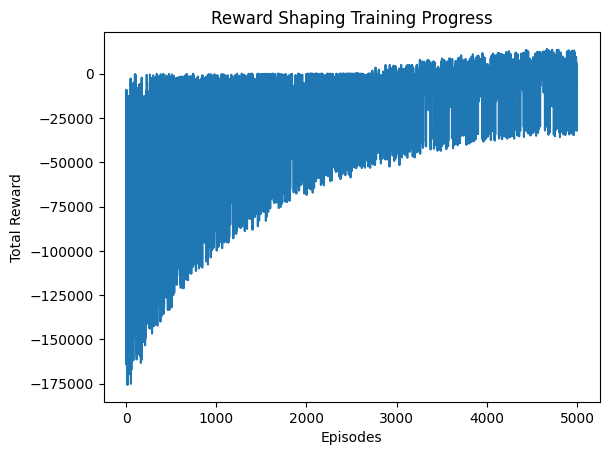

In [161]:
import matplotlib.pyplot as plt

q_table, rewards = tabular_q_learning(ComplexTaxiEnv(), episodes=10000, decay_rate=0.9995)
plt.plot(rewards)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Reward Shaping Training Progress")
plt.show()

In [162]:
for key in q_table.keys():
  print(key)
print(len(q_table.keys()))

(0, 0, 1, 0, 0, -1, 0, -3, 5, 5, 0)
(0, 0, 0, 0, 0, 0, 0, -2, 5, 5, 0)
(0, 0, 0, 0, -1, 0, 1, -2, 5, 5, 0)
(0, 1, 0, 0, -2, 0, 0, -2, 5, 5, 0)
(0, 1, 0, 0, 0, -1, 0, -2, 4, 5, False)
(0, 0, 0, 0, -1, 1, 1, -1, 5, 5, 0)
(0, 0, 0, 0, 1, 0, -1, 0, 1, 5, False)
(0, 0, 0, 0, 0, 1, 0, -1, 5, 5, 0)
(0, 0, 0, 0, 0, 0, 0, 2, 5, 5, 0)
(0, 0, 0, 0, 1, 0, 1, 2, 5, 5, 0)
(1, 0, 0, 0, 2, 0, 2, 2, 5, 5, 0)
(1, 0, 0, 1, 2, 1, 4, 0, 5, 5, 0)
(0, 0, 0, 1, 1, 1, 3, 0, 5, 5, 0)
(0, 0, 0, 1, 0, 1, 2, 0, 5, 5, 0)
(0, 0, 0, 1, 1, 0, 1, 1, 5, 1, 0)
(0, 1, 0, 1, 0, 0, 0, 1, 0, 0, False)
(0, 0, 0, 0, 1, 0, 1, -2, 5, 5, 0)
(0, 0, 0, 0, 1, 1, 1, -1, 5, 5, 0)
(0, 1, 0, 0, 0, 0, 0, -1, 4, 4, False)
(0, 0, 1, 0, -1, -1, 1, -3, 5, 5, 0)
(0, 1, 1, 0, -2, -1, 0, -3, 5, 5, 0)
(0, 0, 1, 0, 1, -1, 1, -3, 5, 5, 0)
(1, 0, 0, 0, 2, 1, 2, -1, 5, 5, 0)
(1, 0, 0, 0, 2, 0, 2, -2, 5, 5, 0)
(1, 0, 1, 0, 2, -1, 2, -3, 5, 5, 0)
(0, 0, 0, 1, -1, 0, -2, 3, 5, 3, 0)
(0, 1, 0, 1, -2, 0, -3, 3, 5, 5, 0)
(0, 1, 0, 0, -2, -1, -3, 2, 5, 5, 

#### Testing

In [163]:
import numpy as np
import pickle
import random

try:
    with open("q_table.pkl", "rb") as f:
        q_table = pickle.load(f)
except FileNotFoundError:
    print("Fail to load q_table.pkl. Use empty q_table instead.")
    q_table = {}

def get_action(obs):
    if obs in q_table:
        return np.argmax(q_table[obs])
    else:
        # 0: left, 1: right, 2: forward, 3: pickup, 4: dropoff, 5: toggle, 6: done (unused)
        print("Random")
        return random.choice([0, 1, 2, 3, 4, 5])  # Fallback for unseen states

In [164]:
def run_learned_value(env, max_steps=100, gif_path="/content/minigrid_q_learning.gif"):
    total_reward = 0
    done = False
    step_count = 0

    obs, _ = env.reset()
    taxi_row, taxi_col, _,_,_,_,_,_,_,_,obstacle_north, obstacle_south, obstacle_east, obstacle_west, passenger_look, destination_look = obs
    env.render_env((taxi_row, taxi_col), action=None, step=step_count, fuel=env.current_fuel)

    step_count = 0
    while not done:
        action = get_action(obs)
        obs, reward, done, _, _ = env.step(action)
        print('obs=',obs, "reward=", reward)
        total_reward += reward
        taxi_row, taxi_col, _,_,_,_,_,_,_,_,obstacle_north, obstacle_south, obstacle_east, obstacle_west, passenger_look,destination_look = obs
        env.render_env((taxi_row, taxi_col), action=action, step=step_count, fuel=env.current_fuel)

        # print()
        step_count += 1
        # if step_count == 10:
        #   break

    print(f"Agent Finished in {step_count} steps, Score: {total_reward}")

In [167]:
run_learned_value(ComplexTaxiEnv())

串流輸出內容已截斷至最後 5000 行。

Random
obs= (4, 4, 2, 4, 3, 0, 1, 2, 0, 2, 0, 1, 1, 0, 0, 0) reward= -10

Step: 7248
Stations: [(2, 4), (3, 0), (1, 2), (0, 2)]
Obstacles: {(0, 1), (1, 3), (4, 2)}
Taxi Position: (4, 4)
Passenger pickup: False
Passenger Position: (0, 3)
Destination: (2, 1)
Fuel Left: 169
Last Action: Drop Off

(4, 4, 2, 4, 3, 0, 1, 2, 0, 2, 0, 1, 1, 0, 0, 0)
. X B . .
. . D X .
. . . . R
P . . . .
. . X . 🚖


Random
obs= (3, 4, 2, 4, 3, 0, 1, 2, 0, 2, 0, 0, 1, 0, 0, 0) reward= -0.1

Step: 7249
Stations: [(2, 4), (3, 0), (1, 2), (0, 2)]
Obstacles: {(0, 1), (1, 3), (4, 2)}
Taxi Position: (4, 3)
Passenger pickup: False
Passenger Position: (0, 3)
Destination: (2, 1)
Fuel Left: 168
Last Action: Move North

(3, 4, 2, 4, 3, 0, 1, 2, 0, 2, 0, 0, 1, 0, 0, 0)
. X B . .
. . D X .
. . . . R
P . . . 🚖
. . X . .


Random
obs= (3, 4, 2, 4, 3, 0, 1, 2, 0, 2, 0, 0, 1, 0, 0, 0) reward= -10

Step: 7250
Stations: [(2, 4), (3, 0), (1, 2), (0, 2)]
Obstacles: {(0, 1), (1, 3), (4, 2)}
Taxi Position: (4, 